# Includes

In [2]:
import os
import sys
import time
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.utils
import torch.nn.functional as F
import torchvision.datasets as dset
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from torch.autograd import Variable
from timeit import default_timer as timer
from tqdm import tqdm_notebook
from collections import defaultdict,Counter

import scipy.io

In [3]:
!pip install optuna
import optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 5.1 MB/s 
     |████████████████████████████████| 209 kB 58.2 MB/s 
     |████████████████████████████████| 81 kB 9.6 MB/s 
     |████████████████████████████████| 78 kB 8.0 MB/s 
     |████████████████████████████████| 147 kB 62.5 MB/s 
     |████████████████████████████████| 112 kB 46.1 MB/s 
     |████████████████████████████████| 50 kB 6.7 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=e994031d1c3428655bef3f5e3ae8fe71691bb6aec84c8400d63b9d8a668e2219
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [4]:
torch.nn.ModuleList()

ModuleList()

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
cd /content/drive/My Drive/Colab Notebooks/huawei

/content/drive/My Drive/Colab Notebooks/huawei


In [7]:
from DPDBlocks.blocks import AFIR,ABS,Polynomial,Delay,Prod_cmp

In [8]:
import matplotlib.pyplot as plt

import matplotlib.mlab as mlab
import matplotlib.gridspec as gridspec

# Operations

In [9]:
def NMSE(X, E):
    return 10*torch.log10((E.norm(dim=1)**2).sum()/(X.norm(dim=1)**2).sum())

In [10]:
def update_history(hist,iter_num, val_acc, val_loss, time):
    hist['iter'].append(iter_num)
    hist['time'].append(time)
    hist['train_loss'].append(val_loss.item())
        # self.hist['norm_coeffs'].append(train_loss.item())
    hist['train_loss_db'].append(val_acc.item())

In [11]:
def draw_spectrum(input_batch,desired,out):
  plt.psd(input_batch.detach().cpu()[0,0,:]+
                1j*input_batch.detach().cpu()[0,1,:],NFFT=2048)
  plt.psd(desired.detach().cpu()[0,0,:]+
                1j*desired.detach().cpu()[0,1,:],NFFT=2048)
        # plt.psd(desired.permute(2,1,0).detach().cpu().reshape(-1,),NFFT=2048)
  plt.psd((out-desired).detach().cpu()[0,0,:]+
                1j*(out-desired).detach().cpu()[0,1,:],NFFT=2048)
        # plt.psd((out-desired).permute(2,1,0).detach().cpu().reshape(-1,),NFFT=2048)
  plt.show()

## Train Function

In [12]:
def eval_model(valid_queue, model, criterion):
    for step, (valid) in enumerate(valid_queue):
        model.eval()
        input_batch = Variable(valid[:,:,:1],requires_grad=False).permute(2,1,0).cpu()
        desired = Variable(valid[:,:,1:],requires_grad=False).permute(2,1,0).cpu()
        #out = model.forward(input_batch)
        out = sum(list(map( lambda n: n(input_batch),  model)))

        loss=criterion(out,desired)
        #draw_spectrum(input_batch,desired,out)
        accuracy = NMSE(input_batch, out - desired)

    return loss,accuracy

In [13]:
def train_of_epoch(train_queue, model, criterion, optimizer):
    for step, (train) in enumerate(train_queue):

        input_batch = Variable(train[:,:,:1],requires_grad=False).permute(2,1,0).cpu()
        desired = Variable(train[:,:,1:],requires_grad=False).permute(2,1,0).cpu()
        optimizer.zero_grad()
        #out = model.forward(input_batch)
        out = sum(list(map( lambda n: n(input_batch),  model)))

        loss = criterion(out, desired)

        loss.backward()

        optimizer.step()


In [14]:
def train(train_queue, valid_queue, model, criterion, optimizer,n_epoch,
          scheduler,log_every=1,save_flag=True,path_to_experiment=''):
    min_loss=0
    hist=defaultdict(list)
    t0=timer()
    for it in tqdm_notebook(range(n_epoch)):
        model.train(True)
        train_of_epoch(train_queue, model, criterion, optimizer)
        scheduler.step()
        if it%log_every==0:
            loss_v,accuracy_v=eval_model(valid_queue, model, loss_fn)
            update_history(hist,it, accuracy_v, loss_v, timer() - t0,)
            print('Loss = ',loss_v.cpu().detach().numpy(), 'Accuracy = ', accuracy_v.cpu().detach().numpy(), 'dbs')
            
            if save_flag:
                with open(path_to_experiment + '/hist.pkl', 'wb') as output:
                    pickle.dump(hist, output)

                    torch.save(model.state_dict(), path_to_experiment + '/model.pt')
                if hist['train_loss_db'][-1] < min_loss:
                            min_loss = hist['train_loss_db'][-1]
                            torch.save(model.state_dict(), path_to_experiment + '/best_model.pth')



# Data preprocess

In [15]:
np.random.seed()
torch
cudnn.benchmark = True
torch.manual_seed(10)
cudnn.enabled=False

In [16]:
Batch_size=1000

In [17]:
serg_data=np.load('AdaptiveFilteringData/gsm_4c_in.npy').reshape(-1,1)
x_real, x_imag = torch.from_numpy(np.real(serg_data)), torch.from_numpy(np.imag(serg_data))
X = torch.DoubleTensor(torch.cat((x_real, x_imag), dim=1)).reshape(-1,2,1)

In [18]:
name = 'BlackBoxData/BlackBoxData_80'
# name = 'BlackBoxData'
# name = '../BlackBoxData/data1'
mat = scipy.io.loadmat(name)
x = np.array(mat['x']).reshape(-1,1)/2**15
d = np.array(mat['y']).reshape(-1,1)/2**15
# x = np.array(mat['xE']).reshape(-1,1)/2**15
# d = np.array(mat['d']).reshape(-1,1)/2**15
# x, d = mat['xE'], mat['d']
x_real, x_imag = torch.from_numpy(np.real(x)), torch.from_numpy(np.imag(x))
d_real, d_imag = torch.from_numpy(np.real(d)), torch.from_numpy(np.imag(d))
X = torch.DoubleTensor(torch.cat((x_real, x_imag), dim=1)).reshape(-1,2,1)
D = torch.DoubleTensor(torch.cat((d_real, d_imag), dim=1)).reshape(-1,2,1)

train_queue = torch.utils.data.DataLoader(
    torch.cat((X,D),dim=-1), batch_size=Batch_size)#, pin_memory=True)

valid_queue = torch.utils.data.DataLoader(
    torch.cat((X,D),dim=-1), batch_size=X.shape[0])#,pin_memory=True)

In [19]:
gamma=0.95
step_size=5

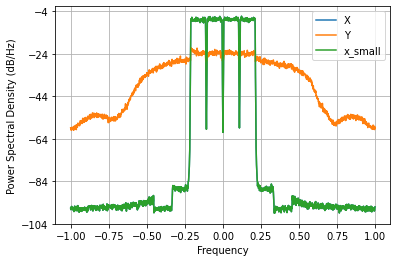

In [20]:
plt.psd(X.detach().cpu()[:,0,0]+1j*X.detach().cpu()[:,1,0],NFFT=2048, label = "X")
plt.psd(d.reshape(-1,),NFFT=2048, label = "Y")
plt.psd(x.reshape(-1,),NFFT=2048, label = "x_small")
plt.legend()
# plt.psd(x.reshape(-1,)*x.reshape(-1,),NFFT=2048)
plt.show()

## Loss function

In [21]:
loss_fn = nn.MSELoss()

# Model

# Ensemble of small NN
(as nn.ModuleList with Optuna)

In [27]:
class Cell_try_2(nn.Module):
    def __init__(self,M=15,D=0,Poly_order=8,Passthrough=False):
        super(Cell_try_2,self).__init__()
        self.f = AFIR(M,0)
        self.pol = Polynomial(Poly_order,Passthrough)
        self.prod = Prod_cmp()
        self.delay = Delay(D)
    def forward(self,x):
        #return self.prod(self.f(self.delay(x)), self.pol(self.delay(x)))
        return self.prod( self.f(self.delay(x)), self.f(self.pol(self.delay(x))) )

D = {'p': [4, 5, 6, 7, 8, 9], 'k' : [3, 5, 7, 9], 'z' : [-2, -1, 0, 1, 2]}
ex_D = {} # extremum vals of D

for key in D.keys():
  ex_D[key] = [ min(D[key]), max(D[key])]

# complex reference model
ref_model = {'k': [9,5,9,7,9],'p': [9,8,6,9,6]}

### params of the functional
score_huge = -37
score_min = -20.0
complex_huge = 2 * ( sum(ref_model['k']) + sum(ref_model['p']) )
complex_min = 2 * (4 * 5 + 3 * 5)
trtr_coef = 0.4



def objective(trial):
  # create and train NN
  net = torch.nn.ModuleList()

  for i in range(5):
    delay_val = trial.suggest_int('z_'+str(i), -10, 10)
    net.append(Cell_try_2(M=9, D=delay_val, Poly_order=9))

  net = net.to(torch.device('cpu'))
  optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
  train(train_queue, valid_queue, net, loss_fn, optimizer, 20, scheduler, save_flag=False)

  loss_cur, accuracy_cur = eval_model(valid_queue, net, loss_fn)
  score_cur = accuracy_cur.item()

  return score_cur

study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction="minimize", pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective, n_trials=100)
print(study.best_params)

[I 2022-10-31 08:12:08,026] A new study created in memory with name: no-name-8aaaf10e-68ca-4841-a47c-984f83823d30
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00011899711341183155 Accuracy =  -24.290035865739004 dbs
Loss =  8.471072471686987e-05 Accuracy =  -25.766016159069764 dbs
Loss =  7.759162814895364e-05 Accuracy =  -26.14725148128467 dbs
Loss =  7.453610320675863e-05 Accuracy =  -26.321733293094024 dbs
Loss =  7.183491722511844e-05 Accuracy =  -26.48204417474519 dbs
Loss =  6.902580322498929e-05 Accuracy =  -26.655285440909072 dbs
Loss =  6.593153584229372e-05 Accuracy =  -26.854468206033346 dbs
Loss =  6.430004632907606e-05 Accuracy =  -26.963287272990108 dbs
Loss =  6.197812559680398e-05 Accuracy =  -27.123015753958903 dbs
Loss =  5.959904850939875e-05 Accuracy =  -27.29300686794558 dbs
Loss =  5.747877886940067e-05 Accuracy =  -27.45032480118851 dbs
Loss =  5.581487769479281e-05 Accuracy =  -27.57790035714738 dbs
Loss =  5.440939864297019e-05 Accuracy =  -27.688660872231416 dbs
Loss =  5.3286674830666314e-05 Accuracy =  -27.779213926865125 dbs
Loss =  5.246028794859066e-05 Accuracy =  -27.847093430843515 dbs
Loss =  5.181

[I 2022-10-31 08:13:04,004] Trial 0 finished with value: -28.004407495035828 and parameters: {'z_0': -6, 'z_1': -3, 'z_2': 6, 'z_3': 9, 'z_4': 8}. Best is trial 0 with value: -28.004407495035828.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.742349881089373e-05 Accuracy =  -25.62911829563531 dbs
Loss =  6.657252531832477e-05 Accuracy =  -26.812449816335974 dbs
Loss =  6.041458402735455e-05 Accuracy =  -27.233982235561566 dbs
Loss =  5.781596028913025e-05 Accuracy =  -27.424922697234923 dbs
Loss =  5.545613670484793e-05 Accuracy =  -27.605904015246637 dbs
Loss =  5.3522995723007126e-05 Accuracy =  -27.759995999041763 dbs
Loss =  5.245160164956157e-05 Accuracy =  -27.847812588940766 dbs
Loss =  5.169737003288389e-05 Accuracy =  -27.910715630670108 dbs
Loss =  5.069113624573205e-05 Accuracy =  -27.996079870617056 dbs
Loss =  4.9788667856937334e-05 Accuracy =  -28.074095066686905 dbs
Loss =  4.903232129512091e-05 Accuracy =  -28.14057558974604 dbs
Loss =  4.873423688618993e-05 Accuracy =  -28.16705843162868 dbs
Loss =  4.8651948900926474e-05 Accuracy =  -28.174397712070366 dbs
Loss =  4.8627714983248436e-05 Accuracy =  -28.176561505924084 dbs
Loss =  4.8601539518859836e-05 Accuracy =  -28.17889986798971 dbs
Loss =  4

[I 2022-10-31 08:14:01,327] Trial 1 finished with value: -28.234183268149252 and parameters: {'z_0': 9, 'z_1': 5, 'z_2': 2, 'z_3': -10, 'z_4': 1}. Best is trial 1 with value: -28.234183268149252.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.470588585196203e-05 Accuracy =  -25.76626424481787 dbs
Loss =  7.095284106991189e-05 Accuracy =  -26.535702231226153 dbs
Loss =  6.516094609748777e-05 Accuracy =  -26.905526317633512 dbs
Loss =  6.200902633883417e-05 Accuracy =  -27.120851009980385 dbs
Loss =  5.974600874385557e-05 Accuracy =  -27.282311150399842 dbs
Loss =  5.7827215161327435e-05 Accuracy =  -27.42407735052317 dbs
Loss =  5.609284834921925e-05 Accuracy =  -27.55632519448511 dbs
Loss =  5.4684778848809326e-05 Accuracy =  -27.66673553018545 dbs
Loss =  5.3508506435471904e-05 Accuracy =  -27.761171843075484 dbs
Loss =  5.226549090342881e-05 Accuracy =  -27.86324979278217 dbs
Loss =  5.099661842353626e-05 Accuracy =  -27.969986340737215 dbs
Loss =  5.021289633135059e-05 Accuracy =  -28.037247404906456 dbs
Loss =  4.9593755208655124e-05 Accuracy =  -28.091130190912047 dbs
Loss =  4.9075123095248215e-05 Accuracy =  -28.13678615523255 dbs
Loss =  4.861786531481341e-05 Accuracy =  -28.177441269642166 dbs
Loss =  4.8

[I 2022-10-31 08:14:56,101] Trial 2 finished with value: -28.34790125619908 and parameters: {'z_0': 8, 'z_1': 6, 'z_2': -1, 'z_3': -6, 'z_4': -5}. Best is trial 2 with value: -28.34790125619908.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010238310410170298 Accuracy =  -24.94311720569325 dbs
Loss =  7.443612151393709e-05 Accuracy =  -26.32756276957323 dbs
Loss =  6.99989082299893e-05 Accuracy =  -26.59448746744132 dbs
Loss =  6.764831296291406e-05 Accuracy =  -26.742830426562435 dbs
Loss =  6.39802773339649e-05 Accuracy =  -26.984938948592077 dbs
Loss =  6.216272381843559e-05 Accuracy =  -27.11009977207352 dbs
Loss =  6.085733537325439e-05 Accuracy =  -27.202270802006296 dbs
Loss =  5.973478439283252e-05 Accuracy =  -27.283127126524313 dbs
Loss =  5.881738695423761e-05 Accuracy =  -27.350342866867 dbs
Loss =  5.80026584646028e-05 Accuracy =  -27.410921138851243 dbs
Loss =  5.7240852117747315e-05 Accuracy =  -27.46833922864209 dbs
Loss =  5.6656141762502197e-05 Accuracy =  -27.512930170506316 dbs
Loss =  5.626010543809394e-05 Accuracy =  -27.54339471389362 dbs
Loss =  5.5989607420680976e-05 Accuracy =  -27.564325907521507 dbs
Loss =  5.5780740862905195e-05 Accuracy =  -27.58055735002443 dbs
Loss =  5.54817305

[I 2022-10-31 08:15:50,880] Trial 3 finished with value: -27.663621868942954 and parameters: {'z_0': -6, 'z_1': 4, 'z_2': -6, 'z_3': -6, 'z_4': -5}. Best is trial 2 with value: -28.34790125619908.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0001378677802698945 Accuracy =  -23.65077229819349 dbs
Loss =  8.416471193238857e-05 Accuracy =  -25.794099718213772 dbs
Loss =  7.374218456466677e-05 Accuracy =  -26.36824013983897 dbs
Loss =  6.858503911507847e-05 Accuracy =  -26.683106224810224 dbs
Loss =  6.524285759967255e-05 Accuracy =  -26.90007038504975 dbs
Loss =  6.280911494968493e-05 Accuracy =  -27.065173393838332 dbs
Loss =  6.124575371655388e-05 Accuracy =  -27.174640295125343 dbs
Loss =  6.0134134059681864e-05 Accuracy =  -27.254189516913225 dbs
Loss =  5.919903604836963e-05 Accuracy =  -27.322253780758025 dbs
Loss =  5.83310833468464e-05 Accuracy =  -27.38639970752965 dbs
Loss =  5.751523802609085e-05 Accuracy =  -27.447570916852015 dbs
Loss =  5.687515241094702e-05 Accuracy =  -27.496174396730353 dbs
Loss =  5.63088262642522e-05 Accuracy =  -27.539635384040256 dbs
Loss =  5.586201926491844e-05 Accuracy =  -27.57423382887749 dbs
Loss =  5.551652589087229e-05 Accuracy =  -27.601177320900042 dbs
Loss =  5.501733

[I 2022-10-31 08:16:45,014] Trial 4 finished with value: -27.713123227045543 and parameters: {'z_0': -5, 'z_1': -6, 'z_2': 5, 'z_3': 5, 'z_4': -6}. Best is trial 2 with value: -28.34790125619908.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  9.119263102753977e-05 Accuracy =  -25.445802672813635 dbs
Loss =  6.809485304127298e-05 Accuracy =  -26.71425726192712 dbs
Loss =  6.384282673626539e-05 Accuracy =  -26.99427905334978 dbs
Loss =  6.122247379282801e-05 Accuracy =  -27.1762913915347 dbs
Loss =  5.916656442059651e-05 Accuracy =  -27.324636609731677 dbs
Loss =  5.736333935365088e-05 Accuracy =  -27.459055876920196 dbs
Loss =  5.588044679303252e-05 Accuracy =  -27.57280143273841 dbs
Loss =  5.4611247491437943e-05 Accuracy =  -27.672579158474715 dbs
Loss =  5.3475808401221444e-05 Accuracy =  -27.76382654555368 dbs
Loss =  5.259222355596806e-05 Accuracy =  -27.836184803233266 dbs
Loss =  5.186780233714956e-05 Accuracy =  -27.8964216601384 dbs
Loss =  5.1380362536629514e-05 Accuracy =  -27.93742848842666 dbs
Loss =  5.098429059556428e-05 Accuracy =  -27.97103632307992 dbs
Loss =  5.063966073835357e-05 Accuracy =  -28.000492256860138 dbs
Loss =  5.033108816258997e-05 Accuracy =  -28.027036931546906 dbs
Loss =  4.9996599

[I 2022-10-31 08:17:41,527] Trial 5 finished with value: -28.167897621007082 and parameters: {'z_0': 10, 'z_1': 3, 'z_2': -4, 'z_3': -3, 'z_4': -3}. Best is trial 2 with value: -28.34790125619908.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.592277214452e-05 Accuracy =  -25.704317328225635 dbs
Loss =  7.515397417235863e-05 Accuracy =  -26.28588061941638 dbs
Loss =  7.00608996892533e-05 Accuracy =  -26.590643031147778 dbs
Loss =  6.776091581943467e-05 Accuracy =  -26.735607460898198 dbs
Loss =  6.569462623123275e-05 Accuracy =  -26.870101670730065 dbs
Loss =  6.358490077740761e-05 Accuracy =  -27.011860152194195 dbs
Loss =  6.145946635602388e-05 Accuracy =  -27.159512281202446 dbs
Loss =  6.024394294942342e-05 Accuracy =  -27.246266245618127 dbs
Loss =  5.917795099197243e-05 Accuracy =  -27.32380089290705 dbs
Loss =  5.81516812836353e-05 Accuracy =  -27.399777375538783 dbs
Loss =  5.713627299813844e-05 Accuracy =  -27.476281052180514 dbs
Loss =  5.6580548281632366e-05 Accuracy =  -27.518728615599283 dbs
Loss =  5.6118403629386005e-05 Accuracy =  -27.554347047524605 dbs
Loss =  5.5727016352660915e-05 Accuracy =  -27.584742217648003 dbs
Loss =  5.538652080770877e-05 Accuracy =  -27.611359280328532 dbs
Loss =  5.4822

[I 2022-10-31 08:18:34,922] Trial 6 finished with value: -27.737026540879043 and parameters: {'z_0': -1, 'z_1': 9, 'z_2': -6, 'z_3': -4, 'z_4': 9}. Best is trial 2 with value: -28.34790125619908.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.642013873735451e-05 Accuracy =  -26.213321913431752 dbs
Loss =  6.198352284870603e-05 Accuracy =  -27.122637573005456 dbs
Loss =  5.836661347884761e-05 Accuracy =  -27.38375517534677 dbs
Loss =  5.608504424229627e-05 Accuracy =  -27.556929463383376 dbs
Loss =  5.416169032613807e-05 Accuracy =  -27.708478034020253 dbs
Loss =  5.275284496187945e-05 Accuracy =  -27.82294127027999 dbs
Loss =  5.134561101993627e-05 Accuracy =  -27.940366867493005 dbs
Loss =  5.0104857726897517e-05 Accuracy =  -28.046601798518488 dbs
Loss =  4.887167934587571e-05 Accuracy =  -28.154827504738694 dbs
Loss =  4.769133465993721e-05 Accuracy =  -28.26100536640198 dbs
Loss =  4.649678549410075e-05 Accuracy =  -28.37117083698701 dbs
Loss =  4.583047699407991e-05 Accuracy =  -28.43385635823529 dbs
Loss =  4.5343753706768956e-05 Accuracy =  -28.480225435179378 dbs
Loss =  4.495716184127045e-05 Accuracy =  -28.517411268493696 dbs
Loss =  4.4627189028910226e-05 Accuracy =  -28.549404807161174 dbs
Loss =  4.41

[I 2022-10-31 08:19:28,502] Trial 7 finished with value: -28.66982659987388 and parameters: {'z_0': 0, 'z_1': -2, 'z_2': 1, 'z_3': -10, 'z_4': -4}. Best is trial 7 with value: -28.66982659987388.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.31168204206661e-05 Accuracy =  -25.848510919216142 dbs
Loss =  6.630700409971369e-05 Accuracy =  -26.829806071893753 dbs
Loss =  6.287243601571022e-05 Accuracy =  -27.060797255625744 dbs
Loss =  6.026207495431933e-05 Accuracy =  -27.24495931840096 dbs
Loss =  5.83635034988229e-05 Accuracy =  -27.38398658900399 dbs
Loss =  5.670421383925357e-05 Accuracy =  -27.509246794813397 dbs
Loss =  5.561778777597151e-05 Accuracy =  -27.593263025369694 dbs
Loss =  5.351189349712032e-05 Accuracy =  -27.7608969455447 dbs
Loss =  5.192034833265149e-05 Accuracy =  -27.892024156628587 dbs
Loss =  5.0423581280797274e-05 Accuracy =  -28.01906325402758 dbs
Loss =  4.932598811077517e-05 Accuracy =  -28.11464219229345 dbs
Loss =  4.872494971573262e-05 Accuracy =  -28.167886135416268 dbs
Loss =  4.825049020259451e-05 Accuracy =  -28.2103828320588 dbs
Loss =  4.786647862944094e-05 Accuracy =  -28.245085340178754 dbs
Loss =  4.753781071768554e-05 Accuracy =  -28.27500836064474 dbs
Loss =  4.7244252719

[I 2022-10-31 08:20:21,851] Trial 8 finished with value: -28.313713322931847 and parameters: {'z_0': 6, 'z_1': -5, 'z_2': 1, 'z_3': 10, 'z_4': -3}. Best is trial 7 with value: -28.66982659987388.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.512079533967335e-05 Accuracy =  -25.74504340269135 dbs
Loss =  6.693847993748675e-05 Accuracy =  -26.788641671164484 dbs
Loss =  6.110045591399138e-05 Accuracy =  -27.184955623036547 dbs
Loss =  5.812160243977293e-05 Accuracy =  -27.402024336454396 dbs
Loss =  5.711030574431573e-05 Accuracy =  -27.478255279393913 dbs
Loss =  5.564163360751226e-05 Accuracy =  -27.591401409861657 dbs
Loss =  5.495244766841949e-05 Accuracy =  -27.64552971789163 dbs
Loss =  5.4348736935544796e-05 Accuracy =  -27.693505576011887 dbs
Loss =  5.381001916085811e-05 Accuracy =  -27.73676866446943 dbs
Loss =  5.331584453385279e-05 Accuracy =  -27.776837202276564 dbs
Loss =  5.257211041091744e-05 Accuracy =  -27.837846018150188 dbs
Loss =  5.216063768905057e-05 Accuracy =  -27.87197120921914 dbs
Loss =  5.179355775187013e-05 Accuracy =  -27.90264268968766 dbs
Loss =  5.1469894880674484e-05 Accuracy =  -27.929867318670002 dbs
Loss =  5.1190015412422135e-05 Accuracy =  -27.953547528297786 dbs
Loss =  5.06

[I 2022-10-31 08:21:18,137] Trial 9 finished with value: -28.053913338759937 and parameters: {'z_0': 4, 'z_1': -10, 'z_2': 7, 'z_3': 4, 'z_4': -2}. Best is trial 7 with value: -28.66982659987388.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.883512146689915e-05 Accuracy =  -25.55955312633803 dbs
Loss =  7.654880939379876e-05 Accuracy =  -26.206015728753265 dbs
Loss =  7.016604142048887e-05 Accuracy =  -26.584130376462586 dbs
Loss =  6.790480399142781e-05 Accuracy =  -26.72639513185497 dbs
Loss =  6.688602900306286e-05 Accuracy =  -26.792046003112006 dbs
Loss =  6.58679755217408e-05 Accuracy =  -26.85865697704446 dbs
Loss =  6.529633968933941e-05 Accuracy =  -26.89651176385322 dbs
Loss =  6.470547429153721e-05 Accuracy =  -26.935989882034814 dbs
Loss =  6.410849235239052e-05 Accuracy =  -26.976244494935703 dbs
Loss =  6.359135595637837e-05 Accuracy =  -27.011419276093402 dbs
Loss =  6.292203825879287e-05 Accuracy =  -27.057372306842975 dbs
Loss =  6.261651217742043e-05 Accuracy =  -27.078511399612285 dbs
Loss =  6.23503029892696e-05 Accuracy =  -27.09701444878949 dbs
Loss =  6.213982045423329e-05 Accuracy =  -27.11170019061054 dbs
Loss =  6.195900603973175e-05 Accuracy =  -27.1243557104496 dbs
Loss =  6.1389891507

[I 2022-10-31 08:22:12,005] Trial 10 finished with value: -27.19105626849721 and parameters: {'z_0': -10, 'z_1': 0, 'z_2': 10, 'z_3': -10, 'z_4': -10}. Best is trial 7 with value: -28.66982659987388.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.162701668058241e-05 Accuracy =  -25.92706089024736 dbs
Loss =  6.470052495822208e-05 Accuracy =  -26.936322087367085 dbs
Loss =  5.8319102396701214e-05 Accuracy =  -27.38729182107772 dbs
Loss =  5.429639668339243e-05 Accuracy =  -27.697690040367085 dbs
Loss =  5.236966138926248e-05 Accuracy =  -27.854602472807947 dbs
Loss =  5.099137479202235e-05 Accuracy =  -27.970432918841524 dbs
Loss =  4.99315783501677e-05 Accuracy =  -28.061647187050234 dbs
Loss =  4.911478490727887e-05 Accuracy =  -28.133277666958264 dbs
Loss =  4.845698564499163e-05 Accuracy =  -28.191836185756873 dbs
Loss =  4.791494577554189e-05 Accuracy =  -28.240690121370395 dbs
Loss =  4.729286963973676e-05 Accuracy =  -28.29744346175536 dbs
Loss =  4.696624473348598e-05 Accuracy =  -28.327541763260417 dbs
Loss =  4.669995798113227e-05 Accuracy =  -28.352235233341197 dbs
Loss =  4.6476874440410814e-05 Accuracy =  -28.373030989827008 dbs
Loss =  4.6283529042124843e-05 Accuracy =  -28.391135473642606 dbs
Loss =  4.5

[I 2022-10-31 08:23:05,938] Trial 11 finished with value: -28.50682348102701 and parameters: {'z_0': 1, 'z_1': 10, 'z_2': -2, 'z_3': -8, 'z_4': 3}. Best is trial 7 with value: -28.66982659987388.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.261446133529134e-05 Accuracy =  -25.874839376293114 dbs
Loss =  6.782444677165734e-05 Accuracy =  -26.731537531302205 dbs
Loss =  6.584293172582483e-05 Accuracy =  -26.86030853084977 dbs
Loss =  6.409060857877374e-05 Accuracy =  -26.977456176482818 dbs
Loss =  6.025578591113605e-05 Accuracy =  -27.24541257847939 dbs
Loss =  5.787853693197202e-05 Accuracy =  -27.42022468756547 dbs
Loss =  5.670286716365777e-05 Accuracy =  -27.509349937187757 dbs
Loss =  5.5689909190353404e-05 Accuracy =  -27.587635034219012 dbs
Loss =  5.4865005153701485e-05 Accuracy =  -27.652445888076905 dbs
Loss =  5.3910048441028875e-05 Accuracy =  -27.72870291073183 dbs
Loss =  5.30776818661321e-05 Accuracy =  -27.79628066066186 dbs
Loss =  5.212293385876807e-05 Accuracy =  -27.875111601499295 dbs
Loss =  5.135921263975889e-05 Accuracy =  -27.93921655959938 dbs
Loss =  5.070074273783304e-05 Accuracy =  -27.99525691584707 dbs
Loss =  5.017960591260066e-05 Accuracy =  -28.04012766894413 dbs
Loss =  4.995900

[I 2022-10-31 08:23:59,687] Trial 12 finished with value: -28.158034198388787 and parameters: {'z_0': 1, 'z_1': 10, 'z_2': -10, 'z_3': -8, 'z_4': 3}. Best is trial 7 with value: -28.66982659987388.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.271769818202505e-05 Accuracy =  -26.428998899360035 dbs
Loss =  6.119801765652858e-05 Accuracy =  -27.178026585546597 dbs
Loss =  5.909315831679202e-05 Accuracy =  -27.330028110603948 dbs
Loss =  5.6799311610370383e-05 Accuracy =  -27.501969409069172 dbs
Loss =  5.542989969779245e-05 Accuracy =  -27.60795920415376 dbs
Loss =  5.4111421072134135e-05 Accuracy =  -27.712510736306164 dbs
Loss =  5.347325625741289e-05 Accuracy =  -27.76403381842265 dbs
Loss =  5.280618873631143e-05 Accuracy =  -27.8185518953416 dbs
Loss =  5.213429190284395e-05 Accuracy =  -27.874165338858823 dbs
Loss =  5.165655233334959e-05 Accuracy =  -27.91414596058648 dbs
Loss =  5.147017051664488e-05 Accuracy =  -27.92984406102382 dbs
Loss =  5.116584877642782e-05 Accuracy =  -27.95559830222006 dbs
Loss =  5.0947711906701746e-05 Accuracy =  -27.974153287923187 dbs
Loss =  5.075518202697009e-05 Accuracy =  -27.990596234828224 dbs
Loss =  5.0590621799179666e-05 Accuracy =  -28.004699958708585 dbs
Loss =  5.023

[I 2022-10-31 08:24:55,817] Trial 13 finished with value: -28.062605093557327 and parameters: {'z_0': 0, 'z_1': 0, 'z_2': -1, 'z_3': -1, 'z_4': 5}. Best is trial 7 with value: -28.66982659987388.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.904586495185618e-05 Accuracy =  -25.54926256327353 dbs
Loss =  6.711437385918454e-05 Accuracy =  -26.777244703286595 dbs
Loss =  5.837245573056251e-05 Accuracy =  -27.38332048665155 dbs
Loss =  5.44120737863592e-05 Accuracy =  -27.688447348193108 dbs
Loss =  5.254244021385697e-05 Accuracy =  -27.840297744029428 dbs
Loss =  5.1343703149864356e-05 Accuracy =  -27.940528243085232 dbs
Loss =  5.0267034757139825e-05 Accuracy =  -28.032567461041108 dbs
Loss =  4.929489894158948e-05 Accuracy =  -28.11738032525394 dbs
Loss =  4.8518634277778085e-05 Accuracy =  -28.18631445469415 dbs
Loss =  4.794946482747503e-05 Accuracy =  -28.23756248842951 dbs
Loss =  4.7519850489126415e-05 Accuracy =  -28.27664947576387 dbs
Loss =  4.71254780864751e-05 Accuracy =  -28.31284243998656 dbs
Loss =  4.674847790407863e-05 Accuracy =  -28.34772538007465 dbs
Loss =  4.636747973241505e-05 Accuracy =  -28.383265223333396 dbs
Loss =  4.593095288771725e-05 Accuracy =  -28.424345577144262 dbs
Loss =  4.533099

[I 2022-10-31 08:25:51,252] Trial 14 finished with value: -28.63737270472043 and parameters: {'z_0': 2, 'z_1': -2, 'z_2': -3, 'z_3': 2, 'z_4': 5}. Best is trial 7 with value: -28.66982659987388.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010003715777820229 Accuracy =  -25.043786689323237 dbs
Loss =  6.622105544951952e-05 Accuracy =  -26.83543914761621 dbs
Loss =  6.0894874819206384e-05 Accuracy =  -27.19959271103423 dbs
Loss =  5.806569574232738e-05 Accuracy =  -27.4062037902253 dbs
Loss =  5.594227856491391e-05 Accuracy =  -27.56799861649776 dbs
Loss =  5.4515618915628446e-05 Accuracy =  -27.68019066145 dbs
Loss =  5.314550955326392e-05 Accuracy =  -27.790734377622996 dbs
Loss =  5.201818500810147e-05 Accuracy =  -27.88384818195218 dbs
Loss =  5.125388917914461e-05 Accuracy =  -27.94813187606719 dbs
Loss =  5.071214725284822e-05 Accuracy =  -27.994280133120295 dbs
Loss =  5.0204771967136085e-05 Accuracy =  -28.03795014310279 dbs
Loss =  4.9891199094792526e-05 Accuracy =  -28.065160711557994 dbs
Loss =  4.961324640428153e-05 Accuracy =  -28.0894236745014 dbs
Loss =  4.938004258694131e-05 Accuracy =  -28.109885529929063 dbs
Loss =  4.918559889015582e-05 Accuracy =  -28.127020493560366 dbs
Loss =  4.887433046

[I 2022-10-31 08:26:44,967] Trial 15 finished with value: -28.195826616764972 and parameters: {'z_0': -3, 'z_1': -3, 'z_2': 3, 'z_3': 2, 'z_4': 6}. Best is trial 7 with value: -28.66982659987388.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.1157025458789e-05 Accuracy =  -25.952138921073 dbs
Loss =  7.1030963405464e-05 Accuracy =  -26.530923080140173 dbs
Loss =  6.667404806274415e-05 Accuracy =  -26.805831893622916 dbs
Loss =  6.508445987952914e-05 Accuracy =  -26.91062708045434 dbs
Loss =  6.38514648624339e-05 Accuracy =  -26.993691479623855 dbs
Loss =  6.215696251648545e-05 Accuracy =  -27.11050229909415 dbs
Loss =  6.1433824720142e-05 Accuracy =  -27.1613245886172 dbs
Loss =  5.994359411386747e-05 Accuracy =  -27.267972342048573 dbs
Loss =  5.796828174237174e-05 Accuracy =  -27.413495856479905 dbs
Loss =  5.517502631052429e-05 Accuracy =  -27.627974642090194 dbs
Loss =  5.319690844555842e-05 Accuracy =  -27.786536192654523 dbs
Loss =  5.172727229819474e-05 Accuracy =  -27.908204355041775 dbs
Loss =  5.062386851717502e-05 Accuracy =  -28.001846836267134 dbs
Loss =  4.9934915174400434e-05 Accuracy =  -28.061356966716918 dbs
Loss =  4.945181304349495e-05 Accuracy =  -28.103577944479984 dbs
Loss =  4.8755999788301

[I 2022-10-31 08:27:40,132] Trial 16 finished with value: -28.250129806961034 and parameters: {'z_0': 3, 'z_1': -9, 'z_2': -5, 'z_3': 0, 'z_4': -10}. Best is trial 7 with value: -28.66982659987388.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.908378988722628e-05 Accuracy =  -26.0645253955217 dbs
Loss =  6.307574615112366e-05 Accuracy =  -27.04677616455492 dbs
Loss =  5.762651201912168e-05 Accuracy =  -27.439176794619517 dbs
Loss =  5.504539863469054e-05 Accuracy =  -27.638189919394776 dbs
Loss =  5.25600440551912e-05 Accuracy =  -27.838842925663066 dbs
Loss =  5.0581867850586414e-05 Accuracy =  -28.005451505219213 dbs
Loss =  4.911563568467835e-05 Accuracy =  -28.133202438138575 dbs
Loss =  4.791170318754585e-05 Accuracy =  -28.240984035034188 dbs
Loss =  4.69728596728643e-05 Accuracy =  -28.326930126244495 dbs
Loss =  4.623463096408701e-05 Accuracy =  -28.395726176147594 dbs
Loss =  4.537887705305314e-05 Accuracy =  -28.47686268519923 dbs
Loss =  4.492999487399912e-05 Accuracy =  -28.520036440935765 dbs
Loss =  4.4533479278379606e-05 Accuracy =  -28.558533864471784 dbs
Loss =  4.413660657954414e-05 Accuracy =  -28.597410735388145 dbs
Loss =  4.3682118967632627e-05 Accuracy =  -28.642363158221436 dbs
Loss =  4.326

[I 2022-10-31 08:28:36,550] Trial 17 finished with value: -28.79753462626506 and parameters: {'z_0': 4, 'z_1': -2, 'z_2': -9, 'z_3': 6, 'z_4': 0}. Best is trial 17 with value: -28.79753462626506.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.808242280747117e-05 Accuracy =  -26.119867326142522 dbs
Loss =  6.689121672504127e-05 Accuracy =  -26.791709174674892 dbs
Loss =  6.230934660805143e-05 Accuracy =  -27.099868159843425 dbs
Loss =  5.973781087065152e-05 Accuracy =  -27.282907095710755 dbs
Loss =  5.7565201160208806e-05 Accuracy =  -27.443799865062015 dbs
Loss =  5.551309962755936e-05 Accuracy =  -27.60144535877622 dbs
Loss =  5.384298332221698e-05 Accuracy =  -27.734108979463727 dbs
Loss =  5.249928729871654e-05 Accuracy =  -27.84386605434222 dbs
Loss =  5.144775470010495e-05 Accuracy =  -27.93173587249672 dbs
Loss =  5.0695042868790544e-05 Accuracy =  -27.99574518499169 dbs
Loss =  4.97655344492518e-05 Accuracy =  -28.076113406697377 dbs
Loss =  4.936767165960056e-05 Accuracy =  -28.110973681801582 dbs
Loss =  4.900621642443969e-05 Accuracy =  -28.14288839485703 dbs
Loss =  4.8691495176637865e-05 Accuracy =  -28.170869024457375 dbs
Loss =  4.84191361080566e-05 Accuracy =  -28.195229766253785 dbs
Loss =  4.7932

[I 2022-10-31 08:29:32,490] Trial 18 finished with value: -28.286972241434114 and parameters: {'z_0': 5, 'z_1': -7, 'z_2': -8, 'z_3': 6, 'z_4': 0}. Best is trial 17 with value: -28.79753462626506.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.995673766613487e-05 Accuracy =  -26.016849470834057 dbs
Loss =  6.899733173494959e-05 Accuracy =  -26.657077171142525 dbs
Loss =  6.326387877627649e-05 Accuracy =  -27.03384197681953 dbs
Loss =  6.0146726799387516e-05 Accuracy =  -27.253280152389706 dbs
Loss =  5.751412497090737e-05 Accuracy =  -27.44765496386604 dbs
Loss =  5.530629894823817e-05 Accuracy =  -27.617654163243706 dbs
Loss =  5.345802935173943e-05 Accuracy =  -27.765270680229275 dbs
Loss =  5.2356806348200286e-05 Accuracy =  -27.85566865474774 dbs
Loss =  5.107510759253368e-05 Accuracy =  -27.96330722967799 dbs
Loss =  4.960842779796298e-05 Accuracy =  -28.08984549647792 dbs
Loss =  4.8952134028343316e-05 Accuracy =  -28.14768383873101 dbs
Loss =  4.8002613303956596e-05 Accuracy =  -28.232751317505933 dbs
Loss =  4.7362255354634625e-05 Accuracy =  -28.291076381578296 dbs
Loss =  4.695283593422179e-05 Accuracy =  -28.3287818451538 dbs
Loss =  4.6665383636912834e-05 Accuracy =  -28.355451726171633 dbs
Loss =  4.69

[I 2022-10-31 08:30:26,127] Trial 19 finished with value: -28.433847426547448 and parameters: {'z_0': -2, 'z_1': 2, 'z_2': -10, 'z_3': -1, 'z_4': -7}. Best is trial 17 with value: -28.79753462626506.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.544104134052215e-05 Accuracy =  -26.269323386409674 dbs
Loss =  6.342323054722449e-05 Accuracy =  -27.022916535127507 dbs
Loss =  5.9059916687585064e-05 Accuracy =  -27.33247183143211 dbs
Loss =  5.664058281576072e-05 Accuracy =  -27.514122996650528 dbs
Loss =  5.4729017262935734e-05 Accuracy =  -27.66322363298913 dbs
Loss =  5.300943831436433e-05 Accuracy =  -27.801868106526335 dbs
Loss =  5.074888617010852e-05 Accuracy =  -27.991134982869738 dbs
Loss =  4.942249923597488e-05 Accuracy =  -28.10615309770817 dbs
Loss =  4.85142961246696e-05 Accuracy =  -28.186702783883035 dbs
Loss =  4.778668761663989e-05 Accuracy =  -28.252330851427885 dbs
Loss =  4.719122017772586e-05 Accuracy =  -28.306788065181582 dbs
Loss =  4.666919575954864e-05 Accuracy =  -28.355096962945254 dbs
Loss =  4.621774601843739e-05 Accuracy =  -28.397312514767272 dbs
Loss =  4.581141385692046e-05 Accuracy =  -28.435663177217016 dbs
Loss =  4.5436691630202264e-05 Accuracy =  -28.4713331145352 dbs
Loss =  4.497

[I 2022-10-31 08:31:20,869] Trial 20 finished with value: -28.607537334644864 and parameters: {'z_0': 7, 'z_1': -1, 'z_2': 4, 'z_3': 7, 'z_4': 0}. Best is trial 17 with value: -28.79753462626506.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  9.019965686192486e-05 Accuracy =  -25.493351277391348 dbs
Loss =  6.73259340632737e-05 Accuracy =  -26.76357625719516 dbs
Loss =  6.082292694691773e-05 Accuracy =  -27.204726975226563 dbs
Loss =  5.710083145504417e-05 Accuracy =  -27.478975810098877 dbs
Loss =  5.474722626803814e-05 Accuracy =  -27.661778923113303 dbs
Loss =  5.3223390126037996e-05 Accuracy =  -27.784374791475322 dbs
Loss =  5.190288736140078e-05 Accuracy =  -27.893484947844286 dbs
Loss =  5.1032050624029717e-05 Accuracy =  -27.966969931738006 dbs
Loss =  5.041068251994559e-05 Accuracy =  -28.020174356639064 dbs
Loss =  4.994973730054608e-05 Accuracy =  -28.060068046450812 dbs
Loss =  4.967788259941357e-05 Accuracy =  -28.083769363361228 dbs
Loss =  4.9380731914214076e-05 Accuracy =  -28.109824904436337 dbs
Loss =  4.91404325071761e-05 Accuracy =  -28.13101038555469 dbs
Loss =  4.894056426845615e-05 Accuracy =  -28.14871040822736 dbs
Loss =  4.8770347044748986e-05 Accuracy =  -28.163841671413397 dbs
Loss =  4.8

[I 2022-10-31 08:32:14,988] Trial 21 finished with value: -28.218597064087717 and parameters: {'z_0': 3, 'z_1': -3, 'z_2': -3, 'z_3': 3, 'z_4': 2}. Best is trial 17 with value: -28.79753462626506.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  9.389624077315735e-05 Accuracy =  -25.318918079241435 dbs
Loss =  7.111313244589168e-05 Accuracy =  -26.525902039399476 dbs
Loss =  6.208707836950817e-05 Accuracy =  -27.115387893990945 dbs
Loss =  5.8686141737279296e-05 Accuracy =  -27.360044549504003 dbs
Loss =  5.7461136340064006e-05 Accuracy =  -27.451658028759446 dbs
Loss =  5.561330367972097e-05 Accuracy =  -27.593613182548502 dbs
Loss =  5.379851521565583e-05 Accuracy =  -27.737697233930852 dbs
Loss =  5.122743308647192e-05 Accuracy =  -27.95037418423842 dbs
Loss =  5.050063851429389e-05 Accuracy =  -28.012431439014446 dbs
Loss =  4.993120826826074e-05 Accuracy =  -28.061679376123962 dbs
Loss =  4.9894854165210215e-05 Accuracy =  -28.064842555490642 dbs
Loss =  4.949840993138113e-05 Accuracy =  -28.099487650962637 dbs
Loss =  4.93270858862075e-05 Accuracy =  -28.11454553888097 dbs
Loss =  4.9235730236571595e-05 Accuracy =  -28.122596296245664 dbs
Loss =  4.915087456666472e-05 Accuracy =  -28.130087632776707 dbs
Loss =  4

[I 2022-10-31 08:33:11,642] Trial 22 finished with value: -28.204068226499025 and parameters: {'z_0': 2, 'z_1': -2, 'z_2': -8, 'z_3': 2, 'z_4': 5}. Best is trial 17 with value: -28.79753462626506.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.213486977526843e-05 Accuracy =  -25.900124402341707 dbs
Loss =  6.709993817563519e-05 Accuracy =  -26.778178931184815 dbs
Loss =  6.05510608488484e-05 Accuracy =  -27.224182567946542 dbs
Loss =  5.7450145586249945e-05 Accuracy =  -27.452488795533245 dbs
Loss =  5.4032729258730016e-05 Accuracy =  -27.718831083039596 dbs
Loss =  5.251868838487847e-05 Accuracy =  -27.84226141766854 dbs
Loss =  5.1282751665881544e-05 Accuracy =  -27.945686931713325 dbs
Loss =  5.029466974922621e-05 Accuracy =  -28.030180523601732 dbs
Loss =  4.949887853605307e-05 Accuracy =  -28.09944653621568 dbs
Loss =  4.8886331515051724e-05 Accuracy =  -28.153525645952357 dbs
Loss =  4.832682203310015e-05 Accuracy =  -28.203517762216283 dbs
Loss =  4.796503157999365e-05 Accuracy =  -28.236152783946338 dbs
Loss =  4.767368182779562e-05 Accuracy =  -28.262613194504777 dbs
Loss =  4.744108901964967e-05 Accuracy =  -28.283853633515648 dbs
Loss =  4.7252114715068215e-05 Accuracy =  -28.301187634989088 dbs
Loss =  

[I 2022-10-31 08:34:05,609] Trial 23 finished with value: -28.36583543523206 and parameters: {'z_0': -3, 'z_1': 1, 'z_2': 0, 'z_3': 7, 'z_4': 7}. Best is trial 17 with value: -28.79753462626506.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.460586087088664e-05 Accuracy =  -25.771395643344917 dbs
Loss =  6.350170035086736e-05 Accuracy =  -27.01754658821182 dbs
Loss =  5.7713875504518466e-05 Accuracy =  -27.432597748424485 dbs
Loss =  5.5495651436814624e-05 Accuracy =  -27.60281059403009 dbs
Loss =  5.360387532429136e-05 Accuracy =  -27.753438247309287 dbs
Loss =  5.213027753876027e-05 Accuracy =  -27.87449976045191 dbs
Loss =  5.0874965730710096e-05 Accuracy =  -27.98035883445194 dbs
Loss =  4.992173682272289e-05 Accuracy =  -28.06250326700496 dbs
Loss =  4.907889547515713e-05 Accuracy =  -28.136452328089703 dbs
Loss =  4.830117986078603e-05 Accuracy =  -28.205822736754342 dbs
Loss =  4.753172149669463e-05 Accuracy =  -28.27556469347135 dbs
Loss =  4.695844441663039e-05 Accuracy =  -28.328263114505955 dbs
Loss =  4.647900825953825e-05 Accuracy =  -28.372831603656778 dbs
Loss =  4.609154918272473e-05 Accuracy =  -28.409187077000357 dbs
Loss =  4.577717067964739e-05 Accuracy =  -28.438910661322314 dbs
Loss =  4.503

[I 2022-10-31 08:34:59,283] Trial 24 finished with value: -28.630263681547284 and parameters: {'z_0': 5, 'z_1': -5, 'z_2': -8, 'z_3': 1, 'z_4': -2}. Best is trial 17 with value: -28.79753462626506.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.041507147670965e-05 Accuracy =  -25.99202560835963 dbs
Loss =  6.901010824303517e-05 Accuracy =  -26.656273045368394 dbs
Loss =  6.571807133483292e-05 Accuracy =  -26.86855203672699 dbs
Loss =  6.358383812818463e-05 Accuracy =  -27.011932733348605 dbs
Loss =  6.201987529693567e-05 Accuracy =  -27.12009124470185 dbs
Loss =  6.056017881149003e-05 Accuracy =  -27.223528643359515 dbs
Loss =  5.792321945570664e-05 Accuracy =  -27.41687320567714 dbs
Loss =  5.6450162349115776e-05 Accuracy =  -27.528748178567696 dbs
Loss =  5.511034186922003e-05 Accuracy =  -27.633069080202585 dbs
Loss =  5.410793701437034e-05 Accuracy =  -27.712790373348692 dbs
Loss =  5.295200391549558e-05 Accuracy =  -27.806576129448256 dbs
Loss =  5.207668087555192e-05 Accuracy =  -27.878967165985383 dbs
Loss =  5.1162507650043525e-05 Accuracy =  -27.955881905475938 dbs
Loss =  5.026248505967107e-05 Accuracy =  -28.03296056119914 dbs
Loss =  4.941993590451995e-05 Accuracy =  -28.106378353329365 dbs
Loss =  4.849

[I 2022-10-31 08:35:53,320] Trial 25 finished with value: -28.335805556024734 and parameters: {'z_0': 0, 'z_1': -4, 'z_2': -3, 'z_3': -3, 'z_4': 10}. Best is trial 17 with value: -28.79753462626506.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.352088229795848e-05 Accuracy =  -25.82744939655759 dbs
Loss =  6.690267382716914e-05 Accuracy =  -26.7909653804367 dbs
Loss =  6.328429393893873e-05 Accuracy =  -27.03244074085096 dbs
Loss =  6.0314212318092624e-05 Accuracy =  -27.24120352672564 dbs
Loss =  5.747310092021614e-05 Accuracy =  -27.4507538332332 dbs
Loss =  5.5321552729952426e-05 Accuracy =  -27.616456520305125 dbs
Loss =  5.302645399292768e-05 Accuracy =  -27.800474273700765 dbs
Loss =  5.164309452374776e-05 Accuracy =  -27.915277552544335 dbs
Loss =  5.060917334646402e-05 Accuracy =  -28.003107695661996 dbs
Loss =  4.9774845642360195e-05 Accuracy =  -28.07530091235187 dbs
Loss =  4.903026239375001e-05 Accuracy =  -28.14075795685706 dbs
Loss =  4.857950112131605e-05 Accuracy =  -28.180869625577046 dbs
Loss =  4.820525534570428e-05 Accuracy =  -28.21445625455233 dbs
Loss =  4.786914616278167e-05 Accuracy =  -28.24484332055168 dbs
Loss =  4.756294771406032e-05 Accuracy =  -28.272712509538724 dbs
Loss =  4.70803838

[I 2022-10-31 08:36:49,694] Trial 26 finished with value: -28.38549758063781 and parameters: {'z_0': 3, 'z_1': -7, 'z_2': 1, 'z_3': 4, 'z_4': 4}. Best is trial 17 with value: -28.79753462626506.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  9.429668928978449e-05 Accuracy =  -25.300435679984435 dbs
Loss =  8.366232960909945e-05 Accuracy =  -25.820100596320362 dbs
Loss =  7.298942226700381e-05 Accuracy =  -26.412800870445174 dbs
Loss =  6.98691593305692e-05 Accuracy =  -26.6025449530701 dbs
Loss =  6.855600617024678e-05 Accuracy =  -26.684945039425635 dbs
Loss =  6.641603361237639e-05 Accuracy =  -26.822670773127008 dbs
Loss =  6.44129832667406e-05 Accuracy =  -26.955665993066557 dbs
Loss =  6.319076882095366e-05 Accuracy =  -27.038863738266805 dbs
Loss =  6.245316558159265e-05 Accuracy =  -27.089855566609838 dbs
Loss =  6.188824474717568e-05 Accuracy =  -27.129318475797763 dbs
Loss =  6.150096500000656e-05 Accuracy =  -27.156580828771176 dbs
Loss =  6.110455298047427e-05 Accuracy =  -27.184664418382617 dbs
Loss =  6.0698527650568184e-05 Accuracy =  -27.21361856511214 dbs
Loss =  6.030276486619489e-05 Accuracy =  -27.24202788252066 dbs
Loss =  5.9926197328583156e-05 Accuracy =  -27.269232931195173 dbs
Loss =  5.9435

[I 2022-10-31 08:37:43,562] Trial 27 finished with value: -27.37717599832028 and parameters: {'z_0': 6, 'z_1': -1, 'z_2': 8, 'z_3': 8, 'z_4': -1}. Best is trial 17 with value: -28.79753462626506.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00012152200876447797 Accuracy =  -24.198850733164242 dbs
Loss =  7.55916001196381e-05 Accuracy =  -26.26066474573451 dbs
Loss =  6.42396985371172e-05 Accuracy =  -26.96736518912347 dbs
Loss =  6.273570755647102e-05 Accuracy =  -27.07025212648544 dbs
Loss =  6.157991739302957e-05 Accuracy =  -27.151009111594743 dbs
Loss =  6.0417942350045545e-05 Accuracy =  -27.233740826885068 dbs
Loss =  5.907521582577646e-05 Accuracy =  -27.331346961769682 dbs
Loss =  5.865399276119015e-05 Accuracy =  -27.362424318936412 dbs
Loss =  5.822399249538988e-05 Accuracy =  -27.394380308734938 dbs
Loss =  5.787334432241022e-05 Accuracy =  -27.420614335086775 dbs
Loss =  5.779612882879171e-05 Accuracy =  -27.426412626868284 dbs
Loss =  5.761498368710528e-05 Accuracy =  -27.440045698822175 dbs
Loss =  5.745238404303477e-05 Accuracy =  -27.452319582647696 dbs
Loss =  5.729518086863434e-05 Accuracy =  -27.464219183993556 dbs
Loss =  5.712968908637359e-05 Accuracy =  -27.476781526074895 dbs
Loss =  5.718

[I 2022-10-31 08:38:37,120] Trial 28 finished with value: -27.558306899127327 and parameters: {'z_0': 2, 'z_1': 2, 'z_2': -7, 'z_3': 5, 'z_4': -7}. Best is trial 17 with value: -28.79753462626506.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.814825909646219e-05 Accuracy =  -26.11620705424691 dbs
Loss =  6.018843407488564e-05 Accuracy =  -27.250269687252544 dbs
Loss =  5.6419387687810345e-05 Accuracy =  -27.53111644634483 dbs
Loss =  5.3373779529298844e-05 Accuracy =  -27.772120557799585 dbs
Loss =  5.148466394564394e-05 Accuracy =  -27.92862130809287 dbs
Loss =  4.988016080459386e-05 Accuracy =  -28.066121682431266 dbs
Loss =  4.869127948211481e-05 Accuracy =  -28.17088826296058 dbs
Loss =  4.782728514433539e-05 Accuracy =  -28.248642837467695 dbs
Loss =  4.7175832411522844e-05 Accuracy =  -28.308204411634428 dbs
Loss =  4.669571569110095e-05 Accuracy =  -28.352629770492666 dbs
Loss =  4.614048997983347e-05 Accuracy =  -28.40457811024388 dbs
Loss =  4.5860457477994666e-05 Accuracy =  -28.431016304468155 dbs
Loss =  4.56114947834796e-05 Accuracy =  -28.4546570793161 dbs
Loss =  4.5392037374770564e-05 Accuracy =  -28.47560337098432 dbs
Loss =  4.519483980895041e-05 Accuracy =  -28.494511617437773 dbs
Loss =  4.4857

[I 2022-10-31 08:39:30,671] Trial 29 finished with value: -28.595353408679564 and parameters: {'z_0': -8, 'z_1': -2, 'z_2': 3, 'z_3': 9, 'z_4': 1}. Best is trial 17 with value: -28.79753462626506.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  9.05859524097769e-05 Accuracy =  -25.4747915833075 dbs
Loss =  8.05099402174475e-05 Accuracy =  -25.98690508980919 dbs
Loss =  7.524148874291819e-05 Accuracy =  -26.280826331390234 dbs
Loss =  7.240205512771805e-05 Accuracy =  -26.447891193452662 dbs
Loss =  7.123199205504363e-05 Accuracy =  -26.518649232595717 dbs
Loss =  6.767912112234027e-05 Accuracy =  -26.740853027972417 dbs
Loss =  6.571404566410137e-05 Accuracy =  -26.868818079247664 dbs
Loss =  6.376854995193819e-05 Accuracy =  -26.999334715634262 dbs
Loss =  6.238208168670936e-05 Accuracy =  -27.0948015009212 dbs
Loss =  6.113042748558993e-05 Accuracy =  -27.182825803132108 dbs
Loss =  6.016113173264813e-05 Accuracy =  -27.25224015664321 dbs
Loss =  5.9164110877358853e-05 Accuracy =  -27.3248167084739 dbs
Loss =  5.834979416314258e-05 Accuracy =  -27.38500684787477 dbs
Loss =  5.765341843222834e-05 Accuracy =  -27.437149502113968 dbs
Loss =  5.705307487580932e-05 Accuracy =  -27.482609574498692 dbs
Loss =  5.6794705896

[I 2022-10-31 08:40:26,293] Trial 30 finished with value: -27.553696195820102 and parameters: {'z_0': -4, 'z_1': -4, 'z_2': -4, 'z_3': 0, 'z_4': -4}. Best is trial 17 with value: -28.79753462626506.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.451700308559277e-05 Accuracy =  -25.77595924266856 dbs
Loss =  6.387785772705558e-05 Accuracy =  -26.991896703702775 dbs
Loss =  5.7354319127520105e-05 Accuracy =  -27.459738846655462 dbs
Loss =  5.481242733399838e-05 Accuracy =  -27.656609781814904 dbs
Loss =  5.335419598863665e-05 Accuracy =  -27.773714333695718 dbs
Loss =  5.2183287421462077e-05 Accuracy =  -27.870085780058417 dbs
Loss =  5.141452797844656e-05 Accuracy =  -27.934541601087236 dbs
Loss =  5.081344427462453e-05 Accuracy =  -27.985613795593544 dbs
Loss =  5.031696040686096e-05 Accuracy =  -28.028256151687245 dbs
Loss =  4.983609872512575e-05 Accuracy =  -28.069959756444444 dbs
Loss =  4.905621704058034e-05 Accuracy =  -28.13845958500678 dbs
Loss =  4.8553826727118114e-05 Accuracy =  -28.18316549008268 dbs
Loss =  4.7924679639040336e-05 Accuracy =  -28.239807946966806 dbs
Loss =  4.724898481746666e-05 Accuracy =  -28.301475313601188 dbs
Loss =  4.663416850230058e-05 Accuracy =  -28.35835775538806 dbs
Loss =  4.

[I 2022-10-31 08:41:21,000] Trial 31 finished with value: -28.550990895997785 and parameters: {'z_0': 5, 'z_1': -6, 'z_2': -9, 'z_3': 1, 'z_4': -2}. Best is trial 17 with value: -28.79753462626506.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.14597838157864e-05 Accuracy =  -25.935967599510008 dbs
Loss =  6.744230707876309e-05 Accuracy =  -26.756075948427632 dbs
Loss =  5.814281651667664e-05 Accuracy =  -27.400439473824388 dbs
Loss =  5.3394487196281674e-05 Accuracy =  -27.770435932602922 dbs
Loss =  5.099537146762864e-05 Accuracy =  -27.97009253458057 dbs
Loss =  4.859679830347502e-05 Accuracy =  -28.179323555004714 dbs
Loss =  4.671632623026208e-05 Accuracy =  -28.350713305893912 dbs
Loss =  4.514681367155025e-05 Accuracy =  -28.49912908626223 dbs
Loss =  4.4166765918966735e-05 Accuracy =  -28.594444136304155 dbs
Loss =  4.350017705694714e-05 Accuracy =  -28.660489884896897 dbs
Loss =  4.314583445551295e-05 Accuracy =  -28.69601140325122 dbs
Loss =  4.264898950325518e-05 Accuracy =  -28.74631267397238 dbs
Loss =  4.229553569854008e-05 Accuracy =  -28.782454832057635 dbs
Loss =  4.2032009259571774e-05 Accuracy =  -28.809598620222943 dbs
Loss =  4.1836477188481814e-05 Accuracy =  -28.8298490520512 dbs
Loss =  4.136

[I 2022-10-31 08:42:14,590] Trial 32 finished with value: -28.956634075642906 and parameters: {'z_0': 4, 'z_1': -4, 'z_2': -8, 'z_3': 2, 'z_4': -1}. Best is trial 32 with value: -28.956634075642906.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.480295442188055e-05 Accuracy =  -26.306212620149815 dbs
Loss =  6.276220304904823e-05 Accuracy =  -27.068418335574176 dbs
Loss =  5.67195251850591e-05 Accuracy =  -27.508074265483742 dbs
Loss =  5.2834058282976524e-05 Accuracy =  -27.816260421977596 dbs
Loss =  5.062883993926051e-05 Accuracy =  -28.001420366454404 dbs
Loss =  4.8334753608368155e-05 Accuracy =  -28.20280504067071 dbs
Loss =  4.6348683820320034e-05 Accuracy =  -28.385026072942402 dbs
Loss =  4.48934706237597e-05 Accuracy =  -28.523568320076915 dbs
Loss =  4.3927764777069955e-05 Accuracy =  -28.61800907976612 dbs
Loss =  4.320504397666087e-05 Accuracy =  -28.690055616163107 dbs
Loss =  4.2461982388306925e-05 Accuracy =  -28.765397472792387 dbs
Loss =  4.207758596695091e-05 Accuracy =  -28.804891971854918 dbs
Loss =  4.171383451995023e-05 Accuracy =  -28.8425989919031 dbs
Loss =  4.1369889815401384e-05 Accuracy =  -28.87855648941777 dbs
Loss =  4.103585569137545e-05 Accuracy =  -28.913765192523684 dbs
Loss =  4.0

[I 2022-10-31 08:43:08,100] Trial 33 finished with value: -29.049147441969655 and parameters: {'z_0': -1, 'z_1': -2, 'z_2': -6, 'z_3': 3, 'z_4': 1}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.03475241904108e-05 Accuracy =  -25.99567514080363 dbs
Loss =  6.346523088926177e-05 Accuracy =  -27.02004148766543 dbs
Loss =  5.587123636822983e-05 Accuracy =  -27.573517312188937 dbs
Loss =  5.256941224215884e-05 Accuracy =  -27.838068917680996 dbs
Loss =  5.062658519804823e-05 Accuracy =  -28.001613782592937 dbs
Loss =  4.887546174707954e-05 Accuracy =  -28.154491397522953 dbs
Loss =  4.7209917464609115e-05 Accuracy =  -28.305067719679627 dbs
Loss =  4.5078783167287184e-05 Accuracy =  -28.505678287206702 dbs
Loss =  4.386302883133979e-05 Accuracy =  -28.62441395844451 dbs
Loss =  4.3143021188416076e-05 Accuracy =  -28.69629458845923 dbs
Loss =  4.2312731994821234e-05 Accuracy =  -28.780689459265943 dbs
Loss =  4.200944715602977e-05 Accuracy =  -28.81193046874669 dbs
Loss =  4.1792671656675734e-05 Accuracy =  -28.834398782077834 dbs
Loss =  4.1630035120235035e-05 Accuracy =  -28.851332358689262 dbs
Loss =  4.150102768325946e-05 Accuracy =  -28.86481161929043 dbs
Loss =  4.0

[I 2022-10-31 08:44:03,253] Trial 34 finished with value: -28.948033740768665 and parameters: {'z_0': -1, 'z_1': -4, 'z_2': -6, 'z_3': 4, 'z_4': 1}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.481791828925906e-05 Accuracy =  -25.760524038993445 dbs
Loss =  6.94434573061364e-05 Accuracy =  -26.629086786832445 dbs
Loss =  6.15561729193084e-05 Accuracy =  -27.15268402169047 dbs
Loss =  5.815923229073872e-05 Accuracy =  -27.399213479921137 dbs
Loss =  5.601056651976079e-05 Accuracy =  -27.56270047769188 dbs
Loss =  5.4075507375348136e-05 Accuracy =  -27.71539410144753 dbs
Loss =  5.235128409131304e-05 Accuracy =  -27.856126744602292 dbs
Loss =  5.084348417458842e-05 Accuracy =  -27.983047091411155 dbs
Loss =  4.967309468840068e-05 Accuracy =  -28.084187952768424 dbs
Loss =  4.905045633211497e-05 Accuracy =  -28.13896961023039 dbs
Loss =  4.808131356328872e-05 Accuracy =  -28.225636892209188 dbs
Loss =  4.7485217913917105e-05 Accuracy =  -28.279815777778392 dbs
Loss =  4.6724200991771426e-05 Accuracy =  -28.349981296865366 dbs
Loss =  4.595865673908259e-05 Accuracy =  -28.42172686319198 dbs
Loss =  4.5302945315146597e-05 Accuracy =  -28.484135750874376 dbs
Loss =  4.501

[I 2022-10-31 08:44:58,193] Trial 35 finished with value: -28.6498418981079 and parameters: {'z_0': -2, 'z_1': -8, 'z_2': -6, 'z_3': 4, 'z_4': 1}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010156898845376446 Accuracy =  -24.977788858921862 dbs
Loss =  7.188422159421136e-05 Accuracy =  -26.479064388413782 dbs
Loss =  6.553518091241207e-05 Accuracy =  -26.880655104848607 dbs
Loss =  6.171734540073291e-05 Accuracy =  -27.14132775310091 dbs
Loss =  5.812689058856779e-05 Accuracy =  -27.40162921497233 dbs
Loss =  5.4724168134111864e-05 Accuracy =  -27.66360844589046 dbs
Loss =  5.350820887090368e-05 Accuracy =  -27.761195994564275 dbs
Loss =  5.237448603345139e-05 Accuracy =  -27.85420239005365 dbs
Loss =  5.111367222405978e-05 Accuracy =  -27.960029294958822 dbs
Loss =  4.9899200681530006e-05 Accuracy =  -28.06446424276304 dbs
Loss =  4.734384738949948e-05 Accuracy =  -28.29276465246059 dbs
Loss =  4.64317002035293e-05 Accuracy =  -28.377254264895658 dbs
Loss =  4.629180838334004e-05 Accuracy =  -28.390358663681525 dbs
Loss =  4.622655250906305e-05 Accuracy =  -28.396485073733878 dbs
Loss =  4.607318683544516e-05 Accuracy =  -28.410917601395774 dbs
Loss =  4.5292

[I 2022-10-31 08:45:51,581] Trial 36 finished with value: -28.54940316194078 and parameters: {'z_0': -6, 'z_1': -4, 'z_2': -7, 'z_3': 6, 'z_4': 2}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.981199290444906e-05 Accuracy =  -26.024718578669916 dbs
Loss =  6.681803861540609e-05 Accuracy =  -26.796462899808255 dbs
Loss =  6.085324217339828e-05 Accuracy =  -27.202562913694095 dbs
Loss =  5.711173210562734e-05 Accuracy =  -27.4781468133118 dbs
Loss =  5.344289784513288e-05 Accuracy =  -27.766500141944586 dbs
Loss =  5.101620747119277e-05 Accuracy =  -27.968318429798977 dbs
Loss =  4.9491511962776234e-05 Accuracy =  -28.100092914538756 dbs
Loss =  4.8441716817021456e-05 Accuracy =  -28.193204866166205 dbs
Loss =  4.766887979789165e-05 Accuracy =  -28.26305066860982 dbs
Loss =  4.710211232208733e-05 Accuracy =  -28.31499629380009 dbs
Loss =  4.647965383443412e-05 Accuracy =  -28.372771282303475 dbs
Loss =  4.608847755126447e-05 Accuracy =  -28.409476509026227 dbs
Loss =  4.5828327374449424e-05 Accuracy =  -28.43406006325857 dbs
Loss =  4.5588091131462244e-05 Accuracy =  -28.45688605372397 dbs
Loss =  4.5370223782103106e-05 Accuracy =  -28.477690917721826 dbs
Loss =  4.4

[I 2022-10-31 08:46:45,429] Trial 37 finished with value: -28.587013986464317 and parameters: {'z_0': 8, 'z_1': -5, 'z_2': -9, 'z_3': 3, 'z_4': -1}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.468385833343536e-05 Accuracy =  -25.767393761819747 dbs
Loss =  6.716487315748682e-05 Accuracy =  -26.77397814227827 dbs
Loss =  5.8305558830288805e-05 Accuracy =  -27.38830050931274 dbs
Loss =  5.4877050300731635e-05 Accuracy =  -27.651492535984445 dbs
Loss =  5.3116996711966804e-05 Accuracy =  -27.793065015280835 dbs
Loss =  5.1881933158273336e-05 Accuracy =  -27.895238632991884 dbs
Loss =  5.073317654252559e-05 Accuracy =  -27.992479576080427 dbs
Loss =  4.947663414615616e-05 Accuracy =  -28.101398658652105 dbs
Loss =  4.849009951081348e-05 Accuracy =  -28.188869377680682 dbs
Loss =  4.7694886577065e-05 Accuracy =  -28.26068192807106 dbs
Loss =  4.688333449738585e-05 Accuracy =  -28.335215205740212 dbs
Loss =  4.635017793370158e-05 Accuracy =  -28.384886074417132 dbs
Loss =  4.5975862272676397e-05 Accuracy =  -28.4201013000269 dbs
Loss =  4.5698752887303996e-05 Accuracy =  -28.44635664743806 dbs
Loss =  4.54398169543358e-05 Accuracy =  -28.471034399048207 dbs
Loss =  4.483

[I 2022-10-31 08:47:40,565] Trial 38 finished with value: -28.56947932926893 and parameters: {'z_0': -1, 'z_1': 5, 'z_2': -6, 'z_3': 5, 'z_4': 1}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.83682522754793e-05 Accuracy =  -25.5824374742448 dbs
Loss =  7.644936819770964e-05 Accuracy =  -26.211661125253592 dbs
Loss =  7.148098361001053e-05 Accuracy =  -26.503494931793007 dbs
Loss =  6.972937217060667e-05 Accuracy =  -26.611242582171325 dbs
Loss =  6.716094307952253e-05 Accuracy =  -26.77423227230653 dbs
Loss =  6.546764706189455e-05 Accuracy =  -26.88513280684529 dbs
Loss =  6.46675668386363e-05 Accuracy =  -26.938534925104868 dbs
Loss =  6.384617549621989e-05 Accuracy =  -26.994051258011986 dbs
Loss =  6.302805094435315e-05 Accuracy =  -27.050061357638473 dbs
Loss =  6.246214413333e-05 Accuracy =  -27.08923124994431 dbs
Loss =  6.176480591745099e-05 Accuracy =  -27.137989320572178 dbs
Loss =  6.134411379231559e-05 Accuracy =  -27.16767116330758 dbs
Loss =  6.093017560910992e-05 Accuracy =  -27.197075833161065 dbs
Loss =  6.0548677821778134e-05 Accuracy =  -27.224353490777315 dbs
Loss =  6.020026001427091e-05 Accuracy =  -27.249416460913686 dbs
Loss =  5.9781208608

[I 2022-10-31 08:48:36,000] Trial 39 finished with value: -27.362088973346353 and parameters: {'z_0': -5, 'z_1': -1, 'z_2': -5, 'z_3': 8, 'z_4': -1}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.128837747189295e-05 Accuracy =  -25.94511558081452 dbs
Loss =  6.84136922674018e-05 Accuracy =  -26.693969833325276 dbs
Loss =  6.419329500167309e-05 Accuracy =  -26.970503448180715 dbs
Loss =  6.036180846505002e-05 Accuracy =  -27.237777701955956 dbs
Loss =  5.84410344253129e-05 Accuracy =  -27.378221186547048 dbs
Loss =  5.660924097933019e-05 Accuracy =  -27.51652681265763 dbs
Loss =  5.550204553187934e-05 Accuracy =  -27.602310237665538 dbs
Loss =  5.409009854485392e-05 Accuracy =  -27.71422240469875 dbs
Loss =  5.102232593980844e-05 Accuracy =  -27.967797603583264 dbs
Loss =  4.950188984236024e-05 Accuracy =  -28.099182337516147 dbs
Loss =  4.8799660050173275e-05 Accuracy =  -28.161232165220703 dbs
Loss =  4.842578475679882e-05 Accuracy =  -28.19463345796222 dbs
Loss =  4.8203782980311364e-05 Accuracy =  -28.214588906049872 dbs
Loss =  4.804255368361848e-05 Accuracy =  -28.229139290365744 dbs
Loss =  4.7921237692334e-05 Accuracy =  -28.240119868121894 dbs
Loss =  4.765283

[I 2022-10-31 08:49:29,587] Trial 40 finished with value: -28.278987115889123 and parameters: {'z_0': 9, 'z_1': 7, 'z_2': -9, 'z_3': -2, 'z_4': 3}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.446363478594433e-05 Accuracy =  -26.32595781565729 dbs
Loss =  6.544466831784412e-05 Accuracy =  -26.88665742151821 dbs
Loss =  6.206374165452254e-05 Accuracy =  -27.117020586656434 dbs
Loss =  5.891460006512e-05 Accuracy =  -27.343170792685832 dbs
Loss =  5.553339455215012e-05 Accuracy =  -27.59985792030306 dbs
Loss =  5.2851406896708865e-05 Accuracy =  -27.814834604857424 dbs
Loss =  5.067164265866001e-05 Accuracy =  -27.99775029786733 dbs
Loss =  4.8672499813269376e-05 Accuracy =  -28.172563610140347 dbs
Loss =  4.7068481777557916e-05 Accuracy =  -28.31809823038084 dbs
Loss =  4.57319951132822e-05 Accuracy =  -28.44319864725533 dbs
Loss =  4.462266006981199e-05 Accuracy =  -28.549845570247427 dbs
Loss =  4.375620122076627e-05 Accuracy =  -28.635004022919656 dbs
Loss =  4.303185642728516e-05 Accuracy =  -28.707499308548563 dbs
Loss =  4.243911564562544e-05 Accuracy =  -28.767736877260827 dbs
Loss =  4.1957515483143535e-05 Accuracy =  -28.817302496300698 dbs
Loss =  4.148833

[I 2022-10-31 08:50:23,212] Trial 41 finished with value: -28.969567450296548 and parameters: {'z_0': 0, 'z_1': -3, 'z_2': -7, 'z_3': 3, 'z_4': -4}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.558771848758877e-05 Accuracy =  -26.260887761871334 dbs
Loss =  6.376204728715973e-05 Accuracy =  -26.999777600948775 dbs
Loss =  5.939730268261692e-05 Accuracy =  -27.30773289649833 dbs
Loss =  5.497752064672601e-05 Accuracy =  -27.64354862820715 dbs
Loss =  5.189393492969896e-05 Accuracy =  -27.894234102126955 dbs
Loss =  4.997681522497307e-05 Accuracy =  -28.057714359037274 dbs
Loss =  4.874418353571928e-05 Accuracy =  -28.166172127767716 dbs
Loss =  4.760623945693768e-05 Accuracy =  -28.268761363816175 dbs
Loss =  4.665057750541223e-05 Accuracy =  -28.356829887245965 dbs
Loss =  4.584364074392867e-05 Accuracy =  -28.43260912638822 dbs
Loss =  4.496924336577391e-05 Accuracy =  -28.51624432771711 dbs
Loss =  4.4315169148921336e-05 Accuracy =  -28.57987601813384 dbs
Loss =  4.3743028638274936e-05 Accuracy =  -28.636311641270318 dbs
Loss =  4.3228610483669286e-05 Accuracy =  -28.687687371000038 dbs
Loss =  4.277348980193046e-05 Accuracy =  -28.733653282338018 dbs
Loss =  4.22

[I 2022-10-31 08:51:18,325] Trial 42 finished with value: -28.890242922484276 and parameters: {'z_0': -1, 'z_1': -3, 'z_2': -7, 'z_3': 3, 'z_4': -4}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.990683496683004e-05 Accuracy =  -26.019560841196565 dbs
Loss =  6.846612198553024e-05 Accuracy =  -26.69064283606001 dbs
Loss =  6.398301812804027e-05 Accuracy =  -26.984752909034583 dbs
Loss =  6.206125320721999e-05 Accuracy =  -27.117194720630554 dbs
Loss =  6.059895727193599e-05 Accuracy =  -27.22074861826065 dbs
Loss =  5.727155988161164e-05 Accuracy =  -27.466010011662952 dbs
Loss =  5.6799145493271174e-05 Accuracy =  -27.50198211060428 dbs
Loss =  5.4836146432384706e-05 Accuracy =  -27.654730856562754 dbs
Loss =  5.302690284802937e-05 Accuracy =  -27.80043751196127 dbs
Loss =  5.13599945738566e-05 Accuracy =  -27.939150439606234 dbs
Loss =  4.913013179700156e-05 Accuracy =  -28.13192083959279 dbs
Loss =  4.8207391108012175e-05 Accuracy =  -28.214263842079642 dbs
Loss =  4.746317183137125e-05 Accuracy =  -28.28183255598706 dbs
Loss =  4.6922926132366735e-05 Accuracy =  -28.3315492607367 dbs
Loss =  4.653361104850249e-05 Accuracy =  -28.367732576698025 dbs
Loss =  4.59562

[I 2022-10-31 08:52:13,393] Trial 43 finished with value: -28.480796143421365 and parameters: {'z_0': -1, 'z_1': -6, 'z_2': -7, 'z_3': 3, 'z_4': -5}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.314609306815596e-05 Accuracy =  -25.84698166062923 dbs
Loss =  6.555236776437519e-05 Accuracy =  -26.87951630027304 dbs
Loss =  6.108546127834248e-05 Accuracy =  -27.186021553988788 dbs
Loss =  5.838622596858072e-05 Accuracy =  -27.38229609371965 dbs
Loss =  5.685407577329652e-05 Accuracy =  -27.49778409156072 dbs
Loss =  5.560944449777961e-05 Accuracy =  -27.593914563596883 dbs
Loss =  5.4646189055167766e-05 Accuracy =  -27.669801328550466 dbs
Loss =  5.360953447007015e-05 Accuracy =  -27.752979771864656 dbs
Loss =  5.2632421169817514e-05 Accuracy =  -27.832866644683012 dbs
Loss =  5.1622729642299536e-05 Accuracy =  -27.916990482417052 dbs
Loss =  5.038556950056065e-05 Accuracy =  -28.022338414478494 dbs
Loss =  4.910009789245823e-05 Accuracy =  -28.13457655147718 dbs
Loss =  4.829008727252594e-05 Accuracy =  -28.20682022856401 dbs
Loss =  4.750769581596243e-05 Accuracy =  -28.277760460466407 dbs
Loss =  4.682982937868094e-05 Accuracy =  -28.340174376761862 dbs
Loss =  4.633

[I 2022-10-31 08:53:06,404] Trial 44 finished with value: -28.588033212946577 and parameters: {'z_0': -2, 'z_1': -3, 'z_2': -5, 'z_3': 1, 'z_4': -4}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.004414201382269e-05 Accuracy =  -26.01210459321251 dbs
Loss =  6.621694952756902e-05 Accuracy =  -26.835708432742802 dbs
Loss =  6.073125459381969e-05 Accuracy =  -27.21127760213829 dbs
Loss =  5.751700801358534e-05 Accuracy =  -27.447437268100746 dbs
Loss =  5.5875287399906956e-05 Accuracy =  -27.57320243157434 dbs
Loss =  5.4824326249445484e-05 Accuracy =  -27.655667099152254 dbs
Loss =  5.38627083594119e-05 Accuracy =  -27.732518260390087 dbs
Loss =  5.292792202960477e-05 Accuracy =  -27.808551693794982 dbs
Loss =  5.184096278942694e-05 Accuracy =  -27.898669544918192 dbs
Loss =  5.048800976038519e-05 Accuracy =  -28.013517620136412 dbs
Loss =  4.928278236168623e-05 Accuracy =  -28.118447942943554 dbs
Loss =  4.813530546936071e-05 Accuracy =  -28.220762809213657 dbs
Loss =  4.7417316284589634e-05 Accuracy =  -28.28603042909625 dbs
Loss =  4.69260681860374e-05 Accuracy =  -28.331258458138034 dbs
Loss =  4.6551992989155056e-05 Accuracy =  -28.366017343590094 dbs
Loss =  4.62

[I 2022-10-31 08:53:59,878] Trial 45 finished with value: -28.474712135069232 and parameters: {'z_0': 1, 'z_1': -4, 'z_2': -4, 'z_3': 4, 'z_4': -6}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.684696511573003e-05 Accuracy =  -26.189132923700274 dbs
Loss =  6.477339417687548e-05 Accuracy =  -26.931433581154465 dbs
Loss =  5.795622391960545e-05 Accuracy =  -27.41439931444682 dbs
Loss =  5.4517298799481265e-05 Accuracy =  -27.680056836857784 dbs
Loss =  5.226746033236069e-05 Accuracy =  -27.863086148283934 dbs
Loss =  5.0094599375692916e-05 Accuracy =  -28.047491053902892 dbs
Loss =  4.8631749724311126e-05 Accuracy =  -28.176201177849954 dbs
Loss =  4.7418473473123534e-05 Accuracy =  -28.285924443666886 dbs
Loss =  4.636347529708673e-05 Accuracy =  -28.38364030933715 dbs
Loss =  4.5682086386059704e-05 Accuracy =  -28.447940824090594 dbs
Loss =  4.499537501377487e-05 Accuracy =  -28.51372137345944 dbs
Loss =  4.454589805095028e-05 Accuracy =  -28.55732294347164 dbs
Loss =  4.415967489385689e-05 Accuracy =  -28.595141457073456 dbs
Loss =  4.382284851121347e-05 Accuracy =  -28.62839409596772 dbs
Loss =  4.352374432951537e-05 Accuracy =  -28.658137626686276 dbs
Loss =  4.

[I 2022-10-31 08:54:53,713] Trial 46 finished with value: -28.783285482302887 and parameters: {'z_0': 0, 'z_1': 1, 'z_2': -7, 'z_3': 3, 'z_4': -3}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.913016978759655e-05 Accuracy =  -25.54515279309646 dbs
Loss =  7.122571495677318e-05 Accuracy =  -26.51903195799544 dbs
Loss =  6.428662967167328e-05 Accuracy =  -26.964193553559443 dbs
Loss =  6.111327392944458e-05 Accuracy =  -27.18404462990872 dbs
Loss =  5.879040261339287e-05 Accuracy =  -27.35233578767189 dbs
Loss =  5.663012938787209e-05 Accuracy =  -27.5149245923982 dbs
Loss =  5.500577372946349e-05 Accuracy =  -27.641317351490237 dbs
Loss =  5.3769797406387204e-05 Accuracy =  -27.74001612991239 dbs
Loss =  5.288319158184623e-05 Accuracy =  -27.812223555309103 dbs
Loss =  5.229226042027586e-05 Accuracy =  -27.86102597798954 dbs
Loss =  5.150080102548306e-05 Accuracy =  -27.92726029180043 dbs
Loss =  5.11109675692504e-05 Accuracy =  -27.960259105826694 dbs
Loss =  5.082699607838003e-05 Accuracy =  -27.984455698756246 dbs
Loss =  5.0598239828375765e-05 Accuracy =  -28.004046039295737 dbs
Loss =  5.04033252790862e-05 Accuracy =  -28.02080823861295 dbs
Loss =  4.9721811301

[I 2022-10-31 08:55:52,087] Trial 47 finished with value: -28.13275430632439 and parameters: {'z_0': -4, 'z_1': -6, 'z_2': -6, 'z_3': 5, 'z_4': -3}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.275342119065629e-05 Accuracy =  -26.426865925350583 dbs
Loss =  6.378181064224585e-05 Accuracy =  -26.99843169276223 dbs
Loss =  6.003800291932055e-05 Accuracy =  -27.26113775529074 dbs
Loss =  5.778668800320478e-05 Accuracy =  -27.427122091921742 dbs
Loss =  5.552864289598624e-05 Accuracy =  -27.600229535681372 dbs
Loss =  5.3482534690588586e-05 Accuracy =  -27.763280316007624 dbs
Loss =  5.219149643451461e-05 Accuracy =  -27.86940264013779 dbs
Loss =  5.095222488926096e-05 Accuracy =  -27.97376860399005 dbs
Loss =  4.9774560395997315e-05 Accuracy =  -28.075325800681455 dbs
Loss =  4.889070283906413e-05 Accuracy =  -28.153137325338832 dbs
Loss =  4.7968575427243315e-05 Accuracy =  -28.235831921768014 dbs
Loss =  4.736960373448414e-05 Accuracy =  -28.290402614409224 dbs
Loss =  4.6783333608173444e-05 Accuracy =  -28.344488483363843 dbs
Loss =  4.627931243360757e-05 Accuracy =  -28.39153115073797 dbs
Loss =  4.5878770922886946e-05 Accuracy =  -28.42928238359142 dbs
Loss =  4.5

[I 2022-10-31 08:56:52,100] Trial 48 finished with value: -28.547785343855153 and parameters: {'z_0': -1, 'z_1': 0, 'z_2': -10, 'z_3': 2, 'z_4': -8}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.8306661767086e-05 Accuracy =  -25.585465455796268 dbs
Loss =  7.604197028326222e-05 Accuracy =  -26.234866520248 dbs
Loss =  7.08454927405563e-05 Accuracy =  -26.54227787915294 dbs
Loss =  6.9554384343653e-05 Accuracy =  -26.62215502300895 dbs
Loss =  6.793840859253745e-05 Accuracy =  -26.72424643515551 dbs
Loss =  6.424422659231553e-05 Accuracy =  -26.96705907933032 dbs
Loss =  6.251341943130721e-05 Accuracy =  -27.08566758044224 dbs
Loss =  6.0998961089756744e-05 Accuracy =  -27.19217574797095 dbs
Loss =  5.9888526410084115e-05 Accuracy =  -27.271963859759033 dbs
Loss =  5.892885942558039e-05 Accuracy =  -27.342119777785147 dbs
Loss =  5.785983656059374e-05 Accuracy =  -27.421628105969358 dbs
Loss =  5.70994988559292e-05 Accuracy =  -27.479077165399808 dbs
Loss =  5.649305342103341e-05 Accuracy =  -27.525449643702157 dbs
Loss =  5.587729248353551e-05 Accuracy =  -27.57304658787809 dbs
Loss =  5.534370244628666e-05 Accuracy =  -27.614718034329048 dbs
Loss =  5.47192426752256

[I 2022-10-31 08:57:53,724] Trial 49 finished with value: -27.75936206833569 and parameters: {'z_0': -3, 'z_1': -5, 'z_2': -8, 'z_3': 0, 'z_4': -5}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.729319300027465e-05 Accuracy =  -26.163987646612238 dbs
Loss =  6.544064146364579e-05 Accuracy =  -26.886924654038225 dbs
Loss =  6.215464893940944e-05 Accuracy =  -27.110663953141735 dbs
Loss =  6.000647551202723e-05 Accuracy =  -27.263418939650062 dbs
Loss =  5.852581527818162e-05 Accuracy =  -27.371925409048835 dbs
Loss =  5.735378271406119e-05 Accuracy =  -27.45977946478121 dbs
Loss =  5.6715592248713255e-05 Accuracy =  -27.508375416060744 dbs
Loss =  5.614921025502492e-05 Accuracy =  -27.551963608989855 dbs
Loss =  5.565408259327148e-05 Accuracy =  -27.590429849404956 dbs
Loss =  5.5201886244517486e-05 Accuracy =  -27.62586095344322 dbs
Loss =  5.507511257602293e-05 Accuracy =  -27.635846195972583 dbs
Loss =  5.4435198929450166e-05 Accuracy =  -27.686601987820147 dbs
Loss =  5.40093885555935e-05 Accuracy =  -27.72070752510473 dbs
Loss =  5.361784691488195e-05 Accuracy =  -27.752306427263026 dbs
Loss =  5.325537213303105e-05 Accuracy =  -27.781765893835964 dbs
Loss =  5.3

[I 2022-10-31 08:58:56,557] Trial 50 finished with value: -27.89378088357385 and parameters: {'z_0': 1, 'z_1': -3, 'z_2': -2, 'z_3': 1, 'z_4': -2}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  9.6262094564066e-05 Accuracy =  -25.21084705893623 dbs
Loss =  6.959800750159983e-05 Accuracy =  -26.619432066234886 dbs
Loss =  6.340824460120821e-05 Accuracy =  -27.023942828274954 dbs
Loss =  5.990586352455803e-05 Accuracy =  -27.270706803697422 dbs
Loss =  5.732385619912368e-05 Accuracy =  -27.462046152640877 dbs
Loss =  5.532870622229075e-05 Accuracy =  -27.615894981221057 dbs
Loss =  5.3874133813456687e-05 Accuracy =  -27.731597124859583 dbs
Loss =  5.283602222585639e-05 Accuracy =  -27.816098989422326 dbs
Loss =  5.21345887615496e-05 Accuracy =  -27.874140609697648 dbs
Loss =  5.157733979295603e-05 Accuracy =  -27.920810743872938 dbs
Loss =  5.094850822414714e-05 Accuracy =  -27.974085407824802 dbs
Loss =  5.040499384829116e-05 Accuracy =  -28.020664470637303 dbs
Loss =  4.983532092539683e-05 Accuracy =  -28.070027537987336 dbs
Loss =  4.9220424905297646e-05 Accuracy =  -28.123946546204124 dbs
Loss =  4.858626209986036e-05 Accuracy =  -28.180265244860742 dbs
Loss =  4.78

[I 2022-10-31 08:59:58,206] Trial 51 finished with value: -28.334569449679794 and parameters: {'z_0': 4, 'z_1': -2, 'z_2': -9, 'z_3': 6, 'z_4': 2}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.547939069224832e-05 Accuracy =  -26.267116274758404 dbs
Loss =  6.397082292687328e-05 Accuracy =  -26.98558075578696 dbs
Loss =  5.93371014990333e-05 Accuracy =  -27.31213685072794 dbs
Loss =  5.6835486418339534e-05 Accuracy =  -27.499204319450822 dbs
Loss =  5.508903454433376e-05 Accuracy =  -27.63474851869647 dbs
Loss =  5.2993537494247446e-05 Accuracy =  -27.803171020606552 dbs
Loss =  5.11962424234392e-05 Accuracy =  -27.95301926276998 dbs
Loss =  5.00627536719475e-05 Accuracy =  -28.05025279100041 dbs
Loss =  4.939315225079616e-05 Accuracy =  -28.108732695961393 dbs
Loss =  4.891960925432313e-05 Accuracy =  -28.150570336902664 dbs
Loss =  4.830858400754702e-05 Accuracy =  -28.20515705246757 dbs
Loss =  4.8013599846464644e-05 Accuracy =  -28.231757444773255 dbs
Loss =  4.782006978046565e-05 Accuracy =  -28.249298076229277 dbs
Loss =  4.771263610098937e-05 Accuracy =  -28.25906601348292 dbs
Loss =  4.765394231189613e-05 Accuracy =  -28.264411783954685 dbs
Loss =  4.7370708

[I 2022-10-31 09:00:56,344] Trial 52 finished with value: -28.288900752332108 and parameters: {'z_0': 0, 'z_1': -1, 'z_2': -5, 'z_3': 5, 'z_4': 0}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.144274137806744e-05 Accuracy =  -25.93687629465488 dbs
Loss =  6.277373607728706e-05 Accuracy =  -27.067620360018697 dbs
Loss =  5.555806559580661e-05 Accuracy =  -27.59792896945757 dbs
Loss =  5.20629441313252e-05 Accuracy =  -27.880112895529 dbs
Loss =  4.98031345885762e-05 Accuracy =  -28.07283335204537 dbs
Loss =  4.809680290563721e-05 Accuracy =  -28.224238042613166 dbs
Loss =  4.721182573103897e-05 Accuracy =  -28.304892177574054 dbs
Loss =  4.665014636500469e-05 Accuracy =  -28.356870024533688 dbs
Loss =  4.621407311355993e-05 Accuracy =  -28.397657660483677 dbs
Loss =  4.583141905270029e-05 Accuracy =  -28.433767088674415 dbs
Loss =  4.51267713198342e-05 Accuracy =  -28.50105750926626 dbs
Loss =  4.4835850343512855e-05 Accuracy =  -28.52914602264434 dbs
Loss =  4.461912704770148e-05 Accuracy =  -28.550189438755087 dbs
Loss =  4.442571816219755e-05 Accuracy =  -28.56905556034118 dbs
Loss =  4.425481426156466e-05 Accuracy =  -28.585794907938894 dbs
Loss =  4.36810002214

[I 2022-10-31 09:01:52,700] Trial 53 finished with value: -28.680412917660444 and parameters: {'z_0': 4, 'z_1': -3, 'z_2': -10, 'z_3': 3, 'z_4': -1}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.091764760574197e-05 Accuracy =  -26.537856918609588 dbs
Loss =  6.01411475915863e-05 Accuracy =  -27.25368302245046 dbs
Loss =  5.67902412205241e-05 Accuracy =  -27.502662997549656 dbs
Loss =  5.431082848143078e-05 Accuracy =  -27.696535853750245 dbs
Loss =  5.1998541162604826e-05 Accuracy =  -27.88548853617559 dbs
Loss =  5.0546176904733104e-05 Accuracy =  -28.00851700134723 dbs
Loss =  4.950496071281753e-05 Accuracy =  -28.098912929472725 dbs
Loss =  4.79918776040199e-05 Accuracy =  -28.2337227180972 dbs
Loss =  4.6590739223444406e-05 Accuracy =  -28.3624041198168 dbs
Loss =  4.5446076619378815e-05 Accuracy =  -28.47043616803916 dbs
Loss =  4.47177679387219e-05 Accuracy =  -28.54059895274689 dbs
Loss =  4.3830730450641215e-05 Accuracy =  -28.627613047926115 dbs
Loss =  4.316643930294338e-05 Accuracy =  -28.693937869251982 dbs
Loss =  4.264239275355413e-05 Accuracy =  -28.746984472675507 dbs
Loss =  4.222004257443437e-05 Accuracy =  -28.790213462267744 dbs
Loss =  4.22334550

[I 2022-10-31 09:02:50,778] Trial 54 finished with value: -28.88114274927836 and parameters: {'z_0': 2, 'z_1': 0, 'z_2': -6, 'z_3': 4, 'z_4': 1}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.231291286466635e-05 Accuracy =  -26.453241572667928 dbs
Loss =  6.090362280569373e-05 Accuracy =  -27.1989688606026 dbs
Loss =  5.850282604827003e-05 Accuracy =  -27.373631674405598 dbs
Loss =  5.697641493495431e-05 Accuracy =  -27.488448940151798 dbs
Loss =  5.551404964663973e-05 Accuracy =  -27.601371036766334 dbs
Loss =  5.417557356882873e-05 Accuracy =  -27.707364951502246 dbs
Loss =  5.314137236343446e-05 Accuracy =  -27.791072473666844 dbs
Loss =  5.232092297066076e-05 Accuracy =  -27.858646165545746 dbs
Loss =  5.1654589454443817e-05 Accuracy =  -27.914310989732954 dbs
Loss =  5.108633155561806e-05 Accuracy =  -27.962352954700485 dbs
Loss =  5.0439840920437426e-05 Accuracy =  -28.017663049338797 dbs
Loss =  5.0106495838257054e-05 Accuracy =  -28.046459814062846 dbs
Loss =  4.9839928612663864e-05 Accuracy =  -28.069626015409742 dbs
Loss =  4.96486622094361e-05 Accuracy =  -28.08632462278695 dbs
Loss =  4.951690626508745e-05 Accuracy =  -28.097865102842583 dbs
Loss =  4.

[I 2022-10-31 09:03:47,998] Trial 55 finished with value: -28.157649568028127 and parameters: {'z_0': 2, 'z_1': 1, 'z_2': -7, 'z_3': 2, 'z_4': -4}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.667928922834767e-05 Accuracy =  -26.198619345668114 dbs
Loss =  6.371128847094215e-05 Accuracy =  -27.00323624974387 dbs
Loss =  5.63208316421225e-05 Accuracy =  -27.538709540975663 dbs
Loss =  5.1684362495042516e-05 Accuracy =  -27.911808493364386 dbs
Loss =  4.9338423497591746e-05 Accuracy =  -28.113547447022007 dbs
Loss =  4.736898354609852e-05 Accuracy =  -28.290459474955988 dbs
Loss =  4.59849746633696e-05 Accuracy =  -28.4192406160358 dbs
Loss =  4.4878512636554645e-05 Accuracy =  -28.52501558037522 dbs
Loss =  4.400243341922635e-05 Accuracy =  -28.61063318667827 dbs
Loss =  4.342121847006978e-05 Accuracy =  -28.668380068390597 dbs
Loss =  4.323609626263761e-05 Accuracy =  -28.686935380360357 dbs
Loss =  4.279582883291121e-05 Accuracy =  -28.731385713012656 dbs
Loss =  4.2446296500852055e-05 Accuracy =  -28.76700209710748 dbs
Loss =  4.21360437638385e-05 Accuracy =  -28.798862567167944 dbs
Loss =  4.1858418948835237e-05 Accuracy =  -28.827571927375057 dbs
Loss =  4.1171

[I 2022-10-31 09:04:45,076] Trial 56 finished with value: -28.958110038845916 and parameters: {'z_0': -2, 'z_1': -1, 'z_2': -5, 'z_3': 4, 'z_4': 3}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.805640782546903e-05 Accuracy =  -26.121314520692284 dbs
Loss =  6.76256266688361e-05 Accuracy =  -26.744287105129217 dbs
Loss =  6.147735027436405e-05 Accuracy =  -27.158248723658396 dbs
Loss =  5.824795486854862e-05 Accuracy =  -27.392593315932206 dbs
Loss =  5.583680208380638e-05 Accuracy =  -27.576194759648274 dbs
Loss =  5.355383994580547e-05 Accuracy =  -27.757493968411744 dbs
Loss =  5.147490536962957e-05 Accuracy =  -27.929444562454776 dbs
Loss =  4.9969176657077756e-05 Accuracy =  -28.058378195141266 dbs
Loss =  4.879828810306798e-05 Accuracy =  -28.161354263905885 dbs
Loss =  4.7818616589349506e-05 Accuracy =  -28.2494300548055 dbs
Loss =  4.711859243953504e-05 Accuracy =  -28.313477047226897 dbs
Loss =  4.643409760627844e-05 Accuracy =  -28.37703003190361 dbs
Loss =  4.5877715051044256e-05 Accuracy =  -28.429382334959442 dbs
Loss =  4.540689269790749e-05 Accuracy =  -28.4741823002916 dbs
Loss =  4.502650481620415e-05 Accuracy =  -28.510717769895017 dbs
Loss =  4.487

[I 2022-10-31 09:05:41,232] Trial 57 finished with value: -28.614461031242634 and parameters: {'z_0': -2, 'z_1': -4, 'z_2': -4, 'z_3': -1, 'z_4': 4}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.006503020869125e-05 Accuracy =  -26.01097141293384 dbs
Loss =  6.627914423928163e-05 Accuracy =  -26.831631207321834 dbs
Loss =  5.79751065092612e-05 Accuracy =  -27.41298457961479 dbs
Loss =  5.494050878237924e-05 Accuracy =  -27.646473362055044 dbs
Loss =  5.241037044961156e-05 Accuracy =  -27.851227837230468 dbs
Loss =  5.001466177291155e-05 Accuracy =  -28.0544267692932 dbs
Loss =  4.872784214124467e-05 Accuracy =  -28.16762833583647 dbs
Loss =  4.7754830750017914e-05 Accuracy =  -28.255227029368935 dbs
Loss =  4.709174314091036e-05 Accuracy =  -28.315952466187994 dbs
Loss =  4.6626426393668804e-05 Accuracy =  -28.359078822001145 dbs
Loss =  4.590268451425473e-05 Accuracy =  -28.427019281321122 dbs
Loss =  4.5604446567113535e-05 Accuracy =  -28.455328234255862 dbs
Loss =  4.534952797756745e-05 Accuracy =  -28.479672420909385 dbs
Loss =  4.5076113081539744e-05 Accuracy =  -28.50593553413502 dbs
Loss =  4.4782789461973596e-05 Accuracy =  -28.534288714120166 dbs
Loss =  4.40

[I 2022-10-31 09:06:38,454] Trial 58 finished with value: -28.683554403357054 and parameters: {'z_0': -1, 'z_1': -7, 'z_2': -8, 'z_3': 2, 'z_4': 3}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  9.051738284673114e-05 Accuracy =  -25.478080245466934 dbs
Loss =  6.919126875483978e-05 Accuracy =  -26.64488718838367 dbs
Loss =  6.270025993573366e-05 Accuracy =  -27.072706718545504 dbs
Loss =  5.9739073671680205e-05 Accuracy =  -27.282815290920123 dbs
Loss =  5.767352962513444e-05 Accuracy =  -27.435634820534464 dbs
Loss =  5.5290009678856065e-05 Accuracy =  -27.61893347173887 dbs
Loss =  5.3359295423950767e-05 Accuracy =  -27.773299267786037 dbs
Loss =  5.1706655241363794e-05 Accuracy =  -27.90993567750943 dbs
Loss =  5.063762671338657e-05 Accuracy =  -28.000666701859913 dbs
Loss =  4.978749516614394e-05 Accuracy =  -28.074197358867107 dbs
Loss =  4.900614055222764e-05 Accuracy =  -28.14289511867922 dbs
Loss =  4.831536310520602e-05 Accuracy =  -28.204547653907813 dbs
Loss =  4.7749318738220245e-05 Accuracy =  -28.255728334563194 dbs
Loss =  4.726681639870415e-05 Accuracy =  -28.299836612489354 dbs
Loss =  4.689894306147728e-05 Accuracy =  -28.333769577953305 dbs
Loss =  4

[I 2022-10-31 09:07:34,850] Trial 59 finished with value: -28.415296601854607 and parameters: {'z_0': -4, 'z_1': -5, 'z_2': -2, 'z_3': -5, 'z_4': 2}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.991421064222744e-05 Accuracy =  -26.019159990968678 dbs
Loss =  6.782381960125009e-05 Accuracy =  -26.731577690554417 dbs
Loss =  6.115114018205357e-05 Accuracy =  -27.181354541348814 dbs
Loss =  5.668905328395804e-05 Accuracy =  -27.51040808872682 dbs
Loss =  5.472658602078216e-05 Accuracy =  -27.66341656510406 dbs
Loss =  5.323264802474175e-05 Accuracy =  -27.78361942721397 dbs
Loss =  5.1799927786621784e-05 Accuracy =  -27.90210858835276 dbs
Loss =  5.0229384445787226e-05 Accuracy =  -28.035821571656605 dbs
Loss =  4.9138662043329015e-05 Accuracy =  -28.131166858847973 dbs
Loss =  4.815842575833664e-05 Accuracy =  -28.218677312268596 dbs
Loss =  4.7074429778133075e-05 Accuracy =  -28.31754945112834 dbs
Loss =  4.643034337107977e-05 Accuracy =  -28.377381176779796 dbs
Loss =  4.5748025695832875e-05 Accuracy =  -28.441676567668303 dbs
Loss =  4.514657203739993e-05 Accuracy =  -28.499152330573494 dbs
Loss =  4.46001541391689e-05 Accuracy =  -28.55203653491994 dbs
Loss =  4.37

[I 2022-10-31 09:08:31,324] Trial 60 finished with value: -28.738839746795968 and parameters: {'z_0': -3, 'z_1': -1, 'z_2': -5, 'z_3': 4, 'z_4': -9}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.832027496552676e-05 Accuracy =  -26.699904075686852 dbs
Loss =  5.9095681018488126e-05 Accuracy =  -27.32984271316161 dbs
Loss =  5.658033910302135e-05 Accuracy =  -27.518744671520828 dbs
Loss =  5.415902144751673e-05 Accuracy =  -27.70869204281679 dbs
Loss =  5.2446002549764374e-05 Accuracy =  -27.848276214047637 dbs
Loss =  5.078127113442955e-05 Accuracy =  -27.988364453964508 dbs
Loss =  4.967090409428786e-05 Accuracy =  -28.08437948178821 dbs
Loss =  4.836802900867416e-05 Accuracy =  -28.199816228370732 dbs
Loss =  4.7100256352998745e-05 Accuracy =  -28.315167422646464 dbs
Loss =  4.6170073988894025e-05 Accuracy =  -28.401794426172398 dbs
Loss =  4.546715736557043e-05 Accuracy =  -28.468422104407672 dbs
Loss =  4.4839065252128444e-05 Accuracy =  -28.528834627409026 dbs
Loss =  4.428602615421504e-05 Accuracy =  -28.582733009441963 dbs
Loss =  4.381397452767511e-05 Accuracy =  -28.629273617146772 dbs
Loss =  4.342398373004631e-05 Accuracy =  -28.668103498788863 dbs
Loss =  

[I 2022-10-31 09:09:26,449] Trial 61 finished with value: -28.77677232906975 and parameters: {'z_0': 1, 'z_1': 0, 'z_2': -6, 'z_3': 4, 'z_4': 1}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.883738272922931e-05 Accuracy =  -26.078078151506368 dbs
Loss =  6.836659211350901e-05 Accuracy =  -26.696960810838377 dbs
Loss =  6.292438446696113e-05 Accuracy =  -27.057210372123034 dbs
Loss =  5.8858277622752354e-05 Accuracy =  -27.347324640035495 dbs
Loss =  5.4908774043671434e-05 Accuracy =  -27.648982658781303 dbs
Loss =  5.217770911248961e-05 Accuracy =  -27.87055005864675 dbs
Loss =  5.073474918163129e-05 Accuracy =  -27.992344954527695 dbs
Loss =  4.961159017248373e-05 Accuracy =  -28.089568656817406 dbs
Loss =  4.863729031905045e-05 Accuracy =  -28.17570641616149 dbs
Loss =  4.7520609016496534e-05 Accuracy =  -28.276580152813843 dbs
Loss =  4.6457997969311504e-05 Accuracy =  -28.37479522474473 dbs
Loss =  4.5776838492701755e-05 Accuracy =  -28.438942176481238 dbs
Loss =  4.532721336459001e-05 Accuracy =  -28.481809929014354 dbs
Loss =  4.502422558696143e-05 Accuracy =  -28.51093761412702 dbs
Loss =  4.480575457289508e-05 Accuracy =  -28.532062174717076 dbs
Loss =  4

[I 2022-10-31 09:10:22,829] Trial 62 finished with value: -28.646891130907655 and parameters: {'z_0': 0, 'z_1': -3, 'z_2': -6, 'z_3': 3, 'z_4': 0}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.913189496484922e-05 Accuracy =  -26.061884472729947 dbs
Loss =  6.726463024448498e-05 Accuracy =  -26.767532539301214 dbs
Loss =  6.067746316067761e-05 Accuracy =  -27.21512597885258 dbs
Loss =  5.585586945027322e-05 Accuracy =  -27.5747119672667 dbs
Loss =  5.191335305094768e-05 Accuracy =  -27.89260932545286 dbs
Loss =  4.955305527857557e-05 Accuracy =  -28.094695763209007 dbs
Loss =  4.788128049872876e-05 Accuracy =  -28.24374256824063 dbs
Loss =  4.6350266845698656e-05 Accuracy =  -28.38487774349924 dbs
Loss =  4.4962141671249846e-05 Accuracy =  -28.516930234366743 dbs
Loss =  4.3834971793658044e-05 Accuracy =  -28.62719281702113 dbs
Loss =  4.3181050359524234e-05 Accuracy =  -28.69246810994961 dbs
Loss =  4.2470351398273616e-05 Accuracy =  -28.764541587949182 dbs
Loss =  4.1947825568847554e-05 Accuracy =  -28.818305597241544 dbs
Loss =  4.155283094122873e-05 Accuracy =  -28.859393960828612 dbs
Loss =  4.122664281327162e-05 Accuracy =  -28.893620425630893 dbs
Loss =  4.06

[I 2022-10-31 09:11:18,656] Trial 63 finished with value: -29.03228853895717 and parameters: {'z_0': -1, 'z_1': -2, 'z_2': -7, 'z_3': 5, 'z_4': 4}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.913189496484922e-05 Accuracy =  -26.061884472729947 dbs
Loss =  6.726463024448498e-05 Accuracy =  -26.767532539301214 dbs
Loss =  6.067746316067761e-05 Accuracy =  -27.21512597885258 dbs
Loss =  5.585586945027322e-05 Accuracy =  -27.5747119672667 dbs
Loss =  5.191335305094768e-05 Accuracy =  -27.89260932545286 dbs
Loss =  4.955305527857557e-05 Accuracy =  -28.094695763209007 dbs
Loss =  4.788128049872876e-05 Accuracy =  -28.24374256824063 dbs
Loss =  4.6350266845698656e-05 Accuracy =  -28.38487774349924 dbs
Loss =  4.4962141671249846e-05 Accuracy =  -28.516930234366743 dbs
Loss =  4.3834971793658044e-05 Accuracy =  -28.62719281702113 dbs
Loss =  4.3181050359524234e-05 Accuracy =  -28.69246810994961 dbs
Loss =  4.2470351398273616e-05 Accuracy =  -28.764541587949182 dbs
Loss =  4.1947825568847554e-05 Accuracy =  -28.818305597241544 dbs
Loss =  4.155283094122873e-05 Accuracy =  -28.859393960828612 dbs
Loss =  4.122664281327162e-05 Accuracy =  -28.893620425630893 dbs
Loss =  4.06

[I 2022-10-31 09:12:13,151] Trial 64 finished with value: -29.03228853895717 and parameters: {'z_0': -1, 'z_1': -2, 'z_2': -7, 'z_3': 5, 'z_4': 4}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010535159395068412 Accuracy =  -24.81898902347256 dbs
Loss =  7.6973635443555e-05 Accuracy =  -26.181980144861726 dbs
Loss =  6.905350831851128e-05 Accuracy =  -26.65354264986178 dbs
Loss =  6.580864817708552e-05 Accuracy =  -26.862570434031653 dbs
Loss =  6.276640510669506e-05 Accuracy =  -27.06812757628414 dbs
Loss =  6.025184623645116e-05 Accuracy =  -27.245696540407156 dbs
Loss =  5.8370997877013874e-05 Accuracy =  -27.383428953162014 dbs
Loss =  5.680764089410756e-05 Accuracy =  -27.50133258854156 dbs
Loss =  5.539649091586148e-05 Accuracy =  -27.61057757871218 dbs
Loss =  5.423284968365401e-05 Accuracy =  -27.70277587951288 dbs
Loss =  5.349119168920071e-05 Accuracy =  -27.762577398223502 dbs
Loss =  5.287679498556944e-05 Accuracy =  -27.812748896992574 dbs
Loss =  5.2451044592005635e-05 Accuracy =  -27.847858713043692 dbs
Loss =  5.215701617846683e-05 Accuracy =  -27.872272750138627 dbs
Loss =  5.19520816281934e-05 Accuracy =  -27.889370594835455 dbs
Loss =  5.180806

[I 2022-10-31 09:13:07,809] Trial 65 finished with value: -27.92569880477324 and parameters: {'z_0': -2, 'z_1': -2, 'z_2': -8, 'z_3': 7, 'z_4': 6}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.187373166690234e-05 Accuracy =  -25.913954278862764 dbs
Loss =  6.0353508330912705e-05 Accuracy =  -27.238374925664797 dbs
Loss =  5.436706902434104e-05 Accuracy =  -27.692040926964555 dbs
Loss =  5.211072893377552e-05 Accuracy =  -27.876128649439188 dbs
Loss =  5.0582519537708886e-05 Accuracy =  -28.005395551908265 dbs
Loss =  4.922142485254316e-05 Accuracy =  -28.123858317148695 dbs
Loss =  4.819481074056768e-05 Accuracy =  -28.215397339881086 dbs
Loss =  4.719127610415213e-05 Accuracy =  -28.30678291835049 dbs
Loss =  4.623928953575654e-05 Accuracy =  -28.39528860586607 dbs
Loss =  4.5415455985180093e-05 Accuracy =  -28.473363341417624 dbs
Loss =  4.481812549674266e-05 Accuracy =  -28.53086324782549 dbs
Loss =  4.419802165241619e-05 Accuracy =  -28.59137182809087 dbs
Loss =  4.371917101955805e-05 Accuracy =  -28.638680946514782 dbs
Loss =  4.3319653305228535e-05 Accuracy =  -28.678550409061494 dbs
Loss =  4.298258362841621e-05 Accuracy =  -28.71247496309762 dbs
Loss =  4.2

[I 2022-10-31 09:14:04,969] Trial 66 finished with value: -28.84265386181754 and parameters: {'z_0': 1, 'z_1': -2, 'z_2': -4, 'z_3': 5, 'z_4': 4}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00011034390735347161 Accuracy =  -24.617916545789424 dbs
Loss =  6.969186797148775e-05 Accuracy =  -26.613579079408304 dbs
Loss =  6.444698959194684e-05 Accuracy =  -26.95337377471479 dbs
Loss =  6.272552794303394e-05 Accuracy =  -27.070956878026536 dbs
Loss =  6.102641099403381e-05 Accuracy =  -27.190221835935475 dbs
Loss =  5.928303793593951e-05 Accuracy =  -27.31609562347282 dbs
Loss =  5.699512717843993e-05 Accuracy =  -27.48702286062139 dbs
Loss =  5.39554862897983e-05 Accuracy =  -27.725044020390897 dbs
Loss =  5.168241775164175e-05 Accuracy =  -27.911971909759043 dbs
Loss =  5.0561900179189435e-05 Accuracy =  -28.007166262299307 dbs
Loss =  4.978915477375586e-05 Accuracy =  -28.074052594320698 dbs
Loss =  4.926084055660038e-05 Accuracy =  -28.120381950390623 dbs
Loss =  4.885826033627567e-05 Accuracy =  -28.15602013861885 dbs
Loss =  4.852101511456258e-05 Accuracy =  -28.1861013491678 dbs
Loss =  4.822046379208964e-05 Accuracy =  -28.213086299636295 dbs
Loss =  4.76618

[I 2022-10-31 09:15:05,498] Trial 67 finished with value: -28.320713914019077 and parameters: {'z_0': -3, 'z_1': 3, 'z_2': -8, 'z_3': 6, 'z_4': 6}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.80400026008182e-05 Accuracy =  -26.122227379424526 dbs
Loss =  6.171565386706221e-05 Accuracy =  -27.141446785084824 dbs
Loss =  5.693686177938093e-05 Accuracy =  -27.49146486918012 dbs
Loss =  5.429349350141195e-05 Accuracy =  -27.697922260127548 dbs
Loss =  5.219219643982723e-05 Accuracy =  -27.86934439187387 dbs
Loss =  5.061874468584361e-05 Accuracy =  -28.002286424224202 dbs
Loss =  4.973953074604659e-05 Accuracy =  -28.07838329417416 dbs
Loss =  4.895431655832588e-05 Accuracy =  -28.14749021293363 dbs
Loss =  4.83505919650929e-05 Accuracy =  -28.20138217540634 dbs
Loss =  4.7845785718536024e-05 Accuracy =  -28.246963222229034 dbs
Loss =  4.718986718438192e-05 Accuracy =  -28.30691258113277 dbs
Loss =  4.695608030533796e-05 Accuracy =  -28.328481764494796 dbs
Loss =  4.67449335385635e-05 Accuracy =  -28.348054664964796 dbs
Loss =  4.657226712421717e-05 Accuracy =  -28.36412633364033 dbs
Loss =  4.643312997207324e-05 Accuracy =  -28.37712053491674 dbs
Loss =  4.5899698501

[I 2022-10-31 09:16:06,239] Trial 68 finished with value: -28.46899296452692 and parameters: {'z_0': 0, 'z_1': -4, 'z_2': -7, 'z_3': 8, 'z_4': 4}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.009912330168377e-05 Accuracy =  -26.009122504541196 dbs
Loss =  6.720238819408516e-05 Accuracy =  -26.7715530614003 dbs
Loss =  6.0608391676105984e-05 Accuracy =  -27.220072535545384 dbs
Loss =  5.667970663798208e-05 Accuracy =  -27.511124193725 dbs
Loss =  5.406912181314302e-05 Accuracy =  -27.715906972859372 dbs
Loss =  5.265228498699813e-05 Accuracy =  -27.83122789835254 dbs
Loss =  5.157378115658617e-05 Accuracy =  -27.921110400556245 dbs
Loss =  5.050959457843468e-05 Accuracy =  -28.011661305310756 dbs
Loss =  4.9438041459374545e-05 Accuracy =  -28.104787557550868 dbs
Loss =  4.8424944634186854e-05 Accuracy =  -28.194708802901136 dbs
Loss =  4.695237066139847e-05 Accuracy =  -28.328824881195583 dbs
Loss =  4.6388863329126284e-05 Accuracy =  -28.38126282049755 dbs
Loss =  4.578534418513869e-05 Accuracy =  -28.43813529853388 dbs
Loss =  4.516880437972309e-05 Accuracy =  -28.49701418219416 dbs
Loss =  4.4578975966856226e-05 Accuracy =  -28.55409925150714 dbs
Loss =  4.37553

[I 2022-10-31 09:17:05,709] Trial 69 finished with value: -28.74975583474182 and parameters: {'z_0': -5, 'z_1': -1, 'z_2': -3, 'z_3': 6, 'z_4': 5}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  9.011901034116635e-05 Accuracy =  -25.497235993469687 dbs
Loss =  7.750611449774322e-05 Accuracy =  -26.152040475628176 dbs
Loss =  7.267108052881422e-05 Accuracy =  -26.431783954771063 dbs
Loss =  7.002662679810818e-05 Accuracy =  -26.59276806371469 dbs
Loss =  6.825542529870545e-05 Accuracy =  -26.70402836053633 dbs
Loss =  6.691548386687385e-05 Accuracy =  -26.79013390439943 dbs
Loss =  6.613225981830745e-05 Accuracy =  -26.8412664981983 dbs
Loss =  6.549242864614446e-05 Accuracy =  -26.883489175324335 dbs
Loss =  6.497850801684135e-05 Accuracy =  -26.917702779284735 dbs
Loss =  6.439893021755636e-05 Accuracy =  -26.956613601338766 dbs
Loss =  6.350866498962755e-05 Accuracy =  -27.017070295717595 dbs
Loss =  6.266071627725089e-05 Accuracy =  -27.075446581262234 dbs
Loss =  6.163740845123706e-05 Accuracy =  -27.14695642647452 dbs
Loss =  6.10583481782551e-05 Accuracy =  -27.187949620585208 dbs
Loss =  6.066480551045159e-05 Accuracy =  -27.21603203536976 dbs
Loss =  6.02345534

[I 2022-10-31 09:18:06,746] Trial 70 finished with value: -27.319409607593354 and parameters: {'z_0': -1, 'z_1': -5, 'z_2': -5, 'z_3': 7, 'z_4': 7}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  9.457180055658902e-05 Accuracy =  -25.287783554721788 dbs
Loss =  6.464684721259793e-05 Accuracy =  -26.939926636833 dbs
Loss =  5.6140959641978174e-05 Accuracy =  -27.55260181191149 dbs
Loss =  5.2179194220268106e-05 Accuracy =  -27.87042644936118 dbs
Loss =  5.011119407804501e-05 Accuracy =  -28.04605261656752 dbs
Loss =  4.837110704267628e-05 Accuracy =  -28.1995398617962 dbs
Loss =  4.719159900861718e-05 Accuracy =  -28.30675320202172 dbs
Loss =  4.618337672206325e-05 Accuracy =  -28.400543297252987 dbs
Loss =  4.528172820210235e-05 Accuracy =  -28.48617019553874 dbs
Loss =  4.447293174641127e-05 Accuracy =  -28.56444253167453 dbs
Loss =  4.355625546470215e-05 Accuracy =  -28.654894767866473 dbs
Loss =  4.3045220449679106e-05 Accuracy =  -28.706150768045347 dbs
Loss =  4.263593577948153e-05 Accuracy =  -28.74764213758595 dbs
Loss =  4.236703839307804e-05 Accuracy =  -28.775119068080347 dbs
Loss =  4.221062705065469e-05 Accuracy =  -28.79118209370389 dbs
Loss =  4.1721430612

[I 2022-10-31 09:19:05,260] Trial 71 finished with value: -28.858434728495844 and parameters: {'z_0': -2, 'z_1': -3, 'z_2': -7, 'z_3': 5, 'z_4': 3}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.972849186274104e-05 Accuracy =  -26.029264640443664 dbs
Loss =  7.033166012997327e-05 Accuracy =  -26.57389144384642 dbs
Loss =  6.531435791969961e-05 Accuracy =  -26.89531351314145 dbs
Loss =  6.173289255554808e-05 Accuracy =  -27.140233863985262 dbs
Loss =  5.899062211320892e-05 Accuracy =  -27.337570368895726 dbs
Loss =  5.711212249981359e-05 Accuracy =  -27.478117126686104 dbs
Loss =  5.545011187957461e-05 Accuracy =  -27.60637586393084 dbs
Loss =  5.3970147299198155e-05 Accuracy =  -27.723864097640586 dbs
Loss =  5.280311913649974e-05 Accuracy =  -27.818804356092855 dbs
Loss =  5.138697568551739e-05 Accuracy =  -27.936869545454385 dbs
Loss =  5.051694918476123e-05 Accuracy =  -28.011028983382108 dbs
Loss =  4.977170361389046e-05 Accuracy =  -28.07557506864097 dbs
Loss =  4.9225012043599574e-05 Accuracy =  -28.123541820720558 dbs
Loss =  4.872259024655129e-05 Accuracy =  -28.168096444357115 dbs
Loss =  4.81691538763513e-05 Accuracy =  -28.217709954323567 dbs
Loss =  4.745

[I 2022-10-31 09:20:00,385] Trial 72 finished with value: -28.456725465205306 and parameters: {'z_0': -1, 'z_1': -2, 'z_2': -9, 'z_3': 2, 'z_4': 2}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.694375880620064e-05 Accuracy =  -26.183666147794277 dbs
Loss =  6.682459226198416e-05 Accuracy =  -26.796036956001434 dbs
Loss =  6.407048924183616e-05 Accuracy =  -26.978819728642076 dbs
Loss =  6.21616048151558e-05 Accuracy =  -27.110177950971405 dbs
Loss =  5.9008251950105705e-05 Accuracy =  -27.336272637709918 dbs
Loss =  5.578561310455742e-05 Accuracy =  -27.580178026403974 dbs
Loss =  5.304556039035121e-05 Accuracy =  -27.798909713414417 dbs
Loss =  5.106398722848827e-05 Accuracy =  -27.964252903373108 dbs
Loss =  4.94596303050431e-05 Accuracy =  -28.102891473138328 dbs
Loss =  4.827823027514362e-05 Accuracy =  -28.207886712622496 dbs
Loss =  4.71833175038264e-05 Accuracy =  -28.307515398582975 dbs
Loss =  4.646235617257338e-05 Accuracy =  -28.374387834211948 dbs
Loss =  4.59918631935304e-05 Accuracy =  -28.418590093423248 dbs
Loss =  4.559823803748506e-05 Accuracy =  -28.45591951732483 dbs
Loss =  4.523760596404132e-05 Accuracy =  -28.490403997347652 dbs
Loss =  4.4681

[I 2022-10-31 09:20:55,618] Trial 73 finished with value: -28.674779199681943 and parameters: {'z_0': 0, 'z_1': -3, 'z_2': -8, 'z_3': 3, 'z_4': -6}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  9.091591489696342e-05 Accuracy =  -25.45900099697193 dbs
Loss =  6.745335291063068e-05 Accuracy =  -26.755364710743752 dbs
Loss =  6.133411315550822e-05 Accuracy =  -27.1683792305007 dbs
Loss =  5.8228358188669194e-05 Accuracy =  -27.394054682589886 dbs
Loss =  5.6645280786813e-05 Accuracy =  -27.513762792324865 dbs
Loss =  5.53988821486879e-05 Accuracy =  -27.610390116150725 dbs
Loss =  5.4591284931999645e-05 Accuracy =  -27.674166965884098 dbs
Loss =  5.388556547187446e-05 Accuracy =  -27.730675684614038 dbs
Loss =  5.322287147289199e-05 Accuracy =  -27.784417112961478 dbs
Loss =  5.259659884198661e-05 Accuracy =  -27.83582351720831 dbs
Loss =  5.182214095190888e-05 Accuracy =  -27.90024661910721 dbs
Loss =  5.129786246264887e-05 Accuracy =  -27.944407443233672 dbs
Loss =  5.085421063422453e-05 Accuracy =  -27.982130956142534 dbs
Loss =  5.046625696830178e-05 Accuracy =  -28.01538918396826 dbs
Loss =  5.0133636116455804e-05 Accuracy =  -28.044108086642456 dbs
Loss =  4.943612

[I 2022-10-31 09:21:51,966] Trial 74 finished with value: -28.18037287587657 and parameters: {'z_0': -2, 'z_1': -4, 'z_2': -6, 'z_3': 4, 'z_4': 4}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.910039195121199e-05 Accuracy =  -26.063613776582322 dbs
Loss =  6.262999208498506e-05 Accuracy =  -27.077576563222408 dbs
Loss =  5.8073618551099776e-05 Accuracy =  -27.405611254931408 dbs
Loss =  5.511971986522246e-05 Accuracy =  -27.63233011446839 dbs
Loss =  5.318873827153967e-05 Accuracy =  -27.787203249087227 dbs
Loss =  5.1288679250575864e-05 Accuracy =  -27.945184975700116 dbs
Loss =  4.999636614339087e-05 Accuracy =  -28.056015732270172 dbs
Loss =  4.8982244660797684e-05 Accuracy =  -28.145013299108737 dbs
Loss =  4.7935915460888384e-05 Accuracy =  -28.23878987370208 dbs
Loss =  4.6607506256740335e-05 Accuracy =  -28.360841465910738 dbs
Loss =  4.5378095376695086e-05 Accuracy =  -28.476937495479888 dbs
Loss =  4.408262334787749e-05 Accuracy =  -28.602725817502034 dbs
Loss =  4.312748350651374e-05 Accuracy =  -28.697858953848904 dbs
Loss =  4.245093990253468e-05 Accuracy =  -28.766527027761178 dbs
Loss =  4.200452973728594e-05 Accuracy =  -28.81243886220861 dbs
Loss = 

[I 2022-10-31 09:22:47,962] Trial 75 finished with value: -28.894057739548117 and parameters: {'z_0': -3, 'z_1': -1, 'z_2': -7, 'z_3': 1, 'z_4': -2}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.564347097545546e-05 Accuracy =  -25.718457529871888 dbs
Loss =  6.475009610342277e-05 Accuracy =  -26.932995957959896 dbs
Loss =  5.947652897409599e-05 Accuracy =  -27.30194397797422 dbs
Loss =  5.724966585589427e-05 Accuracy =  -27.467670569277548 dbs
Loss =  5.5023208137241584e-05 Accuracy =  -27.639941047351417 dbs
Loss =  5.296514822677292e-05 Accuracy =  -27.805498211137575 dbs
Loss =  5.1682702515335676e-05 Accuracy =  -27.911947980739157 dbs
Loss =  5.077914386858163e-05 Accuracy =  -27.988546387017735 dbs
Loss =  5.010076922556449e-05 Accuracy =  -28.046956192502776 dbs
Loss =  4.9599779973114033e-05 Accuracy =  -28.090602631942062 dbs
Loss =  4.890385368291171e-05 Accuracy =  -28.151969297351805 dbs
Loss =  4.863321264672707e-05 Accuracy =  -28.17607053694551 dbs
Loss =  4.840480081269636e-05 Accuracy =  -28.196515758109697 dbs
Loss =  4.820456781067012e-05 Accuracy =  -28.21451819692743 dbs
Loss =  4.801993230530872e-05 Accuracy =  -28.23118469651018 dbs
Loss =  4.7

[I 2022-10-31 09:23:42,317] Trial 76 finished with value: -28.326780794809174 and parameters: {'z_0': -7, 'z_1': -1, 'z_2': -5, 'z_3': 1, 'z_4': -1}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.218998680421917e-05 Accuracy =  -25.897211024179924 dbs
Loss =  6.733795002597635e-05 Accuracy =  -26.76280122143176 dbs
Loss =  6.340226424186778e-05 Accuracy =  -27.024352453169133 dbs
Loss =  6.184452413272866e-05 Accuracy =  -27.132387609797092 dbs
Loss =  6.059496572585689e-05 Accuracy =  -27.221034689772186 dbs
Loss =  5.9094024858729435e-05 Accuracy =  -27.329964426138062 dbs
Loss =  5.7151703591048523e-05 Accuracy =  -27.475108326650833 dbs
Loss =  5.628959353164558e-05 Accuracy =  -27.541119005167324 dbs
Loss =  5.561249901896191e-05 Accuracy =  -27.593676020436646 dbs
Loss =  5.505238113072313e-05 Accuracy =  -27.63763905279104 dbs
Loss =  5.4390307070821115e-05 Accuracy =  -27.69018502424376 dbs
Loss =  5.4042580422620755e-05 Accuracy =  -27.718039356207164 dbs
Loss =  5.3765666338262424e-05 Accuracy =  -27.740349805897853 dbs
Loss =  5.352504917606447e-05 Accuracy =  -27.759829381644387 dbs
Loss =  5.330450183348347e-05 Accuracy =  -27.77776124208073 dbs
Loss =  5

[I 2022-10-31 09:24:37,973] Trial 77 finished with value: -27.86206910824738 and parameters: {'z_0': -3, 'z_1': 0, 'z_2': -7, 'z_3': 0, 'z_4': -2}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.654461516124844e-05 Accuracy =  -26.206253692213576 dbs
Loss =  6.296775378523152e-05 Accuracy =  -27.05421811913324 dbs
Loss =  5.9223696546058806e-05 Accuracy =  -27.3204450202291 dbs
Loss =  5.7099695541787384e-05 Accuracy =  -27.47906220564754 dbs
Loss =  5.595463843920212e-05 Accuracy =  -27.567039193241794 dbs
Loss =  5.4254695126769235e-05 Accuracy =  -27.70102685743952 dbs
Loss =  5.240316060558726e-05 Accuracy =  -27.851825316477385 dbs
Loss =  5.019960522798721e-05 Accuracy =  -28.038397112919537 dbs
Loss =  4.832570530063096e-05 Accuracy =  -28.2036181198091 dbs
Loss =  4.6940531998573254e-05 Accuracy =  -28.32992005789578 dbs
Loss =  4.575836267836419e-05 Accuracy =  -28.440695369618258 dbs
Loss =  4.4954358235666334e-05 Accuracy =  -28.517682110415322 dbs
Loss =  4.425326054237575e-05 Accuracy =  -28.58594738479973 dbs
Loss =  4.3632072397283133e-05 Accuracy =  -28.647341719296428 dbs
Loss =  4.3071685613420605e-05 Accuracy =  -28.703481448985272 dbs
Loss =  4.23

[I 2022-10-31 09:25:35,027] Trial 78 finished with value: -28.91500920149833 and parameters: {'z_0': -4, 'z_1': 2, 'z_2': -10, 'z_3': 1, 'z_4': 0}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  9.362032866253743e-05 Accuracy =  -25.33169851714826 dbs
Loss =  7.117906472711287e-05 Accuracy =  -26.521877359405515 dbs
Loss =  6.514620345044252e-05 Accuracy =  -26.906509018937307 dbs
Loss =  6.201699177408279e-05 Accuracy =  -27.120293168225594 dbs
Loss =  5.9785250468881615e-05 Accuracy =  -27.279459600878205 dbs
Loss =  5.8024173306785574e-05 Accuracy =  -27.4093105153078 dbs
Loss =  5.696086541443793e-05 Accuracy =  -27.48963434162491 dbs
Loss =  5.614221473635963e-05 Accuracy =  -27.552504721574103 dbs
Loss =  5.5427422215692967e-05 Accuracy =  -27.608153319758657 dbs
Loss =  5.480752188832603e-05 Accuracy =  -27.656998471647967 dbs
Loss =  5.487157195323213e-05 Accuracy =  -27.651926111557806 dbs
Loss =  5.459248696047968e-05 Accuracy =  -27.67407134098913 dbs
Loss =  5.437647977715126e-05 Accuracy =  -27.69128924319641 dbs
Loss =  5.417098758025501e-05 Accuracy =  -27.707732599448192 dbs
Loss =  5.3988443509972893e-05 Accuracy =  -27.722392062224834 dbs
Loss =  5.34

[I 2022-10-31 09:26:30,768] Trial 79 finished with value: -27.79424494893683 and parameters: {'z_0': -4, 'z_1': 2, 'z_2': -9, 'z_3': 2, 'z_4': 2}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.725799091168316e-05 Accuracy =  -25.63734803869074 dbs
Loss =  6.893529906958694e-05 Accuracy =  -26.66098349061514 dbs
Loss =  6.260798294847128e-05 Accuracy =  -27.079103008637265 dbs
Loss =  5.951852689141378e-05 Accuracy =  -27.29887839438888 dbs
Loss =  5.7379298515992064e-05 Accuracy =  -27.457847786133026 dbs
Loss =  5.581612246189519e-05 Accuracy =  -27.577803503140327 dbs
Loss =  5.4764312502242595e-05 Accuracy =  -27.660423731254067 dbs
Loss =  5.4030414431956034e-05 Accuracy =  -27.719017143977737 dbs
Loss =  5.341477170202844e-05 Accuracy =  -27.768786366055842 dbs
Loss =  5.28830660754691e-05 Accuracy =  -27.812233862325396 dbs
Loss =  5.2489902785005144e-05 Accuracy =  -27.84464244713615 dbs
Loss =  5.2045662742893856e-05 Accuracy =  -27.881554699800446 dbs
Loss =  5.1676982870300086e-05 Accuracy =  -27.912428634346156 dbs
Loss =  5.13470117953652e-05 Accuracy =  -27.940248387893874 dbs
Loss =  5.1054947653646936e-05 Accuracy =  -27.965021778897935 dbs
Loss =  5

[I 2022-10-31 09:27:26,411] Trial 80 finished with value: -28.03846430656705 and parameters: {'z_0': -10, 'z_1': 4, 'z_2': -10, 'z_3': 4, 'z_4': 0}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.195614282106365e-05 Accuracy =  -25.909585025375854 dbs
Loss =  6.569883003010019e-05 Accuracy =  -26.86982377459981 dbs
Loss =  6.0983019663324546e-05 Accuracy =  -27.193310878509056 dbs
Loss =  5.932891628116911e-05 Accuracy =  -27.31273597674965 dbs
Loss =  5.830799290337761e-05 Accuracy =  -27.388119208855723 dbs
Loss =  5.728635063948034e-05 Accuracy =  -27.464888562339723 dbs
Loss =  5.677799730365425e-05 Accuracy =  -27.503599432881074 dbs
Loss =  5.6292990509613826e-05 Accuracy =  -27.5408569239938 dbs
Loss =  5.580844986042058e-05 Accuracy =  -27.57840053449609 dbs
Loss =  5.536589525832516e-05 Accuracy =  -27.612976863529916 dbs
Loss =  5.452693711880322e-05 Accuracy =  -27.679289099091182 dbs
Loss =  5.4281889390244236e-05 Accuracy =  -27.698850573955696 dbs
Loss =  5.404739343087884e-05 Accuracy =  -27.717652592688825 dbs
Loss =  5.3839289447419447e-05 Accuracy =  -27.734406935552652 dbs
Loss =  5.3655269110662527e-05 Accuracy =  -27.749276357029284 dbs
Loss =  5.

[I 2022-10-31 09:28:21,284] Trial 81 finished with value: -27.822204526751136 and parameters: {'z_0': -4, 'z_1': -2, 'z_2': -10, 'z_3': -2, 'z_4': 1}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.921915349167822e-05 Accuracy =  -26.057098157652664 dbs
Loss =  6.438599696959427e-05 Accuracy =  -26.95748588326874 dbs
Loss =  5.847417743974918e-05 Accuracy =  -27.375758918645502 dbs
Loss =  5.468824352786833e-05 Accuracy =  -27.666460381713787 dbs
Loss =  5.2545162304614944e-05 Accuracy =  -27.840072752885405 dbs
Loss =  5.0383634844135074e-05 Accuracy =  -28.02250517387995 dbs
Loss =  4.8627742252442974e-05 Accuracy =  -28.176559070510983 dbs
Loss =  4.707028125099518e-05 Accuracy =  -28.317932198587116 dbs
Loss =  4.576129769475777e-05 Accuracy =  -28.440416814951583 dbs
Loss =  4.4744648911179616e-05 Accuracy =  -28.53798908398435 dbs
Loss =  4.399446701744268e-05 Accuracy =  -28.611419524453247 dbs
Loss =  4.350029415700689e-05 Accuracy =  -28.660478193946478 dbs
Loss =  4.313333795277325e-05 Accuracy =  -28.697269450140034 dbs
Loss =  4.286738367746991e-05 Accuracy =  -28.72413035088879 dbs
Loss =  4.264871491687733e-05 Accuracy =  -28.746340635181774 dbs
Loss =  4.

[I 2022-10-31 09:29:17,833] Trial 82 finished with value: -28.83123649466345 and parameters: {'z_0': -5, 'z_1': 1, 'z_2': -6, 'z_3': -1, 'z_4': 3}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.432247842842578e-05 Accuracy =  -26.334198295124615 dbs
Loss =  6.018366716713157e-05 Accuracy =  -27.250613660933 dbs
Loss =  5.733556874892791e-05 Accuracy =  -27.461158882227828 dbs
Loss =  5.519152011459632e-05 Accuracy =  -27.626676573358424 dbs
Loss =  5.327547376065537e-05 Accuracy =  -27.780126927021257 dbs
Loss =  5.117446409552588e-05 Accuracy =  -27.954867097585648 dbs
Loss =  4.9675825277948886e-05 Accuracy =  -28.08394922244829 dbs
Loss =  4.8375546750519476e-05 Accuracy =  -28.199141265970233 dbs
Loss =  4.726650717613526e-05 Accuracy =  -28.29986502440809 dbs
Loss =  4.6357657086870995e-05 Accuracy =  -28.384185345086735 dbs
Loss =  4.561319272700255e-05 Accuracy =  -28.454495410907512 dbs
Loss =  4.512961404966209e-05 Accuracy =  -28.500783937070086 dbs
Loss =  4.47120412003511e-05 Accuracy =  -28.541155163455848 dbs
Loss =  4.437319356506019e-05 Accuracy =  -28.5741932686571 dbs
Loss =  4.408460477635737e-05 Accuracy =  -28.602530614936732 dbs
Loss =  4.35927

[I 2022-10-31 09:30:13,105] Trial 83 finished with value: -28.73454496426739 and parameters: {'z_0': -2, 'z_1': 2, 'z_2': -8, 'z_3': 1, 'z_4': -3}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.578054416034066e-05 Accuracy =  -26.24982293632872 dbs
Loss =  6.543458895618316e-05 Accuracy =  -26.887326345112406 dbs
Loss =  5.902518363811086e-05 Accuracy =  -27.335026662163457 dbs
Loss =  5.6698892243763416e-05 Accuracy =  -27.509654392036754 dbs
Loss =  5.446265789250405e-05 Accuracy =  -27.68441181131276 dbs
Loss =  5.214857376081213e-05 Accuracy =  -27.87297577965248 dbs
Loss =  4.9634376323793314e-05 Accuracy =  -28.08757443976239 dbs
Loss =  4.742788697995317e-05 Accuracy =  -28.28506236860879 dbs
Loss =  4.602018343550553e-05 Accuracy =  -28.415916677135936 dbs
Loss =  4.515166512730207e-05 Accuracy =  -28.49866242049061 dbs
Loss =  4.478286197282037e-05 Accuracy =  -28.53428168216983 dbs
Loss =  4.426753201483634e-05 Accuracy =  -28.584547030913843 dbs
Loss =  4.3983463808863734e-05 Accuracy =  -28.61250584979623 dbs
Loss =  4.378399788282589e-05 Accuracy =  -28.632245990043984 dbs
Loss =  4.364812861141319e-05 Accuracy =  -28.645743848256945 dbs
Loss =  4.31307

[I 2022-10-31 09:31:07,533] Trial 84 finished with value: -28.74386823164164 and parameters: {'z_0': -3, 'z_1': -1, 'z_2': -7, 'z_3': 0, 'z_4': -2}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.572884188071265e-05 Accuracy =  -26.252786979178154 dbs
Loss =  6.229429090649099e-05 Accuracy =  -27.100917665021782 dbs
Loss =  5.9242551510197076e-05 Accuracy =  -27.319062583107097 dbs
Loss =  5.7141121365473146e-05 Accuracy =  -27.47591254199655 dbs
Loss =  5.554328705097356e-05 Accuracy =  -27.599084354222292 dbs
Loss =  5.4110778031658084e-05 Accuracy =  -27.712562346591803 dbs
Loss =  5.295603036217877e-05 Accuracy =  -27.80624590642241 dbs
Loss =  5.1719077042409416e-05 Accuracy =  -27.90889247103533 dbs
Loss =  5.057762926711843e-05 Accuracy =  -28.005815444041517 dbs
Loss =  4.962361685718845e-05 Accuracy =  -28.088515981464624 dbs
Loss =  4.873272556487945e-05 Accuracy =  -28.167193114907825 dbs
Loss =  4.800078352542149e-05 Accuracy =  -28.232916866381753 dbs
Loss =  4.721263861766223e-05 Accuracy =  -28.304817402000303 dbs
Loss =  4.6476970927961586e-05 Accuracy =  -28.373021973737202 dbs
Loss =  4.5861253715476946e-05 Accuracy =  -28.4309409021364 dbs
Loss =  4

[I 2022-10-31 09:32:01,873] Trial 85 finished with value: -28.58481660758137 and parameters: {'z_0': -1, 'z_1': 3, 'z_2': -9, 'z_3': 3, 'z_4': 0}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.667029805381307e-05 Accuracy =  -26.199128615703966 dbs
Loss =  6.266930286251735e-05 Accuracy =  -27.074851495323355 dbs
Loss =  5.8486801599160065e-05 Accuracy =  -27.374821408915825 dbs
Loss =  5.430630189600384e-05 Accuracy =  -27.696897835523664 dbs
Loss =  5.0283981034840955e-05 Accuracy =  -28.031103592196796 dbs
Loss =  4.743680826190526e-05 Accuracy =  -28.284245528682234 dbs
Loss =  4.566092227919447e-05 Accuracy =  -28.449953338266504 dbs
Loss =  4.4367831404260735e-05 Accuracy =  -28.57471811200885 dbs
Loss =  4.346231149434026e-05 Accuracy =  -28.664271930743922 dbs
Loss =  4.2851455059579333e-05 Accuracy =  -28.725744397704112 dbs
Loss =  4.231345251753664e-05 Accuracy =  -28.780615506022937 dbs
Loss =  4.20291341093399e-05 Accuracy =  -28.809895704423987 dbs
Loss =  4.1785580456019195e-05 Accuracy =  -28.835135736786683 dbs
Loss =  4.1580912787545e-05 Accuracy =  -28.856459943710252 dbs
Loss =  4.14091389252386e-05 Accuracy =  -28.874438133994037 dbs
Loss =  4.

[I 2022-10-31 09:32:56,161] Trial 86 finished with value: -28.950429211413592 and parameters: {'z_0': -3, 'z_1': 0, 'z_2': -8, 'z_3': 1, 'z_4': -1}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.061125136112114e-05 Accuracy =  -25.98144350204158 dbs
Loss =  6.529852715561464e-05 Accuracy =  -26.89636627505175 dbs
Loss =  6.179728803840035e-05 Accuracy =  -27.135705965578403 dbs
Loss =  6.00767000665471e-05 Accuracy =  -27.258339437071648 dbs
Loss =  5.857923120434352e-05 Accuracy =  -27.36796345449887 dbs
Loss =  5.746437342679581e-05 Accuracy =  -27.451413374825204 dbs
Loss =  5.550602495952255e-05 Accuracy =  -27.601998865085204 dbs
Loss =  5.3813660802552e-05 Accuracy =  -27.7364747616975 dbs
Loss =  5.2869974419606484e-05 Accuracy =  -27.813309128606637 dbs
Loss =  5.183876811433114e-05 Accuracy =  -27.898853406368357 dbs
Loss =  5.081631306723856e-05 Accuracy =  -27.98536861134143 dbs
Loss =  5.0380625195414375e-05 Accuracy =  -28.022764605911057 dbs
Loss =  4.983013805112622e-05 Accuracy =  -28.070479227814737 dbs
Loss =  4.928884722345327e-05 Accuracy =  -28.117913522235824 dbs
Loss =  4.8860509972595934e-05 Accuracy =  -28.15582017608611 dbs
Loss =  4.8304130

[I 2022-10-31 09:33:53,617] Trial 87 finished with value: -28.297844630170935 and parameters: {'z_0': 0, 'z_1': 1, 'z_2': -9, 'z_3': 5, 'z_4': 5}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.097398361099212e-05 Accuracy =  -26.53440831247427 dbs
Loss =  6.162826815700981e-05 Accuracy =  -27.14760049536091 dbs
Loss =  5.767322520374521e-05 Accuracy =  -27.435657744201407 dbs
Loss =  5.485288984680298e-05 Accuracy =  -27.653405004354873 dbs
Loss =  5.2928130357887434e-05 Accuracy =  -27.808534599671116 dbs
Loss =  5.111031874413924e-05 Accuracy =  -27.96031423742906 dbs
Loss =  4.9513312804649016e-05 Accuracy =  -28.098180283411644 dbs
Loss =  4.785756083710762e-05 Accuracy =  -28.245894530437315 dbs
Loss =  4.6423290958408136e-05 Accuracy =  -28.37804088685693 dbs
Loss =  4.532021158557311e-05 Accuracy =  -28.482480843604208 dbs
Loss =  4.414444689307896e-05 Accuracy =  -28.596639334327655 dbs
Loss =  4.352271627950553e-05 Accuracy =  -28.658240210167165 dbs
Loss =  4.299358044859191e-05 Accuracy =  -28.711363990446515 dbs
Loss =  4.2535879408900517e-05 Accuracy =  -28.757845970747464 dbs
Loss =  4.2140598071709845e-05 Accuracy =  -28.798393181882467 dbs
Loss =  4

[I 2022-10-31 09:34:48,122] Trial 88 finished with value: -28.937866677040297 and parameters: {'z_0': 3, 'z_1': 0, 'z_2': -8, 'z_3': 2, 'z_4': -1}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.671295614240107e-05 Accuracy =  -26.196712944833372 dbs
Loss =  6.52005657665159e-05 Accuracy =  -26.90288648875803 dbs
Loss =  5.845074942173077e-05 Accuracy =  -27.37749929332122 dbs
Loss =  5.482108217816721e-05 Accuracy =  -27.655924087981187 dbs
Loss =  5.2649561339526325e-05 Accuracy =  -27.831452560143234 dbs
Loss =  5.069494503456428e-05 Accuracy =  -27.99575356626591 dbs
Loss =  4.919412973383253e-05 Accuracy =  -28.126267310278426 dbs
Loss =  4.7746192326138996e-05 Accuracy =  -28.25601270049838 dbs
Loss =  4.6183452122604825e-05 Accuracy =  -28.4005362068203 dbs
Loss =  4.500183176970421e-05 Accuracy =  -28.513098213346776 dbs
Loss =  4.3907025376929404e-05 Accuracy =  -28.62005997718174 dbs
Loss =  4.3175499519972483e-05 Accuracy =  -28.693026422896093 dbs
Loss =  4.261977077182031e-05 Accuracy =  -28.749289035839524 dbs
Loss =  4.220208381152769e-05 Accuracy =  -28.7920611749667 dbs
Loss =  4.18893642322844e-05 Accuracy =  -28.82436244147727 dbs
Loss =  4.1457322

[I 2022-10-31 09:35:42,362] Trial 89 finished with value: -28.922324360148885 and parameters: {'z_0': 5, 'z_1': 0, 'z_2': -8, 'z_3': 2, 'z_4': -1}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.110752369833423e-05 Accuracy =  -25.95478871022148 dbs
Loss =  6.666205300956761e-05 Accuracy =  -26.80661328521557 dbs
Loss =  6.177225341191414e-05 Accuracy =  -27.137465687296327 dbs
Loss =  5.886682814463331e-05 Accuracy =  -27.34669377299102 dbs
Loss =  5.458327274006742e-05 Accuracy =  -27.674804413074096 dbs
Loss =  5.108814664850208e-05 Accuracy =  -27.96219865299274 dbs
Loss =  4.947730523155256e-05 Accuracy =  -28.101339752723472 dbs
Loss =  4.842048568231428e-05 Accuracy =  -28.19510871814512 dbs
Loss =  4.756667480684282e-05 Accuracy =  -28.272372204219117 dbs
Loss =  4.6932937656201046e-05 Accuracy =  -28.33062274439608 dbs
Loss =  4.712815907531023e-05 Accuracy =  -28.31259537500477 dbs
Loss =  4.647893587818377e-05 Accuracy =  -28.37283836689216 dbs
Loss =  4.6303859020810803e-05 Accuracy =  -28.389228259736452 dbs
Loss =  4.6176166171546554e-05 Accuracy =  -28.40122140851451 dbs
Loss =  4.607443799016485e-05 Accuracy =  -28.410799666811606 dbs
Loss =  4.540310

[I 2022-10-31 09:36:38,248] Trial 90 finished with value: -28.5401743604494 and parameters: {'z_0': 7, 'z_1': -2, 'z_2': -6, 'z_3': -9, 'z_4': 3}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.671295614240107e-05 Accuracy =  -26.196712944833372 dbs
Loss =  6.52005657665159e-05 Accuracy =  -26.90288648875803 dbs
Loss =  5.845074942173077e-05 Accuracy =  -27.37749929332122 dbs
Loss =  5.482108217816721e-05 Accuracy =  -27.655924087981187 dbs
Loss =  5.2649561339526325e-05 Accuracy =  -27.831452560143234 dbs
Loss =  5.069494503456428e-05 Accuracy =  -27.99575356626591 dbs
Loss =  4.919412973383253e-05 Accuracy =  -28.126267310278426 dbs
Loss =  4.7746192326138996e-05 Accuracy =  -28.25601270049838 dbs
Loss =  4.6183452122604825e-05 Accuracy =  -28.4005362068203 dbs
Loss =  4.500183176970421e-05 Accuracy =  -28.513098213346776 dbs
Loss =  4.3907025376929404e-05 Accuracy =  -28.62005997718174 dbs
Loss =  4.3175499519972483e-05 Accuracy =  -28.693026422896093 dbs
Loss =  4.261977077182031e-05 Accuracy =  -28.749289035839524 dbs
Loss =  4.220208381152769e-05 Accuracy =  -28.7920611749667 dbs
Loss =  4.18893642322844e-05 Accuracy =  -28.82436244147727 dbs
Loss =  4.1457322

[I 2022-10-31 09:37:35,442] Trial 91 finished with value: -28.922324360148885 and parameters: {'z_0': 5, 'z_1': 0, 'z_2': -8, 'z_3': 2, 'z_4': -1}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.877374786365833e-05 Accuracy =  -26.081585045007078 dbs
Loss =  6.1601104518591e-05 Accuracy =  -27.14951513928202 dbs
Loss =  5.734567838735104e-05 Accuracy =  -27.46039318420793 dbs
Loss =  5.494483716366481e-05 Accuracy =  -27.64613122505894 dbs
Loss =  5.326276588569587e-05 Accuracy =  -27.78116297943138 dbs
Loss =  5.189048168295294e-05 Accuracy =  -27.89452311006398 dbs
Loss =  5.085032478366944e-05 Accuracy =  -27.98246282009481 dbs
Loss =  4.995814967803994e-05 Accuracy =  -28.05933668294301 dbs
Loss =  4.912085045721461e-05 Accuracy =  -28.132741357530353 dbs
Loss =  4.8439933485482125e-05 Accuracy =  -28.19336475011628 dbs
Loss =  4.777861174102578e-05 Accuracy =  -28.253064864348406 dbs
Loss =  4.724343889346035e-05 Accuracy =  -28.301985103508393 dbs
Loss =  4.6781782870396695e-05 Accuracy =  -28.344632442327338 dbs
Loss =  4.6397998700694236e-05 Accuracy =  -28.380407647386157 dbs
Loss =  4.6076615534984085e-05 Accuracy =  -28.410594417785553 dbs
Loss =  4.580781

[I 2022-10-31 09:38:31,934] Trial 92 finished with value: -28.51165194359213 and parameters: {'z_0': 4, 'z_1': 0, 'z_2': 6, 'z_3': 4, 'z_4': 1}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.568012132220652e-05 Accuracy =  -25.716599403576126 dbs
Loss =  7.316891502686968e-05 Accuracy =  -26.4021339792116 dbs
Loss =  6.904120678535307e-05 Accuracy =  -26.654316392431102 dbs
Loss =  6.66585563902878e-05 Accuracy =  -26.806841091323825 dbs
Loss =  6.479205752257978e-05 Accuracy =  -26.930182416125056 dbs
Loss =  6.306718453462006e-05 Accuracy =  -27.04736569625348 dbs
Loss =  6.195215792720778e-05 Accuracy =  -27.124835747500086 dbs
Loss =  6.084405063584943e-05 Accuracy =  -27.20321894045576 dbs
Loss =  5.960313684084047e-05 Accuracy =  -27.292708964047122 dbs
Loss =  5.828047784306146e-05 Accuracy =  -27.390169092349332 dbs
Loss =  5.70017273557175e-05 Accuracy =  -27.486519965943085 dbs
Loss =  5.6071523044692944e-05 Accuracy =  -27.55797660340885 dbs
Loss =  5.509804657819828e-05 Accuracy =  -27.63403811298521 dbs
Loss =  5.413662631887765e-05 Accuracy =  -27.710488251829567 dbs
Loss =  5.32858773571603e-05 Accuracy =  -27.779278922651756 dbs
Loss =  5.24286911

[I 2022-10-31 09:39:26,520] Trial 93 finished with value: -27.97408847090837 and parameters: {'z_0': 3, 'z_1': -1, 'z_2': -8, 'z_3': 3, 'z_4': -1}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.649440425089459e-05 Accuracy =  -25.675520014144027 dbs
Loss =  6.68242641029393e-05 Accuracy =  -26.796058283181665 dbs
Loss =  6.055217586293326e-05 Accuracy =  -27.224102595771154 dbs
Loss =  5.7278200924178746e-05 Accuracy =  -27.465506445680113 dbs
Loss =  5.512925171030394e-05 Accuracy =  -27.63157915458688 dbs
Loss =  5.3153076822452436e-05 Accuracy =  -27.790116039530414 dbs
Loss =  5.155918337413473e-05 Accuracy =  -27.92233983024206 dbs
Loss =  5.0400862037689093e-05 Accuracy =  -28.021020486174297 dbs
Loss =  4.963713045504188e-05 Accuracy =  -28.0873334634656 dbs
Loss =  4.916651855468044e-05 Accuracy =  -28.12870555835186 dbs
Loss =  4.919292799598977e-05 Accuracy =  -28.126373403117437 dbs
Loss =  4.883353249722895e-05 Accuracy =  -28.15821871927036 dbs
Loss =  4.858709570686379e-05 Accuracy =  -28.18019073247796 dbs
Loss =  4.838705504819802e-05 Accuracy =  -28.19810822425607 dbs
Loss =  4.816872486753201e-05 Accuracy =  -28.217748634054807 dbs
Loss =  4.750248

[I 2022-10-31 09:40:20,989] Trial 94 finished with value: -28.33045048919591 and parameters: {'z_0': 3, 'z_1': -4, 'z_2': -7, 'z_3': 2, 'z_4': 2}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.55797492050179e-05 Accuracy =  -25.72169003706648 dbs
Loss =  6.706342776600783e-05 Accuracy =  -26.780542656887928 dbs
Loss =  5.984141795677942e-05 Accuracy =  -27.275381374481043 dbs
Loss =  5.6299389479921876e-05 Accuracy =  -27.540363278243014 dbs
Loss =  5.3854996381999283e-05 Accuracy =  -27.733140120881572 dbs
Loss =  5.2039131642252425e-05 Accuracy =  -27.88209972099971 dbs
Loss =  5.0720565279419874e-05 Accuracy =  -27.993559280368608 dbs
Loss =  4.972415677475597e-05 Accuracy =  -28.079725860715993 dbs
Loss =  4.8973788392748106e-05 Accuracy =  -28.145763127464598 dbs
Loss =  4.840702187138071e-05 Accuracy =  -28.19631648626376 dbs
Loss =  4.767557871969593e-05 Accuracy =  -28.262440396167285 dbs
Loss =  4.734839547289447e-05 Accuracy =  -28.292347467807765 dbs
Loss =  4.706137193882487e-05 Accuracy =  -28.318754295085704 dbs
Loss =  4.68513056049448e-05 Accuracy =  -28.33818315265393 dbs
Loss =  4.672928159379976e-05 Accuracy =  -28.3495090881543 dbs
Loss =  4.657

[I 2022-10-31 09:41:17,487] Trial 95 finished with value: -28.418435320824635 and parameters: {'z_0': 6, 'z_1': -2, 'z_2': -8, 'z_3': 5, 'z_4': -3}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.40646211568148e-05 Accuracy =  -26.349292073925405 dbs
Loss =  6.009716693086547e-05 Accuracy =  -27.256860139360196 dbs
Loss =  5.658321268119689e-05 Accuracy =  -27.51852410948905 dbs
Loss =  5.451669678986436e-05 Accuracy =  -27.680104794277533 dbs
Loss =  5.274392444556014e-05 Accuracy =  -27.823675725191585 dbs
Loss =  5.09738153664393e-05 Accuracy =  -27.971928715926715 dbs
Loss =  4.9403190947860125e-05 Accuracy =  -28.107850122656707 dbs
Loss =  4.814654830858083e-05 Accuracy =  -28.21974855723058 dbs
Loss =  4.7179864755951386e-05 Accuracy =  -28.30783321519625 dbs
Loss =  4.6392911732813296e-05 Accuracy =  -28.380883823785812 dbs
Loss =  4.577067477470998e-05 Accuracy =  -28.439526980725578 dbs
Loss =  4.515774078643464e-05 Accuracy =  -28.498078068237938 dbs
Loss =  4.466777628950561e-05 Accuracy =  -28.545456807525767 dbs
Loss =  4.42298347917563e-05 Accuracy =  -28.588246959521374 dbs
Loss =  4.383561737891024e-05 Accuracy =  -28.627128856207072 dbs
Loss =  4.340

[I 2022-10-31 09:42:13,845] Trial 96 finished with value: -28.805042645603784 and parameters: {'z_0': 6, 'z_1': 0, 'z_2': -6, 'z_3': 4, 'z_4': 1}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.987186698222432e-05 Accuracy =  -26.021461770771626 dbs
Loss =  6.5498630580807e-05 Accuracy =  -26.883077931073167 dbs
Loss =  5.782552623855564e-05 Accuracy =  -27.42420419400847 dbs
Loss =  5.1605588876439864e-05 Accuracy =  -27.918432749462315 dbs
Loss =  4.906223865800902e-05 Accuracy =  -28.137926524186348 dbs
Loss =  4.7307176738420136e-05 Accuracy =  -28.29612982729206 dbs
Loss =  4.626306490992588e-05 Accuracy =  -28.393056119115613 dbs
Loss =  4.567205369052797e-05 Accuracy =  -28.448894725976572 dbs
Loss =  4.5282223282397066e-05 Accuracy =  -28.486122712928594 dbs
Loss =  4.496184621860198e-05 Accuracy =  -28.51695877257054 dbs
Loss =  4.469680459385136e-05 Accuracy =  -28.5426353691628 dbs
Loss =  4.4349357692049155e-05 Accuracy =  -28.57652678775059 dbs
Loss =  4.408959549035831e-05 Accuracy =  -28.602038988237062 dbs
Loss =  4.384414173679371e-05 Accuracy =  -28.626284400966874 dbs
Loss =  4.3606132962219985e-05 Accuracy =  -28.6499243844939 dbs
Loss =  4.31002

[I 2022-10-31 09:43:09,734] Trial 97 finished with value: -28.77950186122186 and parameters: {'z_0': 5, 'z_1': -3, 'z_2': -9, 'z_3': 3, 'z_4': -1}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.513116597077842e-05 Accuracy =  -26.287198843713874 dbs
Loss =  6.198350327975073e-05 Accuracy =  -27.1226389441264 dbs
Loss =  5.9034415162720924e-05 Accuracy =  -27.334347479742615 dbs
Loss =  5.727515137985976e-05 Accuracy =  -27.465737674228862 dbs
Loss =  5.592652801511733e-05 Accuracy =  -27.569221544875724 dbs
Loss =  5.4694646476500914e-05 Accuracy =  -27.66595193560085 dbs
Loss =  5.3802181010483353e-05 Accuracy =  -27.737401318658584 dbs
Loss =  5.3050117031710917e-05 Accuracy =  -27.798536668206957 dbs
Loss =  5.241036519944762e-05 Accuracy =  -27.85122827228127 dbs
Loss =  5.1817910793133935e-05 Accuracy =  -27.900601141241005 dbs
Loss =  5.093305585188068e-05 Accuracy =  -27.975402796327806 dbs
Loss =  4.9959468252792654e-05 Accuracy =  -28.05922205856525 dbs
Loss =  4.865238106149481e-05 Accuracy =  -28.17435913517452 dbs
Loss =  4.766562940643188e-05 Accuracy =  -28.263346810497442 dbs
Loss =  4.698786589624469e-05 Accuracy =  -28.32554292536365 dbs
Loss =  4.6

[I 2022-10-31 09:44:05,075] Trial 98 finished with value: -28.487620917896557 and parameters: {'z_0': 1, 'z_1': 1, 'z_2': -5, 'z_3': 2, 'z_4': 4}. Best is trial 33 with value: -29.049147441969655.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.310238349601667e-05 Accuracy =  -25.849265329847277 dbs
Loss =  6.934811053559115e-05 Accuracy =  -26.63505380391758 dbs
Loss =  6.48508417811253e-05 Accuracy =  -26.92624395424309 dbs
Loss =  6.327819990369735e-05 Accuracy =  -27.032858969948627 dbs
Loss =  6.129456151492874e-05 Accuracy =  -27.171180705750384 dbs
Loss =  5.921988469087666e-05 Accuracy =  -27.32072455714528 dbs
Loss =  5.708034992490324e-05 Accuracy =  -27.48053386292493 dbs
Loss =  5.487640765305572e-05 Accuracy =  -27.65154339512723 dbs
Loss =  5.2911187666923406e-05 Accuracy =  -27.809925031392414 dbs
Loss =  5.1425696775582507e-05 Accuracy =  -27.933598284015282 dbs
Loss =  4.9890913746641365e-05 Accuracy =  -28.065185550704797 dbs
Loss =  4.8991151107034016e-05 Accuracy =  -28.14422369282141 dbs
Loss =  4.828200421314664e-05 Accuracy =  -28.20754723530882 dbs
Loss =  4.7700695032726373e-05 Accuracy =  -28.260153060758203 dbs
Loss =  4.7210913882872905e-05 Accuracy =  -28.304976057925014 dbs
Loss =  4.67

[I 2022-10-31 09:45:02,010] Trial 99 finished with value: -28.43718768930365 and parameters: {'z_0': 7, 'z_1': 0, 'z_2': 9, 'z_3': 6, 'z_4': -2}. Best is trial 33 with value: -29.049147441969655.


{'z_0': -1, 'z_1': -2, 'z_2': -6, 'z_3': 3, 'z_4': 1}


In [27]:
class Cell_try_2(nn.Module):
    def __init__(self,M=15,D=0,Poly_order=8,Passthrough=False):
        super(Cell_try_2,self).__init__()
        self.f = AFIR(M,0)
        self.pol = Polynomial(Poly_order,Passthrough)
        self.prod = Prod_cmp()
        self.delay = Delay(D)
    def forward(self,x):
        #return self.prod(self.f(self.delay(x)), self.pol(self.delay(x)))
        return self.prod( self.f(self.delay(x)), self.f(self.pol(self.delay(x))) )


net = torch.nn.ModuleList()
zz = [-4,-1,0,2,3]
zz1 = [-1,-2,-6,3,1]
zz2 = [-2,-1,0,1,2]

for i in range(5):
  net.append(Cell_try_2(M=9, D=zz1[i], Poly_order=9))

net = net.to(torch.device('cpu'))
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
train(train_queue, valid_queue, net, loss_fn, optimizer, 20, scheduler, save_flag=False)

loss_cur, accuracy_cur = eval_model(valid_queue, net, loss_fn)
score_cur = accuracy_cur.item()

print(score_cur)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.480295442188055e-05 Accuracy =  -26.306212620149815 dbs
Loss =  6.276220304904823e-05 Accuracy =  -27.068418335574176 dbs
Loss =  5.67195251850591e-05 Accuracy =  -27.508074265483742 dbs
Loss =  5.2834058282976524e-05 Accuracy =  -27.816260421977596 dbs
Loss =  5.062883993926051e-05 Accuracy =  -28.001420366454404 dbs
Loss =  4.8334753608368155e-05 Accuracy =  -28.20280504067071 dbs
Loss =  4.6348683820320034e-05 Accuracy =  -28.385026072942402 dbs
Loss =  4.48934706237597e-05 Accuracy =  -28.523568320076915 dbs
Loss =  4.3927764777069955e-05 Accuracy =  -28.61800907976612 dbs
Loss =  4.320504397666087e-05 Accuracy =  -28.690055616163107 dbs
Loss =  4.2461982388306925e-05 Accuracy =  -28.765397472792387 dbs
Loss =  4.207758596695091e-05 Accuracy =  -28.804891971854918 dbs
Loss =  4.171383451995023e-05 Accuracy =  -28.8425989919031 dbs
Loss =  4.1369889815401384e-05 Accuracy =  -28.87855648941777 dbs
Loss =  4.103585569137545e-05 Accuracy =  -28.913765192523684 dbs
Loss =  4.0

In [26]:
net = torch.nn.ModuleList()
zz = [-2,-1,0,1,2]
for i in range(5):
  net.append(Cell_try_2(M=9, D=zz[i], Poly_order=9))

net = net.to(torch.device('cpu'))
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
train(train_queue, valid_queue, net, loss_fn, optimizer, 20, scheduler, save_flag=False)

loss_cur, accuracy_cur = eval_model(valid_queue, net, loss_fn)
score_cur = accuracy_cur.item()

print(score_cur)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.416422104304467e-05 Accuracy =  -26.972470868617698 dbs
Loss =  3.989584777272242e-05 Accuracy =  -29.036123150265173 dbs
Loss =  2.4545900910108887e-05 Accuracy =  -31.14561036466007 dbs
Loss =  2.368626267281989e-05 Accuracy =  -31.300434719858465 dbs
Loss =  1.8264149188242252e-05 Accuracy =  -32.429405671659104 dbs
Loss =  1.824485450315766e-05 Accuracy =  -32.43399608782782 dbs
Loss =  1.8676332911063936e-05 Accuracy =  -32.3324840638538 dbs
Loss =  2.087567465007792e-05 Accuracy =  -31.84899493434572 dbs
Loss =  1.9747995038779592e-05 Accuracy =  -32.090170036973404 dbs
Loss =  1.7092850932086175e-05 Accuracy =  -32.717255080063445 dbs
Loss =  1.7458707848116575e-05 Accuracy =  -32.62527915532974 dbs
Loss =  1.623993498310983e-05 Accuracy =  -32.93955726936173 dbs
Loss =  1.603965879201197e-05 Accuracy =  -32.9934488773919 dbs
Loss =  1.6161327562506524e-05 Accuracy =  -32.96062980376342 dbs
Loss =  1.6053442767028516e-05 Accuracy =  -32.98971829083861 dbs
Loss =  1.595

In [22]:
print(study.best_params)

{'z_0': -1, 'z_1': 3, 'z_2': 2, 'z_3': -3, 'z_4': -2}


In [24]:
net_ol = torch.nn.ModuleList()
zz = [ -3, -2, -1, 2, 3]
for i in range(5):
  delay_val = zz[i]
  print(delay_val)
  net_ol.append(Cell_try_2(M=7, D=delay_val, Poly_order=8))

net_ol = net_ol.to(torch.device('cpu'))
optimizer = torch.optim.Adam(net_ol.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
train(train_queue, valid_queue, net_ol, loss_fn, optimizer, 20, scheduler, save_flag=False)

loss_cur, accuracy_cur = eval_model(valid_queue, net_ol, loss_fn)
print(accuracy_cur.item())

-3
-2
-1
2
3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.405680510844245e-05 Accuracy =  -26.349750409598663 dbs
Loss =  6.182877679770313e-05 Accuracy =  -27.133493585087113 dbs
Loss =  5.5576070196242866e-05 Accuracy =  -27.596521787293238 dbs
Loss =  5.1631730444904656e-05 Accuracy =  -27.91623332405107 dbs
Loss =  4.873694326985139e-05 Accuracy =  -28.16681725931733 dbs
Loss =  4.683795594887411e-05 Accuracy =  -28.339420793320507 dbs
Loss =  4.51918876379648e-05 Accuracy =  -28.494795312091924 dbs
Loss =  4.389947177338079e-05 Accuracy =  -28.62080718574926 dbs
Loss =  4.287421368806121e-05 Accuracy =  -28.723438449639325 dbs
Loss =  4.2088782795755165e-05 Accuracy =  -28.803736469707285 dbs
Loss =  4.161337791349233e-05 Accuracy =  -28.853070426076265 dbs
Loss =  4.1186651603175634e-05 Accuracy =  -28.89783527066421 dbs
Loss =  4.0857715274537786e-05 Accuracy =  -28.932659355069035 dbs
Loss =  4.064142730204495e-05 Accuracy =  -28.955710614385403 dbs
Loss =  4.053550303417991e-05 Accuracy =  -28.967044462795673 dbs
Loss =  4.

In [22]:
class Cell_try_2(nn.Module):
    def __init__(self,M=15,D=0,Poly_order=8,Passthrough=False):
        super(Cell_try_2,self).__init__()
        self.f = AFIR(M,0)
        self.pol = Polynomial(Poly_order,Passthrough)
        self.prod = Prod_cmp()
        self.delay = Delay(D)
    def forward(self,x):
        return self.prod( self.f(x), self.pol(self.f(self.delay(x))) )

D = {'p': [4, 5, 6, 7, 8, 9], 'k' : [3, 5, 7, 9], 'z' : [-2, -1, 0, 1, 2]}
ex_D = {} # extremum vals of D

for key in D.keys():
  ex_D[key] = [ min(D[key]), max(D[key])]

# complex reference model
ref_model = {'k': [9,5,9,7,9],'p': [9,8,6,9,6]}

### params of the functional
score_huge = -33.88
score_min = -20.0
complex_huge = sum(ref_model['k']) + sum(ref_model['p'])
complex_min = 4 * 5 + 3 * 5
trtr_coef = 0.3

COMP = []
SCR = []
#zz = [ study.best_params['z_0'], study.best_params['z_1'], study.best_params['z_2'], study.best_params['z_3'], study.best_params['z_4'] ]
zz = {'z_0': 0, 'z_1': -1, 'z_2': -4, 'z_3': 2, 'z_4': 3}

def objective(trial):
  # create and train NN
  net = torch.nn.ModuleList()

  complex_cur = 0
  for i in range(5):
    # det hyperparams 
    poly_ord = trial.suggest_int('p'+str(i), ex_D['p'][0], ex_D['p'][1])
    conv_ord = trial.suggest_int('k'+str(i), ex_D['k'][0], ex_D['k'][1], step=2)
    net.append(Cell_try_2(M=conv_ord, D=zz['z_'+str(i)], Poly_order=poly_ord))
    complex_cur = complex_cur + poly_ord + conv_ord


  net = net.to(torch.device('cpu'))
  optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
  train(train_queue, valid_queue, net, loss_fn, optimizer,20,scheduler,save_flag=False)

  loss_cur, accuracy_cur = eval_model(valid_queue, net, loss_fn)
  score_cur = accuracy_cur.item()
  
  COMP.append(complex_cur)
  SCR.append(score_cur)

  #return score_cur
  return  trtr_coef * (complex_cur - complex_min) / (complex_huge - complex_min) + (score_huge - score_cur) / (score_huge - score_min)

study = optuna.create_study(sampler=optuna.samplers.RandomSampler(), direction="minimize", pruner=optuna.pruners.MedianPruner())

study.optimize(objective, n_trials=100)
print(study.best_params)

[I 2022-10-31 06:11:54,868] A new study created in memory with name: no-name-174baf71-55c9-4b28-831f-7ca2e4007289
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.230023297374834e-05 Accuracy =  -27.100503424179966 dbs
Loss =  4.929876199402697e-05 Accuracy =  -28.117039998636216 dbs
Loss =  4.50572115593737e-05 Accuracy =  -28.50775701956881 dbs
Loss =  4.240429663477942e-05 Accuracy =  -28.771301492289446 dbs
Loss =  4.005392398647503e-05 Accuracy =  -29.0189494384953 dbs
Loss =  3.806328295829524e-05 Accuracy =  -29.240337696714196 dbs
Loss =  3.63065075227523e-05 Accuracy =  -29.44555538848253 dbs
Loss =  3.476735562394083e-05 Accuracy =  -29.633683532750798 dbs
Loss =  3.3525830288676484e-05 Accuracy =  -29.79160470900507 dbs
Loss =  3.257189845449003e-05 Accuracy =  -29.916969409635733 dbs
Loss =  3.14067896232926e-05 Accuracy =  -30.075164677029832 dbs
Loss =  3.082489466214396e-05 Accuracy =  -30.156384119819812 dbs
Loss =  3.042179066550999e-05 Accuracy =  -30.21355239540505 dbs
Loss =  3.0149636690542996e-05 Accuracy =  -30.252579299706063 dbs
Loss =  3.0311170450545146e-05 Accuracy =  -30.22937306384958 dbs
Loss =  2.8454156

[I 2022-10-31 06:12:48,998] Trial 0 finished with value: 0.45064117229935263 and parameters: {'p0': 8, 'k0': 9, 'p1': 4, 'k1': 3, 'p2': 9, 'k2': 3, 'p3': 9, 'k3': 7, 'p4': 7, 'k4': 3}. Best is trial 0 with value: 0.45064117229935263.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.906129037226934e-05 Accuracy =  -27.33237081931191 dbs
Loss =  3.858051869340178e-05 Accuracy =  -29.181719509460823 dbs
Loss =  3.4605216339907046e-05 Accuracy =  -29.653984444936 dbs
Loss =  3.2704095785812405e-05 Accuracy =  -29.899378670290957 dbs
Loss =  3.23000496622416e-05 Accuracy =  -29.953368230668605 dbs
Loss =  3.098764053791106e-05 Accuracy =  -30.133515037071366 dbs
Loss =  2.9685252681681623e-05 Accuracy =  -30.31999263134246 dbs
Loss =  2.8637876282276477e-05 Accuracy =  -30.475992045685864 dbs
Loss =  2.7947269267880818e-05 Accuracy =  -30.582006338258854 dbs
Loss =  2.7884718072905186e-05 Accuracy =  -30.591737552021485 dbs
Loss =  2.7928640558009265e-05 Accuracy =  -30.584902164466303 dbs
Loss =  2.8097419411181074e-05 Accuracy =  -30.558735788900222 dbs
Loss =  2.8923990662276253e-05 Accuracy =  -30.432818004828547 dbs
Loss =  2.9453816709349012e-05 Accuracy =  -30.353984332545465 dbs
Loss =  2.910825152207615e-05 Accuracy =  -30.405238941689955 dbs
Loss =

[I 2022-10-31 06:13:41,366] Trial 1 finished with value: 0.4098702556842357 and parameters: {'p0': 4, 'k0': 9, 'p1': 7, 'k1': 3, 'p2': 7, 'k2': 7, 'p3': 6, 'k3': 5, 'p4': 6, 'k4': 7}. Best is trial 1 with value: 0.4098702556842357.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.4233225294863834e-05 Accuracy =  -27.70274580082223 dbs
Loss =  3.4754260094935884e-05 Accuracy =  -29.635319661598757 dbs
Loss =  2.6781811594185266e-05 Accuracy =  -30.767000626153575 dbs
Loss =  2.495316608829186e-05 Accuracy =  -31.074143558669594 dbs
Loss =  2.260104594079663e-05 Accuracy =  -31.504114750617095 dbs
Loss =  2.1848530633931477e-05 Accuracy =  -31.651177781951798 dbs
Loss =  2.2991961895392958e-05 Accuracy =  -31.429639821045868 dbs
Loss =  2.2042459735990393e-05 Accuracy =  -31.61279956980493 dbs
Loss =  2.432762964353271e-05 Accuracy =  -31.184402175198358 dbs
Loss =  2.4342674928548344e-05 Accuracy =  -31.181717135716262 dbs
Loss =  2.337036217381308e-05 Accuracy =  -31.35874570371066 dbs
Loss =  2.2361301722413433e-05 Accuracy =  -31.550429315267593 dbs
Loss =  2.1512351520956908e-05 Accuracy =  -31.71852127309109 dbs
Loss =  2.0320096529420188e-05 Accuracy =  -31.96614246431443 dbs
Loss =  1.9324545895898916e-05 Accuracy =  -32.184307158378346 dbs
Loss

[I 2022-10-31 06:14:32,476] Trial 2 finished with value: 0.32586989327024707 and parameters: {'p0': 7, 'k0': 5, 'p1': 4, 'k1': 9, 'p2': 7, 'k2': 7, 'p3': 8, 'k3': 7, 'p4': 7, 'k4': 7}. Best is trial 2 with value: 0.32586989327024707.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  4.7555494282982594e-05 Accuracy =  -28.273393131282933 dbs
Loss =  3.4251248965345276e-05 Accuracy =  -29.698636005548398 dbs
Loss =  3.0424380040828453e-05 Accuracy =  -30.21318275787486 dbs
Loss =  3.068353970811417e-05 Accuracy =  -30.176345539819877 dbs
Loss =  3.133598328241285e-05 Accuracy =  -30.08496686292567 dbs
Loss =  2.700094064766901e-05 Accuracy =  -30.7316111894341 dbs
Loss =  2.085551579810457e-05 Accuracy =  -31.853190778634122 dbs
Loss =  2.0788556278017046e-05 Accuracy =  -31.867156836080433 dbs
Loss =  1.9139958329064302e-05 Accuracy =  -32.225990252294444 dbs
Loss =  1.8592073954425938e-05 Accuracy =  -32.35212174914585 dbs
Loss =  1.8250921748658306e-05 Accuracy =  -32.432552100859375 dbs
Loss =  1.8815397268081274e-05 Accuracy =  -32.3002662069717 dbs
Loss =  1.94240451092208e-05 Accuracy =  -32.16200335163128 dbs
Loss =  1.8785527838139117e-05 Accuracy =  -32.307166107063765 dbs
Loss =  1.8369695689011268e-05 Accuracy =  -32.40438051262673 dbs
Loss =  1.

[I 2022-10-31 06:15:29,883] Trial 3 finished with value: 0.40093516741614155 and parameters: {'p0': 9, 'k0': 9, 'p1': 7, 'k1': 9, 'p2': 9, 'k2': 3, 'p3': 9, 'k3': 7, 'p4': 8, 'k4': 9}. Best is trial 2 with value: 0.32586989327024707.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.382712315830317e-05 Accuracy =  -27.73538843983482 dbs
Loss =  3.8078055952844555e-05 Accuracy =  -29.23865245445652 dbs
Loss =  3.502781248060851e-05 Accuracy =  -29.60126997067366 dbs
Loss =  3.250891171748441e-05 Accuracy =  -29.925375820306797 dbs
Loss =  3.046234785825994e-05 Accuracy =  -30.207766399891224 dbs
Loss =  2.9530387286248695e-05 Accuracy =  -30.342708704342975 dbs
Loss =  2.9882385500975532e-05 Accuracy =  -30.291247490260783 dbs
Loss =  2.89743385316732e-05 Accuracy =  -30.42526483095612 dbs
Loss =  2.8524147628786074e-05 Accuracy =  -30.49327337634471 dbs
Loss =  2.3896654359062723e-05 Accuracy =  -31.262029111488047 dbs
Loss =  2.1816842050088147e-05 Accuracy =  -31.657481257072956 dbs
Loss =  2.0135232770275378e-05 Accuracy =  -32.00583358571218 dbs
Loss =  2.068539952627335e-05 Accuracy =  -31.88876099684623 dbs
Loss =  2.020273059304363e-05 Accuracy =  -31.99129940654998 dbs
Loss =  1.993288822066418e-05 Accuracy =  -32.049697818029635 dbs
Loss =  1.72

[I 2022-10-31 06:16:20,605] Trial 4 finished with value: 0.3159707049016312 and parameters: {'p0': 9, 'k0': 7, 'p1': 6, 'k1': 9, 'p2': 6, 'k2': 3, 'p3': 4, 'k3': 9, 'p4': 8, 'k4': 3}. Best is trial 4 with value: 0.3159707049016312.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.538700533045413e-05 Accuracy =  -26.89048565640304 dbs
Loss =  4.199290566518829e-05 Accuracy =  -28.81364086805016 dbs
Loss =  3.33508902310525e-05 Accuracy =  -29.814325821641326 dbs
Loss =  2.853447808808068e-05 Accuracy =  -30.491700796753168 dbs
Loss =  2.6686619516931416e-05 Accuracy =  -30.782464493969414 dbs
Loss =  2.5613680284143308e-05 Accuracy =  -30.96068028880876 dbs
Loss =  2.5951732434594636e-05 Accuracy =  -30.90373658211453 dbs
Loss =  2.355038846108216e-05 Accuracy =  -31.325419379745675 dbs
Loss =  2.2740783782730347e-05 Accuracy =  -31.477345841567207 dbs
Loss =  2.112724638416854e-05 Accuracy =  -31.796971160904906 dbs
Loss =  2.0645020464849023e-05 Accuracy =  -31.8972469542327 dbs
Loss =  2.078728567224678e-05 Accuracy =  -31.867422286904272 dbs
Loss =  1.9595930177302954e-05 Accuracy =  -32.1237412979588 dbs
Loss =  1.9914025163049734e-05 Accuracy =  -32.05380961578261 dbs
Loss =  1.9034571806231627e-05 Accuracy =  -32.24996901585349 dbs
Loss =  1.980

[I 2022-10-31 06:17:10,866] Trial 5 finished with value: 0.30411077564700434 and parameters: {'p0': 5, 'k0': 9, 'p1': 7, 'k1': 5, 'p2': 7, 'k2': 3, 'p3': 4, 'k3': 9, 'p4': 5, 'k4': 9}. Best is trial 5 with value: 0.30411077564700434.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.635480193221452e-05 Accuracy =  -27.536090854128364 dbs
Loss =  3.9576531640233276e-05 Accuracy =  -29.07102281770172 dbs
Loss =  3.309112027098141e-05 Accuracy =  -29.848285430693608 dbs
Loss =  2.957841176930497e-05 Accuracy =  -30.33565162556277 dbs
Loss =  2.813298106538783e-05 Accuracy =  -30.553242592295717 dbs
Loss =  2.7544169412957854e-05 Accuracy =  -30.645103322653963 dbs
Loss =  2.770727301958741e-05 Accuracy =  -30.619462289955884 dbs
Loss =  2.7214612625622165e-05 Accuracy =  -30.697378562143577 dbs
Loss =  2.640111840177992e-05 Accuracy =  -30.829176883356308 dbs
Loss =  2.5229456287442534e-05 Accuracy =  -31.026321218721762 dbs
Loss =  2.447676686021155e-05 Accuracy =  -31.157859618995616 dbs
Loss =  2.338705380579428e-05 Accuracy =  -31.355644983185602 dbs
Loss =  2.2847222152298137e-05 Accuracy =  -31.457066086129856 dbs
Loss =  2.226382445072244e-05 Accuracy =  -31.569402441919692 dbs
Loss =  2.1864169656411542e-05 Accuracy =  -31.648070245052857 dbs
Loss =

[I 2022-10-31 06:17:58,315] Trial 6 finished with value: 0.3344211050802587 and parameters: {'p0': 5, 'k0': 5, 'p1': 5, 'k1': 9, 'p2': 5, 'k2': 9, 'p3': 4, 'k3': 9, 'p4': 9, 'k4': 3}. Best is trial 5 with value: 0.30411077564700434.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.849411867908985e-05 Accuracy =  -27.374278112208334 dbs
Loss =  3.573892990884739e-05 Accuracy =  -29.513984683723976 dbs
Loss =  3.08854791659441e-05 Accuracy =  -30.147856696467635 dbs
Loss =  2.8260311639944154e-05 Accuracy =  -30.533630664270763 dbs
Loss =  2.635848039734274e-05 Accuracy =  -30.83619644169233 dbs
Loss =  2.425964996671381e-05 Accuracy =  -31.19655482833113 dbs
Loss =  2.3579345357821967e-05 Accuracy =  -31.320082696921236 dbs
Loss =  2.3157797351139943e-05 Accuracy =  -31.398427639440037 dbs
Loss =  2.2956969510423002e-05 Accuracy =  -31.43625455709043 dbs
Loss =  2.284016301227884e-05 Accuracy =  -31.458408139552574 dbs
Loss =  2.1939519962898392e-05 Accuracy =  -31.633128921671798 dbs
Loss =  2.218864269267781e-05 Accuracy =  -31.584092764364755 dbs
Loss =  2.2367605252313713e-05 Accuracy =  -31.549205235156773 dbs
Loss =  2.2485674673718727e-05 Accuracy =  -31.52634090206022 dbs
Loss =  2.2546905688792413e-05 Accuracy =  -31.514530649064856 dbs
Loss = 

[I 2022-10-31 06:18:53,942] Trial 7 finished with value: 0.3907810265385575 and parameters: {'p0': 9, 'k0': 3, 'p1': 8, 'k1': 5, 'p2': 8, 'k2': 5, 'p3': 7, 'k3': 5, 'p4': 8, 'k4': 9}. Best is trial 5 with value: 0.30411077564700434.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.309957852874714e-05 Accuracy =  -27.79448939201446 dbs
Loss =  3.257162425905635e-05 Accuracy =  -29.91700596939144 dbs
Loss =  2.626270412989652e-05 Accuracy =  -30.852005721074768 dbs
Loss =  2.3591280982986707e-05 Accuracy =  -31.31788489856245 dbs
Loss =  2.204123309024113e-05 Accuracy =  -31.613041258032997 dbs
Loss =  2.0979761733201706e-05 Accuracy =  -31.827394615280696 dbs
Loss =  2.210198298945581e-05 Accuracy =  -31.60108772813452 dbs
Loss =  2.1525415646510067e-05 Accuracy =  -31.715884668923955 dbs
Loss =  2.1352230154901737e-05 Accuracy =  -31.750967710896568 dbs
Loss =  2.113474246865658e-05 Accuracy =  -31.795430529121337 dbs
Loss =  2.131842860777321e-05 Accuracy =  -31.75784823671638 dbs
Loss =  2.092127577441565e-05 Accuracy =  -31.839518489617035 dbs
Loss =  2.0394872327777563e-05 Accuracy =  -31.950190221672322 dbs
Loss =  1.996411749014729e-05 Accuracy =  -32.04289896085292 dbs
Loss =  1.949011419308859e-05 Accuracy =  -32.147256294707496 dbs
Loss =  2.0

[I 2022-10-31 06:19:49,583] Trial 8 finished with value: 0.37398898656116353 and parameters: {'p0': 9, 'k0': 3, 'p1': 9, 'k1': 9, 'p2': 6, 'k2': 7, 'p3': 8, 'k3': 9, 'p4': 7, 'k4': 5}. Best is trial 5 with value: 0.30411077564700434.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.923728936180081e-05 Accuracy =  -27.319448357091286 dbs
Loss =  4.200880228591746e-05 Accuracy =  -28.81199713605604 dbs
Loss =  3.528328152687269e-05 Accuracy =  -29.569710431771266 dbs
Loss =  3.075803070457894e-05 Accuracy =  -30.165814869998258 dbs
Loss =  2.8732556196244394e-05 Accuracy =  -30.461657483530004 dbs
Loss =  2.7380764328236375e-05 Accuracy =  -30.670944459328965 dbs
Loss =  2.772483210879691e-05 Accuracy =  -30.61671088234171 dbs
Loss =  2.660109954721321e-05 Accuracy =  -30.796404247248525 dbs
Loss =  2.5810574400286916e-05 Accuracy =  -30.927423434997863 dbs
Loss =  2.5193585665142425e-05 Accuracy =  -31.03250030485068 dbs
Loss =  2.412593909863571e-05 Accuracy =  -31.220557859447837 dbs
Loss =  2.4226734940449195e-05 Accuracy =  -31.202451253276674 dbs
Loss =  2.3904207197135588e-05 Accuracy =  -31.260656686047056 dbs
Loss =  2.351689161911552e-05 Accuracy =  -31.331600954741536 dbs
Loss =  2.3125447344729615e-05 Accuracy =  -31.404498705396527 dbs
Loss =

[I 2022-10-31 06:20:38,121] Trial 9 finished with value: 0.3039105261620093 and parameters: {'p0': 6, 'k0': 9, 'p1': 5, 'k1': 5, 'p2': 6, 'k2': 5, 'p3': 4, 'k3': 3, 'p4': 5, 'k4': 7}. Best is trial 9 with value: 0.3039105261620093.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.9157737958511725e-05 Accuracy =  -27.32528453812985 dbs
Loss =  3.416166682879e-05 Accuracy =  -29.710009603462527 dbs
Loss =  3.0127832493664294e-05 Accuracy =  -30.255721250729533 dbs
Loss =  2.8504236542077416e-05 Accuracy =  -30.496305997928985 dbs
Loss =  2.6734406499322235e-05 Accuracy =  -30.77469465881557 dbs
Loss =  2.636649101598717e-05 Accuracy =  -30.834876775732383 dbs
Loss =  2.7236679563767995e-05 Accuracy =  -30.693858517124056 dbs
Loss =  2.4587009243294972e-05 Accuracy =  -31.13834308642513 dbs
Loss =  2.4560397858974067e-05 Accuracy =  -31.143046153861334 dbs
Loss =  2.417241543387888e-05 Accuracy =  -31.212199635918005 dbs
Loss =  2.374157843367722e-05 Accuracy =  -31.290304239518207 dbs
Loss =  2.368489508500804e-05 Accuracy =  -31.300685478281302 dbs
Loss =  2.3598911184606862e-05 Accuracy =  -31.3164804734749 dbs
Loss =  2.3263836265903308e-05 Accuracy =  -31.378586805734688 dbs
Loss =  2.2828039297384498e-05 Accuracy =  -31.46071401643679 dbs
Loss =  2

[I 2022-10-31 06:21:29,677] Trial 10 finished with value: 0.39441495395061443 and parameters: {'p0': 8, 'k0': 9, 'p1': 7, 'k1': 3, 'p2': 7, 'k2': 7, 'p3': 6, 'k3': 9, 'p4': 5, 'k4': 9}. Best is trial 9 with value: 0.3039105261620093.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.982927329825084e-05 Accuracy =  -27.276262853169996 dbs
Loss =  3.743433127998926e-05 Accuracy =  -29.312699337619655 dbs
Loss =  3.328152746152575e-05 Accuracy =  -29.823367630412257 dbs
Loss =  2.7995048830071367e-05 Accuracy =  -30.574587837932743 dbs
Loss =  2.7471294397095096e-05 Accuracy =  -30.656608900750363 dbs
Loss =  2.5635497174710168e-05 Accuracy =  -30.956982685753403 dbs
Loss =  2.7901432073618135e-05 Accuracy =  -30.589135186209077 dbs
Loss =  2.5732291246183465e-05 Accuracy =  -30.940615549005592 dbs
Loss =  2.2946872449849704e-05 Accuracy =  -31.438165115150014 dbs
Loss =  2.2971020706652366e-05 Accuracy =  -31.433597198408677 dbs
Loss =  2.5073766877269425e-05 Accuracy =  -31.05320429434768 dbs
Loss =  2.304452593105511e-05 Accuracy =  -31.419722348348557 dbs
Loss =  2.2360884821357645e-05 Accuracy =  -31.550510285292553 dbs
Loss =  2.22789502619857e-05 Accuracy =  -31.56645289211692 dbs
Loss =  2.218440631832462e-05 Accuracy =  -31.5849220217863 dbs
Loss =

[I 2022-10-31 06:22:23,748] Trial 11 finished with value: 0.39519487481421123 and parameters: {'p0': 8, 'k0': 7, 'p1': 8, 'k1': 5, 'p2': 6, 'k2': 7, 'p3': 8, 'k3': 3, 'p4': 7, 'k4': 9}. Best is trial 9 with value: 0.3039105261620093.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.839930740822533e-05 Accuracy =  -27.381323165496006 dbs
Loss =  3.8524083920614414e-05 Accuracy =  -29.188076928850784 dbs
Loss =  2.9584915709606845e-05 Accuracy =  -30.334696768723077 dbs
Loss =  2.5100977134760038e-05 Accuracy =  -31.04849385044985 dbs
Loss =  2.568118712259402e-05 Accuracy =  -30.949249178509334 dbs
Loss =  2.368828514351266e-05 Accuracy =  -31.300063909833796 dbs
Loss =  2.4622560456694033e-05 Accuracy =  -31.132068006767074 dbs
Loss =  2.4843716198907498e-05 Accuracy =  -31.09323453680493 dbs
Loss =  2.5097011119463755e-05 Accuracy =  -31.04918010048568 dbs
Loss =  2.5310818444575055e-05 Accuracy =  -31.012338245106847 dbs
Loss =  2.2416012857845997e-05 Accuracy =  -31.53981646085056 dbs
Loss =  2.4475803903311787e-05 Accuracy =  -31.15803048106125 dbs
Loss =  2.3519404866114216e-05 Accuracy =  -31.33113684962026 dbs
Loss =  2.2803148834824234e-05 Accuracy =  -31.465451912624253 dbs
Loss =  2.2662584499468853e-05 Accuracy =  -31.4923057672623 dbs
Loss =

[I 2022-10-31 06:23:12,081] Trial 12 finished with value: 0.3626116129523313 and parameters: {'p0': 4, 'k0': 9, 'p1': 6, 'k1': 5, 'p2': 4, 'k2': 7, 'p3': 7, 'k3': 9, 'p4': 8, 'k4': 5}. Best is trial 9 with value: 0.3039105261620093.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  4.9491245220483355e-05 Accuracy =  -28.100116321586448 dbs
Loss =  3.2571495994845595e-05 Accuracy =  -29.917023071562397 dbs
Loss =  2.9558371190819076e-05 Accuracy =  -30.338595144823742 dbs
Loss =  2.6772068018859114e-05 Accuracy =  -30.768580934088476 dbs
Loss =  2.530733778055279e-05 Accuracy =  -31.012935514266115 dbs
Loss =  2.442147002929915e-05 Accuracy =  -31.167682107615555 dbs
Loss =  2.4709415997589122e-05 Accuracy =  -31.116775320837654 dbs
Loss =  2.4234484319266883e-05 Accuracy =  -31.201062302466603 dbs
Loss =  2.3805178555838978e-05 Accuracy =  -31.278685697970488 dbs
Loss =  2.3392656791163508e-05 Accuracy =  -31.35460464086257 dbs
Loss =  2.253775487125661e-05 Accuracy =  -31.516293621022907 dbs
Loss =  2.23364967444088e-05 Accuracy =  -31.555249537536486 dbs
Loss =  2.2004190488539904e-05 Accuracy =  -31.62034617191503 dbs
Loss =  2.1707495712939824e-05 Accuracy =  -31.67930289213578 dbs
Loss =  2.13984944698888e-05 Accuracy =  -31.741567942949782 dbs
Loss 

[I 2022-10-31 06:24:08,905] Trial 13 finished with value: 0.3574802229195212 and parameters: {'p0': 6, 'k0': 3, 'p1': 9, 'k1': 9, 'p2': 8, 'k2': 7, 'p3': 7, 'k3': 5, 'p4': 9, 'k4': 3}. Best is trial 9 with value: 0.3039105261620093.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.595331903398788e-05 Accuracy =  -26.853033572762385 dbs
Loss =  4.7484931439352664e-05 Accuracy =  -28.27984197850007 dbs
Loss =  3.873506723289699e-05 Accuracy =  -29.164356990252777 dbs
Loss =  3.72520380268363e-05 Accuracy =  -29.333899755281458 dbs
Loss =  3.457016947340424e-05 Accuracy =  -29.65838504548301 dbs
Loss =  3.221994778161139e-05 Accuracy =  -29.96415180909366 dbs
Loss =  2.9649382670468545e-05 Accuracy =  -30.32524357785657 dbs
Loss =  3.452813155985422e-05 Accuracy =  -29.663669353740932 dbs
Loss =  2.8717591477827992e-05 Accuracy =  -30.46391999983034 dbs
Loss =  2.86441490103207e-05 Accuracy =  -30.47504088825976 dbs
Loss =  2.550413842526389e-05 Accuracy =  -30.979293562563953 dbs
Loss =  2.6595890864780005e-05 Accuracy =  -30.7972547096632 dbs
Loss =  2.6200871539469767e-05 Accuracy =  -30.862242753116597 dbs
Loss =  2.591493918721144e-05 Accuracy =  -30.909898190905114 dbs
Loss =  2.5646907425391695e-05 Accuracy =  -30.955050089562356 dbs
Loss =  2.4091

[I 2022-10-31 06:25:04,139] Trial 14 finished with value: 0.4162189131962577 and parameters: {'p0': 4, 'k0': 5, 'p1': 9, 'k1': 5, 'p2': 8, 'k2': 5, 'p3': 7, 'k3': 9, 'p4': 9, 'k4': 5}. Best is trial 9 with value: 0.3039105261620093.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.119112028940629e-05 Accuracy =  -27.953453791893295 dbs
Loss =  3.8554501752174996e-05 Accuracy =  -29.184649181190736 dbs
Loss =  3.11130330712605e-05 Accuracy =  -30.115976625279703 dbs
Loss =  2.7754978836026924e-05 Accuracy =  -30.611991126326306 dbs
Loss =  2.5027880430007213e-05 Accuracy =  -31.06115941657746 dbs
Loss =  2.265891478794874e-05 Accuracy =  -31.493009069444224 dbs
Loss =  2.512419654123809e-05 Accuracy =  -31.044478309999974 dbs
Loss =  2.4081150289848812e-05 Accuracy =  -31.228627850127978 dbs
Loss =  2.5334265696144975e-05 Accuracy =  -31.00831692186376 dbs
Loss =  2.3891039706041503e-05 Accuracy =  -31.263049630633756 dbs
Loss =  2.364827749925474e-05 Accuracy =  -31.307405001920863 dbs
Loss =  2.2244291835238978e-05 Accuracy =  -31.573214289454057 dbs
Loss =  2.1857018554239018e-05 Accuracy =  -31.64949092201423 dbs
Loss =  2.1146494678306985e-05 Accuracy =  -31.793016257317962 dbs
Loss =  2.066134501735811e-05 Accuracy =  -31.893814232248772 dbs
Loss 

[I 2022-10-31 06:25:55,836] Trial 15 finished with value: 0.4073411813790601 and parameters: {'p0': 7, 'k0': 5, 'p1': 5, 'k1': 7, 'p2': 6, 'k2': 9, 'p3': 7, 'k3': 9, 'p4': 9, 'k4': 9}. Best is trial 9 with value: 0.3039105261620093.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  4.9917472086762894e-05 Accuracy =  -28.06287429384212 dbs
Loss =  2.87342872638525e-05 Accuracy =  -30.461395839400982 dbs
Loss =  2.2956674984242895e-05 Accuracy =  -31.436310275209177 dbs
Loss =  2.315187727004301e-05 Accuracy =  -31.39953801587341 dbs
Loss =  2.0336988063020538e-05 Accuracy =  -31.962533794224512 dbs
Loss =  1.9472890240120502e-05 Accuracy =  -32.15109597202534 dbs
Loss =  1.8645955226980263e-05 Accuracy =  -32.33955376088581 dbs
Loss =  1.8291558802373973e-05 Accuracy =  -32.422892956105976 dbs
Loss =  1.783369475788662e-05 Accuracy =  -32.53298684167905 dbs
Loss =  1.754173053761008e-05 Accuracy =  -32.604675777081994 dbs
Loss =  1.7586414739450967e-05 Accuracy =  -32.59362702252834 dbs
Loss =  1.7347138730797122e-05 Accuracy =  -32.653121614411404 dbs
Loss =  1.7145972330946447e-05 Accuracy =  -32.7037789458342 dbs
Loss =  1.7134993950939904e-05 Accuracy =  -32.706560576889096 dbs
Loss =  1.711533563634591e-05 Accuracy =  -32.71154592949274 dbs
Loss =  1.

[I 2022-10-31 06:26:52,032] Trial 16 finished with value: 0.34351078971270277 and parameters: {'p0': 9, 'k0': 9, 'p1': 9, 'k1': 7, 'p2': 9, 'k2': 7, 'p3': 8, 'k3': 5, 'p4': 5, 'k4': 3}. Best is trial 9 with value: 0.3039105261620093.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.413221473673454e-05 Accuracy =  -27.71084217189809 dbs
Loss =  3.518558715601958e-05 Accuracy =  -29.5817521046828 dbs
Loss =  3.225499099459116e-05 Accuracy =  -29.95943088160997 dbs
Loss =  3.1353154462989e-05 Accuracy =  -30.082587710993877 dbs
Loss =  2.52909302362227e-05 Accuracy =  -31.015752095344165 dbs
Loss =  2.3096931435377158e-05 Accuracy =  -31.409857280171877 dbs
Loss =  2.2108788621404557e-05 Accuracy =  -31.59975065650385 dbs
Loss =  2.0861274509310996e-05 Accuracy =  -31.85199175229615 dbs
Loss =  1.8564266614284436e-05 Accuracy =  -32.35862216143062 dbs
Loss =  1.7931345821940594e-05 Accuracy =  -32.50927126749376 dbs
Loss =  1.796853230125916e-05 Accuracy =  -32.500274084556196 dbs
Loss =  1.797379908764723e-05 Accuracy =  -32.49900130330151 dbs
Loss =  1.824736893592399e-05 Accuracy =  -32.43339760180842 dbs
Loss =  1.8452621590336175e-05 Accuracy =  -32.384819374220164 dbs
Loss =  1.8362817939552635e-05 Accuracy =  -32.406006847651284 dbs
Loss =  1.701681

[I 2022-10-31 06:27:45,473] Trial 17 finished with value: 0.3347153685444739 and parameters: {'p0': 7, 'k0': 7, 'p1': 7, 'k1': 9, 'p2': 4, 'k2': 9, 'p3': 8, 'k3': 5, 'p4': 7, 'k4': 9}. Best is trial 9 with value: 0.3039105261620093.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.239147618834098e-05 Accuracy =  -27.852793777862548 dbs
Loss =  3.933178822418883e-05 Accuracy =  -29.09796321032314 dbs
Loss =  3.092913630166774e-05 Accuracy =  -30.141722206703527 dbs
Loss =  2.8267490212718832e-05 Accuracy =  -30.532527626664997 dbs
Loss =  2.6549245754489898e-05 Accuracy =  -30.80487825548403 dbs
Loss =  2.5064939182284185e-05 Accuracy =  -31.054733579628824 dbs
Loss =  2.0949293662002154e-05 Accuracy =  -31.833706285028786 dbs
Loss =  2.0082447032820312e-05 Accuracy =  -32.01723382947359 dbs
Loss =  2.193300265470479e-05 Accuracy =  -31.63441921948796 dbs
Loss =  1.9144492801874745e-05 Accuracy =  -32.224961481359536 dbs
Loss =  1.9344836884571384e-05 Accuracy =  -32.1797494103162 dbs
Loss =  1.7574394550116457e-05 Accuracy =  -32.596596409301995 dbs
Loss =  1.711236754577724e-05 Accuracy =  -32.71229913536936 dbs
Loss =  1.6814585767662825e-05 Accuracy =  -32.78853840330248 dbs
Loss =  1.6722392346619217e-05 Accuracy =  -32.81241604353 dbs
Loss =  1.94

[I 2022-10-31 06:28:36,937] Trial 18 finished with value: 0.26183261830864807 and parameters: {'p0': 6, 'k0': 9, 'p1': 7, 'k1': 7, 'p2': 8, 'k2': 9, 'p3': 4, 'k3': 3, 'p4': 7, 'k4': 3}. Best is trial 18 with value: 0.26183261830864807.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.7466186027115494e-05 Accuracy =  -27.4512763873572 dbs
Loss =  4.197649513686224e-05 Accuracy =  -28.815338391652755 dbs
Loss =  3.795720221281835e-05 Accuracy =  -29.252458196128508 dbs
Loss =  3.498700215141417e-05 Accuracy =  -29.606332814265865 dbs
Loss =  3.394298454986151e-05 Accuracy =  -29.73789986690511 dbs
Loss =  3.145812806957922e-05 Accuracy =  -30.068071369758776 dbs
Loss =  2.973627062913227e-05 Accuracy =  -30.31253512528551 dbs
Loss =  2.855134089370579e-05 Accuracy =  -30.48913503741888 dbs
Loss =  2.7439814190994226e-05 Accuracy =  -30.66158846923773 dbs
Loss =  2.6848566827159585e-05 Accuracy =  -30.756189050645474 dbs
Loss =  2.647211992349161e-05 Accuracy =  -30.817512915497364 dbs
Loss =  2.6011862311280048e-05 Accuracy =  -30.89368566649742 dbs
Loss =  2.5783832302592955e-05 Accuracy =  -30.931925452656447 dbs
Loss =  2.5606873292389648e-05 Accuracy =  -30.961834606272344 dbs
Loss =  2.5549671195987958e-05 Accuracy =  -30.971546976575198 dbs
Loss =  2.

[I 2022-10-31 06:29:30,447] Trial 19 finished with value: 0.38122112402284125 and parameters: {'p0': 6, 'k0': 3, 'p1': 9, 'k1': 7, 'p2': 6, 'k2': 3, 'p3': 7, 'k3': 7, 'p4': 9, 'k4': 3}. Best is trial 18 with value: 0.26183261830864807.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.045205592636535e-05 Accuracy =  -27.231289376805098 dbs
Loss =  3.428782829584322e-05 Accuracy =  -29.69400034264481 dbs
Loss =  3.0346980594107247e-05 Accuracy =  -30.224245261803485 dbs
Loss =  2.9287405604767705e-05 Accuracy =  -30.378591112909202 dbs
Loss =  2.9525226257834326e-05 Accuracy =  -30.34346778752999 dbs
Loss =  2.708568578963982e-05 Accuracy =  -30.71800177059307 dbs
Loss =  2.6245900640665596e-05 Accuracy =  -30.85478532755287 dbs
Loss =  2.3107151128357252e-05 Accuracy =  -31.407936083561488 dbs
Loss =  2.2128266316457736e-05 Accuracy =  -31.59592623553355 dbs
Loss =  2.1489868121822154e-05 Accuracy =  -31.723062628002307 dbs
Loss =  2.035612144932074e-05 Accuracy =  -31.958449798284057 dbs
Loss =  2.241018297203234e-05 Accuracy =  -31.540946107123858 dbs
Loss =  2.1415708386403404e-05 Accuracy =  -31.73807568624134 dbs
Loss =  1.9591450329619734e-05 Accuracy =  -32.12473425697361 dbs
Loss =  2.0213478982269257e-05 Accuracy =  -31.98898945898729 dbs
Loss =  

[I 2022-10-31 06:30:18,948] Trial 20 finished with value: 0.2829099538209901 and parameters: {'p0': 7, 'k0': 3, 'p1': 5, 'k1': 9, 'p2': 8, 'k2': 3, 'p3': 6, 'k3': 3, 'p4': 5, 'k4': 3}. Best is trial 18 with value: 0.26183261830864807.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.450892445239663e-05 Accuracy =  -26.9492021211077 dbs
Loss =  3.7556851908729464e-05 Accuracy =  -29.298508314605137 dbs
Loss =  3.2683331547851685e-05 Accuracy =  -29.90213693579799 dbs
Loss =  3.04757278250913e-05 Accuracy =  -30.205859268498862 dbs
Loss =  2.8811701456971087e-05 Accuracy =  -30.44971107112399 dbs
Loss =  2.6940571032412642e-05 Accuracy =  -30.741332163470716 dbs
Loss =  2.5161835350318854e-05 Accuracy =  -31.037976969756194 dbs
Loss =  2.4848374515817684e-05 Accuracy =  -31.092420289987828 dbs
Loss =  2.6077209844299104e-05 Accuracy =  -30.882788913412572 dbs
Loss =  2.6932159402199745e-05 Accuracy =  -30.742688368951853 dbs
Loss =  2.493910050230658e-05 Accuracy =  -31.07659227746207 dbs
Loss =  2.6499510703161237e-05 Accuracy =  -30.813021581028316 dbs
Loss =  2.7075601195085594e-05 Accuracy =  -30.71961904524128 dbs
Loss =  2.7108808079933655e-05 Accuracy =  -30.71429590197953 dbs
Loss =  2.6780307380551426e-05 Accuracy =  -30.767244556637827 dbs
Loss =

[I 2022-10-31 06:31:11,634] Trial 21 finished with value: 0.39415337350952334 and parameters: {'p0': 7, 'k0': 5, 'p1': 7, 'k1': 3, 'p2': 5, 'k2': 5, 'p3': 6, 'k3': 5, 'p4': 9, 'k4': 9}. Best is trial 18 with value: 0.26183261830864807.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.083907056603175e-05 Accuracy =  -27.9834241090515 dbs
Loss =  3.604853439910928e-05 Accuracy =  -29.47652400541305 dbs
Loss =  3.1727184722339716e-05 Accuracy =  -30.031084759828882 dbs
Loss =  2.805623919363168e-05 Accuracy =  -30.565105576691685 dbs
Loss =  2.581789944586286e-05 Accuracy =  -30.926191081353576 dbs
Loss =  2.4026993465686385e-05 Accuracy =  -31.238405828653228 dbs
Loss =  2.1424319388725716e-05 Accuracy =  -31.73632979062137 dbs
Loss =  2.012773038544751e-05 Accuracy =  -32.00745206786759 dbs
Loss =  1.887770609458978e-05 Accuracy =  -32.28590792826244 dbs
Loss =  1.8160180894814853e-05 Accuracy =  -32.454198428946384 dbs
Loss =  1.7786306865997706e-05 Accuracy =  -32.54454232239763 dbs
Loss =  1.726228840402908e-05 Accuracy =  -32.67441644971167 dbs
Loss =  1.7080385199465213e-05 Accuracy =  -32.72042352399393 dbs
Loss =  1.7027531502445308e-05 Accuracy =  -32.73388320699803 dbs
Loss =  1.7016943292568108e-05 Accuracy =  -32.73658461525817 dbs
Loss =  1.704

[I 2022-10-31 06:32:00,532] Trial 22 finished with value: 0.31157400932004875 and parameters: {'p0': 5, 'k0': 7, 'p1': 7, 'k1': 5, 'p2': 4, 'k2': 9, 'p3': 7, 'k3': 9, 'p4': 5, 'k4': 9}. Best is trial 18 with value: 0.26183261830864807.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  4.96509275246914e-05 Accuracy =  -28.08612647213639 dbs
Loss =  2.8697001360258514e-05 Accuracy =  -30.46703494827236 dbs
Loss =  2.432817084992534e-05 Accuracy =  -31.184305560633383 dbs
Loss =  2.2133437284657797e-05 Accuracy =  -31.594911487892638 dbs
Loss =  2.2764763284253654e-05 Accuracy =  -31.472768744125005 dbs
Loss =  2.1393830414038904e-05 Accuracy =  -31.742514642495742 dbs
Loss =  2.18908811651134e-05 Accuracy =  -31.642767697321403 dbs
Loss =  2.1595064344455734e-05 Accuracy =  -31.701855107332474 dbs
Loss =  2.1533035561424172e-05 Accuracy =  -31.71434755509776 dbs
Loss =  2.1444324250851677e-05 Accuracy =  -31.732276477464907 dbs
Loss =  2.1455610628539246e-05 Accuracy =  -31.72999134035351 dbs
Loss =  2.1105776065618438e-05 Accuracy =  -31.801386872181737 dbs
Loss =  2.0958782089567636e-05 Accuracy =  -31.831739708549126 dbs
Loss =  2.0587773353544646e-05 Accuracy =  -31.909306345904685 dbs
Loss =  2.0126526425079597e-05 Accuracy =  -32.00771185323481 dbs
Loss 

[I 2022-10-31 06:32:54,580] Trial 23 finished with value: 0.35658697194847905 and parameters: {'p0': 9, 'k0': 3, 'p1': 7, 'k1': 9, 'p2': 8, 'k2': 7, 'p3': 6, 'k3': 7, 'p4': 7, 'k4': 7}. Best is trial 18 with value: 0.26183261830864807.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.504409333764407e-05 Accuracy =  -27.638292905300954 dbs
Loss =  3.782081101308889e-05 Accuracy =  -29.268091757069257 dbs
Loss =  3.3891223066979084e-05 Accuracy =  -29.744527711924235 dbs
Loss =  3.2322058928420256e-05 Accuracy =  -29.95040995418083 dbs
Loss =  3.133047550344355e-05 Accuracy =  -30.085730269081505 dbs
Loss =  2.993368303098406e-05 Accuracy =  -30.28379857553727 dbs
Loss =  2.934078201848154e-05 Accuracy =  -30.37068328246649 dbs
Loss =  2.8022511771872337e-05 Accuracy =  -30.57032952860674 dbs
Loss =  2.612182378896899e-05 Accuracy =  -30.875365176475174 dbs
Loss =  2.5872654699249365e-05 Accuracy =  -30.916990207542607 dbs
Loss =  2.5375306007926745e-05 Accuracy =  -31.001287249068294 dbs
Loss =  2.4884046876160635e-05 Accuracy =  -31.086190023503022 dbs
Loss =  2.4843762690128022e-05 Accuracy =  -31.093226409654594 dbs
Loss =  2.4473328622253874e-05 Accuracy =  -31.15846971291279 dbs
Loss =  2.4441788267541242e-05 Accuracy =  -31.164070355322856 dbs
Loss =

[I 2022-10-31 06:33:43,232] Trial 24 finished with value: 0.35885540189879817 and parameters: {'p0': 4, 'k0': 7, 'p1': 7, 'k1': 5, 'p2': 4, 'k2': 5, 'p3': 8, 'k3': 3, 'p4': 7, 'k4': 9}. Best is trial 18 with value: 0.26183261830864807.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.9304706345659256e-05 Accuracy =  -27.31450853351936 dbs
Loss =  4.150175337742083e-05 Accuracy =  -28.864735678468733 dbs
Loss =  3.2521829543580856e-05 Accuracy =  -29.923650439184925 dbs
Loss =  2.8993691366223594e-05 Accuracy =  -30.422365015460755 dbs
Loss =  2.6532441843409424e-05 Accuracy =  -30.807627921679916 dbs
Loss =  2.4980297092027067e-05 Accuracy =  -31.069424139819088 dbs
Loss =  2.549290181029655e-05 Accuracy =  -30.98120739910506 dbs
Loss =  2.3734196792163064e-05 Accuracy =  -31.291654741405775 dbs
Loss =  2.4193183050183403e-05 Accuracy =  -31.208470017345988 dbs
Loss =  2.456883093365418e-05 Accuracy =  -31.141555213366225 dbs
Loss =  2.4293198526265976e-05 Accuracy =  -31.190553138601157 dbs
Loss =  2.4832454732475692e-05 Accuracy =  -31.095203606772102 dbs
Loss =  2.542324971168116e-05 Accuracy =  -30.993089499400032 dbs
Loss =  2.6235481842488122e-05 Accuracy =  -30.8565096825153 dbs
Loss =  2.5704184932395467e-05 Accuracy =  -30.94536175990747 dbs
Loss

[I 2022-10-31 06:34:34,155] Trial 25 finished with value: 0.3889780079721868 and parameters: {'p0': 6, 'k0': 9, 'p1': 7, 'k1': 9, 'p2': 9, 'k2': 5, 'p3': 7, 'k3': 3, 'p4': 4, 'k4': 5}. Best is trial 18 with value: 0.26183261830864807.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.618905919048133e-05 Accuracy =  -27.54888252654311 dbs
Loss =  4.0419871731778336e-05 Accuracy =  -28.979450821450445 dbs
Loss =  3.5702583104795065e-05 Accuracy =  -29.518403744052012 dbs
Loss =  3.3276409024848894e-05 Accuracy =  -29.824035592469514 dbs
Loss =  3.19395680473976e-05 Accuracy =  -30.002109747205612 dbs
Loss =  3.171687002866093e-05 Accuracy =  -30.032496906200763 dbs
Loss =  3.071556699963449e-05 Accuracy =  -30.171814764704425 dbs
Loss =  3.003262936683747e-05 Accuracy =  -30.26946656646553 dbs
Loss =  2.9493428187644562e-05 Accuracy =  -30.348147571535428 dbs
Loss =  2.9295172877086666e-05 Accuracy =  -30.377439479227398 dbs
Loss =  2.8044562856509547e-05 Accuracy =  -30.566913382879438 dbs
Loss =  2.7610530815337352e-05 Accuracy =  -30.634652570622727 dbs
Loss =  2.5921496547574367e-05 Accuracy =  -30.908799417273674 dbs
Loss =  2.563882448456727e-05 Accuracy =  -30.956419038194237 dbs
Loss =  2.523607661292477e-05 Accuracy =  -31.025181759500157 dbs
Loss 

[I 2022-10-31 06:35:20,728] Trial 26 finished with value: 0.29009235451332205 and parameters: {'p0': 4, 'k0': 7, 'p1': 8, 'k1': 3, 'p2': 4, 'k2': 5, 'p3': 4, 'k3': 3, 'p4': 4, 'k4': 7}. Best is trial 18 with value: 0.26183261830864807.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.516624445779398e-05 Accuracy =  -26.905173198896648 dbs
Loss =  3.999490631789273e-05 Accuracy =  -29.025353292829386 dbs
Loss =  3.424419305086695e-05 Accuracy =  -29.69953076427784 dbs
Loss =  3.0177819225916053e-05 Accuracy =  -30.248521604813078 dbs
Loss =  2.824042798763367e-05 Accuracy =  -30.53668738915328 dbs
Loss =  2.3873795711930136e-05 Accuracy =  -31.266185398504977 dbs
Loss =  2.1994679177938797e-05 Accuracy =  -31.622223815502416 dbs
Loss =  2.1261147114683905e-05 Accuracy =  -31.76953320583555 dbs
Loss =  2.094971928587618e-05 Accuracy =  -31.83361805092165 dbs
Loss =  2.107184927629973e-05 Accuracy =  -31.80837361951432 dbs
Loss =  1.975030675881937e-05 Accuracy =  -32.08966167726555 dbs
Loss =  2.0976851859605137e-05 Accuracy =  -31.827997019497737 dbs
Loss =  2.1792757198706518e-05 Accuracy =  -31.66227832895445 dbs
Loss =  2.1817631532151662e-05 Accuracy =  -31.657324102568438 dbs
Loss =  2.111730716692072e-05 Accuracy =  -31.79901476033819 dbs
Loss =  2.1

[I 2022-10-31 06:36:12,445] Trial 27 finished with value: 0.3126683831144016 and parameters: {'p0': 8, 'k0': 5, 'p1': 7, 'k1': 3, 'p2': 6, 'k2': 9, 'p3': 7, 'k3': 7, 'p4': 6, 'k4': 5}. Best is trial 18 with value: 0.26183261830864807.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.330545761597715e-05 Accuracy =  -27.030988606199095 dbs
Loss =  4.112834110866011e-05 Accuracy =  -28.903988203296954 dbs
Loss =  3.580715774292888e-05 Accuracy =  -29.505701636583762 dbs
Loss =  3.281112627370993e-05 Accuracy =  -29.88518874917627 dbs
Loss =  3.022072534077575e-05 Accuracy =  -30.242351293196585 dbs
Loss =  2.7938985539560228e-05 Accuracy =  -30.58329380242619 dbs
Loss =  2.7392682904189924e-05 Accuracy =  -30.66905442972082 dbs
Loss =  2.7798676674445027e-05 Accuracy =  -30.605158908415287 dbs
Loss =  2.8309774422504523e-05 Accuracy =  -30.526036042980603 dbs
Loss =  2.8741832955286052e-05 Accuracy =  -30.460255521593144 dbs
Loss =  2.539466439090955e-05 Accuracy =  -30.997975354556875 dbs
Loss =  2.6222163227784266e-05 Accuracy =  -30.858714966793315 dbs
Loss =  2.5847800940047326e-05 Accuracy =  -30.921164127193318 dbs
Loss =  2.5145721004812627e-05 Accuracy =  -31.0407592045055 dbs
Loss =  2.4723978189878348e-05 Accuracy =  -31.114216613290854 dbs
Loss =

[I 2022-10-31 06:37:05,648] Trial 28 finished with value: 0.35489329472692555 and parameters: {'p0': 7, 'k0': 5, 'p1': 7, 'k1': 3, 'p2': 7, 'k2': 5, 'p3': 8, 'k3': 3, 'p4': 8, 'k4': 9}. Best is trial 18 with value: 0.26183261830864807.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.3500005334670435e-05 Accuracy =  -27.761861878123145 dbs
Loss =  3.234057393018817e-05 Accuracy =  -29.94792290317022 dbs
Loss =  2.8492342798697022e-05 Accuracy =  -30.498118523260853 dbs
Loss =  2.5626852009721867e-05 Accuracy =  -30.958447522049394 dbs
Loss =  2.5048477970090412e-05 Accuracy =  -31.057586713294235 dbs
Loss =  2.4897685383111053e-05 Accuracy =  -31.08381038414965 dbs
Loss =  2.270552005875483e-05 Accuracy =  -31.48408559486418 dbs
Loss =  2.2801589856753327e-05 Accuracy =  -31.465748835967435 dbs
Loss =  2.1637682501637728e-05 Accuracy =  -31.69329269210849 dbs
Loss =  2.346772951349172e-05 Accuracy =  -31.340689391965626 dbs
Loss =  2.091127965108956e-05 Accuracy =  -31.841594031615088 dbs
Loss =  2.4189991604247578e-05 Accuracy =  -31.209042955095995 dbs
Loss =  2.288171561786389e-05 Accuracy =  -31.45051429405747 dbs
Loss =  1.9220034928001008e-05 Accuracy =  -32.207858405747885 dbs
Loss =  1.7783532136283306e-05 Accuracy =  -32.54521989071955 dbs
Loss =

[I 2022-10-31 06:37:55,807] Trial 29 finished with value: 0.26314933202037466 and parameters: {'p0': 8, 'k0': 7, 'p1': 5, 'k1': 9, 'p2': 7, 'k2': 7, 'p3': 4, 'k3': 3, 'p4': 8, 'k4': 3}. Best is trial 18 with value: 0.26183261830864807.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.316051153322708e-05 Accuracy =  -27.78950861880101 dbs
Loss =  3.0347981005284828e-05 Accuracy =  -30.224102095701177 dbs
Loss =  2.561997725199888e-05 Accuracy =  -30.95961273340176 dbs
Loss =  2.320457534964787e-05 Accuracy =  -31.38966388023757 dbs
Loss =  2.243532521355451e-05 Accuracy =  -31.53607643863684 dbs
Loss =  2.0555882708016875e-05 Accuracy =  -31.916038822051163 dbs
Loss =  2.3953664648702113e-05 Accuracy =  -31.251680479992665 dbs
Loss =  2.070139684129527e-05 Accuracy =  -31.885403623676495 dbs
Loss =  1.8511804213733516e-05 Accuracy =  -32.37091264732301 dbs
Loss =  1.787537555985486e-05 Accuracy =  -32.52284838085896 dbs
Loss =  1.859219052892148e-05 Accuracy =  -32.35209451845521 dbs
Loss =  1.7539975051124865e-05 Accuracy =  -32.60511041848921 dbs
Loss =  1.7450815878352367e-05 Accuracy =  -32.627242767898736 dbs
Loss =  1.737749079982279e-05 Accuracy =  -32.645529458856466 dbs
Loss =  1.7389247439259897e-05 Accuracy =  -32.64259225848249 dbs
Loss =  1.72

[I 2022-10-31 06:38:50,427] Trial 30 finished with value: 0.29895840086442826 and parameters: {'p0': 9, 'k0': 5, 'p1': 6, 'k1': 7, 'p2': 8, 'k2': 9, 'p3': 7, 'k3': 5, 'p4': 4, 'k4': 5}. Best is trial 18 with value: 0.26183261830864807.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.2499170851290086e-05 Accuracy =  -27.84387568733601 dbs
Loss =  3.843543948242025e-05 Accuracy =  -29.19808161850635 dbs
Loss =  3.7625791412638656e-05 Accuracy =  -29.290543695857618 dbs
Loss =  3.641039976364846e-05 Accuracy =  -29.433145658938802 dbs
Loss =  3.414317499484315e-05 Accuracy =  -29.712361091709973 dbs
Loss =  3.110641209657456e-05 Accuracy =  -30.11690091921194 dbs
Loss =  3.102100678260937e-05 Accuracy =  -30.12884124463143 dbs
Loss =  3.0096536978961518e-05 Accuracy =  -30.26023486230775 dbs
Loss =  2.921166984296772e-05 Accuracy =  -30.38983629637833 dbs
Loss =  2.8596742945734696e-05 Accuracy =  -30.482234415915247 dbs
Loss =  2.951703914152577e-05 Accuracy =  -30.34467221945151 dbs
Loss =  2.809872974444802e-05 Accuracy =  -30.55853325882799 dbs
Loss =  2.709249249035989e-05 Accuracy =  -30.716910514787838 dbs
Loss =  2.6287160722299694e-05 Accuracy =  -30.84796332670379 dbs
Loss =  2.5693857004035645e-05 Accuracy =  -30.947107103577206 dbs
Loss =  2.687

[I 2022-10-31 06:39:42,383] Trial 31 finished with value: 0.39705347226401355 and parameters: {'p0': 5, 'k0': 3, 'p1': 9, 'k1': 7, 'p2': 5, 'k2': 5, 'p3': 9, 'k3': 5, 'p4': 7, 'k4': 9}. Best is trial 18 with value: 0.26183261830864807.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.854429560969828e-05 Accuracy =  -27.370554280926168 dbs
Loss =  3.2522942019146714e-05 Accuracy =  -29.923501882433033 dbs
Loss =  2.9776338275466155e-05 Accuracy =  -30.306687235013126 dbs
Loss =  2.8322996119658138e-05 Accuracy =  -30.524008202857452 dbs
Loss =  2.674627477239293e-05 Accuracy =  -30.772767112095384 dbs
Loss =  2.2222910913370492e-05 Accuracy =  -31.577390678580027 dbs
Loss =  2.0919150509357037e-05 Accuracy =  -31.839959685355375 dbs
Loss =  2.1995477562411713e-05 Accuracy =  -31.622066173885855 dbs
Loss =  2.009805478741346e-05 Accuracy =  -32.01385987358526 dbs
Loss =  1.922591067752618e-05 Accuracy =  -32.20653092864958 dbs
Loss =  1.862481373984442e-05 Accuracy =  -32.344480749215606 dbs
Loss =  1.856275999362696e-05 Accuracy =  -32.35897463621678 dbs
Loss =  1.873052605759352e-05 Accuracy =  -32.319900381817995 dbs
Loss =  1.8916668020809415e-05 Accuracy =  -32.27695370904239 dbs
Loss =  1.8923451058517358e-05 Accuracy =  -32.27539671823457 dbs
Loss = 

[I 2022-10-31 06:40:33,863] Trial 32 finished with value: 0.3245312994109519 and parameters: {'p0': 9, 'k0': 7, 'p1': 6, 'k1': 5, 'p2': 4, 'k2': 3, 'p3': 8, 'k3': 9, 'p4': 7, 'k4': 9}. Best is trial 18 with value: 0.26183261830864807.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  4.537972990928988e-05 Accuracy =  -28.476781064123312 dbs
Loss =  2.730853433066014e-05 Accuracy =  -30.682416212810516 dbs
Loss =  2.343086166194762e-05 Accuracy =  -31.34751753216438 dbs
Loss =  2.203864785314782e-05 Accuracy =  -31.613550676017482 dbs
Loss =  2.1035662275591716e-05 Accuracy =  -31.815838234740408 dbs
Loss =  1.935974616183651e-05 Accuracy =  -32.176403544449144 dbs
Loss =  1.9300134023250897e-05 Accuracy =  -32.1897968830921 dbs
Loss =  1.7653437679990576e-05 Accuracy =  -32.577107243734986 dbs
Loss =  1.7539439569265426e-05 Accuracy =  -32.60524300725629 dbs
Loss =  1.714572135188432e-05 Accuracy =  -32.703842517393404 dbs
Loss =  1.7236370044284608e-05 Accuracy =  -32.68094203838154 dbs
Loss =  1.690541393600956e-05 Accuracy =  -32.76514204027656 dbs
Loss =  1.6820070842641603e-05 Accuracy =  -32.787121925147325 dbs
Loss =  1.6791232317753867e-05 Accuracy =  -32.79457442720508 dbs
Loss =  1.6752169601255994e-05 Accuracy =  -32.80468951924797 dbs
Loss =  1.

[I 2022-10-31 06:41:29,889] Trial 33 finished with value: 0.3598937098679034 and parameters: {'p0': 8, 'k0': 9, 'p1': 9, 'k1': 5, 'p2': 9, 'k2': 9, 'p3': 7, 'k3': 7, 'p4': 7, 'k4': 5}. Best is trial 18 with value: 0.26183261830864807.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.252925747652179e-05 Accuracy =  -27.084567415946776 dbs
Loss =  3.919629921800764e-05 Accuracy =  -29.112949487984537 dbs
Loss =  3.533559363815663e-05 Accuracy =  -29.563276212769676 dbs
Loss =  3.2455648527888794e-05 Accuracy =  -29.932497215241423 dbs
Loss =  2.967260375695913e-05 Accuracy =  -30.321843560140003 dbs
Loss =  2.781394536251514e-05 Accuracy =  -30.602774159450576 dbs
Loss =  2.639369075002632e-05 Accuracy =  -30.830398892960353 dbs
Loss =  2.5460974759241724e-05 Accuracy =  -30.986649867802114 dbs
Loss =  2.448817686336008e-05 Accuracy =  -31.155835598903376 dbs
Loss =  2.3818277698961064e-05 Accuracy =  -31.276296587155592 dbs
Loss =  2.339151238096758e-05 Accuracy =  -31.354817110611208 dbs
Loss =  2.319283291060568e-05 Accuracy =  -31.39186213948532 dbs
Loss =  2.3149626905773195e-05 Accuracy =  -31.399960170964402 dbs
Loss =  2.3130692093085133e-05 Accuracy =  -31.403513856549555 dbs
Loss =  2.3146672781138005e-05 Accuracy =  -31.400514409656623 dbs
Loss 

[I 2022-10-31 06:42:20,040] Trial 34 finished with value: 0.331289706049112 and parameters: {'p0': 5, 'k0': 7, 'p1': 9, 'k1': 3, 'p2': 5, 'k2': 5, 'p3': 7, 'k3': 5, 'p4': 5, 'k4': 5}. Best is trial 18 with value: 0.26183261830864807.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.120550958889127e-05 Accuracy =  -27.952233206135087 dbs
Loss =  3.614191568829004e-05 Accuracy =  -29.465288446921683 dbs
Loss =  3.0286505870413878e-05 Accuracy =  -30.232908411173547 dbs
Loss =  2.869672634413708e-05 Accuracy =  -30.467076568842675 dbs
Loss =  2.7547880187255494e-05 Accuracy =  -30.644518276784304 dbs
Loss =  2.6552893003277708e-05 Accuracy =  -30.80428167686697 dbs
Loss =  2.5970253335460012e-05 Accuracy =  -30.90063827018845 dbs
Loss =  2.519677026338616e-05 Accuracy =  -31.03195136907887 dbs
Loss =  2.4565950439429334e-05 Accuracy =  -31.142064417931085 dbs
Loss =  2.418344391711522e-05 Accuracy =  -31.21021865178883 dbs
Loss =  2.354876737432911e-05 Accuracy =  -31.32571833586042 dbs
Loss =  2.4148182041932896e-05 Accuracy =  -31.21655572000308 dbs
Loss =  2.258036216590873e-05 Accuracy =  -31.508091098545453 dbs
Loss =  2.413860298012299e-05 Accuracy =  -31.218278814111965 dbs
Loss =  2.3047688228434818e-05 Accuracy =  -31.419126426312985 dbs
Loss =  2

[I 2022-10-31 06:43:09,224] Trial 35 finished with value: 0.31578060087490945 and parameters: {'p0': 4, 'k0': 9, 'p1': 6, 'k1': 7, 'p2': 6, 'k2': 9, 'p3': 5, 'k3': 3, 'p4': 8, 'k4': 3}. Best is trial 18 with value: 0.26183261830864807.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.488033988589767e-05 Accuracy =  -27.651232207512102 dbs
Loss =  3.479844382792748e-05 Accuracy =  -29.62980190228041 dbs
Loss =  3.0328411067405926e-05 Accuracy =  -30.226903553083986 dbs
Loss =  2.82000097884493e-05 Accuracy =  -30.542907540720677 dbs
Loss =  2.6476473858112906e-05 Accuracy =  -30.816798679424295 dbs
Loss =  2.526674370787085e-05 Accuracy =  -31.01990738010372 dbs
Loss =  2.5106424565837273e-05 Accuracy =  -31.047551443877694 dbs
Loss =  2.4382247627781685e-05 Accuracy =  -31.174662754595413 dbs
Loss =  2.418682977919992e-05 Accuracy =  -31.209610649762002 dbs
Loss =  2.396915161795546e-05 Accuracy =  -31.24887350575941 dbs
Loss =  2.268528604734817e-05 Accuracy =  -31.48795753318676 dbs
Loss =  2.3228731662125375e-05 Accuracy =  -31.385145160881265 dbs
Loss =  2.3182895112474172e-05 Accuracy =  -31.39372342819854 dbs
Loss =  2.312364973533342e-05 Accuracy =  -31.404836308459533 dbs
Loss =  2.3077500303793487e-05 Accuracy =  -31.41351247782314 dbs
Loss =  2.

[I 2022-10-31 06:44:04,286] Trial 36 finished with value: 0.37748548988203856 and parameters: {'p0': 9, 'k0': 3, 'p1': 4, 'k1': 7, 'p2': 9, 'k2': 5, 'p3': 9, 'k3': 5, 'p4': 6, 'k4': 7}. Best is trial 18 with value: 0.26183261830864807.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.221356309398456e-05 Accuracy =  -27.86756682324772 dbs
Loss =  3.538330996051195e-05 Accuracy =  -29.557415562339337 dbs
Loss =  3.020709434848782e-05 Accuracy =  -30.2443106108964 dbs
Loss =  2.8177696826190128e-05 Accuracy =  -30.546345210491914 dbs
Loss =  2.61818364019413e-05 Accuracy =  -30.865399083088697 dbs
Loss =  2.5498242417567135e-05 Accuracy =  -30.98029767397093 dbs
Loss =  2.4908270665419954e-05 Accuracy =  -31.08196436807845 dbs
Loss =  2.4728230052062985e-05 Accuracy =  -31.11346980729177 dbs
Loss =  2.443747773734121e-05 Accuracy =  -31.164836340427712 dbs
Loss =  2.4165124206200738e-05 Accuracy =  -31.21350981429883 dbs
Loss =  2.3408572982117428e-05 Accuracy =  -31.35165073806806 dbs
Loss =  2.3263140420108227e-05 Accuracy =  -31.378716709721843 dbs
Loss =  2.3128488403175748e-05 Accuracy =  -31.40392763403456 dbs
Loss =  2.280150209208316e-05 Accuracy =  -31.465765552251497 dbs
Loss =  2.2569825463836164e-05 Accuracy =  -31.51011812518294 dbs
Loss =  2.20

[I 2022-10-31 06:44:52,548] Trial 37 finished with value: 0.3428604214166673 and parameters: {'p0': 5, 'k0': 3, 'p1': 7, 'k1': 9, 'p2': 8, 'k2': 7, 'p3': 5, 'k3': 7, 'p4': 6, 'k4': 5}. Best is trial 18 with value: 0.26183261830864807.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.835066201652925e-05 Accuracy =  -27.38494225447912 dbs
Loss =  4.179398730929384e-05 Accuracy =  -28.83426206631978 dbs
Loss =  3.8064102906455574e-05 Accuracy =  -29.24024414326889 dbs
Loss =  3.5649863766760114e-05 Accuracy =  -29.524821385707874 dbs
Loss =  3.415175543095239e-05 Accuracy =  -29.711269814201984 dbs
Loss =  3.169016479953368e-05 Accuracy =  -30.03615515464752 dbs
Loss =  3.000462385321959e-05 Accuracy =  -30.27351826445534 dbs
Loss =  2.9393048919355344e-05 Accuracy =  -30.362953756819977 dbs
Loss =  2.9104099261453303e-05 Accuracy =  -30.40585850226592 dbs
Loss =  2.8667497505717384e-05 Accuracy =  -30.47150229745355 dbs
Loss =  2.7345063983458787e-05 Accuracy =  -30.676610692409987 dbs
Loss =  2.6774314105838417e-05 Accuracy =  -30.768216590824615 dbs
Loss =  2.605952952797932e-05 Accuracy =  -30.88573442331701 dbs
Loss =  2.5475692171196196e-05 Accuracy =  -30.98414020575991 dbs
Loss =  2.499291842439449e-05 Accuracy =  -31.06723041461596 dbs
Loss =  2.43

[I 2022-10-31 06:45:41,049] Trial 38 finished with value: 0.35692468313629705 and parameters: {'p0': 5, 'k0': 5, 'p1': 5, 'k1': 7, 'p2': 6, 'k2': 9, 'p3': 7, 'k3': 3, 'p4': 6, 'k4': 7}. Best is trial 18 with value: 0.26183261830864807.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.759388643183208e-05 Accuracy =  -27.441636274554998 dbs
Loss =  3.6301337346419344e-05 Accuracy =  -29.44617388337374 dbs
Loss =  3.274471507217921e-05 Accuracy =  -29.893987973665116 dbs
Loss =  3.083238916519223e-05 Accuracy =  -30.155328341448637 dbs
Loss =  2.931340392384865e-05 Accuracy =  -30.3747376073528 dbs
Loss =  2.781433146698991e-05 Accuracy =  -30.602713872469785 dbs
Loss =  2.71873201745812e-05 Accuracy =  -30.70173611389551 dbs
Loss =  2.724811848082694e-05 Accuracy =  -30.69203494107755 dbs
Loss =  2.5378393288990255e-05 Accuracy =  -31.0007588977756 dbs
Loss =  2.520968777105987e-05 Accuracy =  -31.02972546285804 dbs
Loss =  2.3143657348016652e-05 Accuracy =  -31.40108022371038 dbs
Loss =  2.3891146712511523e-05 Accuracy =  -31.263030178899566 dbs
Loss =  2.265805551254816e-05 Accuracy =  -31.493173766493683 dbs
Loss =  2.1501526177202903e-05 Accuracy =  -31.720707259292716 dbs
Loss =  2.1336992019192202e-05 Accuracy =  -31.754068183660973 dbs
Loss =  1.9815

[I 2022-10-31 06:46:29,789] Trial 39 finished with value: 0.3476501967229456 and parameters: {'p0': 8, 'k0': 5, 'p1': 5, 'k1': 7, 'p2': 5, 'k2': 5, 'p3': 4, 'k3': 5, 'p4': 7, 'k4': 7}. Best is trial 18 with value: 0.26183261830864807.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.296050190778168e-05 Accuracy =  -27.80587920869535 dbs
Loss =  4.059737277341464e-05 Accuracy =  -28.960420836728588 dbs
Loss =  3.7385590671830805e-05 Accuracy =  -29.31835766486993 dbs
Loss =  3.560669671927649e-05 Accuracy =  -29.53008327673592 dbs
Loss =  3.4065489686485154e-05 Accuracy =  -29.72225376897924 dbs
Loss =  3.192378182980708e-05 Accuracy =  -30.004256790022037 dbs
Loss =  3.106744353260741e-05 Accuracy =  -30.122344954922276 dbs
Loss =  2.935002342384032e-05 Accuracy =  -30.369315609504678 dbs
Loss =  2.8029672610067187e-05 Accuracy =  -30.569219879601967 dbs
Loss =  2.709231445982375e-05 Accuracy =  -30.71693905329662 dbs
Loss =  2.6144534347282624e-05 Accuracy =  -30.871591019970307 dbs
Loss =  2.6003996557936777e-05 Accuracy =  -30.8949991325723 dbs
Loss =  2.564212304149552e-05 Accuracy =  -30.95586033359018 dbs
Loss =  2.540381569470957e-05 Accuracy =  -30.996410598769355 dbs
Loss =  2.4561750629248422e-05 Accuracy =  -31.142806953955112 dbs
Loss =  2.29

[I 2022-10-31 06:47:16,792] Trial 40 finished with value: 0.2820006096982721 and parameters: {'p0': 6, 'k0': 3, 'p1': 8, 'k1': 9, 'p2': 6, 'k2': 3, 'p3': 5, 'k3': 9, 'p4': 4, 'k4': 3}. Best is trial 18 with value: 0.26183261830864807.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.87704756614971e-05 Accuracy =  -26.67137984922031 dbs
Loss =  4.554954830205555e-05 Accuracy =  -28.460559385451724 dbs
Loss =  3.8619939114247126e-05 Accuracy =  -29.177284283758397 dbs
Loss =  3.33768274140602e-05 Accuracy =  -29.810949600658144 dbs
Loss =  3.0889509599819234e-05 Accuracy =  -30.14728999618032 dbs
Loss =  2.863240650419144e-05 Accuracy =  -30.47682161883662 dbs
Loss =  2.7624336563984898e-05 Accuracy =  -30.632481564928135 dbs
Loss =  2.668084108751721e-05 Accuracy =  -30.783404969678788 dbs
Loss =  2.5552179249525733e-05 Accuracy =  -30.97112067740867 dbs
Loss =  2.4778273837610687e-05 Accuracy =  -31.10468964888348 dbs
Loss =  2.3968767178688183e-05 Accuracy =  -31.248943162455653 dbs
Loss =  2.3656833905632774e-05 Accuracy =  -31.305833924290955 dbs
Loss =  2.338442911272608e-05 Accuracy =  -31.356132412553364 dbs
Loss =  2.3143973395482733e-05 Accuracy =  -31.401020917295973 dbs
Loss =  2.2938453424248434e-05 Accuracy =  -31.439758799550425 dbs
Loss =  

[I 2022-10-31 06:48:05,645] Trial 41 finished with value: 0.29357444477649963 and parameters: {'p0': 7, 'k0': 3, 'p1': 7, 'k1': 5, 'p2': 6, 'k2': 3, 'p3': 4, 'k3': 7, 'p4': 8, 'k4': 3}. Best is trial 18 with value: 0.26183261830864807.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.7956250737377935e-05 Accuracy =  -27.414397304859737 dbs
Loss =  3.588617049225471e-05 Accuracy =  -29.496128970404094 dbs
Loss =  3.0750083407921556e-05 Accuracy =  -30.16693715025456 dbs
Loss =  2.6923114624349224e-05 Accuracy =  -30.744147129386533 dbs
Loss =  2.5344676566384144e-05 Accuracy =  -31.006532597504002 dbs
Loss =  2.3264258344723086e-05 Accuracy =  -31.378508011834402 dbs
Loss =  2.0719996412531795e-05 Accuracy =  -31.88150337259262 dbs
Loss =  2.080974299879635e-05 Accuracy =  -31.862732964489695 dbs
Loss =  1.9801041649812585e-05 Accuracy =  -32.078519758635586 dbs
Loss =  1.9723509386759167e-05 Accuracy =  -32.09555822020943 dbs
Loss =  1.997535111202059e-05 Accuracy =  -32.04045591376654 dbs
Loss =  1.836148762073562e-05 Accuracy =  -32.40632148947383 dbs
Loss =  1.844821899923109e-05 Accuracy =  -32.385855676375634 dbs
Loss =  1.7937771153278235e-05 Accuracy =  -32.50771534071914 dbs
Loss =  1.7703863223378343e-05 Accuracy =  -32.564719674815194 dbs
Loss =

[I 2022-10-31 06:48:58,222] Trial 42 finished with value: 0.2748697655830043 and parameters: {'p0': 8, 'k0': 3, 'p1': 8, 'k1': 7, 'p2': 9, 'k2': 5, 'p3': 8, 'k3': 3, 'p4': 5, 'k4': 5}. Best is trial 18 with value: 0.26183261830864807.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.737084774818094e-05 Accuracy =  -27.458487457968634 dbs
Loss =  3.714185399065091e-05 Accuracy =  -29.34676434741437 dbs
Loss =  3.2919055119015805e-05 Accuracy =  -29.870926520444495 dbs
Loss =  2.9625703052916003e-05 Accuracy =  -30.32871347677218 dbs
Loss =  2.7899899868883962e-05 Accuracy =  -30.58937368519761 dbs
Loss =  2.6208103096071933e-05 Accuracy =  -30.861044246498345 dbs
Loss =  2.4860927638319294e-05 Accuracy =  -31.090226836564526 dbs
Loss =  2.4220918071421245e-05 Accuracy =  -31.203494124902388 dbs
Loss =  2.3854214025152875e-05 Accuracy =  -31.269749016195192 dbs
Loss =  2.3634185207518045e-05 Accuracy =  -31.30999378616326 dbs
Loss =  2.2017532666281725e-05 Accuracy =  -31.61771363782413 dbs
Loss =  2.2440193967761986e-05 Accuracy =  -31.535134065987826 dbs
Loss =  2.2621382523067955e-05 Accuracy =  -31.500208694990896 dbs
Loss =  2.26605732353326e-05 Accuracy =  -31.49269121300803 dbs
Loss =  2.2628582516435266e-05 Accuracy =  -31.498826630977 dbs
Loss =  

[I 2022-10-31 06:49:51,045] Trial 43 finished with value: 0.3803129137472668 and parameters: {'p0': 7, 'k0': 3, 'p1': 6, 'k1': 9, 'p2': 9, 'k2': 7, 'p3': 7, 'k3': 3, 'p4': 7, 'k4': 7}. Best is trial 18 with value: 0.26183261830864807.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.818438684114528e-05 Accuracy =  -26.708550737462136 dbs
Loss =  5.427714326145659e-05 Accuracy =  -27.69923031528055 dbs
Loss =  3.624732444300521e-05 Accuracy =  -29.452640580252726 dbs
Loss =  2.9714123168040532e-05 Accuracy =  -30.31577093920395 dbs
Loss =  2.7759902879855603e-05 Accuracy =  -30.611220707655505 dbs
Loss =  2.7138254336974065e-05 Accuracy =  -30.709581048259672 dbs
Loss =  2.609490618598922e-05 Accuracy =  -30.87984273279909 dbs
Loss =  2.582219614919207e-05 Accuracy =  -30.925468373725305 dbs
Loss =  2.440345896179811e-05 Accuracy =  -31.17088625260678 dbs
Loss =  2.299503095658726e-05 Accuracy =  -31.42906014568089 dbs
Loss =  2.2650228800540537e-05 Accuracy =  -31.494674197561295 dbs
Loss =  2.1810334625274738e-05 Accuracy =  -31.658776843413484 dbs
Loss =  2.1478117863570246e-05 Accuracy =  -31.72543791850286 dbs
Loss =  2.109595723068098e-05 Accuracy =  -31.803407768280515 dbs
Loss =  2.0877719101225133e-05 Accuracy =  -31.848569630545146 dbs
Loss =  2

[I 2022-10-31 06:50:37,492] Trial 44 finished with value: 0.27057140558347403 and parameters: {'p0': 5, 'k0': 3, 'p1': 6, 'k1': 5, 'p2': 5, 'k2': 3, 'p3': 6, 'k3': 7, 'p4': 5, 'k4': 7}. Best is trial 18 with value: 0.26183261830864807.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.501649390622429e-05 Accuracy =  -27.64047102942707 dbs
Loss =  4.031139980051164e-05 Accuracy =  -28.991121339861717 dbs
Loss =  3.539668806044059e-05 Accuracy =  -29.55577384569368 dbs
Loss =  3.3263635322940175e-05 Accuracy =  -29.825703023976352 dbs
Loss =  3.027032898922187e-05 Accuracy =  -30.235228720819684 dbs
Loss =  2.8997215061945514e-05 Accuracy =  -30.42183723560558 dbs
Loss =  2.527573272727977e-05 Accuracy =  -31.01836258774548 dbs
Loss =  2.4705068984491027e-05 Accuracy =  -31.11753942221676 dbs
Loss =  2.4252511588686535e-05 Accuracy =  -31.197832923600423 dbs
Loss =  2.367941273228326e-05 Accuracy =  -31.301690857925415 dbs
Loss =  2.3384805273290258e-05 Accuracy =  -31.35606255275793 dbs
Loss =  2.2597377699694766e-05 Accuracy =  -31.504819685322335 dbs
Loss =  2.217957737709996e-05 Accuracy =  -31.585867465527325 dbs
Loss =  2.1706116036176658e-05 Accuracy =  -31.679578928144355 dbs
Loss =  2.1306962480075842e-05 Accuracy =  -31.760184720197607 dbs
Loss =  

[I 2022-10-31 06:51:24,657] Trial 45 finished with value: 0.3172913936578063 and parameters: {'p0': 5, 'k0': 3, 'p1': 9, 'k1': 7, 'p2': 4, 'k2': 9, 'p3': 4, 'k3': 5, 'p4': 8, 'k4': 7}. Best is trial 18 with value: 0.26183261830864807.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.9442707873433485e-05 Accuracy =  -27.30441427936111 dbs
Loss =  3.198492812948789e-05 Accuracy =  -29.995946339487126 dbs
Loss =  2.7034022450951335e-05 Accuracy =  -30.726293430121203 dbs
Loss =  2.6628115970004382e-05 Accuracy =  -30.791995734279674 dbs
Loss =  2.3906688491198987e-05 Accuracy =  -31.26020590498338 dbs
Loss =  2.2757880161425594e-05 Accuracy =  -31.47408206956439 dbs
Loss =  2.2003778765724944e-05 Accuracy =  -31.620427433990805 dbs
Loss =  2.106740097277518e-05 Accuracy =  -31.809290519397585 dbs
Loss =  2.0176725553483936e-05 Accuracy =  -31.99689326432898 dbs
Loss =  1.969719946761238e-05 Accuracy =  -32.10135530236925 dbs
Loss =  1.9913257873924116e-05 Accuracy =  -32.05397695304889 dbs
Loss =  1.92782275712322e-05 Accuracy =  -32.19472910512494 dbs
Loss =  1.927157146369887e-05 Accuracy =  -32.19622883320331 dbs
Loss =  1.9794896848480657e-05 Accuracy =  -32.07986770159816 dbs
Loss =  2.03173723795307e-05 Accuracy =  -31.966724726595235 dbs
Loss =  1.89

[I 2022-10-31 06:52:11,413] Trial 46 finished with value: 0.26407402506644717 and parameters: {'p0': 9, 'k0': 7, 'p1': 4, 'k1': 3, 'p2': 4, 'k2': 7, 'p3': 4, 'k3': 5, 'p4': 8, 'k4': 5}. Best is trial 18 with value: 0.26183261830864807.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.103531446938027e-05 Accuracy =  -27.189588266287835 dbs
Loss =  5.263049450143911e-05 Accuracy =  -27.83302562592345 dbs
Loss =  5.005332957505163e-05 Accuracy =  -28.051070408541598 dbs
Loss =  4.6173152599724e-05 Accuracy =  -28.401504849178988 dbs
Loss =  3.8567663776854904e-05 Accuracy =  -29.183166807166238 dbs
Loss =  3.1275900454966065e-05 Accuracy =  -30.093301909523582 dbs
Loss =  2.9786750110322383e-05 Accuracy =  -30.305168911301866 dbs
Loss =  2.8895281228375152e-05 Accuracy =  -30.437130874686225 dbs
Loss =  2.7383149494092488e-05 Accuracy =  -30.670566157524696 dbs
Loss =  2.5945566807296956e-05 Accuracy =  -30.904768503992766 dbs
Loss =  2.524535864712073e-05 Accuracy =  -31.023584682770142 dbs
Loss =  2.3667322023625392e-05 Accuracy =  -31.30390893196732 dbs
Loss =  2.3350560609824325e-05 Accuracy =  -31.362427013914278 dbs
Loss =  2.2399785014360062e-05 Accuracy =  -31.542961629974737 dbs
Loss =  2.184717352233948e-05 Accuracy =  -31.651447550382038 dbs
Loss 

[I 2022-10-31 06:52:58,789] Trial 47 finished with value: 0.3177709160118649 and parameters: {'p0': 4, 'k0': 3, 'p1': 6, 'k1': 9, 'p2': 9, 'k2': 3, 'p3': 4, 'k3': 9, 'p4': 6, 'k4': 9}. Best is trial 18 with value: 0.26183261830864807.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.687380693366584e-05 Accuracy =  -27.49627713760151 dbs
Loss =  3.582784338053595e-05 Accuracy =  -29.503193460866246 dbs
Loss =  3.335200566117059e-05 Accuracy =  -29.814180573031415 dbs
Loss =  2.896237401741473e-05 Accuracy =  -30.42705855461297 dbs
Loss =  2.5163960891907075e-05 Accuracy =  -31.037610115755943 dbs
Loss =  2.2482369432611004e-05 Accuracy =  -31.526979332307995 dbs
Loss =  2.0388277008425426e-05 Accuracy =  -31.951594875737843 dbs
Loss =  1.9981849794571677e-05 Accuracy =  -32.03904323123001 dbs
Loss =  1.95302894475795e-05 Accuracy =  -32.1383133336554 dbs
Loss =  1.88748792970427e-05 Accuracy =  -32.28655830098034 dbs
Loss =  1.8348728449632206e-05 Accuracy =  -32.409340397244016 dbs
Loss =  1.8234947052777612e-05 Accuracy =  -32.43635506509857 dbs
Loss =  1.7776422560358815e-05 Accuracy =  -32.54695647877775 dbs
Loss =  1.7596968957878518e-05 Accuracy =  -32.59102145223936 dbs
Loss =  1.757522400532282e-05 Accuracy =  -32.59639144103549 dbs
Loss =  1.7219

[I 2022-10-31 06:53:52,079] Trial 48 finished with value: 0.2974781914994899 and parameters: {'p0': 6, 'k0': 7, 'p1': 7, 'k1': 7, 'p2': 6, 'k2': 9, 'p3': 9, 'k3': 3, 'p4': 6, 'k4': 5}. Best is trial 18 with value: 0.26183261830864807.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.6993259611381344e-05 Accuracy =  -27.487165168814535 dbs
Loss =  4.046298015392081e-05 Accuracy =  -28.97482147142228 dbs
Loss =  3.361474188201165e-05 Accuracy =  -29.78010232358112 dbs
Loss =  2.584543423027771e-05 Accuracy =  -30.921561799728433 dbs
Loss =  2.5225907110335617e-05 Accuracy =  -31.026932209479362 dbs
Loss =  2.0712904143219713e-05 Accuracy =  -31.882990178206118 dbs
Loss =  1.9361350615379743e-05 Accuracy =  -32.176043634540235 dbs
Loss =  1.9450600419276623e-05 Accuracy =  -32.156070010627374 dbs
Loss =  1.8997510887913237e-05 Accuracy =  -32.258433110520095 dbs
Loss =  1.9199914818074416e-05 Accuracy =  -32.21240711212203 dbs
Loss =  1.8528925308319142e-05 Accuracy =  -32.36689782497574 dbs
Loss =  1.872939432082409e-05 Accuracy =  -32.32016279937206 dbs
Loss =  1.8693599726824986e-05 Accuracy =  -32.32847073933895 dbs
Loss =  1.876661843798883e-05 Accuracy =  -32.311539891068065 dbs
Loss =  1.880545112261747e-05 Accuracy =  -32.30256256996007 dbs
Loss =  

[I 2022-10-31 06:54:45,487] Trial 49 finished with value: 0.34169119157695005 and parameters: {'p0': 8, 'k0': 5, 'p1': 8, 'k1': 9, 'p2': 6, 'k2': 5, 'p3': 9, 'k3': 7, 'p4': 7, 'k4': 3}. Best is trial 18 with value: 0.26183261830864807.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.239115384686954e-05 Accuracy =  -27.09416995697083 dbs
Loss =  3.995498746170221e-05 Accuracy =  -29.029690144221803 dbs
Loss =  3.311825405533417e-05 Accuracy =  -29.844725797757285 dbs
Loss =  2.889197572582506e-05 Accuracy =  -30.43762771831392 dbs
Loss =  2.6684591940467763e-05 Accuracy =  -30.782794471590755 dbs
Loss =  2.4915646531909618e-05 Accuracy =  -31.08067852050993 dbs
Loss =  2.4015071620982822e-05 Accuracy =  -31.24056126950108 dbs
Loss =  2.3536411339179298e-05 Accuracy =  -31.327997676473988 dbs
Loss =  2.3182246327622297e-05 Accuracy =  -31.39384496937037 dbs
Loss =  2.2944463608493676e-05 Accuracy =  -31.438621038467794 dbs
Loss =  2.2615762540823e-05 Accuracy =  -31.501287776036566 dbs
Loss =  2.247772655968436e-05 Accuracy =  -31.52787629396027 dbs
Loss =  2.24468304425888e-05 Accuracy =  -31.533849871076068 dbs
Loss =  2.2424480671950428e-05 Accuracy =  -31.53817619122212 dbs
Loss =  2.240706848304258e-05 Accuracy =  -31.5415497163772 dbs
Loss =  2.23008

[I 2022-10-31 06:55:31,123] Trial 50 finished with value: 0.29388247146269686 and parameters: {'p0': 8, 'k0': 3, 'p1': 5, 'k1': 5, 'p2': 4, 'k2': 7, 'p3': 6, 'k3': 3, 'p4': 5, 'k4': 7}. Best is trial 18 with value: 0.26183261830864807.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.7118591335971615e-05 Accuracy =  -27.4776252484939 dbs
Loss =  3.21819219283828e-05 Accuracy =  -29.969280362106275 dbs
Loss =  2.7030518708586368e-05 Accuracy =  -30.726856333623054 dbs
Loss =  2.4264164493972893e-05 Accuracy =  -31.19574671614767 dbs
Loss =  2.3908103840760086e-05 Accuracy =  -31.259948796890026 dbs
Loss =  2.107647530962777e-05 Accuracy =  -31.807420290633384 dbs
Loss =  2.413129805045796e-05 Accuracy =  -31.219593293984808 dbs
Loss =  2.1289122485824305e-05 Accuracy =  -31.763822524714072 dbs
Loss =  2.135395482701541e-05 Accuracy =  -31.750616934734857 dbs
Loss =  1.9726345443177278e-05 Accuracy =  -32.0949337902032 dbs
Loss =  2.027710693282417e-05 Accuracy =  -31.975340216852608 dbs
Loss =  1.88344516566952e-05 Accuracy =  -32.29587032397407 dbs
Loss =  1.8576855864020622e-05 Accuracy =  -32.355678016754155 dbs
Loss =  1.8358977672507387e-05 Accuracy =  -32.40691519473239 dbs
Loss =  1.8292961040610513e-05 Accuracy =  -32.42256003697441 dbs
Loss =  1.8

[I 2022-10-31 06:56:21,697] Trial 51 finished with value: 0.33180005807314045 and parameters: {'p0': 9, 'k0': 5, 'p1': 4, 'k1': 9, 'p2': 9, 'k2': 7, 'p3': 7, 'k3': 9, 'p4': 5, 'k4': 3}. Best is trial 18 with value: 0.26183261830864807.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.8732011436081106e-05 Accuracy =  -27.356651384554432 dbs
Loss =  3.731702115916291e-05 Accuracy =  -29.326330443494932 dbs
Loss =  3.190372840324917e-05 Accuracy =  -30.006985736444072 dbs
Loss =  2.9047573478818247e-05 Accuracy =  -30.414301541669136 dbs
Loss =  2.8974299471459757e-05 Accuracy =  -30.425270685670135 dbs
Loss =  2.5714885786974444e-05 Accuracy =  -30.943554134021834 dbs
Loss =  2.7538965693277056e-05 Accuracy =  -30.645923881158886 dbs
Loss =  2.3450601894026276e-05 Accuracy =  -31.343860191407657 dbs
Loss =  2.1798344713464564e-05 Accuracy =  -31.661164970156985 dbs
Loss =  2.1390992772121432e-05 Accuracy =  -31.743090721645505 dbs
Loss =  2.0853261434387585e-05 Accuracy =  -31.85366025186657 dbs
Loss =  2.0491844076263878e-05 Accuracy =  -31.929589704958218 dbs
Loss =  2.0287655094160532e-05 Accuracy =  -31.973081602164907 dbs
Loss =  2.051953709698919e-05 Accuracy =  -31.923724538961796 dbs
Loss =  2.0374894104663684e-05 Accuracy =  -31.95444652898546 dbs


[I 2022-10-31 06:57:18,849] Trial 52 finished with value: 0.35234109539561104 and parameters: {'p0': 8, 'k0': 5, 'p1': 9, 'k1': 5, 'p2': 7, 'k2': 5, 'p3': 9, 'k3': 3, 'p4': 9, 'k4': 9}. Best is trial 18 with value: 0.26183261830864807.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.514646926033849e-05 Accuracy =  -26.906491298866232 dbs
Loss =  4.637791275634324e-05 Accuracy =  -28.382288138732402 dbs
Loss =  4.239532783349698e-05 Accuracy =  -28.772220152235214 dbs
Loss =  4.014497541298422e-05 Accuracy =  -29.0090881687302 dbs
Loss =  3.782430307993527e-05 Accuracy =  -29.26769078329029 dbs
Loss =  3.6697518346515265e-05 Accuracy =  -29.39903316866171 dbs
Loss =  3.530530881328022e-05 Accuracy =  -29.566999985450547 dbs
Loss =  3.377323907200356e-05 Accuracy =  -29.75967298856731 dbs
Loss =  3.2238923593475976e-05 Accuracy =  -29.961594801673364 dbs
Loss =  3.1309103507010344e-05 Accuracy =  -30.088693807670044 dbs
Loss =  3.0781434055319874e-05 Accuracy =  -30.162511641211825 dbs
Loss =  3.0015843437649414e-05 Accuracy =  -30.271894617095096 dbs
Loss =  2.9920040466094026e-05 Accuracy =  -30.285778365734828 dbs
Loss =  2.9711100248440053e-05 Accuracy =  -30.31621278434222 dbs
Loss =  2.9543290169500493e-05 Accuracy =  -30.34081153073626 dbs
Loss =  2

[I 2022-10-31 06:58:10,636] Trial 53 finished with value: 0.3142617132622425 and parameters: {'p0': 4, 'k0': 3, 'p1': 9, 'k1': 3, 'p2': 9, 'k2': 5, 'p3': 6, 'k3': 3, 'p4': 7, 'k4': 3}. Best is trial 18 with value: 0.26183261830864807.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.197304893382157e-05 Accuracy =  -27.88761818226517 dbs
Loss =  3.7804939134289614e-05 Accuracy =  -29.269914699510878 dbs
Loss =  3.48591401593832e-05 Accuracy =  -29.62223342603261 dbs
Loss =  3.212580739357192e-05 Accuracy =  -29.976859618679388 dbs
Loss =  3.074608492887349e-05 Accuracy =  -30.16750190654296 dbs
Loss =  2.9852899471837752e-05 Accuracy =  -30.29553494642464 dbs
Loss =  2.9645124839949303e-05 Accuracy =  -30.325867295762393 dbs
Loss =  2.8776725146198253e-05 Accuracy =  -30.454986443808984 dbs
Loss =  2.82700058754698e-05 Accuracy =  -30.532141143878388 dbs
Loss =  2.709567375395288e-05 Accuracy =  -30.716400586026168 dbs
Loss =  2.5026278449996215e-05 Accuracy =  -31.061437407895145 dbs
Loss =  2.468626239171225e-05 Accuracy =  -31.120846723167904 dbs
Loss =  2.344256346292733e-05 Accuracy =  -31.34534912749335 dbs
Loss =  2.259120245279604e-05 Accuracy =  -31.506006655862308 dbs
Loss =  2.2011599357848637e-05 Accuracy =  -31.6188841369955 dbs
Loss =  2.142

[I 2022-10-31 06:59:03,096] Trial 54 finished with value: 0.37862695397466195 and parameters: {'p0': 9, 'k0': 7, 'p1': 9, 'k1': 9, 'p2': 7, 'k2': 3, 'p3': 6, 'k3': 9, 'p4': 6, 'k4': 3}. Best is trial 18 with value: 0.26183261830864807.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.654290927781418e-05 Accuracy =  -26.814382286935018 dbs
Loss =  3.7545806262369965e-05 Accuracy =  -29.29978578291702 dbs
Loss =  3.218889217851347e-05 Accuracy =  -29.96833982990296 dbs
Loss =  2.968943895512207e-05 Accuracy =  -30.319380223797154 dbs
Loss =  2.784397867666363e-05 Accuracy =  -30.598087206388968 dbs
Loss =  2.652728616942342e-05 Accuracy =  -30.808471906695868 dbs
Loss =  2.659991026013818e-05 Accuracy =  -30.796598416801338 dbs
Loss =  2.716700500629622e-05 Accuracy =  -30.704982503531134 dbs
Loss =  2.785643126662034e-05 Accuracy =  -30.596145356697303 dbs
Loss =  2.867223833235988e-05 Accuracy =  -30.470784151537774 dbs
Loss =  2.723909808310563e-05 Accuracy =  -30.693472896340367 dbs
Loss =  2.9021649705962233e-05 Accuracy =  -30.418179173100018 dbs
Loss =  2.990509105101695e-05 Accuracy =  -30.287948841067234 dbs
Loss =  3.020033264822184e-05 Accuracy =  -30.245282865227384 dbs
Loss =  2.922914373562278e-05 Accuracy =  -30.387239202012623 dbs
Loss =  2.

[I 2022-10-31 06:59:56,555] Trial 55 finished with value: 0.41645993441756496 and parameters: {'p0': 8, 'k0': 5, 'p1': 7, 'k1': 3, 'p2': 9, 'k2': 3, 'p3': 7, 'k3': 5, 'p4': 8, 'k4': 7}. Best is trial 18 with value: 0.26183261830864807.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.610671258282507e-05 Accuracy =  -26.842944524476703 dbs
Loss =  4.333405977425695e-05 Accuracy =  -28.67710635090448 dbs
Loss =  3.629358568576522e-05 Accuracy =  -29.447101359654408 dbs
Loss =  3.558784954701451e-05 Accuracy =  -29.532382672836697 dbs
Loss =  3.586734576043641e-05 Accuracy =  -29.498407737429467 dbs
Loss =  3.4161437375528184e-05 Accuracy =  -29.71003877376637 dbs
Loss =  3.329910841733645e-05 Accuracy =  -29.82107407698735 dbs
Loss =  3.2087013289849066e-05 Accuracy =  -29.9821071898179 dbs
Loss =  3.1111215799975255e-05 Accuracy =  -30.11623029837527 dbs
Loss =  2.9921889313673165e-05 Accuracy =  -30.28551001065179 dbs
Loss =  2.8722691441769153e-05 Accuracy =  -30.463148803697315 dbs
Loss =  2.6110168624776532e-05 Accuracy =  -30.877303365445023 dbs
Loss =  2.4747298076146386e-05 Accuracy =  -31.11012223795253 dbs
Loss =  2.4115572757934348e-05 Accuracy =  -31.222424320286297 dbs
Loss =  2.3668107256076956e-05 Accuracy =  -31.303764844493752 dbs
Loss =  2

[I 2022-10-31 07:00:44,049] Trial 56 finished with value: 0.27955476797292145 and parameters: {'p0': 4, 'k0': 3, 'p1': 4, 'k1': 3, 'p2': 7, 'k2': 5, 'p3': 5, 'k3': 3, 'p4': 9, 'k4': 7}. Best is trial 18 with value: 0.26183261830864807.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.34740348484582e-05 Accuracy =  -27.0194390718752 dbs
Loss =  3.980733090256696e-05 Accuracy =  -29.04576954196689 dbs
Loss =  3.329346085574812e-05 Accuracy =  -29.821810707174976 dbs
Loss =  3.340450077227176e-05 Accuracy =  -29.80735027498394 dbs
Loss =  3.14525088860082e-05 Accuracy =  -30.068847194179664 dbs
Loss =  3.0216452700100595e-05 Accuracy =  -30.242965347105656 dbs
Loss =  3.0290402564386993e-05 Accuracy =  -30.232349679228896 dbs
Loss =  2.9986451008399878e-05 Accuracy =  -30.276149444671834 dbs
Loss =  3.0078277657471368e-05 Accuracy =  -30.262870490803742 dbs
Loss =  2.9903296066964956e-05 Accuracy =  -30.28820952412748 dbs
Loss =  2.69135939029328e-05 Accuracy =  -30.745683180505225 dbs
Loss =  2.9372405652478977e-05 Accuracy =  -30.36600495665394 dbs
Loss =  2.990378524967668e-05 Accuracy =  -30.28813847924528 dbs
Loss =  2.9585545955061815e-05 Accuracy =  -30.334604252249267 dbs
Loss =  2.8762874369510636e-05 Accuracy =  -30.45707728769817 dbs
Loss =  2.532

[I 2022-10-31 07:01:34,752] Trial 57 finished with value: 0.4441413454733643 and parameters: {'p0': 6, 'k0': 9, 'p1': 6, 'k1': 5, 'p2': 8, 'k2': 7, 'p3': 4, 'k3': 9, 'p4': 8, 'k4': 7}. Best is trial 18 with value: 0.26183261830864807.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.384941350165018e-05 Accuracy =  -26.993831007977963 dbs
Loss =  3.52182054318033e-05 Accuracy =  -29.57772790721419 dbs
Loss =  2.9586843491457637e-05 Accuracy =  -30.33441378743886 dbs
Loss =  2.7095471358195138e-05 Accuracy =  -30.71643302651458 dbs
Loss =  2.5854467545945953e-05 Accuracy =  -30.920044149190176 dbs
Loss =  2.3394510772246726e-05 Accuracy =  -31.354260455139705 dbs
Loss =  2.5498592082920692e-05 Accuracy =  -30.980238118222005 dbs
Loss =  2.4376406404852027e-05 Accuracy =  -31.17570331280949 dbs
Loss =  2.3633317798068283e-05 Accuracy =  -31.31015318156757 dbs
Loss =  2.2856983402789735e-05 Accuracy =  -31.45521100201322 dbs
Loss =  2.3039377777697563e-05 Accuracy =  -31.420692671791034 dbs
Loss =  2.1692112541357467e-05 Accuracy =  -31.68238164195906 dbs
Loss =  2.0572101260744238e-05 Accuracy =  -31.912613597841577 dbs
Loss =  1.952447911855537e-05 Accuracy =  -32.139605567072465 dbs
Loss =  1.9054809560567913e-05 Accuracy =  -32.24535400476849 dbs
Loss = 

[I 2022-10-31 07:02:23,436] Trial 58 finished with value: 0.26203084029637097 and parameters: {'p0': 8, 'k0': 5, 'p1': 4, 'k1': 5, 'p2': 5, 'k2': 5, 'p3': 8, 'k3': 5, 'p4': 8, 'k4': 3}. Best is trial 18 with value: 0.26183261830864807.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.197150125657843e-05 Accuracy =  -27.887747510389694 dbs
Loss =  2.9646669553516973e-05 Accuracy =  -30.325641004557824 dbs
Loss =  2.4685538347869e-05 Accuracy =  -31.12097410286283 dbs
Loss =  2.401700874645544e-05 Accuracy =  -31.24021096907789 dbs
Loss =  2.2650214449078556e-05 Accuracy =  -31.494676949305116 dbs
Loss =  2.2065449961523244e-05 Accuracy =  -31.60827225075522 dbs
Loss =  2.2016004559532667e-05 Accuracy =  -31.61801506640378 dbs
Loss =  1.875964009012165e-05 Accuracy =  -32.31315511098357 dbs
Loss =  1.872805568949885e-05 Accuracy =  -32.3204732103573 dbs
Loss =  1.914453360339221e-05 Accuracy =  -32.224952225509725 dbs
Loss =  1.825952609002322e-05 Accuracy =  -32.43050511526178 dbs
Loss =  1.8850155775679446e-05 Accuracy =  -32.2922506961857 dbs
Loss =  1.8790228065358894e-05 Accuracy =  -32.30607961780664 dbs
Loss =  1.8767460615827546e-05 Accuracy =  -32.31134499981329 dbs
Loss =  1.879811196718185e-05 Accuracy =  -32.30425781077562 dbs
Loss =  1.72400753

[I 2022-10-31 07:03:14,939] Trial 59 finished with value: 0.32811702232801143 and parameters: {'p0': 8, 'k0': 7, 'p1': 8, 'k1': 9, 'p2': 6, 'k2': 9, 'p3': 9, 'k3': 5, 'p4': 5, 'k4': 5}. Best is trial 18 with value: 0.26183261830864807.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.0258447105059916e-05 Accuracy =  -27.245220776763084 dbs
Loss =  4.757671784817536e-05 Accuracy =  -28.271455348654744 dbs
Loss =  4.030879218990181e-05 Accuracy =  -28.991402279629096 dbs
Loss =  3.529623779925827e-05 Accuracy =  -29.568115964220333 dbs
Loss =  3.165160207367861e-05 Accuracy =  -30.0414431603164 dbs
Loss =  2.9647299403635737e-05 Accuracy =  -30.325548738704878 dbs
Loss =  2.7648166251444628e-05 Accuracy =  -30.628736808717253 dbs
Loss =  2.7224922958985547e-05 Accuracy =  -30.695733536743653 dbs
Loss =  2.5728350833959626e-05 Accuracy =  -30.94128063953669 dbs
Loss =  2.4510448587860482e-05 Accuracy =  -31.151887533981125 dbs
Loss =  2.3949321615377258e-05 Accuracy =  -31.252467969692148 dbs
Loss =  2.2942989967686435e-05 Accuracy =  -31.438899979233184 dbs
Loss =  2.2511523271204377e-05 Accuracy =  -31.521351300484802 dbs
Loss =  2.2100805985666905e-05 Accuracy =  -31.601319010486915 dbs
Loss =  2.177730619332965e-05 Accuracy =  -31.665358557044065 dbs
Los

[I 2022-10-31 07:04:01,184] Trial 60 finished with value: 0.3124194284952971 and parameters: {'p0': 4, 'k0': 5, 'p1': 6, 'k1': 9, 'p2': 7, 'k2': 3, 'p3': 4, 'k3': 7, 'p4': 9, 'k4': 5}. Best is trial 18 with value: 0.26183261830864807.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.361723168633395e-05 Accuracy =  -26.375605309971228 dbs
Loss =  4.679607940529281e-05 Accuracy =  -28.343305439099645 dbs
Loss =  3.748786452969631e-05 Accuracy =  -29.306493112975176 dbs
Loss =  3.325116104830811e-05 Accuracy =  -29.82733198745441 dbs
Loss =  3.2254089329074045e-05 Accuracy =  -29.959552287265314 dbs
Loss =  2.9187780303387527e-05 Accuracy =  -30.393389444830106 dbs
Loss =  2.971029723326466e-05 Accuracy =  -30.31633016463765 dbs
Loss =  2.3976070552900818e-05 Accuracy =  -31.247620052275526 dbs
Loss =  2.523884557043389e-05 Accuracy =  -31.024705268238346 dbs
Loss =  2.4919817873313654e-05 Accuracy =  -31.079951491844795 dbs
Loss =  2.1799752429855617e-05 Accuracy =  -31.660884515962422 dbs
Loss =  2.251885279823185e-05 Accuracy =  -31.51993751119457 dbs
Loss =  2.2079428253844825e-05 Accuracy =  -31.60552189978813 dbs
Loss =  2.1392862300336727e-05 Accuracy =  -31.74271117389937 dbs
Loss =  2.0863775855296665e-05 Accuracy =  -31.851471047946745 dbs
Loss = 

[I 2022-10-31 07:04:55,601] Trial 61 finished with value: 0.3378615376115403 and parameters: {'p0': 9, 'k0': 5, 'p1': 7, 'k1': 3, 'p2': 6, 'k2': 5, 'p3': 9, 'k3': 9, 'p4': 7, 'k4': 5}. Best is trial 18 with value: 0.26183261830864807.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.4030122065332e-05 Accuracy =  -26.98155683386073 dbs
Loss =  3.54562152784774e-05 Accuracy =  -29.54847637524975 dbs
Loss =  2.9976850114915345e-05 Accuracy =  -30.27754016700339 dbs
Loss =  2.9638734673329744e-05 Accuracy =  -30.32680354186204 dbs
Loss =  3.0334397585182714e-05 Accuracy =  -30.22604638484451 dbs
Loss =  2.5903678921870975e-05 Accuracy =  -30.91178564810006 dbs
Loss =  2.6593592523081053e-05 Accuracy =  -30.797630030893796 dbs
Loss =  2.553811374427747e-05 Accuracy =  -30.973511961979916 dbs
Loss =  2.501379822240686e-05 Accuracy =  -31.06360370916715 dbs
Loss =  2.4505456012683645e-05 Accuracy =  -31.152772245943478 dbs
Loss =  2.3456868162663406e-05 Accuracy =  -31.342699861974353 dbs
Loss =  2.3636602921054908e-05 Accuracy =  -31.309549537319366 dbs
Loss =  2.333312978152949e-05 Accuracy =  -31.36567016492988 dbs
Loss =  2.29659628258115e-05 Accuracy =  -31.434553556262102 dbs
Loss =  2.2573174157935854e-05 Accuracy =  -31.50947380850752 dbs
Loss =  2.1980

[I 2022-10-31 07:05:46,901] Trial 62 finished with value: 0.34433342377212417 and parameters: {'p0': 9, 'k0': 9, 'p1': 4, 'k1': 3, 'p2': 8, 'k2': 3, 'p3': 9, 'k3': 9, 'p4': 4, 'k4': 7}. Best is trial 18 with value: 0.26183261830864807.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.83237231790018e-05 Accuracy =  -27.38694773128971 dbs
Loss =  3.643711852948978e-05 Accuracy =  -29.429959877635508 dbs
Loss =  3.1738250312861937e-05 Accuracy =  -30.02957032131638 dbs
Loss =  2.9923355537172336e-05 Accuracy =  -30.285297204178484 dbs
Loss =  2.9661388647657516e-05 Accuracy =  -30.3234853374566 dbs
Loss =  2.868157277287353e-05 Accuracy =  -30.469370506667662 dbs
Loss =  2.9454047582458708e-05 Accuracy =  -30.353950290599194 dbs
Loss =  2.855150944697246e-05 Accuracy =  -30.489109398855064 dbs
Loss =  2.7061480817494754e-05 Accuracy =  -30.72188455419787 dbs
Loss =  2.4613514794307825e-05 Accuracy =  -31.133663780306563 dbs
Loss =  2.494317030728334e-05 Accuracy =  -31.07588361130912 dbs
Loss =  2.3727253995787017e-05 Accuracy =  -31.292925338122288 dbs
Loss =  2.3539438779000878e-05 Accuracy =  -31.327439088405026 dbs
Loss =  2.3482603740121722e-05 Accuracy =  -31.337937635240397 dbs
Loss =  2.346298688025155e-05 Accuracy =  -31.341567153743487 dbs
Loss =  

[I 2022-10-31 07:06:42,169] Trial 63 finished with value: 0.4587112933874832 and parameters: {'p0': 9, 'k0': 7, 'p1': 9, 'k1': 3, 'p2': 9, 'k2': 9, 'p3': 6, 'k3': 3, 'p4': 9, 'k4': 9}. Best is trial 18 with value: 0.26183261830864807.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.681477833505702e-05 Accuracy =  -26.796674812091133 dbs
Loss =  4.4521609385785495e-05 Accuracy =  -28.55969158133272 dbs
Loss =  4.0877728078437324e-05 Accuracy =  -28.930532627637675 dbs
Loss =  3.756706360549183e-05 Accuracy =  -29.297327629718914 dbs
Loss =  3.624265734214924e-05 Accuracy =  -29.453199801292964 dbs
Loss =  3.442458635097898e-05 Accuracy =  -29.676712827009915 dbs
Loss =  3.286753700133051e-05 Accuracy =  -29.877728526166738 dbs
Loss =  3.156326789060565e-05 Accuracy =  -30.053580517638594 dbs
Loss =  3.028013776971973e-05 Accuracy =  -30.233821663365067 dbs
Loss =  2.945065684079848e-05 Accuracy =  -30.354450277963068 dbs
Loss =  2.8419416170347143e-05 Accuracy =  -30.509248613134954 dbs
Loss =  2.8368155406762478e-05 Accuracy =  -30.517089157180525 dbs
Loss =  2.770110602991984e-05 Accuracy =  -30.6204290352892 dbs
Loss =  2.6954325386917686e-05 Accuracy =  -30.73911546363818 dbs
Loss =  2.63968016304229e-05 Accuracy =  -30.829887043901657 dbs
Loss =  2.

[I 2022-10-31 07:07:27,034] Trial 64 finished with value: 0.3475285097854779 and parameters: {'p0': 6, 'k0': 3, 'p1': 5, 'k1': 3, 'p2': 4, 'k2': 9, 'p3': 4, 'k3': 5, 'p4': 8, 'k4': 9}. Best is trial 18 with value: 0.26183261830864807.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.661631194248882e-05 Accuracy =  -27.515984376748722 dbs
Loss =  3.6683310191601396e-05 Accuracy =  -29.400714949442097 dbs
Loss =  3.097526582237944e-05 Accuracy =  -30.135249710622894 dbs
Loss =  2.8394611296973225e-05 Accuracy =  -30.513040852761435 dbs
Loss =  2.6754623419648063e-05 Accuracy =  -30.771411706266242 dbs
Loss =  2.536183632171548e-05 Accuracy =  -31.00359317733439 dbs
Loss =  2.4642026833364665e-05 Accuracy =  -31.12863586986073 dbs
Loss =  2.439568360037724e-05 Accuracy =  -31.17227020995159 dbs
Loss =  2.4480820941654235e-05 Accuracy =  -31.15714035757657 dbs
Loss =  2.347969222714371e-05 Accuracy =  -31.338476132771625 dbs
Loss =  2.3242811581621984e-05 Accuracy =  -31.382513515317854 dbs
Loss =  2.2736828402195965e-05 Accuracy =  -31.478101290176625 dbs
Loss =  2.16399353703199e-05 Accuracy =  -31.69284053762952 dbs
Loss =  2.0620303522662146e-05 Accuracy =  -31.902449595020528 dbs
Loss =  1.977597779822512e-05 Accuracy =  -32.08402047296258 dbs
Loss =  2

[I 2022-10-31 07:08:16,298] Trial 65 finished with value: 0.27284620513378677 and parameters: {'p0': 4, 'k0': 9, 'p1': 9, 'k1': 3, 'p2': 5, 'k2': 7, 'p3': 9, 'k3': 5, 'p4': 6, 'k4': 3}. Best is trial 18 with value: 0.26183261830864807.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.0958384117527996e-05 Accuracy =  -27.97324365003707 dbs
Loss =  3.06971365019104e-05 Accuracy =  -30.174421477402035 dbs
Loss =  3.200640169872266e-05 Accuracy =  -29.99303161557046 dbs
Loss =  2.6831805428377877e-05 Accuracy =  -30.75890117164262 dbs
Loss =  2.50684606985602e-05 Accuracy =  -31.054123457397832 dbs
Loss =  2.5207208361217326e-05 Accuracy =  -31.030152618869803 dbs
Loss =  2.3830464368080224e-05 Accuracy =  -31.274075079079182 dbs
Loss =  2.2766869777837903e-05 Accuracy =  -31.472366896671296 dbs
Loss =  2.2247262305025183e-05 Accuracy =  -31.572634377754568 dbs
Loss =  2.1435543217101774e-05 Accuracy =  -31.73405519311003 dbs
Loss =  2.0852162130639707e-05 Accuracy =  -31.85388920125058 dbs
Loss =  2.046472159287581e-05 Accuracy =  -31.93534172366408 dbs
Loss =  2.0166271948819295e-05 Accuracy =  -31.999143936418083 dbs
Loss =  1.9916856179743917e-05 Accuracy =  -32.053192258150006 dbs
Loss =  1.970194142092363e-05 Accuracy =  -32.100309896748705 dbs
Loss =  

[I 2022-10-31 07:09:09,543] Trial 66 finished with value: 0.3849158855905941 and parameters: {'p0': 5, 'k0': 5, 'p1': 9, 'k1': 9, 'p2': 9, 'k2': 9, 'p3': 4, 'k3': 7, 'p4': 7, 'k4': 9}. Best is trial 18 with value: 0.26183261830864807.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.25380295452396e-05 Accuracy =  -27.840662327295483 dbs
Loss =  3.217549639195398e-05 Accuracy =  -29.97014757371805 dbs
Loss =  2.8955723298222463e-05 Accuracy =  -30.428055952936624 dbs
Loss =  2.2420714961146194e-05 Accuracy =  -31.538905556945018 dbs
Loss =  2.1012591045557726e-05 Accuracy =  -31.82060404930276 dbs
Loss =  1.9645173009760068e-05 Accuracy =  -32.112841552590744 dbs
Loss =  1.881886436230899e-05 Accuracy =  -32.29946601064507 dbs
Loss =  1.819184627567198e-05 Accuracy =  -32.44663235644794 dbs
Loss =  1.7983499281037626e-05 Accuracy =  -32.49665811248565 dbs
Loss =  1.7858900323199478e-05 Accuracy =  -32.52685299810537 dbs
Loss =  1.7981561381203357e-05 Accuracy =  -32.497126132942064 dbs
Loss =  1.7757905981058047e-05 Accuracy =  -32.551482608451224 dbs
Loss =  1.7655283895026055e-05 Accuracy =  -32.57665307775713 dbs
Loss =  1.762618327031213e-05 Accuracy =  -32.58381731701055 dbs
Loss =  1.7593445451124672e-05 Accuracy =  -32.59189114335892 dbs
Loss =  1.

[I 2022-10-31 07:09:58,897] Trial 67 finished with value: 0.311846990325362 and parameters: {'p0': 7, 'k0': 7, 'p1': 5, 'k1': 7, 'p2': 8, 'k2': 9, 'p3': 7, 'k3': 5, 'p4': 6, 'k4': 5}. Best is trial 18 with value: 0.26183261830864807.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.0617302577144336e-05 Accuracy =  -28.002410154825583 dbs
Loss =  3.427710821955861e-05 Accuracy =  -29.69535837497169 dbs
Loss =  2.727034220186733e-05 Accuracy =  -30.688494254187667 dbs
Loss =  2.510173718301067e-05 Accuracy =  -31.048362349687096 dbs
Loss =  2.377864317409025e-05 Accuracy =  -31.28352943293935 dbs
Loss =  2.2185092579282374e-05 Accuracy =  -31.584787677538777 dbs
Loss =  2.3546896498548003e-05 Accuracy =  -31.326063382924914 dbs
Loss =  2.2521300897176285e-05 Accuracy =  -31.51946540096557 dbs
Loss =  2.216507128957085e-05 Accuracy =  -31.588708806785867 dbs
Loss =  2.165879529085047e-05 Accuracy =  -31.68905716578074 dbs
Loss =  2.1515541497936537e-05 Accuracy =  -31.717877323641098 dbs
Loss =  2.1058966711112945e-05 Accuracy =  -31.811029550578848 dbs
Loss =  2.1133758555347932e-05 Accuracy =  -31.795632716618094 dbs
Loss =  2.0857250949492967e-05 Accuracy =  -31.852829466387327 dbs
Loss =  2.080820778316342e-05 Accuracy =  -31.863053372229952 dbs
Loss =

[I 2022-10-31 07:10:51,417] Trial 68 finished with value: 0.4142016623865021 and parameters: {'p0': 7, 'k0': 3, 'p1': 9, 'k1': 9, 'p2': 7, 'k2': 7, 'p3': 7, 'k3': 9, 'p4': 7, 'k4': 9}. Best is trial 18 with value: 0.26183261830864807.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.310756464629103e-05 Accuracy =  -27.04458592290106 dbs
Loss =  3.99276327218219e-05 Accuracy =  -29.032664511617618 dbs
Loss =  3.1855335593172154e-05 Accuracy =  -30.01357828442036 dbs
Loss =  2.8735136041906275e-05 Accuracy =  -30.461267555661927 dbs
Loss =  2.759643286551696e-05 Accuracy =  -30.636870646581997 dbs
Loss =  2.5886832746554004e-05 Accuracy =  -30.914610953741448 dbs
Loss =  2.5053491948704926e-05 Accuracy =  -31.056717468729417 dbs
Loss =  2.4379391450882612e-05 Accuracy =  -31.175171524149295 dbs
Loss =  2.4199209047634604e-05 Accuracy =  -31.207388418631353 dbs
Loss =  2.4270793252844667e-05 Accuracy =  -31.194560423400578 dbs
Loss =  2.2643624843345207e-05 Accuracy =  -31.495940622013286 dbs
Loss =  2.340213161557499e-05 Accuracy =  -31.352845956122128 dbs
Loss =  2.3787579814683212e-05 Accuracy =  -31.28189754648797 dbs
Loss =  2.3897852404403276e-05 Accuracy =  -31.26181138584725 dbs
Loss =  2.3672565317823962e-05 Accuracy =  -31.30294689598683 dbs
Loss 

[I 2022-10-31 07:11:39,229] Trial 69 finished with value: 0.33517461484168687 and parameters: {'p0': 4, 'k0': 5, 'p1': 5, 'k1': 5, 'p2': 6, 'k2': 7, 'p3': 6, 'k3': 9, 'p4': 9, 'k4': 5}. Best is trial 18 with value: 0.26183261830864807.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.594484118351616e-05 Accuracy =  -26.853591864656266 dbs
Loss =  4.5097152099455195e-05 Accuracy =  -28.503908962393876 dbs
Loss =  3.8577708511413215e-05 Accuracy =  -29.18203585849463 dbs
Loss =  3.39748879209354e-05 Accuracy =  -29.733819804168597 dbs
Loss =  3.239927650582526e-05 Accuracy =  -29.94004700865146 dbs
Loss =  2.9350147931918402e-05 Accuracy =  -30.36929718599074 dbs
Loss =  2.661427062099383e-05 Accuracy =  -30.794254445504258 dbs
Loss =  2.427001288076946e-05 Accuracy =  -31.19470006314417 dbs
Loss =  2.3470785717886008e-05 Accuracy =  -31.34012384672017 dbs
Loss =  2.2922418713221855e-05 Accuracy =  -31.442795718159665 dbs
Loss =  2.0930835792971668e-05 Accuracy =  -31.837534425624806 dbs
Loss =  2.109186826558054e-05 Accuracy =  -31.80424962963008 dbs
Loss =  1.872800575468423e-05 Accuracy =  -32.32048479001283 dbs
Loss =  1.8621017820365938e-05 Accuracy =  -32.345365974122615 dbs
Loss =  1.834371521541025e-05 Accuracy =  -32.41052713748542 dbs
Loss =  1.80

[I 2022-10-31 07:12:26,649] Trial 70 finished with value: 0.23615216894734092 and parameters: {'p0': 6, 'k0': 5, 'p1': 8, 'k1': 3, 'p2': 4, 'k2': 5, 'p3': 5, 'k3': 3, 'p4': 7, 'k4': 7}. Best is trial 70 with value: 0.23615216894734092.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.465988806312177e-05 Accuracy =  -27.66871275163874 dbs
Loss =  3.848646236667946e-05 Accuracy =  -29.192320200808215 dbs
Loss =  3.3182164759223715e-05 Accuracy =  -29.836352977456254 dbs
Loss =  3.323185135750826e-05 Accuracy =  -29.829854764956206 dbs
Loss =  2.7601743093076705e-05 Accuracy =  -30.636035038341717 dbs
Loss =  2.6152928374287784e-05 Accuracy =  -30.870196887463344 dbs
Loss =  2.5347056102675816e-05 Accuracy =  -31.00612487047346 dbs
Loss =  2.6193495949608622e-05 Accuracy =  -30.8634654715698 dbs
Loss =  2.664763165602394e-05 Accuracy =  -30.788813965649243 dbs
Loss =  2.577621008310145e-05 Accuracy =  -30.93320950431194 dbs
Loss =  2.380311431355453e-05 Accuracy =  -31.279062308422144 dbs
Loss =  2.3650533138910527e-05 Accuracy =  -31.306990779303764 dbs
Loss =  2.3559726314163353e-05 Accuracy =  -31.323697720548516 dbs
Loss =  2.315424697912634e-05 Accuracy =  -31.399093516751016 dbs
Loss =  2.2838730657243693e-05 Accuracy =  -31.458680503367948 dbs
Loss = 

[I 2022-10-31 07:13:16,224] Trial 71 finished with value: 0.33641190178544383 and parameters: {'p0': 5, 'k0': 5, 'p1': 8, 'k1': 7, 'p2': 5, 'k2': 5, 'p3': 5, 'k3': 7, 'p4': 5, 'k4': 9}. Best is trial 70 with value: 0.23615216894734092.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.861652371586192e-05 Accuracy =  -27.365199543378296 dbs
Loss =  3.5930393007238965e-05 Accuracy =  -29.490780455876212 dbs
Loss =  3.4128475682589444e-05 Accuracy =  -29.714231217958528 dbs
Loss =  3.180192498263755e-05 Accuracy =  -30.02086604347992 dbs
Loss =  3.004783177973193e-05 Accuracy =  -30.267268739069873 dbs
Loss =  2.8934009209511925e-05 Accuracy =  -30.431313977785003 dbs
Loss =  2.9473412304563054e-05 Accuracy =  -30.35109593635675 dbs
Loss =  2.9136035779494622e-05 Accuracy =  -30.401095513671542 dbs
Loss =  2.9014334590811936e-05 Accuracy =  -30.419273981501934 dbs
Loss =  2.910372698950983e-05 Accuracy =  -30.405914053438757 dbs
Loss =  2.5630400033195666e-05 Accuracy =  -30.957846285362926 dbs
Loss =  2.7290962816886522e-05 Accuracy =  -30.685211554208408 dbs
Loss =  2.7709263533404888e-05 Accuracy =  -30.619150300350896 dbs
Loss =  2.7681403008960105e-05 Accuracy =  -30.62351914940254 dbs
Loss =  2.7407246855051286e-05 Accuracy =  -30.666746016673393 dbs
Lo

[I 2022-10-31 07:14:05,870] Trial 72 finished with value: 0.4173338612364841 and parameters: {'p0': 6, 'k0': 5, 'p1': 5, 'k1': 5, 'p2': 6, 'k2': 7, 'p3': 7, 'k3': 7, 'p4': 8, 'k4': 9}. Best is trial 70 with value: 0.23615216894734092.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.960401447916092e-05 Accuracy =  -27.292645015957522 dbs
Loss =  3.5667414879068094e-05 Accuracy =  -29.5226837967462 dbs
Loss =  3.359312126400987e-05 Accuracy =  -29.78289655478499 dbs
Loss =  3.12478977965168e-05 Accuracy =  -30.097192076530828 dbs
Loss =  3.033485941427342e-05 Accuracy =  -30.225980265747094 dbs
Loss =  2.6366561543592043e-05 Accuracy =  -30.834865158824908 dbs
Loss =  2.5217494595739367e-05 Accuracy =  -31.028380767101726 dbs
Loss =  2.416793775694525e-05 Accuracy =  -31.21300419370926 dbs
Loss =  2.419069184364734e-05 Accuracy =  -31.208917239589027 dbs
Loss =  2.3906717563413244e-05 Accuracy =  -31.260200623660307 dbs
Loss =  2.2477763957018765e-05 Accuracy =  -31.527869068388586 dbs
Loss =  2.3879740074692416e-05 Accuracy =  -31.265104178479323 dbs
Loss =  2.3049505145983727e-05 Accuracy =  -31.41878407259979 dbs
Loss =  2.3356248904247305e-05 Accuracy =  -31.36136918319655 dbs
Loss =  2.3112513334049894e-05 Accuracy =  -31.406928384184745 dbs
Loss =  

[I 2022-10-31 07:14:55,875] Trial 73 finished with value: 0.33431024437086854 and parameters: {'p0': 6, 'k0': 7, 'p1': 4, 'k1': 3, 'p2': 7, 'k2': 3, 'p3': 7, 'k3': 7, 'p4': 9, 'k4': 7}. Best is trial 70 with value: 0.23615216894734092.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  4.866637818355569e-05 Accuracy =  -28.17310986464073 dbs
Loss =  3.727005935627058e-05 Accuracy =  -29.33179928727069 dbs
Loss =  3.278637778643077e-05 Accuracy =  -29.888465743362175 dbs
Loss =  3.1864409259907666e-05 Accuracy =  -30.01234141712606 dbs
Loss =  2.7470371467403014e-05 Accuracy =  -30.656754809421383 dbs
Loss =  2.359030583324822e-05 Accuracy =  -31.318064418658782 dbs
Loss =  2.09338866089453e-05 Accuracy =  -31.836901457116248 dbs
Loss =  2.0699557725557316e-05 Accuracy =  -31.88578946879792 dbs
Loss =  2.0173680313796967e-05 Accuracy =  -31.997548787249364 dbs
Loss =  1.8150765335434276e-05 Accuracy =  -32.45645071152185 dbs
Loss =  1.7818061195250318e-05 Accuracy =  -32.53679566973764 dbs
Loss =  1.7715405554412463e-05 Accuracy =  -32.56188914159029 dbs
Loss =  1.7059228634067452e-05 Accuracy =  -32.72580623325905 dbs
Loss =  1.685395137984408e-05 Accuracy =  -32.778382764010715 dbs
Loss =  1.6770749737371836e-05 Accuracy =  -32.79987534937638 dbs
Loss =  1.8

[I 2022-10-31 07:15:45,490] Trial 74 finished with value: 0.36186521433392826 and parameters: {'p0': 6, 'k0': 9, 'p1': 7, 'k1': 9, 'p2': 6, 'k2': 7, 'p3': 6, 'k3': 7, 'p4': 7, 'k4': 9}. Best is trial 70 with value: 0.23615216894734092.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.593397421467878e-05 Accuracy =  -26.854307592136454 dbs
Loss =  3.863855313925425e-05 Accuracy =  -29.17519157698475 dbs
Loss =  3.416620420620312e-05 Accuracy =  -29.709432808679995 dbs
Loss =  3.190423724646227e-05 Accuracy =  -30.00691646991995 dbs
Loss =  3.130561660553283e-05 Accuracy =  -30.089177509288277 dbs
Loss =  3.230517351267256e-05 Accuracy =  -29.952679351391183 dbs
Loss =  3.2074935455321865e-05 Accuracy =  -29.983742220253554 dbs
Loss =  3.186176614403617e-05 Accuracy =  -30.01270167431438 dbs
Loss =  3.1627112419786486e-05 Accuracy =  -30.044804708402584 dbs
Loss =  3.100583169140987e-05 Accuracy =  -30.130966279104875 dbs
Loss =  2.717561325922182e-05 Accuracy =  -30.703606597512984 dbs
Loss =  2.740563357155153e-05 Accuracy =  -30.667001664658482 dbs
Loss =  2.722373561899153e-05 Accuracy =  -30.695922946444863 dbs
Loss =  2.6792391763860607e-05 Accuracy =  -30.765285282171092 dbs
Loss =  2.671637961064163e-05 Accuracy =  -30.777624074506708 dbs
Loss =  2.

[I 2022-10-31 07:16:35,328] Trial 75 finished with value: 0.3361760451441069 and parameters: {'p0': 4, 'k0': 5, 'p1': 6, 'k1': 3, 'p2': 8, 'k2': 9, 'p3': 6, 'k3': 3, 'p4': 9, 'k4': 7}. Best is trial 70 with value: 0.23615216894734092.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.748885377222898e-05 Accuracy =  -27.449563634829822 dbs
Loss =  3.522388547494629e-05 Accuracy =  -29.5770275272659 dbs
Loss =  3.3936675433470325e-05 Accuracy =  -29.73870718221663 dbs
Loss =  3.165562965686368e-05 Accuracy =  -30.040890567158485 dbs
Loss =  2.6360019629731548e-05 Accuracy =  -30.835942838068302 dbs
Loss =  2.4397139674981247e-05 Accuracy =  -31.172011005780362 dbs
Loss =  2.0223592223144923e-05 Accuracy =  -31.986817133115455 dbs
Loss =  1.949022387232667e-05 Accuracy =  -32.14723185516169 dbs
Loss =  1.8677664899327447e-05 Accuracy =  -32.332174337887665 dbs
Loss =  1.8440867861030053e-05 Accuracy =  -32.38758657245922 dbs
Loss =  1.825144385501813e-05 Accuracy =  -32.43242786348062 dbs
Loss =  1.8372791010950042e-05 Accuracy =  -32.40364878140131 dbs
Loss =  1.8435325820343076e-05 Accuracy =  -32.388891955399636 dbs
Loss =  1.7752394862492494e-05 Accuracy =  -32.552830638935056 dbs
Loss =  1.774177175657022e-05 Accuracy =  -32.5554302528209 dbs
Loss =  1.

[I 2022-10-31 07:17:24,666] Trial 76 finished with value: 0.30076732292170244 and parameters: {'p0': 6, 'k0': 5, 'p1': 5, 'k1': 5, 'p2': 7, 'k2': 9, 'p3': 9, 'k3': 5, 'p4': 5, 'k4': 9}. Best is trial 70 with value: 0.23615216894734092.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.61791706912874e-05 Accuracy =  -26.83818692539772 dbs
Loss =  4.1687847007462014e-05 Accuracy =  -28.845305468182858 dbs
Loss =  3.703668881802334e-05 Accuracy =  -29.359078605158274 dbs
Loss =  3.096094825019223e-05 Accuracy =  -30.137257596574287 dbs
Loss =  2.8184246438247142e-05 Accuracy =  -30.54533585551832 dbs
Loss =  2.6809708958908856e-05 Accuracy =  -30.76247913748208 dbs
Loss =  2.4364599588509585e-05 Accuracy =  -31.17780734623357 dbs
Loss =  2.332781803837796e-05 Accuracy =  -31.36665894070823 dbs
Loss =  2.236003222427549e-05 Accuracy =  -31.55067588037985 dbs
Loss =  2.1616717420026978e-05 Accuracy =  -31.697502677675597 dbs
Loss =  2.102799502250504e-05 Accuracy =  -31.81742147593134 dbs
Loss =  2.0477443121726392e-05 Accuracy =  -31.932642848312717 dbs
Loss =  2.0028850076509983e-05 Accuracy =  -32.02883997432707 dbs
Loss =  1.956957411827576e-05 Accuracy =  -32.12958638686237 dbs
Loss =  1.921818048576928e-05 Accuracy =  -32.208277454353656 dbs
Loss =  1.911

[I 2022-10-31 07:18:14,621] Trial 77 finished with value: 0.2517089503928139 and parameters: {'p0': 6, 'k0': 3, 'p1': 7, 'k1': 5, 'p2': 5, 'k2': 7, 'p3': 4, 'k3': 7, 'p4': 7, 'k4': 5}. Best is trial 70 with value: 0.23615216894734092.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.09148444142314e-05 Accuracy =  -27.976955921515902 dbs
Loss =  4.0179210712733716e-05 Accuracy =  -29.005386119973792 dbs
Loss =  3.505693717573066e-05 Accuracy =  -29.597660427893295 dbs
Loss =  2.9883593001017246e-05 Accuracy =  -30.291072002259675 dbs
Loss =  2.9272973564178667e-05 Accuracy =  -30.380731726001624 dbs
Loss =  2.8278008081098747e-05 Accuracy =  -30.53091198885499 dbs
Loss =  2.7578932566696974e-05 Accuracy =  -30.639625601951845 dbs
Loss =  2.5987903647296717e-05 Accuracy =  -30.89768765231647 dbs
Loss =  2.4647569106614576e-05 Accuracy =  -31.12765920180173 dbs
Loss =  2.2868749187844986e-05 Accuracy =  -31.452976017312906 dbs
Loss =  2.2899271306467877e-05 Accuracy =  -31.447183505635174 dbs
Loss =  2.1709430607181624e-05 Accuracy =  -31.678915801678645 dbs
Loss =  2.0883793293088662e-05 Accuracy =  -31.847306272071894 dbs
Loss =  2.0336383582751343e-05 Accuracy =  -31.962662882340265 dbs
Loss =  1.9958124090128687e-05 Accuracy =  -32.04420294603634 dbs
Lo

[I 2022-10-31 07:18:59,182] Trial 78 finished with value: 0.3366380434316874 and parameters: {'p0': 5, 'k0': 9, 'p1': 4, 'k1': 5, 'p2': 6, 'k2': 9, 'p3': 4, 'k3': 9, 'p4': 6, 'k4': 9}. Best is trial 70 with value: 0.23615216894734092.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.906495899645423e-05 Accuracy =  -27.332101063309548 dbs
Loss =  3.729535395141862e-05 Accuracy =  -29.32885279960869 dbs
Loss =  3.45094903418282e-05 Accuracy =  -29.666014677377056 dbs
Loss =  3.296169732206714e-05 Accuracy =  -29.865304460774134 dbs
Loss =  3.1812762630539435e-05 Accuracy =  -30.019386281210313 dbs
Loss =  3.05019418987651e-05 Accuracy =  -30.20212523658271 dbs
Loss =  2.9171983774327096e-05 Accuracy =  -30.395740498053208 dbs
Loss =  2.83591263059346e-05 Accuracy =  -30.518471662592674 dbs
Loss =  2.7838461421668537e-05 Accuracy =  -30.598947841592178 dbs
Loss =  2.7472339670317664e-05 Accuracy =  -30.656443656350202 dbs
Loss =  2.639623505512542e-05 Accuracy =  -30.829980260939635 dbs
Loss =  2.6658518312565103e-05 Accuracy =  -30.787040055910605 dbs
Loss =  2.7458126431584647e-05 Accuracy =  -30.65869112728119 dbs
Loss =  2.7907628337738823e-05 Accuracy =  -30.588170825473647 dbs
Loss =  2.34939362463865e-05 Accuracy =  -31.335842272306557 dbs
Loss =  2.

[I 2022-10-31 07:19:48,826] Trial 79 finished with value: 0.3356476711810534 and parameters: {'p0': 4, 'k0': 7, 'p1': 8, 'k1': 3, 'p2': 4, 'k2': 9, 'p3': 8, 'k3': 3, 'p4': 9, 'k4': 5}. Best is trial 70 with value: 0.23615216894734092.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.366008124781881e-05 Accuracy =  -26.373078195881597 dbs
Loss =  5.200874105851492e-05 Accuracy =  -27.88463671918175 dbs
Loss =  3.968464844574778e-05 Accuracy =  -29.05917475762816 dbs
Loss =  3.722018850279875e-05 Accuracy =  -29.33761444840361 dbs
Loss =  3.335027969072969e-05 Accuracy =  -29.814405326781493 dbs
Loss =  2.998233619632036e-05 Accuracy =  -30.27674543477479 dbs
Loss =  3.060927786652374e-05 Accuracy =  -30.186869292871584 dbs
Loss =  2.9117957759443276e-05 Accuracy =  -30.40379101457272 dbs
Loss =  2.8300351817371965e-05 Accuracy =  -30.52748178625087 dbs
Loss =  2.733725578327224e-05 Accuracy =  -30.677850968350047 dbs
Loss =  2.5545034128983446e-05 Accuracy =  -30.972335258885465 dbs
Loss =  2.6011593345426955e-05 Accuracy =  -30.89373057331275 dbs
Loss =  2.5737175987607087e-05 Accuracy =  -30.939791209308222 dbs
Loss =  2.5774254342811848e-05 Accuracy =  -30.93353903275584 dbs
Loss =  2.5658072948187432e-05 Accuracy =  -30.953159775998643 dbs
Loss =  2.3

[I 2022-10-31 07:20:37,513] Trial 80 finished with value: 0.34100726431232947 and parameters: {'p0': 8, 'k0': 5, 'p1': 7, 'k1': 3, 'p2': 5, 'k2': 3, 'p3': 4, 'k3': 7, 'p4': 8, 'k4': 5}. Best is trial 70 with value: 0.23615216894734092.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.2078216405457666e-05 Accuracy =  -27.878839112061403 dbs
Loss =  3.418285583119565e-05 Accuracy =  -29.707316697942527 dbs
Loss =  2.5090591826632073e-05 Accuracy =  -31.050291077422642 dbs
Loss =  2.2233673356559678e-05 Accuracy =  -31.575287921538777 dbs
Loss =  2.2979007248971275e-05 Accuracy =  -31.432087509971986 dbs
Loss =  2.102627777652649e-05 Accuracy =  -31.817776155921425 dbs
Loss =  2.094204911405542e-05 Accuracy =  -31.8352083935887 dbs
Loss =  2.0093755482366325e-05 Accuracy =  -32.01478900041611 dbs
Loss =  1.9922707747003446e-05 Accuracy =  -32.05191648947229 dbs
Loss =  1.9520340197130167e-05 Accuracy =  -32.14052630932418 dbs
Loss =  1.916249962188647e-05 Accuracy =  -32.22087853845595 dbs
Loss =  1.8955422827912163e-05 Accuracy =  -32.268065367063016 dbs
Loss =  1.872593936828035e-05 Accuracy =  -32.3209640026622 dbs
Loss =  1.853247590747469e-05 Accuracy =  -32.36606568934414 dbs
Loss =  1.8372776977524714e-05 Accuracy =  -32.4036520986118 dbs
Loss =  1.81

[I 2022-10-31 07:21:24,969] Trial 81 finished with value: 0.2981148765137868 and parameters: {'p0': 9, 'k0': 9, 'p1': 7, 'k1': 7, 'p2': 5, 'k2': 7, 'p3': 4, 'k3': 7, 'p4': 5, 'k4': 3}. Best is trial 70 with value: 0.23615216894734092.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.140784736845262e-05 Accuracy =  -26.50794071928976 dbs
Loss =  4.568363219317953e-05 Accuracy =  -28.44779386842435 dbs
Loss =  4.107475756040765e-05 Accuracy =  -28.909650044030354 dbs
Loss =  3.885317171711027e-05 Accuracy =  -29.151135356125742 dbs
Loss =  3.723489149571892e-05 Accuracy =  -29.335899205125166 dbs
Loss =  3.498287510795212e-05 Accuracy =  -29.606845135360146 dbs
Loss =  3.50095610410535e-05 Accuracy =  -29.603533476361086 dbs
Loss =  3.244641278023526e-05 Accuracy =  -29.933733242014195 dbs
Loss =  2.98789182627519e-05 Accuracy =  -30.291751429209512 dbs
Loss =  2.8520345254842332e-05 Accuracy =  -30.49385234547595 dbs
Loss =  2.7732541254551627e-05 Accuracy =  -30.61550345426498 dbs
Loss =  2.70224570783481e-05 Accuracy =  -30.72815177443926 dbs
Loss =  2.662667482797981e-05 Accuracy =  -30.792230785443966 dbs
Loss =  2.6092682772251667e-05 Accuracy =  -30.880212788721224 dbs
Loss =  2.5412912511191073e-05 Accuracy =  -30.994855718169013 dbs
Loss =  2.4851

[I 2022-10-31 07:22:14,875] Trial 82 finished with value: 0.3005992431982848 and parameters: {'p0': 5, 'k0': 3, 'p1': 6, 'k1': 3, 'p2': 5, 'k2': 5, 'p3': 4, 'k3': 5, 'p4': 9, 'k4': 7}. Best is trial 70 with value: 0.23615216894734092.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.32319089316257e-05 Accuracy =  -27.783679725978384 dbs
Loss =  3.513692310395471e-05 Accuracy =  -29.58776284934318 dbs
Loss =  3.293853122531322e-05 Accuracy =  -29.868357836649654 dbs
Loss =  3.198233924105234e-05 Accuracy =  -29.996297875517556 dbs
Loss =  3.0157591192214845e-05 Accuracy =  -30.251433633979516 dbs
Loss =  2.895204587069521e-05 Accuracy =  -30.42860754955578 dbs
Loss =  3.091904406739833e-05 Accuracy =  -30.14313954886817 dbs
Loss =  2.701426054008091e-05 Accuracy =  -30.72946929020422 dbs
Loss =  2.048795470159628e-05 Accuracy =  -31.930414078923754 dbs
Loss =  1.9705320764934588e-05 Accuracy =  -32.09956504395833 dbs
Loss =  1.970948435436831e-05 Accuracy =  -32.0986475085717 dbs
Loss =  1.9550848238926694e-05 Accuracy =  -32.13374408568114 dbs
Loss =  2.0657422820619096e-05 Accuracy =  -31.894638742995312 dbs
Loss =  2.017397119613004e-05 Accuracy =  -31.99748616720214 dbs
Loss =  1.9451073656683902e-05 Accuracy =  -32.155964347105424 dbs
Loss =  2.00538

[I 2022-10-31 07:22:59,598] Trial 83 finished with value: 0.26335735461133886 and parameters: {'p0': 7, 'k0': 7, 'p1': 4, 'k1': 7, 'p2': 5, 'k2': 3, 'p3': 5, 'k3': 5, 'p4': 5, 'k4': 9}. Best is trial 70 with value: 0.23615216894734092.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.0481343865051314e-05 Accuracy =  -27.22918580733161 dbs
Loss =  5.2334836144060264e-05 Accuracy =  -27.857491443718704 dbs
Loss =  4.2823890424911545e-05 Accuracy =  -28.728538940072692 dbs
Loss =  3.8644140309181284e-05 Accuracy =  -29.174563628613722 dbs
Loss =  3.417223206482836e-05 Accuracy =  -29.708666661285275 dbs
Loss =  3.204835355218508e-05 Accuracy =  -29.987342900970578 dbs
Loss =  3.0866431662824326e-05 Accuracy =  -30.15053587696595 dbs
Loss =  2.9758304289725736e-05 Accuracy =  -30.309318328573404 dbs
Loss =  2.882754340854465e-05 Accuracy =  -30.447323783663762 dbs
Loss =  2.7972105037932957e-05 Accuracy =  -30.578148627499186 dbs
Loss =  2.6450823717359525e-05 Accuracy =  -30.82100811991026 dbs
Loss =  2.7198015024948008e-05 Accuracy =  -30.70002803779672 dbs
Loss =  2.613300855772606e-05 Accuracy =  -30.873506024619317 dbs
Loss =  2.5046191684695152e-05 Accuracy =  -31.057983131172126 dbs
Loss =  2.4781227602462595e-05 Accuracy =  -31.104171966606515 dbs
Los

[I 2022-10-31 07:23:47,638] Trial 84 finished with value: 0.3677409118056689 and parameters: {'p0': 5, 'k0': 9, 'p1': 6, 'k1': 5, 'p2': 6, 'k2': 3, 'p3': 7, 'k3': 9, 'p4': 7, 'k4': 3}. Best is trial 70 with value: 0.23615216894734092.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.914632433682115e-05 Accuracy =  -26.647709141981153 dbs
Loss =  5.414458813491684e-05 Accuracy =  -27.709849586518057 dbs
Loss =  5.281137345214867e-05 Accuracy =  -27.818125509154775 dbs
Loss =  4.418571385016245e-05 Accuracy =  -28.592581374305976 dbs
Loss =  3.879103924738009e-05 Accuracy =  -29.158085982366995 dbs
Loss =  3.6137077483610636e-05 Accuracy =  -29.465869862214156 dbs
Loss =  3.2074989226115856e-05 Accuracy =  -29.983734939696568 dbs
Loss =  3.011079415174184e-05 Accuracy =  -30.25817803252789 dbs
Loss =  2.6996179067035658e-05 Accuracy =  -30.73237712962146 dbs
Loss =  2.5080747718364706e-05 Accuracy =  -31.051995334073315 dbs
Loss =  2.4448086986616386e-05 Accuracy =  -31.16295131014702 dbs
Loss =  2.334929186020891e-05 Accuracy =  -31.362662993656343 dbs
Loss =  2.27568099214184e-05 Accuracy =  -31.474286311020798 dbs
Loss =  2.2315956774338758e-05 Accuracy =  -31.559245016210603 dbs
Loss =  2.1981209090618905e-05 Accuracy =  -31.624884357452594 dbs
Loss = 

[I 2022-10-31 07:24:43,408] Trial 85 finished with value: 0.3693440950353296 and parameters: {'p0': 6, 'k0': 3, 'p1': 8, 'k1': 3, 'p2': 9, 'k2': 3, 'p3': 9, 'k3': 7, 'p4': 9, 'k4': 9}. Best is trial 70 with value: 0.23615216894734092.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.9464238496837065e-05 Accuracy =  -27.30284151488877 dbs
Loss =  3.784870027444374e-05 Accuracy =  -29.264890427325447 dbs
Loss =  3.317228211722599e-05 Accuracy =  -29.83764662908625 dbs
Loss =  2.955813756602036e-05 Accuracy =  -30.3386294709242 dbs
Loss =  2.736948375002642e-05 Accuracy =  -30.672734074211284 dbs
Loss =  2.4766276094988485e-05 Accuracy =  -31.10679302999202 dbs
Loss =  2.4890670118685088e-05 Accuracy =  -31.08503424086022 dbs
Loss =  2.3669804504196554e-05 Accuracy =  -31.303453421591616 dbs
Loss =  2.155211370007322e-05 Accuracy =  -31.710501435948217 dbs
Loss =  2.0905603459169558e-05 Accuracy =  -31.842773047677916 dbs
Loss =  2.141465122332395e-05 Accuracy =  -31.738290076265688 dbs
Loss =  2.061349280336818e-05 Accuracy =  -31.903884271474126 dbs
Loss =  2.145060008983261e-05 Accuracy =  -31.73100566871536 dbs
Loss =  1.9765267702305176e-05 Accuracy =  -32.08637312301877 dbs
Loss =  1.8568780065548942e-05 Accuracy =  -32.357566408044654 dbs
Loss =  2.1

[I 2022-10-31 07:25:33,223] Trial 86 finished with value: 0.30152465013633617 and parameters: {'p0': 5, 'k0': 9, 'p1': 6, 'k1': 5, 'p2': 8, 'k2': 7, 'p3': 7, 'k3': 3, 'p4': 7, 'k4': 5}. Best is trial 70 with value: 0.23615216894734092.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.181539302734041e-05 Accuracy =  -27.13443378269554 dbs
Loss =  3.752512720556812e-05 Accuracy =  -29.30217840015841 dbs
Loss =  3.312618994447875e-05 Accuracy =  -29.84368525377416 dbs
Loss =  3.105087442389641e-05 Accuracy =  -30.12466178283733 dbs
Loss =  3.106614048188183e-05 Accuracy =  -30.122527113331074 dbs
Loss =  2.816138885450636e-05 Accuracy =  -30.548859437418226 dbs
Loss =  3.000712248403987e-05 Accuracy =  -30.27315662139564 dbs
Loss =  2.9903253817720268e-05 Accuracy =  -30.28821566011555 dbs
Loss =  2.7298300626932536e-05 Accuracy =  -30.684044009445795 dbs
Loss =  2.5714335691047017e-05 Accuracy =  -30.94364703981311 dbs
Loss =  2.596328196197212e-05 Accuracy =  -30.901804233197865 dbs
Loss =  2.400570089139068e-05 Accuracy =  -31.242256226075913 dbs
Loss =  2.3518464920783032e-05 Accuracy =  -31.331310417459335 dbs
Loss =  2.295521293845936e-05 Accuracy =  -31.436586873905078 dbs
Loss =  2.2720897459663825e-05 Accuracy =  -31.48114531430467 dbs
Loss =  2.266

[I 2022-10-31 07:26:24,464] Trial 87 finished with value: 0.3428692219159082 and parameters: {'p0': 7, 'k0': 5, 'p1': 8, 'k1': 5, 'p2': 7, 'k2': 3, 'p3': 4, 'k3': 5, 'p4': 9, 'k4': 7}. Best is trial 70 with value: 0.23615216894734092.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.986203284545019e-05 Accuracy =  -26.602987945521114 dbs
Loss =  4.4952085912041735e-05 Accuracy =  -28.51790164031017 dbs
Loss =  3.60361636008374e-05 Accuracy =  -29.478014632308366 dbs
Loss =  3.161863825061702e-05 Accuracy =  -30.045968513050965 dbs
Loss =  2.949124280304314e-05 Accuracy =  -30.34846938412088 dbs
Loss =  2.861121913314992e-05 Accuracy =  -30.480036495129692 dbs
Loss =  2.793346101116252e-05 Accuracy =  -30.584152641569343 dbs
Loss =  2.7000299704199333e-05 Accuracy =  -30.731714282700217 dbs
Loss =  2.3425552052483944e-05 Accuracy =  -31.348501787645414 dbs
Loss =  2.0792751097735897e-05 Accuracy =  -31.866280583178526 dbs
Loss =  2.086290078611791e-05 Accuracy =  -31.85165320370237 dbs
Loss =  1.9719862856471002e-05 Accuracy =  -32.096361228622094 dbs
Loss =  1.8855861941693145e-05 Accuracy =  -32.29093623415469 dbs
Loss =  1.912209478274927e-05 Accuracy =  -32.23004546602427 dbs
Loss =  1.9127791045269576e-05 Accuracy =  -32.228751943000724 dbs
Loss =  1

[I 2022-10-31 07:27:14,654] Trial 88 finished with value: 0.1974176180631182 and parameters: {'p0': 8, 'k0': 3, 'p1': 5, 'k1': 3, 'p2': 7, 'k2': 5, 'p3': 5, 'k3': 3, 'p4': 5, 'k4': 5}. Best is trial 88 with value: 0.1974176180631182.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.694858549115003e-05 Accuracy =  -27.49057071747439 dbs
Loss =  3.628354303245942e-05 Accuracy =  -29.44830324488168 dbs
Loss =  3.1697688828543404e-05 Accuracy =  -30.035124154508246 dbs
Loss =  2.8912571237664657e-05 Accuracy =  -30.434532973006757 dbs
Loss =  2.6164614960299252e-05 Accuracy =  -30.868256651138015 dbs
Loss =  2.506793930350611e-05 Accuracy =  -31.054213786577783 dbs
Loss =  2.4392912854576878e-05 Accuracy =  -31.172763488996527 dbs
Loss =  2.390950760888637e-05 Accuracy =  -31.259693807678808 dbs
Loss =  2.3546966402921444e-05 Accuracy =  -31.32605048991433 dbs
Loss =  2.326989799336636e-05 Accuracy =  -31.377455336341654 dbs
Loss =  2.3072935878809917e-05 Accuracy =  -31.414371539948593 dbs
Loss =  2.2792806277428853e-05 Accuracy =  -31.467422138128494 dbs
Loss =  2.2650836122609142e-05 Accuracy =  -31.494557751458494 dbs
Loss =  2.253986047256929e-05 Accuracy =  -31.51588789812702 dbs
Loss =  2.2450165310954623e-05 Accuracy =  -31.533204698762198 dbs
Loss 

[I 2022-10-31 07:28:06,755] Trial 89 finished with value: 0.3577470822356542 and parameters: {'p0': 7, 'k0': 3, 'p1': 8, 'k1': 7, 'p2': 7, 'k2': 5, 'p3': 6, 'k3': 3, 'p4': 9, 'k4': 7}. Best is trial 88 with value: 0.1974176180631182.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.922419410833132e-05 Accuracy =  -26.642821046449818 dbs
Loss =  4.817384275890887e-05 Accuracy =  -28.217287223892967 dbs
Loss =  3.994892630442842e-05 Accuracy =  -29.03034901737055 dbs
Loss =  3.694876520783466e-05 Accuracy =  -29.36940083868714 dbs
Loss =  3.6051623400959554e-05 Accuracy =  -29.476151874061358 dbs
Loss =  3.3879188379072024e-05 Accuracy =  -29.746070154560446 dbs
Loss =  3.200662901376075e-05 Accuracy =  -29.993000771329655 dbs
Loss =  2.861876747853734e-05 Accuracy =  -30.4788908702703 dbs
Loss =  2.653363395527411e-05 Accuracy =  -30.807432796038185 dbs
Loss =  2.524432367965237e-05 Accuracy =  -31.023762731290084 dbs
Loss =  2.4694450065491756e-05 Accuracy =  -31.119406540798025 dbs
Loss =  2.4093362426800662e-05 Accuracy =  -31.226425995452153 dbs
Loss =  2.3868370144951035e-05 Accuracy =  -31.26717248979758 dbs
Loss =  2.372316011693553e-05 Accuracy =  -31.293674730527993 dbs
Loss =  2.3627508819265136e-05 Accuracy =  -31.311220791947232 dbs
Loss =  2

[I 2022-10-31 07:28:55,653] Trial 90 finished with value: 0.3367863384061168 and parameters: {'p0': 6, 'k0': 3, 'p1': 5, 'k1': 3, 'p2': 9, 'k2': 5, 'p3': 5, 'k3': 5, 'p4': 7, 'k4': 9}. Best is trial 88 with value: 0.1974176180631182.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.225679968258571e-05 Accuracy =  -27.863972040494254 dbs
Loss =  3.466670244214899e-05 Accuracy =  -29.646274803742422 dbs
Loss =  3.0482055076035103e-05 Accuracy =  -30.204957696935857 dbs
Loss =  2.8337296955778892e-05 Accuracy =  -30.521815918275564 dbs
Loss =  2.684705994222695e-05 Accuracy =  -30.756432806739088 dbs
Loss =  2.5105638338405966e-05 Accuracy =  -31.047687448739957 dbs
Loss =  2.4142491926495168e-05 Accuracy =  -31.217579182938824 dbs
Loss =  2.4023872677076937e-05 Accuracy =  -31.238969956371612 dbs
Loss =  2.3775008864810594e-05 Accuracy =  -31.28419325596916 dbs
Loss =  2.3715431819399898e-05 Accuracy =  -31.295089762832674 dbs
Loss =  2.2872988174579877e-05 Accuracy =  -31.45217107694149 dbs
Loss =  2.3695413078743336e-05 Accuracy =  -31.298757290436182 dbs
Loss =  2.351779900990055e-05 Accuracy =  -31.331433387014123 dbs
Loss =  2.3720518853545425e-05 Accuracy =  -31.29415828751247 dbs
Loss =  2.3503594690456247e-05 Accuracy =  -31.334057238523418 dbs
Lo

[I 2022-10-31 07:29:49,918] Trial 91 finished with value: 0.3700632992334657 and parameters: {'p0': 9, 'k0': 3, 'p1': 8, 'k1': 7, 'p2': 8, 'k2': 7, 'p3': 9, 'k3': 5, 'p4': 5, 'k4': 7}. Best is trial 88 with value: 0.1974176180631182.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.231167079053225e-05 Accuracy =  -27.859414218910654 dbs
Loss =  4.361641286531108e-05 Accuracy =  -28.648900680091497 dbs
Loss =  4.068619292652962e-05 Accuracy =  -28.950929590275397 dbs
Loss =  3.8178377302780645e-05 Accuracy =  -29.227225475257544 dbs
Loss =  3.6481801711690306e-05 Accuracy =  -29.424637346301168 dbs
Loss =  3.4925698547240894e-05 Accuracy =  -29.61394911962117 dbs
Loss =  3.532032849410694e-05 Accuracy =  -29.565152790904765 dbs
Loss =  3.387582664947241e-05 Accuracy =  -29.746501113247522 dbs
Loss =  3.2107879498291066e-05 Accuracy =  -29.979283887492695 dbs
Loss =  3.053282320866718e-05 Accuracy =  -30.19773050069563 dbs
Loss =  3.020871181599869e-05 Accuracy =  -30.244078070023605 dbs
Loss =  2.8992923378922928e-05 Accuracy =  -30.42248005326675 dbs
Loss =  2.8185555942528994e-05 Accuracy =  -30.54513407709806 dbs
Loss =  2.7629562426257428e-05 Accuracy =  -30.63166006157855 dbs
Loss =  2.7196988925552367e-05 Accuracy =  -30.700191887147984 dbs
Loss = 

[I 2022-10-31 07:30:39,787] Trial 92 finished with value: 0.3852126590760344 and parameters: {'p0': 4, 'k0': 3, 'p1': 7, 'k1': 9, 'p2': 8, 'k2': 3, 'p3': 5, 'k3': 9, 'p4': 9, 'k4': 3}. Best is trial 88 with value: 0.1974176180631182.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.400788096938049e-05 Accuracy =  -26.983065633609463 dbs
Loss =  4.009381651612427e-05 Accuracy =  -29.01462614583155 dbs
Loss =  3.5441467386299986e-05 Accuracy =  -29.550283184173253 dbs
Loss =  2.7653010574285535e-05 Accuracy =  -30.627975934246038 dbs
Loss =  2.6170578401920826e-05 Accuracy =  -30.867266919512225 dbs
Loss =  2.301459463047906e-05 Accuracy =  -31.42536683324002 dbs
Loss =  2.1097130471185113e-05 Accuracy =  -31.80316624441735 dbs
Loss =  2.014869545647196e-05 Accuracy =  -32.00293080497465 dbs
Loss =  1.9792927102084803e-05 Accuracy =  -32.08029987993272 dbs
Loss =  1.944552963903429e-05 Accuracy =  -32.157202365896325 dbs
Loss =  1.9407928199832505e-05 Accuracy =  -32.16560836297534 dbs
Loss =  1.9011086726858654e-05 Accuracy =  -32.255330700769704 dbs
Loss =  1.857558165094157e-05 Accuracy =  -32.355975915759565 dbs
Loss =  1.8771053133787877e-05 Accuracy =  -32.31051374115372 dbs
Loss =  1.8414781571050924e-05 Accuracy =  -32.39373441348642 dbs
Loss =  1

[I 2022-10-31 07:31:33,579] Trial 93 finished with value: 0.26497017963281133 and parameters: {'p0': 9, 'k0': 3, 'p1': 8, 'k1': 5, 'p2': 6, 'k2': 5, 'p3': 8, 'k3': 5, 'p4': 4, 'k4': 5}. Best is trial 88 with value: 0.1974176180631182.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.503728466017202e-05 Accuracy =  -26.913776121903098 dbs
Loss =  4.381411131368871e-05 Accuracy =  -28.629260058614637 dbs
Loss =  3.762112948335515e-05 Accuracy =  -29.291081830877985 dbs
Loss =  3.3738940953862056e-05 Accuracy =  -29.764085669278938 dbs
Loss =  3.1197935450665856e-05 Accuracy =  -30.10414157967867 dbs
Loss =  2.9365046962393332e-05 Accuracy =  -30.3670931340851 dbs
Loss =  2.9459576439907723e-05 Accuracy =  -30.353135147301447 dbs
Loss =  2.6644037311065625e-05 Accuracy =  -30.7893997998759 dbs
Loss =  2.5967269414161106e-05 Accuracy =  -30.901137293047974 dbs
Loss =  2.4918318785469228e-05 Accuracy =  -31.080212755857684 dbs
Loss =  1.9971677737889307e-05 Accuracy =  -32.041254634555344 dbs
Loss =  1.858313635062128e-05 Accuracy =  -32.354209996694 dbs
Loss =  1.909158290651343e-05 Accuracy =  -32.2369807536485 dbs
Loss =  1.974684421894043e-05 Accuracy =  -32.09042313065113 dbs
Loss =  2.2180805919054332e-05 Accuracy =  -31.58562691350678 dbs
Loss =  1.966

[I 2022-10-31 07:32:22,466] Trial 94 finished with value: 0.3667056649169067 and parameters: {'p0': 6, 'k0': 7, 'p1': 7, 'k1': 9, 'p2': 7, 'k2': 3, 'p3': 4, 'k3': 7, 'p4': 8, 'k4': 5}. Best is trial 88 with value: 0.1974176180631182.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.934371223202141e-05 Accuracy =  -27.311653031183603 dbs
Loss =  3.948950948233191e-05 Accuracy =  -29.08058273943397 dbs
Loss =  3.217394434137056e-05 Accuracy =  -29.970357069557167 dbs
Loss =  2.7279941163084002e-05 Accuracy =  -30.68696583832095 dbs
Loss =  2.4511842953386458e-05 Accuracy =  -31.151640476883298 dbs
Loss =  2.352270727098384e-05 Accuracy =  -31.330527091193574 dbs
Loss =  2.3929802079465675e-05 Accuracy =  -31.256009065080356 dbs
Loss =  2.1891831714079204e-05 Accuracy =  -31.642579121445884 dbs
Loss =  2.0902936850611012e-05 Accuracy =  -31.843327046155437 dbs
Loss =  2.101510354802779e-05 Accuracy =  -31.820084788862534 dbs
Loss =  1.9509135551389008e-05 Accuracy =  -32.1430198687981 dbs
Loss =  2.046413740822837e-05 Accuracy =  -31.935465698861535 dbs
Loss =  1.974384782468846e-05 Accuracy =  -32.091082180885195 dbs
Loss =  1.844747544166219e-05 Accuracy =  -32.38603072278909 dbs
Loss =  1.7936275819093255e-05 Accuracy =  -32.50807739375765 dbs
Loss =  1

[I 2022-10-31 07:33:12,457] Trial 95 finished with value: 0.2922526177874171 and parameters: {'p0': 8, 'k0': 7, 'p1': 7, 'k1': 7, 'p2': 9, 'k2': 5, 'p3': 5, 'k3': 3, 'p4': 5, 'k4': 5}. Best is trial 88 with value: 0.1974176180631182.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.8057100962987194e-05 Accuracy =  -27.40684667264862 dbs
Loss =  3.5556226336025934e-05 Accuracy =  -29.536243510655286 dbs
Loss =  2.638112946025056e-05 Accuracy =  -30.832466279989426 dbs
Loss =  2.4844835051184855e-05 Accuracy =  -31.0930389539763 dbs
Loss =  2.1839934717791285e-05 Accuracy =  -31.652886772626893 dbs
Loss =  2.0010254557901108e-05 Accuracy =  -32.03287399645337 dbs
Loss =  1.9400430483908974e-05 Accuracy =  -32.16728646367499 dbs
Loss =  1.8627103315605006e-05 Accuracy =  -32.34394689743102 dbs
Loss =  1.8225375436630534e-05 Accuracy =  -32.43863529735503 dbs
Loss =  1.8376496559465795e-05 Accuracy =  -32.40277295529165 dbs
Loss =  1.7650547238752267e-05 Accuracy =  -32.57781838310679 dbs
Loss =  1.8627487858703044e-05 Accuracy =  -32.34385724139654 dbs
Loss =  1.7904341446992357e-05 Accuracy =  -32.51581661607835 dbs
Loss =  1.8201488358582364e-05 Accuracy =  -32.44433110895738 dbs
Loss =  1.8056331184946757e-05 Accuracy =  -32.479105012693424 dbs
Loss =  

[I 2022-10-31 07:34:03,189] Trial 96 finished with value: 0.3634750607932144 and parameters: {'p0': 6, 'k0': 7, 'p1': 6, 'k1': 7, 'p2': 6, 'k2': 9, 'p3': 7, 'k3': 9, 'p4': 9, 'k4': 7}. Best is trial 88 with value: 0.1974176180631182.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.153192877052731e-05 Accuracy =  -27.154394845080493 dbs
Loss =  3.476258693625073e-05 Accuracy =  -29.634279251566813 dbs
Loss =  2.890397816855952e-05 Accuracy =  -30.435823926050745 dbs
Loss =  2.658377381278763e-05 Accuracy =  -30.79923380033261 dbs
Loss =  2.5341221411726447e-05 Accuracy =  -31.007124696949468 dbs
Loss =  2.338813389608937e-05 Accuracy =  -31.35544441648422 dbs
Loss =  2.1267372216179924e-05 Accuracy =  -31.76826181087948 dbs
Loss =  2.3523402506338587e-05 Accuracy =  -31.330398733342246 dbs
Loss =  2.0603730362764224e-05 Accuracy =  -31.90594155424953 dbs
Loss =  2.2707651816371624e-05 Accuracy =  -31.483677867091735 dbs
Loss =  2.2953239754731156e-05 Accuracy =  -31.43696020071319 dbs
Loss =  2.115618174306213e-05 Accuracy =  -31.791027239507066 dbs
Loss =  2.126290993736324e-05 Accuracy =  -31.769173134753096 dbs
Loss =  2.113660433199674e-05 Accuracy =  -31.79504795461808 dbs
Loss =  2.0474393685502317e-05 Accuracy =  -31.933289634113176 dbs
Loss =  2

[I 2022-10-31 07:34:55,712] Trial 97 finished with value: 0.32513249162717295 and parameters: {'p0': 7, 'k0': 9, 'p1': 9, 'k1': 5, 'p2': 8, 'k2': 5, 'p3': 4, 'k3': 5, 'p4': 9, 'k4': 3}. Best is trial 88 with value: 0.1974176180631182.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.428359744465738e-05 Accuracy =  -27.698713919365346 dbs
Loss =  4.450043551366578e-05 Accuracy =  -28.561757518147786 dbs
Loss =  3.7913845434052526e-05 Accuracy =  -29.25742177905105 dbs
Loss =  3.531737038538743e-05 Accuracy =  -29.565516531602686 dbs
Loss =  3.196206526420315e-05 Accuracy =  -29.999051791715537 dbs
Loss =  3.0429316726778745e-05 Accuracy =  -30.212478125096354 dbs
Loss =  2.892856290263825e-05 Accuracy =  -30.43213153598977 dbs
Loss =  2.7546966011773998e-05 Accuracy =  -30.644662399654052 dbs
Loss =  2.6927893625073162e-05 Accuracy =  -30.743376301238158 dbs
Loss =  2.6651790104706944e-05 Accuracy =  -30.78813628800836 dbs
Loss =  2.5668436415925136e-05 Accuracy =  -30.951405985620614 dbs
Loss =  2.398026001164244e-05 Accuracy =  -31.246861254095244 dbs
Loss =  2.2850288451480004e-05 Accuracy =  -31.45648326365268 dbs
Loss =  2.2076141128037242e-05 Accuracy =  -31.60616851384936 dbs
Loss =  2.1604619997251295e-05 Accuracy =  -31.699933812114224 dbs
Loss =

[I 2022-10-31 07:35:41,062] Trial 98 finished with value: 0.28749988518850544 and parameters: {'p0': 4, 'k0': 3, 'p1': 8, 'k1': 7, 'p2': 4, 'k2': 9, 'p3': 5, 'k3': 7, 'p4': 6, 'k4': 3}. Best is trial 88 with value: 0.1974176180631182.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.527112547220643e-05 Accuracy =  -26.89818911823686 dbs
Loss =  4.980093395675569e-05 Accuracy =  -28.073025256306 dbs
Loss =  4.509022067206785e-05 Accuracy =  -28.504576523844985 dbs
Loss =  4.249422233226205e-05 Accuracy =  -28.76210127318583 dbs
Loss =  4.008428712033525e-05 Accuracy =  -29.015658488538307 dbs
Loss =  3.694576056256288e-05 Accuracy =  -29.369754017992026 dbs
Loss =  3.503074847507987e-05 Accuracy =  -29.60090596485305 dbs
Loss =  3.309670822982301e-05 Accuracy =  -29.847552117711228 dbs
Loss =  3.215337920435565e-05 Accuracy =  -29.97313390693735 dbs
Loss =  3.149810658739833e-05 Accuracy =  -30.062555648524203 dbs
Loss =  3.0456204799270324e-05 Accuracy =  -30.20864228958783 dbs
Loss =  3.0730173571353165e-05 Accuracy =  -30.16974999876378 dbs
Loss =  3.092544866866657e-05 Accuracy =  -30.142240040156413 dbs
Loss =  3.205030022767057e-05 Accuracy =  -29.987079110587533 dbs
Loss =  3.148721698024625e-05 Accuracy =  -30.064057362280835 dbs
Loss =  2.7062034

[I 2022-10-31 07:36:34,427] Trial 99 finished with value: 0.41034924658929883 and parameters: {'p0': 8, 'k0': 9, 'p1': 8, 'k1': 3, 'p2': 8, 'k2': 5, 'p3': 6, 'k3': 7, 'p4': 4, 'k4': 3}. Best is trial 88 with value: 0.1974176180631182.


{'p0': 8, 'k0': 3, 'p1': 5, 'k1': 3, 'p2': 7, 'k2': 5, 'p3': 5, 'k3': 3, 'p4': 5, 'k4': 5}


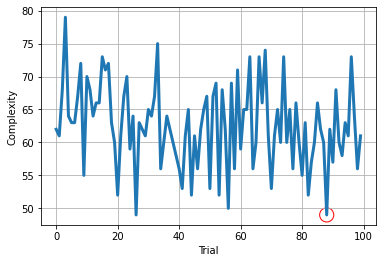

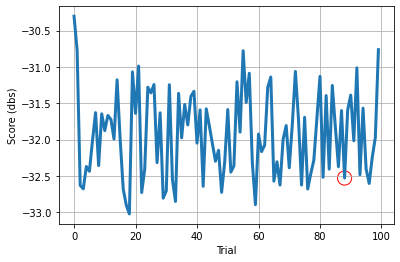

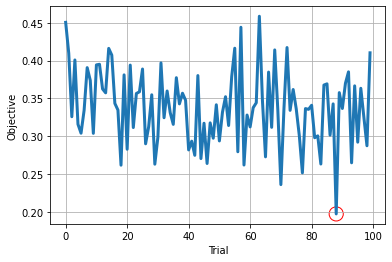

In [24]:
plt.figure()
plt.plot(COMP, linewidth=3)
plt.xlabel('Trial')
plt.ylabel('Complexity')
plt.grid()
plt.scatter(88, COMP[88], s=200, facecolors='none', edgecolors='r')
plt.savefig('COMP_1.png')

plt.figure()
plt.plot(SCR, linewidth=3)
plt.xlabel('Trial')
plt.ylabel('Score (dbs)')
plt.grid()
plt.scatter(88, SCR[88], s=200, facecolors='none', edgecolors='r')
plt.savefig('SCR_1.png')

J = []
for i in study.trials:
  J.append(i.value)

plt.figure()
plt.plot(J, linewidth=3)
plt.xlabel('Trial')
plt.ylabel('Objective')
plt.grid()
plt.scatter(88, J[88], s=200, facecolors='none', edgecolors='r')
plt.savefig('J_1.png')


In [26]:
class Cell_try_2(nn.Module):
    def __init__(self,M=15,D=0,Poly_order=8,Passthrough=False):
        super(Cell_try_2,self).__init__()
        self.f = AFIR(M,0)
        self.pol = Polynomial(Poly_order,Passthrough)
        self.prod = Prod_cmp()
        self.delay = Delay(D)
    def forward(self,x):
        #return self.prod(self.f(self.delay(x)), self.pol(self.delay(x)))
        return self.prod( self.f(x), self.pol(self.f(self.delay(x))) )

D = {'p': [4, 5, 6, 7, 8, 9], 'k' : [3, 5, 7, 9], 'z' : [-2, -1, 0, 1, 2]}
ex_D = {} # extremum vals of D

for key in D.keys():
  ex_D[key] = [ min(D[key]), max(D[key])]

# complex reference model
ref_model = {'k': [9,5,9,7,9],'p': [9,8,6,9,6]}

### params of the functional
score_huge = -33.88
score_min = -20.0
complex_huge = sum(ref_model['k']) + sum(ref_model['p'])
complex_min = 4 * 5 + 3 * 5
trtr_coef = 0.4

COMP_2 = []
SCR_2 = []
zz = [-3,-2,-1,2,3]
def objective(trial):
  # create and train NN
  net = torch.nn.ModuleList()

  complex_cur = 0
  for i in range(5):
    # det hyperparams 
    poly_ord = trial.suggest_int('p'+str(i), ex_D['p'][0], ex_D['p'][1])
    conv_ord = trial.suggest_int('k'+str(i), ex_D['k'][0], ex_D['k'][1], step=2)
    net.append(Cell_try_2(M=conv_ord, D=zz[i], Poly_order=poly_ord))
    complex_cur = complex_cur + poly_ord + conv_ord


  net = net.to(torch.device('cpu'))
  optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
  train(train_queue, valid_queue, net, loss_fn, optimizer,20,scheduler,save_flag=False)

  loss_cur, accuracy_cur = eval_model(valid_queue, net, loss_fn)
  score_cur = accuracy_cur.item()
  
  COMP_2.append(complex_cur)
  SCR_2.append(score_cur)

  return score_cur
  #return  (complex_cur - complex_min) / (complex_huge - complex_min) + trtr_coef * (score_huge - score_cur) / (score_huge - score_min)

study_2 = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction="minimize", pruner=optuna.pruners.HyperbandPruner())

study_2.optimize(objective, n_trials=100)
print(study_2.best_params)

[I 2022-10-29 10:54:28,843] A new study created in memory with name: no-name-b9e68937-3a76-415c-9167-bfa488aa2cd8
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.257128811421722e-05 Accuracy =  -26.437751814180125 dbs
Loss =  4.9047034414353284e-05 Accuracy =  -28.13927259861281 dbs
Loss =  3.8151470464532127e-05 Accuracy =  -29.230287315992886 dbs
Loss =  3.363796275806344e-05 Accuracy =  -29.777103277285807 dbs
Loss =  2.7763868986105104e-05 Accuracy =  -30.61060026779566 dbs
Loss =  2.6952631862967133e-05 Accuracy =  -30.739388336805003 dbs
Loss =  2.2225959991304384e-05 Accuracy =  -31.576794848946243 dbs
Loss =  2.026975616823421e-05 Accuracy =  -31.976914886896108 dbs
Loss =  1.9503355947478316e-05 Accuracy =  -32.144306661826654 dbs
Loss =  1.9240279992174145e-05 Accuracy =  -32.203286253654746 dbs
Loss =  1.9000639432558773e-05 Accuracy =  -32.25771796535247 dbs
Loss =  1.844215922459753e-05 Accuracy =  -32.38728245855316 dbs
Loss =  1.8428801565368314e-05 Accuracy =  -32.39042919399151 dbs
Loss =  1.820937219454513e-05 Accuracy =  -32.442450402785454 dbs
Loss =  1.7982451122662523e-05 Accuracy =  -32.496911246015266 dbs
Loss 

[I 2022-10-29 10:55:21,464] Trial 0 finished with value: -32.45082814593551 and parameters: {'p0': 7, 'k0': 7, 'p1': 5, 'k1': 9, 'p2': 7, 'k2': 5, 'p3': 8, 'k3': 5, 'p4': 8, 'k4': 7}. Best is trial 0 with value: -32.45082814593551.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.033721953086349e-05 Accuracy =  -26.573548167190438 dbs
Loss =  4.907702502799674e-05 Accuracy =  -28.136617845335408 dbs
Loss =  3.663137263062624e-05 Accuracy =  -29.406868205253915 dbs
Loss =  3.063841359521036e-05 Accuracy =  -30.182737386232393 dbs
Loss =  2.6063800603428704e-05 Accuracy =  -30.8850226865577 dbs
Loss =  2.1580304880598737e-05 Accuracy =  -31.704824371555883 dbs
Loss =  2.1034248041189075e-05 Accuracy =  -31.816130222145556 dbs
Loss =  2.054343467339153e-05 Accuracy =  -31.918669577624776 dbs
Loss =  2.1668388127648815e-05 Accuracy =  -31.6871340700119 dbs
Loss =  2.2200113931519608e-05 Accuracy =  -31.581848098724457 dbs
Loss =  2.0250551214421947e-05 Accuracy =  -31.98103164050888 dbs
Loss =  2.1865135741456353e-05 Accuracy =  -31.647878352956575 dbs
Loss =  2.2151372962249617e-05 Accuracy =  -31.591393637781145 dbs
Loss =  2.235090146001132e-05 Accuracy =  -31.552449692852033 dbs
Loss =  2.3028194920652197e-05 Accuracy =  -31.42280116282611 dbs
Loss = 

[I 2022-10-29 10:56:13,775] Trial 1 finished with value: -31.36536208294472 and parameters: {'p0': 6, 'k0': 7, 'p1': 8, 'k1': 9, 'p2': 8, 'k2': 5, 'p3': 6, 'k3': 5, 'p4': 9, 'k4': 3}. Best is trial 0 with value: -32.45082814593551.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.548106524752993e-05 Accuracy =  -26.884242772281954 dbs
Loss =  4.813797982470494e-05 Accuracy =  -28.220521525712133 dbs
Loss =  3.92885230085513e-05 Accuracy =  -29.102743106513287 dbs
Loss =  4.148522684382255e-05 Accuracy =  -28.866465439552336 dbs
Loss =  3.475574498836171e-05 Accuracy =  -29.635134111037978 dbs
Loss =  3.3168753058886196e-05 Accuracy =  -29.83810868113614 dbs
Loss =  2.957264630653158e-05 Accuracy =  -30.336498240571018 dbs
Loss =  2.7846517451726098e-05 Accuracy =  -30.597691240801357 dbs
Loss =  2.372637652761791e-05 Accuracy =  -31.293085949472662 dbs
Loss =  2.17352367908212e-05 Accuracy =  -31.673756372389374 dbs
Loss =  2.1004558630684077e-05 Accuracy =  -31.822264530094703 dbs
Loss =  2.3005259030433954e-05 Accuracy =  -31.427128855201385 dbs
Loss =  2.4744548520377884e-05 Accuracy =  -31.110604788910436 dbs
Loss =  2.4121088170236833e-05 Accuracy =  -31.221431169809982 dbs
Loss =  2.2597343947246834e-05 Accuracy =  -31.50482617214264 dbs
Loss = 

[I 2022-10-29 10:57:06,168] Trial 2 finished with value: -32.02281631041864 and parameters: {'p0': 9, 'k0': 5, 'p1': 9, 'k1': 5, 'p2': 7, 'k2': 9, 'p3': 4, 'k3': 5, 'p4': 8, 'k4': 9}. Best is trial 0 with value: -32.45082814593551.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.68339835210676e-05 Accuracy =  -26.79542665890963 dbs
Loss =  4.656935990917572e-05 Accuracy =  -28.36439744495561 dbs
Loss =  3.392160834938697e-05 Accuracy =  -29.74063577551977 dbs
Loss =  3.963980588338704e-05 Accuracy =  -29.064084940654794 dbs
Loss =  3.3592327078145824e-05 Accuracy =  -29.78299922896426 dbs
Loss =  3.031804095408837e-05 Accuracy =  -30.22838877864436 dbs
Loss =  2.7844781310310987e-05 Accuracy =  -30.597962017979622 dbs
Loss =  2.638484215699699e-05 Accuracy =  -30.83185512713345 dbs
Loss =  2.6187110278493902e-05 Accuracy =  -30.864524360323408 dbs
Loss =  2.5564602466729616e-05 Accuracy =  -30.9690096936557 dbs
Loss =  2.4965012720909252e-05 Accuracy =  -31.072082214528365 dbs
Loss =  2.5071506367746962e-05 Accuracy =  -31.053595847428966 dbs
Loss =  2.4818373200364192e-05 Accuracy =  -31.097667022634976 dbs
Loss =  2.4510945644250403e-05 Accuracy =  -31.151799462700932 dbs
Loss =  2.4172061378148764e-05 Accuracy =  -31.212263247920873 dbs
Loss =  2.

[I 2022-10-29 10:57:55,982] Trial 3 finished with value: -31.276242752167104 and parameters: {'p0': 4, 'k0': 5, 'p1': 9, 'k1': 5, 'p2': 9, 'k2': 9, 'p3': 4, 'k3': 9, 'p4': 6, 'k4': 9}. Best is trial 0 with value: -32.45082814593551.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.562945569008326e-05 Accuracy =  -26.258490383757067 dbs
Loss =  4.743043169963725e-05 Accuracy =  -28.28482935631584 dbs
Loss =  3.458378272781443e-05 Accuracy =  -29.656675190540728 dbs
Loss =  3.3411593512420934e-05 Accuracy =  -29.806428240269724 dbs
Loss =  3.209977613143041e-05 Accuracy =  -29.98038009556838 dbs
Loss =  2.9518436807975682e-05 Accuracy =  -30.344466580785237 dbs
Loss =  2.955936835638309e-05 Accuracy =  -30.338448636007488 dbs
Loss =  2.8992272172045717e-05 Accuracy =  -30.422577600770275 dbs
Loss =  2.7484483502154238e-05 Accuracy =  -30.65452433171054 dbs
Loss =  2.486950318982474e-05 Accuracy =  -31.08872903545041 dbs
Loss =  2.3871246668780507e-05 Accuracy =  -31.266649126389538 dbs
Loss =  2.404792009107287e-05 Accuracy =  -31.2346249301214 dbs
Loss =  2.352131142638624e-05 Accuracy =  -31.33078481050552 dbs
Loss =  2.1961226845228113e-05 Accuracy =  -31.628834151915555 dbs
Loss =  2.260609474582002e-05 Accuracy =  -31.503144696710706 dbs
Loss =  2.2

[I 2022-10-29 10:58:43,435] Trial 4 finished with value: -30.940697729916845 and parameters: {'p0': 7, 'k0': 9, 'p1': 5, 'k1': 5, 'p2': 6, 'k2': 5, 'p3': 9, 'k3': 7, 'p4': 4, 'k4': 9}. Best is trial 0 with value: -32.45082814593551.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.854926335428487e-05 Accuracy =  -26.685372210135743 dbs
Loss =  4.74002088015184e-05 Accuracy =  -28.287597583600856 dbs
Loss =  3.6983251604913426e-05 Accuracy =  -29.365349210263084 dbs
Loss =  3.4067795718790945e-05 Accuracy =  -29.721959787234514 dbs
Loss =  3.1988812571317394e-05 Accuracy =  -29.99541893820172 dbs
Loss =  2.8895865745920842e-05 Accuracy =  -30.437043022910313 dbs
Loss =  2.6934563599824247e-05 Accuracy =  -30.742300697415796 dbs
Loss =  2.6295380778947285e-05 Accuracy =  -30.846605489988363 dbs
Loss =  2.600983585319648e-05 Accuracy =  -30.894024017452878 dbs
Loss =  2.511296004069981e-05 Accuracy =  -31.04642107531278 dbs
Loss =  2.3615250349718143e-05 Accuracy =  -31.313474591638006 dbs
Loss =  2.2020478109372083e-05 Accuracy =  -31.617132689838385 dbs
Loss =  2.0120486745703216e-05 Accuracy =  -32.00901530372152 dbs
Loss =  2.1031307193842493e-05 Accuracy =  -31.816737461854952 dbs
Loss =  2.1051510668850392e-05 Accuracy =  -31.81256746619832 dbs
Loss

[I 2022-10-29 10:59:31,562] Trial 5 finished with value: -32.189254850618816 and parameters: {'p0': 5, 'k0': 5, 'p1': 6, 'k1': 5, 'p2': 7, 'k2': 9, 'p3': 6, 'k3': 9, 'p4': 8, 'k4': 5}. Best is trial 0 with value: -32.45082814593551.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.392789529141496e-05 Accuracy =  -25.806336809438953 dbs
Loss =  5.550858266295467e-05 Accuracy =  -27.601798747909477 dbs
Loss =  4.5044168153626065e-05 Accuracy =  -28.509014420775994 dbs
Loss =  4.0728547948881744e-05 Accuracy =  -28.946410862106493 dbs
Loss =  3.5479073103326564e-05 Accuracy =  -29.545677478460757 dbs
Loss =  3.135685464178484e-05 Accuracy =  -30.082075203578267 dbs
Loss =  2.952574734216582e-05 Accuracy =  -30.34339114051268 dbs
Loss =  3.0150940278080794e-05 Accuracy =  -30.252391526751676 dbs
Loss =  2.9936023247220124e-05 Accuracy =  -30.283459057252816 dbs
Loss =  2.96638585957583e-05 Accuracy =  -30.323123709016357 dbs
Loss =  2.768034581463254e-05 Accuracy =  -30.623685016150812 dbs
Loss =  2.8087365929217182e-05 Accuracy =  -30.5602900074528 dbs
Loss =  2.7961775547529648e-05 Accuracy =  -30.57975267881373 dbs
Loss =  2.7765223669176096e-05 Accuracy =  -30.61038836756303 dbs
Loss =  2.7461915810746757e-05 Accuracy =  -30.65809181730423 dbs
Loss =  

[I 2022-10-29 11:00:20,416] Trial 6 finished with value: -31.125734331833055 and parameters: {'p0': 7, 'k0': 9, 'p1': 4, 'k1': 9, 'p2': 6, 'k2': 3, 'p3': 9, 'k3': 3, 'p4': 4, 'k4': 5}. Best is trial 0 with value: -32.45082814593551.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.9204619863108e-05 Accuracy =  -26.644049257037 dbs
Loss =  4.300577898844156e-05 Accuracy =  -28.710131944390778 dbs
Loss =  3.8976954472128024e-05 Accuracy =  -29.137321113385234 dbs
Loss =  3.780376080930286e-05 Accuracy =  -29.2700500648961 dbs
Loss =  3.786402531701058e-05 Accuracy =  -29.263132312963403 dbs
Loss =  2.8986395847095655e-05 Accuracy =  -30.423457943694878 dbs
Loss =  3.1390417146074786e-05 Accuracy =  -30.07742926077096 dbs
Loss =  3.198712282323328e-05 Accuracy =  -29.995648352047528 dbs
Loss =  3.2006617488732745e-05 Accuracy =  -29.9930023351485 dbs
Loss =  3.125326712025096e-05 Accuracy =  -30.09644589278269 dbs
Loss =  2.565807124070085e-05 Accuracy =  -30.953160065011783 dbs
Loss =  2.957031394673077e-05 Accuracy =  -30.33684077702421 dbs
Loss =  2.895040475068254e-05 Accuracy =  -30.428853732353982 dbs
Loss =  2.9174227297479245e-05 Accuracy =  -30.39540650902201 dbs
Loss =  2.933794929227367e-05 Accuracy =  -30.37110259533652 dbs
Loss =  2.512917324

[I 2022-10-29 11:01:09,647] Trial 7 finished with value: -30.390005053879904 and parameters: {'p0': 8, 'k0': 9, 'p1': 8, 'k1': 5, 'p2': 5, 'k2': 7, 'p3': 8, 'k3': 3, 'p4': 4, 'k4': 3}. Best is trial 0 with value: -32.45082814593551.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.680434312326842e-05 Accuracy =  -26.191542339776287 dbs
Loss =  4.197916911223257e-05 Accuracy =  -28.815061747364638 dbs
Loss =  3.340003556008373e-05 Accuracy =  -29.807930839455494 dbs
Loss =  2.956356169271397e-05 Accuracy =  -30.33783258303758 dbs
Loss =  2.9956700752571237e-05 Accuracy =  -30.280460320100598 dbs
Loss =  2.711997702559995e-05 Accuracy =  -30.71250695851318 dbs
Loss =  2.7492569111786008e-05 Accuracy =  -30.65324687666184 dbs
Loss =  2.7373434914177738e-05 Accuracy =  -30.6721071552114 dbs
Loss =  2.752176215012952e-05 Accuracy =  -30.648637758869523 dbs
Loss =  2.75429824419235e-05 Accuracy =  -30.645290478806757 dbs
Loss =  2.4837148271281015e-05 Accuracy =  -31.094382831937374 dbs
Loss =  2.6480523218380464e-05 Accuracy =  -30.81613451230004 dbs
Loss =  2.6310790368171007e-05 Accuracy =  -30.844061187822383 dbs
Loss =  2.5857787607321677e-05 Accuracy =  -30.91948649246731 dbs
Loss =  2.4975161805083574e-05 Accuracy =  -31.0703170259379 dbs
Loss =  2.42

[I 2022-10-29 11:02:01,721] Trial 8 finished with value: -31.98413394864884 and parameters: {'p0': 6, 'k0': 7, 'p1': 8, 'k1': 5, 'p2': 7, 'k2': 5, 'p3': 9, 'k3': 9, 'p4': 7, 'k4': 7}. Best is trial 0 with value: -32.45082814593551.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.325079396162524e-05 Accuracy =  -27.034740317335626 dbs
Loss =  4.0229700333644555e-05 Accuracy =  -28.99993215564287 dbs
Loss =  2.7809315560832826e-05 Accuracy =  -30.603497129407465 dbs
Loss =  2.568682596721265e-05 Accuracy =  -30.9482956983318 dbs
Loss =  2.247852660691332e-05 Accuracy =  -31.527721718757775 dbs
Loss =  2.085841465723319e-05 Accuracy =  -31.852587163241537 dbs
Loss =  2.0433348117922668e-05 Accuracy =  -31.942004791050536 dbs
Loss =  2.109810663922428e-05 Accuracy =  -31.802965300224628 dbs
Loss =  2.0852218462287214e-05 Accuracy =  -31.853877468898574 dbs
Loss =  2.0522245143672642e-05 Accuracy =  -31.923151420705782 dbs
Loss =  1.9442652516415234e-05 Accuracy =  -32.15784498707851 dbs
Loss =  1.9926114480270704e-05 Accuracy =  -32.05117392024179 dbs
Loss =  1.984320260361155e-05 Accuracy =  -32.06928246488239 dbs
Loss =  1.977029982568771e-05 Accuracy =  -32.08526757499418 dbs
Loss =  1.9928064262751106e-05 Accuracy =  -32.05074898122684 dbs
Loss =  1.

[I 2022-10-29 11:02:55,634] Trial 9 finished with value: -32.04889231141957 and parameters: {'p0': 9, 'k0': 7, 'p1': 8, 'k1': 9, 'p2': 9, 'k2': 7, 'p3': 6, 'k3': 7, 'p4': 6, 'k4': 3}. Best is trial 0 with value: -32.45082814593551.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.611402045639455e-05 Accuracy =  -26.842464453145084 dbs
Loss =  4.890324110578543e-05 Accuracy =  -28.15202369808138 dbs
Loss =  4.432750143514593e-05 Accuracy =  -28.578667606010004 dbs
Loss =  4.2704724554360326e-05 Accuracy =  -28.74064088127978 dbs
Loss =  3.75907930714744e-05 Accuracy =  -29.29458524803513 dbs
Loss =  3.7287456919629496e-05 Accuracy =  -29.32977248533847 dbs
Loss =  3.826561303368888e-05 Accuracy =  -29.21731337809007 dbs
Loss =  3.807409236711532e-05 Accuracy =  -29.239104539775266 dbs
Loss =  3.788603535941369e-05 Accuracy =  -29.260608528785337 dbs
Loss =  3.769997914378215e-05 Accuracy =  -29.281989031911863 dbs
Loss =  3.66812670474552e-05 Accuracy =  -29.400956844444302 dbs
Loss =  3.660961988810383e-05 Accuracy =  -29.409447934445623 dbs
Loss =  3.6375405416905596e-05 Accuracy =  -29.43732170750254 dbs
Loss =  3.613470491420356e-05 Accuracy =  -29.4661550063652 dbs
Loss =  3.587605058191642e-05 Accuracy =  -29.497353854801652 dbs
Loss =  3.4384645

[I 2022-10-29 11:03:43,492] Trial 10 finished with value: -29.725944308652895 and parameters: {'p0': 8, 'k0': 3, 'p1': 4, 'k1': 7, 'p2': 4, 'k2': 3, 'p3': 7, 'k3': 5, 'p4': 9, 'k4': 7}. Best is trial 0 with value: -32.45082814593551.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.475445042105325e-05 Accuracy =  -26.932703913213846 dbs
Loss =  5.033181964726902e-05 Accuracy =  -28.026973814006073 dbs
Loss =  3.8746268569940794e-05 Accuracy =  -29.163101286836838 dbs
Loss =  4.251903577929588e-05 Accuracy =  -28.759566058404236 dbs
Loss =  3.536998722969706e-05 Accuracy =  -29.55905110125412 dbs
Loss =  3.0270371990823923e-05 Accuracy =  -30.235222551297962 dbs
Loss =  3.4209322015928256e-05 Accuracy =  -29.703955460174708 dbs
Loss =  3.110691427568192e-05 Accuracy =  -30.11683080766897 dbs
Loss =  2.7862555411954298e-05 Accuracy =  -30.59519067941612 dbs
Loss =  2.5664711115259543e-05 Accuracy =  -30.95203632979515 dbs
Loss =  2.4133014225002443e-05 Accuracy =  -31.219284442537507 dbs
Loss =  2.3599155532633253e-05 Accuracy =  -31.316435505955297 dbs
Loss =  2.2992276668970658e-05 Accuracy =  -31.429580363965744 dbs
Loss =  2.2575382614251107e-05 Accuracy =  -31.50904893539503 dbs
Loss =  2.235288568459567e-05 Accuracy =  -31.552064160509726 dbs
Loss =

[I 2022-10-29 11:04:31,579] Trial 11 finished with value: -31.566495015317642 and parameters: {'p0': 4, 'k0': 3, 'p1': 6, 'k1': 3, 'p2': 8, 'k2': 7, 'p3': 7, 'k3': 7, 'p4': 8, 'k4': 5}. Best is trial 0 with value: -32.45082814593551.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.8866033914912e-05 Accuracy =  -26.66534941021046 dbs
Loss =  5.023496857098603e-05 Accuracy =  -28.035338782549864 dbs
Loss =  3.366318843949147e-05 Accuracy =  -29.77384764953961 dbs
Loss =  2.7557185396635395e-05 Accuracy =  -30.643051550964366 dbs
Loss =  2.6444480464049452e-05 Accuracy =  -30.822049739753727 dbs
Loss =  2.44637422544533e-05 Accuracy =  -31.1601712069401 dbs
Loss =  2.4744971445896058e-05 Accuracy =  -31.110530561389567 dbs
Loss =  2.3914867754417996e-05 Accuracy =  -31.258720295063686 dbs
Loss =  2.3378567928655952e-05 Accuracy =  -31.35722108525334 dbs
Loss =  2.31120420628097e-05 Accuracy =  -31.407016939065308 dbs
Loss =  2.1967865789905956e-05 Accuracy =  -31.627521465088563 dbs
Loss =  2.2437384502485473e-05 Accuracy =  -31.535677827621083 dbs
Loss =  2.2361878478392953e-05 Accuracy =  -31.550317300899117 dbs
Loss =  2.223935481486082e-05 Accuracy =  -31.574178293476905 dbs
Loss =  2.2050421459184806e-05 Accuracy =  -31.611231183982262 dbs
Loss =  2.

[I 2022-10-29 11:05:18,762] Trial 12 finished with value: -31.792082548678874 and parameters: {'p0': 5, 'k0': 5, 'p1': 6, 'k1': 7, 'p2': 7, 'k2': 9, 'p3': 5, 'k3': 9, 'p4': 7, 'k4': 7}. Best is trial 0 with value: -32.45082814593551.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.392255573372082e-05 Accuracy =  -26.357630397497548 dbs
Loss =  4.727129509236969e-05 Accuracy =  -28.29942512300308 dbs
Loss =  3.821765840211034e-05 Accuracy =  -29.222759388495852 dbs
Loss =  3.817751169367493e-05 Accuracy =  -29.22732394291028 dbs
Loss =  3.190043215034687e-05 Accuracy =  -30.007434467196198 dbs
Loss =  2.7832287038723272e-05 Accuracy =  -30.599911184290967 dbs
Loss =  3.105585620140459e-05 Accuracy =  -30.12396506012637 dbs
Loss =  2.7556785179501717e-05 Accuracy =  -30.64311462466089 dbs
Loss =  2.840291596214828e-05 Accuracy =  -30.51177084314682 dbs
Loss =  2.6226007800028807e-05 Accuracy =  -30.85807827099197 dbs
Loss =  2.7167593959978036e-05 Accuracy =  -30.704888353822113 dbs
Loss =  2.4781992632763802e-05 Accuracy =  -31.104037896045014 dbs
Loss =  2.340095414722727e-05 Accuracy =  -31.35306447505002 dbs
Loss =  2.2693406053986104e-05 Accuracy =  -31.486403290898046 dbs
Loss =  2.2249551708486452e-05 Accuracy =  -31.572187480459558 dbs
Loss =  2.

[I 2022-10-29 11:06:14,898] Trial 13 finished with value: -31.780104449675978 and parameters: {'p0': 5, 'k0': 5, 'p1': 5, 'k1': 3, 'p2': 8, 'k2': 5, 'p3': 8, 'k3': 5, 'p4': 8, 'k4': 5}. Best is trial 0 with value: -32.45082814593551.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.229403756952511e-05 Accuracy =  -27.10093532684415 dbs
Loss =  4.0107130328781425e-05 Accuracy =  -29.01318423880908 dbs
Loss =  3.628229798270323e-05 Accuracy =  -29.44845227319343 dbs
Loss =  3.3250115984662855e-05 Accuracy =  -29.827468485697647 dbs
Loss =  3.1005731331397634e-05 Accuracy =  -30.130980336418514 dbs
Loss =  2.8548530860377265e-05 Accuracy =  -30.489562492658987 dbs
Loss =  2.7860646787207083e-05 Accuracy =  -30.595488187514487 dbs
Loss =  2.6997744632323262e-05 Accuracy =  -30.73212528040619 dbs
Loss =  2.714091739918509e-05 Accuracy =  -30.70915489834354 dbs
Loss =  2.7333106085852868e-05 Accuracy =  -30.67851026184387 dbs
Loss =  2.6173036254590674e-05 Accuracy =  -30.86685906389903 dbs
Loss =  2.7349555758659445e-05 Accuracy =  -30.675897366968773 dbs
Loss =  2.6426067111956536e-05 Accuracy =  -30.82507479544059 dbs
Loss =  2.7437304019160773e-05 Accuracy =  -30.661985776462387 dbs
Loss =  2.66636136084548e-05 Accuracy =  -30.786210059503645 dbs
Loss =  

[I 2022-10-29 11:07:05,763] Trial 14 finished with value: -30.716008570987064 and parameters: {'p0': 5, 'k0': 7, 'p1': 5, 'k1': 7, 'p2': 5, 'k2': 7, 'p3': 8, 'k3': 7, 'p4': 8, 'k4': 5}. Best is trial 0 with value: -32.45082814593551.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.960283005561403e-05 Accuracy =  -26.03611505002787 dbs
Loss =  5.323176468165324e-05 Accuracy =  -27.783691494681257 dbs
Loss =  4.926856750481372e-05 Accuracy =  -28.119700778942644 dbs
Loss =  4.37414941970684e-05 Accuracy =  -28.636463988068883 dbs
Loss =  4.066325353757741e-05 Accuracy =  -28.9533788879012 dbs
Loss =  3.8449298548480714e-05 Accuracy =  -29.196515919998753 dbs
Loss =  3.6979903309120984e-05 Accuracy =  -29.36574241858123 dbs
Loss =  3.627494319117259e-05 Accuracy =  -29.44933272160535 dbs
Loss =  3.565491453481876e-05 Accuracy =  -29.524206133615895 dbs
Loss =  3.457072326812563e-05 Accuracy =  -29.6583154745006 dbs
Loss =  3.34513291818832e-05 Accuracy =  -29.801266340873653 dbs
Loss =  3.2537863985337474e-05 Accuracy =  -29.92150973751894 dbs
Loss =  3.147138857418358e-05 Accuracy =  -30.06624107950094 dbs
Loss =  3.0477316978470537e-05 Accuracy =  -30.20563281203688 dbs
Loss =  2.962272366064882e-05 Accuracy =  -30.32915025921314 dbs
Loss =  2.785104981

[I 2022-10-29 11:07:58,561] Trial 15 finished with value: -30.77163741987142 and parameters: {'p0': 6, 'k0': 3, 'p1': 7, 'k1': 7, 'p2': 6, 'k2': 3, 'p3': 5, 'k3': 3, 'p4': 7, 'k4': 7}. Best is trial 0 with value: -32.45082814593551.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.932543449255903e-05 Accuracy =  -26.636474129682817 dbs
Loss =  4.8548284719113707e-05 Accuracy =  -28.183661228735883 dbs
Loss =  3.711924628033327e-05 Accuracy =  -29.349408640080895 dbs
Loss =  3.421920811696813e-05 Accuracy =  -29.70270058033126 dbs
Loss =  4.089325484078338e-05 Accuracy =  -28.928883341534217 dbs
Loss =  3.645851003080027e-05 Accuracy =  -29.427410969990717 dbs
Loss =  3.1496985747312686e-05 Accuracy =  -30.06271019220254 dbs
Loss =  3.0019695785747487e-05 Accuracy =  -30.271337262719573 dbs
Loss =  2.954803315289011e-05 Accuracy =  -30.340114355109634 dbs
Loss =  2.9392183586308366e-05 Accuracy =  -30.363081615246767 dbs
Loss =  2.6738647218415123e-05 Accuracy =  -30.774005818071622 dbs
Loss =  2.7521004802370503e-05 Accuracy =  -30.64875727028614 dbs
Loss =  2.7562019180290028e-05 Accuracy =  -30.64228982532285 dbs
Loss =  2.770235381190411e-05 Accuracy =  -30.620233413993336 dbs
Loss =  2.76016918557275e-05 Accuracy =  -30.63604310019441 dbs
Loss =  2

[I 2022-10-29 11:08:56,791] Trial 16 finished with value: -31.395915946996773 and parameters: {'p0': 7, 'k0': 5, 'p1': 6, 'k1': 3, 'p2': 8, 'k2': 9, 'p3': 7, 'k3': 9, 'p4': 9, 'k4': 5}. Best is trial 0 with value: -32.45082814593551.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.823790447054997e-05 Accuracy =  -26.70514331597642 dbs
Loss =  4.003329727101962e-05 Accuracy =  -29.02118651671065 dbs
Loss =  3.622766172202458e-05 Accuracy =  -29.45499709299801 dbs
Loss =  3.251025384613567e-05 Accuracy =  -29.925196525767323 dbs
Loss =  2.988968329273612e-05 Accuracy =  -30.290186998037104 dbs
Loss =  2.820939180199515e-05 Accuracy =  -30.541462903254303 dbs
Loss =  2.766531695085895e-05 Accuracy =  -30.62604363015612 dbs
Loss =  2.7016395392633036e-05 Accuracy =  -30.72912609441378 dbs
Loss =  2.7427760929072268e-05 Accuracy =  -30.663496578066813 dbs
Loss =  2.7935889331542104e-05 Accuracy =  -30.583775115739762 dbs
Loss =  2.4780772275086847e-05 Accuracy =  -31.104251764099445 dbs
Loss =  2.7088545914418867e-05 Accuracy =  -30.717543199655864 dbs
Loss =  2.751808353139884e-05 Accuracy =  -30.649218285140396 dbs
Loss =  2.6922168651981036e-05 Accuracy =  -30.74429972606895 dbs
Loss =  2.4995979245672703e-05 Accuracy =  -31.066698577406164 dbs
Loss =  2

[I 2022-10-29 11:09:48,041] Trial 17 finished with value: -31.38686659252212 and parameters: {'p0': 8, 'k0': 7, 'p1': 7, 'k1': 9, 'p2': 5, 'k2': 7, 'p3': 6, 'k3': 7, 'p4': 5, 'k4': 7}. Best is trial 0 with value: -32.45082814593551.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.282544760872746e-05 Accuracy =  -26.42256850516455 dbs
Loss =  5.0477764965084046e-05 Accuracy =  -28.014398959995365 dbs
Loss =  4.168333852044097e-05 Accuracy =  -28.84577517747738 dbs
Loss =  3.065023838553887e-05 Accuracy =  -30.181061564987488 dbs
Loss =  2.9278194338281778e-05 Accuracy =  -30.379957239865316 dbs
Loss =  2.4683220331191484e-05 Accuracy =  -31.1213819323808 dbs
Loss =  2.19857997643657e-05 Accuracy =  -31.623977448233333 dbs
Loss =  2.1338511210145628e-05 Accuracy =  -31.753758977583303 dbs
Loss =  2.263986112355239e-05 Accuracy =  -31.496662546443936 dbs
Loss =  2.2485572730308904e-05 Accuracy =  -31.52636059173436 dbs
Loss =  2.103959593769223e-05 Accuracy =  -31.81502618137629 dbs
Loss =  2.100396797651558e-05 Accuracy =  -31.822386656656537 dbs
Loss =  1.974643546030419e-05 Accuracy =  -32.090513030310824 dbs
Loss =  1.927298690655177e-05 Accuracy =  -32.19590986780496 dbs
Loss =  1.8945598897079003e-05 Accuracy =  -32.27031674649967 dbs
Loss =  1.901

[I 2022-10-29 11:10:39,096] Trial 18 finished with value: -32.49061964669629 and parameters: {'p0': 5, 'k0': 5, 'p1': 5, 'k1': 7, 'p2': 7, 'k2': 5, 'p3': 5, 'k3': 5, 'p4': 8, 'k4': 5}. Best is trial 18 with value: -32.49061964669629.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.377052443428434e-05 Accuracy =  -26.36657142271924 dbs
Loss =  5.1384726691527084e-05 Accuracy =  -27.937059622227927 dbs
Loss =  3.9288741780361094e-05 Accuracy =  -29.102718923592175 dbs
Loss =  3.30946085561601e-05 Accuracy =  -29.847827645297073 dbs
Loss =  3.0126998719956063e-05 Accuracy =  -30.255841441364332 dbs
Loss =  2.879487395835374e-05 Accuracy =  -30.452248312731886 dbs
Loss =  2.800780527484297e-05 Accuracy =  -30.572609348172755 dbs
Loss =  2.555632159845217e-05 Accuracy =  -30.97041668521365 dbs
Loss =  2.3771923814177737e-05 Accuracy =  -31.284756834056175 dbs
Loss =  2.2300932547941086e-05 Accuracy =  -31.562169890160856 dbs
Loss =  2.1002291091613545e-05 Accuracy =  -31.82273339634547 dbs
Loss =  2.043769120494057e-05 Accuracy =  -31.941081800705952 dbs
Loss =  1.957590559114262e-05 Accuracy =  -32.12818151264813 dbs
Loss =  1.931733181417381e-05 Accuracy =  -32.18592873378165 dbs
Loss =  1.9109899037143962e-05 Accuracy =  -32.23281620574749 dbs
Loss =  1.

[I 2022-10-29 11:11:30,045] Trial 19 finished with value: -32.33331585045033 and parameters: {'p0': 4, 'k0': 7, 'p1': 4, 'k1': 9, 'p2': 6, 'k2': 5, 'p3': 5, 'k3': 5, 'p4': 7, 'k4': 7}. Best is trial 18 with value: -32.49061964669629.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.756983333315392e-05 Accuracy =  -25.621854899988797 dbs
Loss =  5.1641824873139156e-05 Accuracy =  -27.91538432558662 dbs
Loss =  4.447503772142777e-05 Accuracy =  -28.56423688036302 dbs
Loss =  4.084738998466484e-05 Accuracy =  -28.9337570138813 dbs
Loss =  3.755860957886195e-05 Accuracy =  -29.298305068449267 dbs
Loss =  3.6959248361394936e-05 Accuracy =  -29.368168827284087 dbs
Loss =  3.56135266668006e-05 Accuracy =  -29.5292503086857 dbs
Loss =  3.376604336977768e-05 Accuracy =  -29.760598391878975 dbs
Loss =  3.212661882465913e-05 Accuracy =  -29.97674992630997 dbs
Loss =  3.115588418875515e-05 Accuracy =  -30.109999323078895 dbs
Loss =  3.053551536092742e-05 Accuracy =  -30.19734758971452 dbs
Loss =  2.928458042674136e-05 Accuracy =  -30.379010070609397 dbs
Loss =  2.867956372044766e-05 Accuracy =  -30.469674726714928 dbs
Loss =  2.822375940305385e-05 Accuracy =  -30.539251518683514 dbs
Loss =  2.7759853889644135e-05 Accuracy =  -30.611228372018516 dbs
Loss =  2.879714

[I 2022-10-29 11:12:20,227] Trial 20 finished with value: -30.787953865846795 and parameters: {'p0': 6, 'k0': 3, 'p1': 5, 'k1': 7, 'p2': 4, 'k2': 3, 'p3': 5, 'k3': 3, 'p4': 9, 'k4': 3}. Best is trial 18 with value: -32.49061964669629.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.377052443428434e-05 Accuracy =  -26.36657142271924 dbs
Loss =  5.1384726691527084e-05 Accuracy =  -27.937059622227927 dbs
Loss =  3.9288741780361094e-05 Accuracy =  -29.102718923592175 dbs
Loss =  3.30946085561601e-05 Accuracy =  -29.847827645297073 dbs
Loss =  3.0126998719956063e-05 Accuracy =  -30.255841441364332 dbs
Loss =  2.879487395835374e-05 Accuracy =  -30.452248312731886 dbs
Loss =  2.800780527484297e-05 Accuracy =  -30.572609348172755 dbs
Loss =  2.555632159845217e-05 Accuracy =  -30.97041668521365 dbs
Loss =  2.3771923814177737e-05 Accuracy =  -31.284756834056175 dbs
Loss =  2.2300932547941086e-05 Accuracy =  -31.562169890160856 dbs
Loss =  2.1002291091613545e-05 Accuracy =  -31.82273339634547 dbs
Loss =  2.043769120494057e-05 Accuracy =  -31.941081800705952 dbs
Loss =  1.957590559114262e-05 Accuracy =  -32.12818151264813 dbs
Loss =  1.931733181417381e-05 Accuracy =  -32.18592873378165 dbs
Loss =  1.9109899037143962e-05 Accuracy =  -32.23281620574749 dbs
Loss =  1.

[I 2022-10-29 11:13:09,986] Trial 21 finished with value: -32.33331585045033 and parameters: {'p0': 4, 'k0': 7, 'p1': 4, 'k1': 9, 'p2': 6, 'k2': 5, 'p3': 5, 'k3': 5, 'p4': 7, 'k4': 7}. Best is trial 18 with value: -32.49061964669629.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.258887003768432e-05 Accuracy =  -26.43669977173576 dbs
Loss =  5.973560733955839e-05 Accuracy =  -27.283067295596034 dbs
Loss =  4.187370379887334e-05 Accuracy =  -28.82598636477754 dbs
Loss =  3.8441749448225464e-05 Accuracy =  -29.19736869354786 dbs
Loss =  3.1840163159624436e-05 Accuracy =  -30.015647285973202 dbs
Loss =  2.8271128698790666e-05 Accuracy =  -30.531968654954657 dbs
Loss =  2.524255084542208e-05 Accuracy =  -31.024067734176914 dbs
Loss =  2.4173362638592014e-05 Accuracy =  -31.212029459411763 dbs
Loss =  2.128974468236785e-05 Accuracy =  -31.763695599530987 dbs
Loss =  2.04156043446147e-05 Accuracy =  -31.94577772663684 dbs
Loss =  2.006373181698828e-05 Accuracy =  -32.02128298971007 dbs
Loss =  2.0174172044986896e-05 Accuracy =  -31.997442929747713 dbs
Loss =  2.0222539554904255e-05 Accuracy =  -31.987043195776188 dbs
Loss =  1.9720463531097614e-05 Accuracy =  -32.096228942862986 dbs
Loss =  1.926364001024084e-05 Accuracy =  -32.19801659374084 dbs
Loss =  1.

[I 2022-10-29 11:13:59,896] Trial 22 finished with value: -32.337965797412934 and parameters: {'p0': 4, 'k0': 7, 'p1': 4, 'k1': 9, 'p2': 7, 'k2': 5, 'p3': 4, 'k3': 5, 'p4': 6, 'k4': 7}. Best is trial 18 with value: -32.49061964669629.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.058987257248829e-05 Accuracy =  -26.55797615222397 dbs
Loss =  4.965665594330503e-05 Accuracy =  -28.085625438779257 dbs
Loss =  4.185229457970713e-05 Accuracy =  -28.82820739674573 dbs
Loss =  3.9538235653586576e-05 Accuracy =  -29.075227275996323 dbs
Loss =  3.444100026544483e-05 Accuracy =  -29.674642570161996 dbs
Loss =  2.7733686499080303e-05 Accuracy =  -30.615324111483094 dbs
Loss =  2.5203846088218027e-05 Accuracy =  -31.030731942840845 dbs
Loss =  2.5939894730545513e-05 Accuracy =  -30.90571803843686 dbs
Loss =  2.6168383363138642e-05 Accuracy =  -30.86763119621894 dbs
Loss =  2.565515059820966e-05 Accuracy =  -30.953654447891456 dbs
Loss =  2.51554402455282e-05 Accuracy =  -31.03908090819636 dbs
Loss =  2.4144347007625093e-05 Accuracy =  -31.217245488906915 dbs
Loss =  2.3356788574904253e-05 Accuracy =  -31.36126883605536 dbs
Loss =  2.307207225628732e-05 Accuracy =  -31.414534099892222 dbs
Loss =  2.2464267126578473e-05 Accuracy =  -31.53047758385542 dbs
Loss =  2.

[I 2022-10-29 11:14:50,956] Trial 23 finished with value: -31.565266318323765 and parameters: {'p0': 5, 'k0': 9, 'p1': 5, 'k1': 9, 'p2': 7, 'k2': 5, 'p3': 4, 'k3': 5, 'p4': 6, 'k4': 9}. Best is trial 18 with value: -32.49061964669629.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.172522250442734e-05 Accuracy =  -26.488681089595147 dbs
Loss =  5.935023058624087e-05 Accuracy =  -27.3111760253307 dbs
Loss =  4.242642430480088e-05 Accuracy =  -28.769035821292142 dbs
Loss =  3.287066996170896e-05 Accuracy =  -29.877314572860655 dbs
Loss =  2.8276710019189014e-05 Accuracy =  -30.53111135016156 dbs
Loss =  2.7229675685038563e-05 Accuracy =  -30.69497544366962 dbs
Loss =  2.693313412543046e-05 Accuracy =  -30.742531192821247 dbs
Loss =  2.621466405565096e-05 Accuracy =  -30.859957165937416 dbs
Loss =  2.399973868832633e-05 Accuracy =  -31.24333500045099 dbs
Loss =  2.1941519692024646e-05 Accuracy =  -31.632733091795263 dbs
Loss =  2.1313275241633326e-05 Accuracy =  -31.75889819638798 dbs
Loss =  2.1481513946582446e-05 Accuracy =  -31.72475127383054 dbs
Loss =  2.136811493967072e-05 Accuracy =  -31.747738020371337 dbs
Loss =  2.1247661008868113e-05 Accuracy =  -31.77228884251096 dbs
Loss =  2.077138079658666e-05 Accuracy =  -31.87074645519873 dbs
Loss =  2.132

[I 2022-10-29 11:15:40,023] Trial 24 finished with value: -32.1541746804349 and parameters: {'p0': 4, 'k0': 7, 'p1': 4, 'k1': 7, 'p2': 8, 'k2': 5, 'p3': 4, 'k3': 5, 'p4': 5, 'k4': 7}. Best is trial 18 with value: -32.49061964669629.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.33936156550341e-05 Accuracy =  -25.834072094063313 dbs
Loss =  5.261331581355647e-05 Accuracy =  -27.8344434023034 dbs
Loss =  4.382714708172277e-05 Accuracy =  -28.627968118660792 dbs
Loss =  4.14065808179787e-05 Accuracy =  -28.874706433749424 dbs
Loss =  3.9321215070882034e-05 Accuracy =  -29.099130835708756 dbs
Loss =  3.700674392290779e-05 Accuracy =  -29.36259138216967 dbs
Loss =  3.514459777666696e-05 Accuracy =  -29.58681435876391 dbs
Loss =  3.333707423616852e-05 Accuracy =  -29.81612530989199 dbs
Loss =  3.1787458447197196e-05 Accuracy =  -30.02284207667399 dbs
Loss =  3.0360599412742617e-05 Accuracy =  -30.222296715054647 dbs
Loss =  2.9480815704815206e-05 Accuracy =  -30.350005172894218 dbs
Loss =  2.8583325015623018e-05 Accuracy =  -30.48427265522513 dbs
Loss =  2.704725474214985e-05 Accuracy =  -30.72416821730694 dbs
Loss =  2.5550977206247566e-05 Accuracy =  -30.971324986026385 dbs
Loss =  2.4839753225837964e-05 Accuracy =  -31.093927361746346 dbs
Loss =  2.532

[I 2022-10-29 11:16:32,667] Trial 25 finished with value: -31.27567392910331 and parameters: {'p0': 7, 'k0': 5, 'p1': 5, 'k1': 9, 'p2': 7, 'k2': 3, 'p3': 4, 'k3': 3, 'p4': 5, 'k4': 5}. Best is trial 18 with value: -32.49061964669629.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.422403519801433e-05 Accuracy =  -26.339954520156567 dbs
Loss =  5.4723050195926494e-05 Accuracy =  -27.663697167082727 dbs
Loss =  4.072102082112195e-05 Accuracy =  -28.947213564959146 dbs
Loss =  3.456864034509552e-05 Accuracy =  -29.65857714945137 dbs
Loss =  3.2909381207165585e-05 Accuracy =  -29.872202967767166 dbs
Loss =  3.222728084231897e-05 Accuracy =  -29.963163494194006 dbs
Loss =  2.2878513803045734e-05 Accuracy =  -31.451122040359213 dbs
Loss =  2.5877110052799098e-05 Accuracy =  -30.91624240299678 dbs
Loss =  1.9899849821077e-05 Accuracy =  -32.056902142224935 dbs
Loss =  2.0818166105817838e-05 Accuracy =  -31.860975437374584 dbs
Loss =  1.9862673823695328e-05 Accuracy =  -32.065023022765985 dbs
Loss =  1.9773449356039386e-05 Accuracy =  -32.08457577227768 dbs
Loss =  1.9325303019563243e-05 Accuracy =  -32.184137007840214 dbs
Loss =  1.9268452672073327e-05 Accuracy =  -32.19693172534025 dbs
Loss =  1.8886694058263477e-05 Accuracy =  -32.28384067810889 dbs
Loss = 

[I 2022-10-29 11:17:25,020] Trial 26 finished with value: -32.51198179619459 and parameters: {'p0': 5, 'k0': 7, 'p1': 4, 'k1': 7, 'p2': 8, 'k2': 5, 'p3': 8, 'k3': 5, 'p4': 6, 'k4': 7}. Best is trial 26 with value: -32.51198179619459.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.212747391035879e-05 Accuracy =  -27.112563174860796 dbs
Loss =  3.8013457839399426e-05 Accuracy =  -29.246026367670297 dbs
Loss =  3.5398206561857167e-05 Accuracy =  -29.555587539381733 dbs
Loss =  3.4514608291818014e-05 Accuracy =  -29.66537064218144 dbs
Loss =  3.39213221626261e-05 Accuracy =  -29.740672415838844 dbs
Loss =  2.7773034149399945e-05 Accuracy =  -30.609166849777694 dbs
Loss =  2.9474626369675365e-05 Accuracy =  -30.350917046001488 dbs
Loss =  2.698388217678868e-05 Accuracy =  -30.734355812693753 dbs
Loss =  2.0634618035015766e-05 Accuracy =  -31.899435790247146 dbs
Loss =  1.9519318059147264e-05 Accuracy =  -32.14075372365394 dbs
Loss =  1.8994657597024436e-05 Accuracy =  -32.2590854389025 dbs
Loss =  1.8900274973965857e-05 Accuracy =  -32.2807189050989 dbs
Loss =  1.9020217132372257e-05 Accuracy =  -32.25324542658455 dbs
Loss =  1.8978658624103932e-05 Accuracy =  -32.2627449907974 dbs
Loss =  1.900783069052573e-05 Accuracy =  -32.25607458234855 dbs
Loss =  1.

[I 2022-10-29 11:18:20,300] Trial 27 finished with value: -32.382052542734066 and parameters: {'p0': 6, 'k0': 9, 'p1': 5, 'k1': 7, 'p2': 8, 'k2': 7, 'p3': 8, 'k3': 7, 'p4': 8, 'k4': 9}. Best is trial 26 with value: -32.51198179619459.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.225215069369457e-05 Accuracy =  -26.456892340905558 dbs
Loss =  4.717630529856513e-05 Accuracy =  -28.30816087849612 dbs
Loss =  3.352118253991167e-05 Accuracy =  -29.792206821331906 dbs
Loss =  2.825348175656767e-05 Accuracy =  -30.534680383462707 dbs
Loss =  2.5614098417750277e-05 Accuracy =  -30.960609392461972 dbs
Loss =  2.2231448854763654e-05 Accuracy =  -31.575722459355276 dbs
Loss =  2.118115264864812e-05 Accuracy =  -31.78590423026831 dbs
Loss =  2.1983775178204087e-05 Accuracy =  -31.624377391421273 dbs
Loss =  2.0713229502464877e-05 Accuracy =  -31.882921959566154 dbs
Loss =  1.9615670116051514e-05 Accuracy =  -32.1193686392906 dbs
Loss =  1.979055054914123e-05 Accuracy =  -32.080821372177375 dbs
Loss =  1.8729554707687627e-05 Accuracy =  -32.32012560925776 dbs
Loss =  1.8416876659234922e-05 Accuracy =  -32.393240335683736 dbs
Loss =  1.8163728551739044e-05 Accuracy =  -32.453350101850404 dbs
Loss =  1.789137331147363e-05 Accuracy =  -32.51896335583798 dbs
Loss =  

[I 2022-10-29 11:19:15,282] Trial 28 finished with value: -32.58451879477242 and parameters: {'p0': 5, 'k0': 5, 'p1': 6, 'k1': 7, 'p2': 9, 'k2': 5, 'p3': 7, 'k3': 5, 'p4': 7, 'k4': 5}. Best is trial 28 with value: -32.58451879477242.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.685661190978101e-05 Accuracy =  -26.1885877770601 dbs
Loss =  4.677319396021283e-05 Accuracy =  -28.34542985929761 dbs
Loss =  3.951186488347821e-05 Accuracy =  -29.07812485115148 dbs
Loss =  3.598877739858807e-05 Accuracy =  -29.48372919974541 dbs
Loss =  3.270131582181564e-05 Accuracy =  -29.89974785167664 dbs
Loss =  3.0226688762904046e-05 Accuracy =  -30.241494389267647 dbs
Loss =  2.857813017368547e-05 Accuracy =  -30.485062030228466 dbs
Loss =  2.6115662893443953e-05 Accuracy =  -30.876389591358983 dbs
Loss =  2.5677471896980014e-05 Accuracy =  -30.949877505656808 dbs
Loss =  2.4756044005901175e-05 Accuracy =  -31.108587671229806 dbs
Loss =  2.3367422778298456e-05 Accuracy =  -31.359291969758623 dbs
Loss =  2.326525781847269e-05 Accuracy =  -31.378321435239535 dbs
Loss =  2.2579180971615272e-05 Accuracy =  -31.50831828692168 dbs
Loss =  2.1988907102201452e-05 Accuracy =  -31.62336368647168 dbs
Loss =  2.1468242905593123e-05 Accuracy =  -31.727435126069352 dbs
Loss =  2.

[I 2022-10-29 11:20:10,292] Trial 29 finished with value: -32.04303094149612 and parameters: {'p0': 5, 'k0': 5, 'p1': 7, 'k1': 7, 'p2': 9, 'k2': 3, 'p3': 7, 'k3': 3, 'p4': 7, 'k4': 5}. Best is trial 28 with value: -32.58451879477242.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.153091809627912e-05 Accuracy =  -26.50046213907217 dbs
Loss =  4.72985453145817e-05 Accuracy =  -28.29692229093444 dbs
Loss =  3.3261332305885485e-05 Accuracy =  -29.826003719379784 dbs
Loss =  2.8197729485850836e-05 Accuracy =  -30.54325873310848 dbs
Loss =  2.585036717495112e-05 Accuracy =  -30.92073297007517 dbs
Loss =  2.2253472680955532e-05 Accuracy =  -31.571422203611622 dbs
Loss =  2.078463690951053e-05 Accuracy =  -31.867975709969812 dbs
Loss =  2.0754366040000144e-05 Accuracy =  -31.87430541120694 dbs
Loss =  2.1188586228789068e-05 Accuracy =  -31.78438032997784 dbs
Loss =  2.1303876601736064e-05 Accuracy =  -31.760813752606264 dbs
Loss =  2.022878497957304e-05 Accuracy =  -31.98570215019928 dbs
Loss =  2.062488056113634e-05 Accuracy =  -31.901485709124458 dbs
Loss =  1.9999419662682324e-05 Accuracy =  -32.035226195221405 dbs
Loss =  1.88376556981616e-05 Accuracy =  -32.295131582433065 dbs
Loss =  1.8354120179146786e-05 Accuracy =  -32.40806442086593 dbs
Loss =  1.84

[I 2022-10-29 11:21:04,378] Trial 30 finished with value: -32.56041518431843 and parameters: {'p0': 5, 'k0': 5, 'p1': 6, 'k1': 7, 'p2': 9, 'k2': 5, 'p3': 8, 'k3': 5, 'p4': 6, 'k4': 5}. Best is trial 28 with value: -32.58451879477242.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.153091809627912e-05 Accuracy =  -26.50046213907217 dbs
Loss =  4.72985453145817e-05 Accuracy =  -28.29692229093444 dbs
Loss =  3.3261332305885485e-05 Accuracy =  -29.826003719379784 dbs
Loss =  2.8197729485850836e-05 Accuracy =  -30.54325873310848 dbs
Loss =  2.585036717495112e-05 Accuracy =  -30.92073297007517 dbs
Loss =  2.2253472680955532e-05 Accuracy =  -31.571422203611622 dbs
Loss =  2.078463690951053e-05 Accuracy =  -31.867975709969812 dbs
Loss =  2.0754366040000144e-05 Accuracy =  -31.87430541120694 dbs
Loss =  2.1188586228789068e-05 Accuracy =  -31.78438032997784 dbs
Loss =  2.1303876601736064e-05 Accuracy =  -31.760813752606264 dbs
Loss =  2.022878497957304e-05 Accuracy =  -31.98570215019928 dbs
Loss =  2.062488056113634e-05 Accuracy =  -31.901485709124458 dbs
Loss =  1.9999419662682324e-05 Accuracy =  -32.035226195221405 dbs
Loss =  1.88376556981616e-05 Accuracy =  -32.295131582433065 dbs
Loss =  1.8354120179146786e-05 Accuracy =  -32.40806442086593 dbs
Loss =  1.84

[I 2022-10-29 11:22:00,089] Trial 31 finished with value: -32.56041518431843 and parameters: {'p0': 5, 'k0': 5, 'p1': 6, 'k1': 7, 'p2': 9, 'k2': 5, 'p3': 8, 'k3': 5, 'p4': 6, 'k4': 5}. Best is trial 28 with value: -32.58451879477242.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.897333839341742e-05 Accuracy =  -26.658587662600624 dbs
Loss =  4.266442696049821e-05 Accuracy =  -28.744740962781734 dbs
Loss =  3.3514519863078215e-05 Accuracy =  -29.793070111694885 dbs
Loss =  2.5950168862888706e-05 Accuracy =  -30.903998249046634 dbs
Loss =  2.3349462548868026e-05 Accuracy =  -31.36263124585334 dbs
Loss =  2.2554206939275673e-05 Accuracy =  -31.513124522856963 dbs
Loss =  2.3224953336107217e-05 Accuracy =  -31.385851630623847 dbs
Loss =  2.3578833600926924e-05 Accuracy =  -31.320176955520914 dbs
Loss =  2.3497332794625315e-05 Accuracy =  -31.335214452632684 dbs
Loss =  2.318171212750668e-05 Accuracy =  -31.393945047176572 dbs
Loss =  2.08441223445677e-05 Accuracy =  -31.85556399545058 dbs
Loss =  2.183069680054742e-05 Accuracy =  -31.654724152304556 dbs
Loss =  2.1979007366116903e-05 Accuracy =  -31.625319385703023 dbs
Loss =  2.1928745346549777e-05 Accuracy =  -31.635262289146397 dbs
Loss =  2.177139967761125e-05 Accuracy =  -31.66653662520853 dbs
Loss 

[I 2022-10-29 11:22:54,901] Trial 32 finished with value: -32.054788944330966 and parameters: {'p0': 6, 'k0': 5, 'p1': 6, 'k1': 7, 'p2': 9, 'k2': 5, 'p3': 8, 'k3': 5, 'p4': 6, 'k4': 3}. Best is trial 28 with value: -32.58451879477242.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.172798044168109e-05 Accuracy =  -26.48851410037409 dbs
Loss =  4.780563332011807e-05 Accuracy =  -28.25060937118691 dbs
Loss =  3.361091266830191e-05 Accuracy =  -29.78059707707875 dbs
Loss =  2.8447769805864223e-05 Accuracy =  -30.504917880655064 dbs
Loss =  2.7264963893340553e-05 Accuracy =  -30.689350862462184 dbs
Loss =  2.271372163516453e-05 Accuracy =  -31.482517140929893 dbs
Loss =  2.1061182277573864e-05 Accuracy =  -31.810572663168784 dbs
Loss =  2.0612508196453258e-05 Accuracy =  -31.904091717910696 dbs
Loss =  2.0804316031154252e-05 Accuracy =  -31.863865707686934 dbs
Loss =  2.1279584706042282e-05 Accuracy =  -31.765768651562407 dbs
Loss =  1.9515840088057396e-05 Accuracy =  -32.14152762273786 dbs
Loss =  1.9715236448844608e-05 Accuracy =  -32.09738023115932 dbs
Loss =  2.0380481935746266e-05 Accuracy =  -31.953255636172806 dbs
Loss =  2.1032730180478985e-05 Accuracy =  -31.816443626416007 dbs
Loss =  2.0570417114842592e-05 Accuracy =  -31.91296914985983 dbs
Loss 

[I 2022-10-29 11:23:49,619] Trial 33 finished with value: -32.40930711074222 and parameters: {'p0': 5, 'k0': 5, 'p1': 7, 'k1': 7, 'p2': 9, 'k2': 5, 'p3': 8, 'k3': 5, 'p4': 5, 'k4': 5}. Best is trial 28 with value: -32.58451879477242.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.041526172235579e-05 Accuracy =  -26.56873215310781 dbs
Loss =  5.021620514064498e-05 Accuracy =  -28.03696123334907 dbs
Loss =  3.982682230909604e-05 Accuracy =  -29.04364356708608 dbs
Loss =  3.250424785438192e-05 Accuracy =  -29.925998921853182 dbs
Loss =  2.7667608358729405e-05 Accuracy =  -30.625683936252738 dbs
Loss =  2.4708202388033193e-05 Accuracy =  -31.116988630968997 dbs
Loss =  2.3040352892869396e-05 Accuracy =  -31.42050886553512 dbs
Loss =  2.1683071519592456e-05 Accuracy =  -31.68419210847589 dbs
Loss =  2.0730297296121528e-05 Accuracy =  -31.879344827215213 dbs
Loss =  2.0309931045400405e-05 Accuracy =  -31.968315642119766 dbs
Loss =  2.0489051438225156e-05 Accuracy =  -31.93018160383052 dbs
Loss =  1.9910571011221438e-05 Accuracy =  -32.05456297889313 dbs
Loss =  1.9479243368427066e-05 Accuracy =  -32.14967929553796 dbs
Loss =  1.9385515698462176e-05 Accuracy =  -32.17062654428416 dbs
Loss =  1.9396365251294303e-05 Accuracy =  -32.16819659455834 dbs
Loss =  1

[I 2022-10-29 11:24:43,015] Trial 34 finished with value: -32.419252561664514 and parameters: {'p0': 6, 'k0': 3, 'p1': 6, 'k1': 7, 'p2': 9, 'k2': 5, 'p3': 7, 'k3': 5, 'p4': 6, 'k4': 5}. Best is trial 28 with value: -32.58451879477242.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.195565941350573e-05 Accuracy =  -26.47475055652623 dbs
Loss =  4.6301944780632786e-05 Accuracy =  -28.389407804411263 dbs
Loss =  3.321733645403322e-05 Accuracy =  -29.83175207711078 dbs
Loss =  3.229778885543826e-05 Accuracy =  -29.953672221000875 dbs
Loss =  2.621931378171229e-05 Accuracy =  -30.85918692097055 dbs
Loss =  2.3974577600001893e-05 Accuracy =  -31.247890489164675 dbs
Loss =  2.3306176738993493e-05 Accuracy =  -31.370689775992 dbs
Loss =  2.2147741287763733e-05 Accuracy =  -31.592105713505244 dbs
Loss =  2.1475914906078534e-05 Accuracy =  -31.725883386470205 dbs
Loss =  2.1006151394172255e-05 Accuracy =  -31.821935219595638 dbs
Loss =  2.138870246069105e-05 Accuracy =  -31.74355574114206 dbs
Loss =  2.0547309170714053e-05 Accuracy =  -31.91785057428977 dbs
Loss =  2.0161325207256715e-05 Accuracy =  -32.00020938178369 dbs
Loss =  1.9953445400960936e-05 Accuracy =  -32.04522116151787 dbs
Loss =  1.97684751987395e-05 Accuracy =  -32.085668409575014 dbs
Loss =  2.04

[I 2022-10-29 11:25:36,369] Trial 35 finished with value: -32.264473642522404 and parameters: {'p0': 5, 'k0': 5, 'p1': 7, 'k1': 5, 'p2': 9, 'k2': 5, 'p3': 9, 'k3': 5, 'p4': 5, 'k4': 5}. Best is trial 28 with value: -32.58451879477242.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  5.859449032131639e-05 Accuracy =  -27.366832321980212 dbs
Loss =  4.042286802185182e-05 Accuracy =  -28.979128894645477 dbs
Loss =  3.438130318334585e-05 Accuracy =  -29.682176790478483 dbs
Loss =  3.2048328812684825e-05 Accuracy =  -29.98734625347746 dbs
Loss =  2.5876512590453875e-05 Accuracy =  -30.916342676015915 dbs
Loss =  2.314559061381287e-05 Accuracy =  -31.400717458401026 dbs
Loss =  2.074255333167099e-05 Accuracy =  -31.87677797748894 dbs
Loss =  1.9831662569058077e-05 Accuracy =  -32.071808887314866 dbs
Loss =  1.960809608577084e-05 Accuracy =  -32.12104586711244 dbs
Loss =  1.9580416720760166e-05 Accuracy =  -32.12718082688755 dbs
Loss =  1.8895581240136904e-05 Accuracy =  -32.281797575046404 dbs
Loss =  1.898985297560526e-05 Accuracy =  -32.26018410809668 dbs
Loss =  1.9098748875839005e-05 Accuracy =  -32.235350947974204 dbs
Loss =  1.8727946037275938e-05 Accuracy =  -32.3204986382477 dbs
Loss =  1.835961465478514e-05 Accuracy =  -32.40676451472491 dbs
Loss =  1.8

[I 2022-10-29 11:26:32,459] Trial 36 finished with value: -32.579254714799234 and parameters: {'p0': 4, 'k0': 5, 'p1': 6, 'k1': 7, 'p2': 8, 'k2': 7, 'p3': 9, 'k3': 5, 'p4': 6, 'k4': 3}. Best is trial 28 with value: -32.58451879477242.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.0187468427152784e-05 Accuracy =  -27.250339364899503 dbs
Loss =  4.466929628224199e-05 Accuracy =  -28.54530902465378 dbs
Loss =  3.686364224914825e-05 Accuracy =  -29.379417704117536 dbs
Loss =  3.3139059567910015e-05 Accuracy =  -29.84199833444562 dbs
Loss =  2.8163987690522598e-05 Accuracy =  -30.54845867306963 dbs
Loss =  2.4841508005651493e-05 Accuracy =  -31.09362056953882 dbs
Loss =  2.3591496885203953e-05 Accuracy =  -31.31784515306809 dbs
Loss =  2.118883437812321e-05 Accuracy =  -31.784329468040063 dbs
Loss =  2.0615360093633624e-05 Accuracy =  -31.903490880049446 dbs
Loss =  2.081317664885575e-05 Accuracy =  -31.862016428845585 dbs
Loss =  1.9952502108706495e-05 Accuracy =  -32.04542647759057 dbs
Loss =  2.078083691439229e-05 Accuracy =  -31.86876979061602 dbs
Loss =  2.0201689706900284e-05 Accuracy =  -31.991523169744745 dbs
Loss =  1.9522493217178623e-05 Accuracy =  -32.14004732527223 dbs
Loss =  1.9604886002986012e-05 Accuracy =  -32.121756917978125 dbs
Loss =  

[I 2022-10-29 11:27:28,085] Trial 37 finished with value: -32.00411116942749 and parameters: {'p0': 4, 'k0': 5, 'p1': 6, 'k1': 5, 'p2': 9, 'k2': 7, 'p3': 9, 'k3': 7, 'p4': 6, 'k4': 3}. Best is trial 28 with value: -32.58451879477242.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.018358880414196e-05 Accuracy =  -26.583044412513853 dbs
Loss =  4.055170825000707e-05 Accuracy =  -28.965308594514095 dbs
Loss =  3.491393390073147e-05 Accuracy =  -29.615412277696276 dbs
Loss =  3.300326846116885e-05 Accuracy =  -29.859830610073534 dbs
Loss =  3.654866033690094e-05 Accuracy =  -29.41668550283911 dbs
Loss =  3.219850684374246e-05 Accuracy =  -29.967042807147344 dbs
Loss =  3.184579694686426e-05 Accuracy =  -30.014878914824283 dbs
Loss =  2.3447494040432456e-05 Accuracy =  -31.344435789901127 dbs
Loss =  2.2863853081372054e-05 Accuracy =  -31.453905923737047 dbs
Loss =  2.2543815007990977e-05 Accuracy =  -31.515126011302918 dbs
Loss =  2.4658562935942944e-05 Accuracy =  -31.1257225017226 dbs
Loss =  2.2026379224841564e-05 Accuracy =  -31.61596901004105 dbs
Loss =  2.1506736126101986e-05 Accuracy =  -31.719655065157095 dbs
Loss =  2.2754885261272354e-05 Accuracy =  -31.474653631674585 dbs
Loss =  2.0556659963449976e-05 Accuracy =  -31.91587461048762 dbs
Loss = 

[I 2022-10-29 11:28:21,168] Trial 38 finished with value: -31.8258860713945 and parameters: {'p0': 4, 'k0': 5, 'p1': 6, 'k1': 7, 'p2': 9, 'k2': 7, 'p3': 9, 'k3': 3, 'p4': 7, 'k4': 3}. Best is trial 28 with value: -32.58451879477242.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.048438957000149e-05 Accuracy =  -26.56447070250636 dbs
Loss =  4.74966187026958e-05 Accuracy =  -28.278773199564263 dbs
Loss =  4.045454501148504e-05 Accuracy =  -28.975726920722593 dbs
Loss =  3.704293137998683e-05 Accuracy =  -29.35834666020152 dbs
Loss =  3.274351804523328e-05 Accuracy =  -29.894146738735607 dbs
Loss =  2.787588288426612e-05 Accuracy =  -30.593113819005254 dbs
Loss =  2.4582742717610808e-05 Accuracy =  -31.139096772784036 dbs
Loss =  2.4162431331828578e-05 Accuracy =  -31.213993803388895 dbs
Loss =  2.414645516184903e-05 Accuracy =  -31.21686630293116 dbs
Loss =  2.3426311816365347e-05 Accuracy =  -31.348360934653016 dbs
Loss =  2.1287231232665483e-05 Accuracy =  -31.764208354283568 dbs
Loss =  2.289996738628641e-05 Accuracy =  -31.447051493124572 dbs
Loss =  2.2818517093349443e-05 Accuracy =  -31.46252595628722 dbs
Loss =  2.2337274242672167e-05 Accuracy =  -31.555098369100048 dbs
Loss =  2.167446339305715e-05 Accuracy =  -31.68591658931202 dbs
Loss =  2.

[I 2022-10-29 11:29:15,839] Trial 39 finished with value: -31.84154594148142 and parameters: {'p0': 4, 'k0': 3, 'p1': 7, 'k1': 5, 'p2': 8, 'k2': 7, 'p3': 8, 'k3': 7, 'p4': 6, 'k4': 3}. Best is trial 28 with value: -32.58451879477242.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.063304094550319e-05 Accuracy =  -27.218306630673066 dbs
Loss =  4.279464977528362e-05 Accuracy =  -28.731505366093202 dbs
Loss =  4.33126793701587e-05 Accuracy =  -28.679249626416258 dbs
Loss =  3.3205325102497126e-05 Accuracy =  -29.83332276507388 dbs
Loss =  3.295753373116716e-05 Accuracy =  -29.865853078992608 dbs
Loss =  2.848692226597627e-05 Accuracy =  -30.498944826462214 dbs
Loss =  2.6278826352436797e-05 Accuracy =  -30.849340479906218 dbs
Loss =  2.482037050720825e-05 Accuracy =  -31.097317529768432 dbs
Loss =  2.2669342283407183e-05 Accuracy =  -31.491010932251157 dbs
Loss =  2.0826416772378084e-05 Accuracy =  -31.85925458017858 dbs
Loss =  2.05139173252262e-05 Accuracy =  -31.924914122396014 dbs
Loss =  1.957056095490376e-05 Accuracy =  -32.12936739032525 dbs
Loss =  1.9549968519237085e-05 Accuracy =  -32.13393950738255 dbs
Loss =  1.9445088412738588e-05 Accuracy =  -32.15730091004661 dbs
Loss =  1.9236411169928895e-05 Accuracy =  -32.20415961781757 dbs
Loss =  1.9

[I 2022-10-29 11:30:09,559] Trial 40 finished with value: -32.12312055413975 and parameters: {'p0': 5, 'k0': 5, 'p1': 6, 'k1': 5, 'p2': 9, 'k2': 7, 'p3': 9, 'k3': 5, 'p4': 5, 'k4': 3}. Best is trial 28 with value: -32.58451879477242.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.182228871880202e-05 Accuracy =  -26.48280772720133 dbs
Loss =  4.7535991147324775e-05 Accuracy =  -28.275174595580488 dbs
Loss =  3.6457215607027695e-05 Accuracy =  -29.42756516474002 dbs
Loss =  2.8724150801574165e-05 Accuracy =  -30.462928150346904 dbs
Loss =  2.822518006259569e-05 Accuracy =  -30.53903291950143 dbs
Loss =  2.410723098724482e-05 Accuracy =  -31.223926839731263 dbs
Loss =  2.0996764182651227e-05 Accuracy =  -31.823876424950516 dbs
Loss =  2.020328087832756e-05 Accuracy =  -31.991181114318902 dbs
Loss =  2.0098956970491782e-05 Accuracy =  -32.01366492718725 dbs
Loss =  2.0285697614803425e-05 Accuracy =  -31.973500656754744 dbs
Loss =  1.931088969995788e-05 Accuracy =  -32.18737729888356 dbs
Loss =  1.908548046860229e-05 Accuracy =  -32.238369155426554 dbs
Loss =  1.9028717719313253e-05 Accuracy =  -32.251304894962715 dbs
Loss =  1.9302594516378282e-05 Accuracy =  -32.18924325456382 dbs
Loss =  1.981111560291641e-05 Accuracy =  -32.076310809342395 dbs
Loss =  

[I 2022-10-29 11:31:03,080] Trial 41 finished with value: -32.35740446944685 and parameters: {'p0': 5, 'k0': 5, 'p1': 6, 'k1': 7, 'p2': 8, 'k2': 5, 'p3': 8, 'k3': 5, 'p4': 6, 'k4': 5}. Best is trial 28 with value: -32.58451879477242.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.266210339487487e-05 Accuracy =  -26.432320476387513 dbs
Loss =  4.810810027561869e-05 Accuracy =  -28.223218056042153 dbs
Loss =  3.7313599504566534e-05 Accuracy =  -29.32672867298787 dbs
Loss =  2.8952037025499335e-05 Accuracy =  -30.428608876377506 dbs
Loss =  2.8564771965209556e-05 Accuracy =  -30.48709251734681 dbs
Loss =  2.446425943346964e-05 Accuracy =  -31.16007939530455 dbs
Loss =  2.12146540518558e-05 Accuracy =  -31.77904059034267 dbs
Loss =  2.089289509063394e-05 Accuracy =  -31.845413895885656 dbs
Loss =  2.1661498498723767e-05 Accuracy =  -31.688515161947603 dbs
Loss =  2.2129108857293782e-05 Accuracy =  -31.595760879664848 dbs
Loss =  2.0749126340710616e-05 Accuracy =  -31.87540198037249 dbs
Loss =  2.134045075406814e-05 Accuracy =  -31.753364247634508 dbs
Loss =  1.9905633938895657e-05 Accuracy =  -32.05563999930807 dbs
Loss =  1.8859420660365916e-05 Accuracy =  -32.2901166555753 dbs
Loss =  1.8557927415066308e-05 Accuracy =  -32.360105413883154 dbs
Loss =  1.

[I 2022-10-29 11:32:01,312] Trial 42 finished with value: -32.565215803590426 and parameters: {'p0': 6, 'k0': 5, 'p1': 9, 'k1': 7, 'p2': 8, 'k2': 5, 'p3': 7, 'k3': 5, 'p4': 6, 'k4': 5}. Best is trial 28 with value: -32.58451879477242.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.245053361041086e-05 Accuracy =  -26.444984246674007 dbs
Loss =  4.749104839206102e-05 Accuracy =  -28.279282561515757 dbs
Loss =  3.376076988712248e-05 Accuracy =  -29.761276713366914 dbs
Loss =  2.8331041600617415e-05 Accuracy =  -30.522774713366157 dbs
Loss =  2.6469989532780897e-05 Accuracy =  -30.817862435733694 dbs
Loss =  2.2504111909634246e-05 Accuracy =  -31.522781342935367 dbs
Loss =  2.117735816112846e-05 Accuracy =  -31.786682314749726 dbs
Loss =  2.209111184324217e-05 Accuracy =  -31.603224387232803 dbs
Loss =  2.219470691967991e-05 Accuracy =  -31.582905985825768 dbs
Loss =  2.059098444521454e-05 Accuracy =  -31.90862902610657 dbs
Loss =  2.1184564965519604e-05 Accuracy =  -31.785204631406568 dbs
Loss =  1.9392962360725425e-05 Accuracy =  -32.16895858590563 dbs
Loss =  1.8773217672358956e-05 Accuracy =  -32.31001297385254 dbs
Loss =  1.853791453612491e-05 Accuracy =  -32.36479137504608 dbs
Loss =  1.8441925517612427e-05 Accuracy =  -32.38733749456922 dbs
Loss =  

[I 2022-10-29 11:32:57,601] Trial 43 finished with value: -32.538238396498514 and parameters: {'p0': 6, 'k0': 5, 'p1': 9, 'k1': 7, 'p2': 9, 'k2': 5, 'p3': 7, 'k3': 5, 'p4': 6, 'k4': 5}. Best is trial 28 with value: -32.58451879477242.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.26312662369762e-05 Accuracy =  -26.434163975199333 dbs
Loss =  4.8048930119185005e-05 Accuracy =  -28.22856291238193 dbs
Loss =  3.736248614733433e-05 Accuracy =  -29.32104246111951 dbs
Loss =  2.8909587805361813e-05 Accuracy =  -30.43498113620538 dbs
Loss =  2.8459881942863487e-05 Accuracy =  -30.503069189246922 dbs
Loss =  2.428373006050911e-05 Accuracy =  -31.19224616555943 dbs
Loss =  2.111862792757441e-05 Accuracy =  -31.79874314373365 dbs
Loss =  2.1129002491418398e-05 Accuracy =  -31.796610188168813 dbs
Loss =  2.1947456006430067e-05 Accuracy =  -31.63155825981807 dbs
Loss =  2.1572458056085984e-05 Accuracy =  -31.706403798870383 dbs
Loss =  2.121138567930117e-05 Accuracy =  -31.779709724759687 dbs
Loss =  1.967218560116425e-05 Accuracy =  -32.10687399950526 dbs
Loss =  1.8671796591513463e-05 Accuracy =  -32.33353905567527 dbs
Loss =  1.8162311231405604e-05 Accuracy =  -32.453688996155364 dbs
Loss =  1.7990627701328912e-05 Accuracy =  -32.49493696793127 dbs
Loss =  1.7

[I 2022-10-29 11:33:55,393] Trial 44 finished with value: -32.74827541892024 and parameters: {'p0': 6, 'k0': 5, 'p1': 9, 'k1': 7, 'p2': 8, 'k2': 5, 'p3': 7, 'k3': 5, 'p4': 7, 'k4': 5}. Best is trial 44 with value: -32.74827541892024.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.993878516961035e-05 Accuracy =  -26.59821928755783 dbs
Loss =  4.3788379105093626e-05 Accuracy =  -28.631811437340975 dbs
Loss =  3.420522522331688e-05 Accuracy =  -29.704475587691018 dbs
Loss =  2.87493631304116e-05 Accuracy =  -30.45911784704603 dbs
Loss =  2.414660543234539e-05 Accuracy =  -31.216839275591592 dbs
Loss =  2.294029182401673e-05 Accuracy =  -31.4394107486737 dbs
Loss =  2.224302579059867e-05 Accuracy =  -31.573461477295726 dbs
Loss =  2.241247883654144e-05 Accuracy =  -31.54050120659893 dbs
Loss =  2.263673001334135e-05 Accuracy =  -31.497263220591392 dbs
Loss =  2.273440050163959e-05 Accuracy =  -31.478565066432807 dbs
Loss =  2.0086046723365476e-05 Accuracy =  -32.01645544542265 dbs
Loss =  2.1350837881623906e-05 Accuracy =  -31.75125090207223 dbs
Loss =  2.1817167451526906e-05 Accuracy =  -31.65741648188916 dbs
Loss =  2.170494782744049e-05 Accuracy =  -31.679812668837535 dbs
Loss =  2.1769065895613965e-05 Accuracy =  -31.667002191495435 dbs
Loss =  2.1270

[I 2022-10-29 11:34:55,523] Trial 45 finished with value: -31.921003284640776 and parameters: {'p0': 6, 'k0': 5, 'p1': 9, 'k1': 7, 'p2': 8, 'k2': 5, 'p3': 7, 'k3': 5, 'p4': 7, 'k4': 3}. Best is trial 44 with value: -32.74827541892024.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.7069887915539e-05 Accuracy =  -26.17655285756255 dbs
Loss =  4.747636997968307e-05 Accuracy =  -28.280625075329205 dbs
Loss =  4.067050288355225e-05 Accuracy =  -28.952604707265472 dbs
Loss =  3.6297971448326995e-05 Accuracy =  -29.446576584444443 dbs
Loss =  3.30316848872911e-05 Accuracy =  -29.85609286295741 dbs
Loss =  2.9535988386929326e-05 Accuracy =  -30.341885045502302 dbs
Loss =  3.01760857930546e-05 Accuracy =  -30.24877107345192 dbs
Loss =  2.8963216189424287e-05 Accuracy =  -30.426932271685068 dbs
Loss =  2.7401919234904027e-05 Accuracy =  -30.66759031196339 dbs
Loss =  2.689612233819413e-05 Accuracy =  -30.748503416311287 dbs
Loss =  2.5165375085583897e-05 Accuracy =  -31.03736605272653 dbs
Loss =  2.549212846917548e-05 Accuracy =  -30.98133914671007 dbs
Loss =  2.468123904395494e-05 Accuracy =  -31.121730548419645 dbs
Loss =  2.3908559810070437e-05 Accuracy =  -31.259865970134545 dbs
Loss =  2.318449377118012e-05 Accuracy =  -31.393423955370146 dbs
Loss =  2.1036

[I 2022-10-29 11:35:53,429] Trial 46 finished with value: -31.961099150058093 and parameters: {'p0': 7, 'k0': 5, 'p1': 8, 'k1': 7, 'p2': 8, 'k2': 3, 'p3': 6, 'k3': 3, 'p4': 7, 'k4': 5}. Best is trial 44 with value: -32.74827541892024.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.343640956828306e-05 Accuracy =  -27.0220141872826 dbs
Loss =  4.4384526242995226e-05 Accuracy =  -28.573084245232486 dbs
Loss =  3.781077508768813e-05 Accuracy =  -29.26924433029233 dbs
Loss =  3.3604111774091765e-05 Accuracy =  -29.781475925479697 dbs
Loss =  2.897499708368617e-05 Accuracy =  -30.425166122143583 dbs
Loss =  2.8829078943327168e-05 Accuracy =  -30.44709245749314 dbs
Loss =  2.9289947171555296e-05 Accuracy =  -30.37821424766022 dbs
Loss =  2.7892097503985907e-05 Accuracy =  -30.590588384151825 dbs
Loss =  2.5449564478162404e-05 Accuracy =  -30.988596585423622 dbs
Loss =  2.4427577677822327e-05 Accuracy =  -31.16659610156657 dbs
Loss =  2.28724493232949e-05 Accuracy =  -31.452273391031135 dbs
Loss =  2.168219272563106e-05 Accuracy =  -31.684368127404802 dbs
Loss =  2.060104810223181e-05 Accuracy =  -31.906506969715064 dbs
Loss =  2.0844605060255536e-05 Accuracy =  -31.855463421135838 dbs
Loss =  2.0523066817394794e-05 Accuracy =  -31.92297754050049 dbs
Loss =  2

[I 2022-10-29 11:36:51,894] Trial 47 finished with value: -32.085456811467814 and parameters: {'p0': 6, 'k0': 3, 'p1': 9, 'k1': 5, 'p2': 8, 'k2': 7, 'p3': 7, 'k3': 5, 'p4': 7, 'k4': 5}. Best is trial 44 with value: -32.74827541892024.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.272303636030282e-05 Accuracy =  -26.428680097151314 dbs
Loss =  4.5452666204243814e-05 Accuracy =  -28.469806495887266 dbs
Loss =  3.537233397144374e-05 Accuracy =  -29.55876296341128 dbs
Loss =  2.7977465067444265e-05 Accuracy =  -30.57731650984669 dbs
Loss =  2.4324765870758407e-05 Accuracy =  -31.184913443225998 dbs
Loss =  2.3143363289824484e-05 Accuracy =  -31.401135404557394 dbs
Loss =  2.25488427553081e-05 Accuracy =  -31.51415755078913 dbs
Loss =  2.2900758631981624e-05 Accuracy =  -31.446901437145478 dbs
Loss =  2.312168477917362e-05 Accuracy =  -31.405205370388423 dbs
Loss =  2.3222994544505438e-05 Accuracy =  -31.386217929856937 dbs
Loss =  2.047980104906006e-05 Accuracy =  -31.932142797661555 dbs
Loss =  2.2218194278988492e-05 Accuracy =  -31.578312531573594 dbs
Loss =  2.2794472927556368e-05 Accuracy =  -31.467104585966315 dbs
Loss =  2.2736885729251205e-05 Accuracy =  -31.478090340191898 dbs
Loss =  2.25226103004819e-05 Accuracy =  -31.519212906626045 dbs
Loss =

[I 2022-10-29 11:37:50,712] Trial 48 finished with value: -31.691249672244616 and parameters: {'p0': 7, 'k0': 5, 'p1': 8, 'k1': 7, 'p2': 8, 'k2': 5, 'p3': 6, 'k3': 7, 'p4': 7, 'k4': 3}. Best is trial 44 with value: -32.74827541892024.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  8.090441679124392e-05 Accuracy =  -25.965677815670123 dbs
Loss =  3.913433077728684e-05 Accuracy =  -29.11982101639515 dbs
Loss =  3.131551778807155e-05 Accuracy =  -30.087804161769633 dbs
Loss =  2.7852899181392495e-05 Accuracy =  -30.59669605982505 dbs
Loss =  2.8223582341756425e-05 Accuracy =  -30.539278764162944 dbs
Loss =  2.5395814241018475e-05 Accuracy =  -30.99777871393806 dbs
Loss =  2.530246100999536e-05 Accuracy =  -31.013772488369856 dbs
Loss =  2.5436315256342887e-05 Accuracy =  -30.990858141708305 dbs
Loss =  2.555651037620663e-05 Accuracy =  -30.970384605153164 dbs
Loss =  2.6243004836936515e-05 Accuracy =  -30.855264526564568 dbs
Loss =  2.647807488348927e-05 Accuracy =  -30.816536070638804 dbs
Loss =  2.7154052479956437e-05 Accuracy =  -30.707053601217 dbs
Loss =  2.785920772752846e-05 Accuracy =  -30.595712515335567 dbs
Loss =  2.8020747973119537e-05 Accuracy =  -30.570602891744173 dbs
Loss =  2.8325695176888488e-05 Accuracy =  -30.523594358994323 dbs
Loss =  

[I 2022-10-29 11:38:50,349] Trial 49 finished with value: -30.57509492093817 and parameters: {'p0': 6, 'k0': 5, 'p1': 9, 'k1': 7, 'p2': 9, 'k2': 9, 'p3': 7, 'k3': 3, 'p4': 7, 'k4': 5}. Best is trial 44 with value: -32.74827541892024.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.456170273382016e-05 Accuracy =  -26.945650373020037 dbs
Loss =  4.597226214728583e-05 Accuracy =  -28.42044138626617 dbs
Loss =  3.729951020535533e-05 Accuracy =  -29.328368841853056 dbs
Loss =  3.406434649798835e-05 Accuracy =  -29.72239951436299 dbs
Loss =  3.0619538872180594e-05 Accuracy =  -30.18541367167404 dbs
Loss =  2.9051575841436292e-05 Accuracy =  -30.413703183854025 dbs
Loss =  2.8192537021866155e-05 Accuracy =  -30.544058537259822 dbs
Loss =  2.6708787255035937e-05 Accuracy =  -30.778858443385587 dbs
Loss =  2.444104268538897e-05 Accuracy =  -31.1642028362812 dbs
Loss =  2.3200038780940307e-05 Accuracy =  -31.39051302284964 dbs
Loss =  2.2167956603818e-05 Accuracy =  -31.588143505421446 dbs
Loss =  2.128106270870358e-05 Accuracy =  -31.765467016864967 dbs
Loss =  2.121484118610459e-05 Accuracy =  -31.779002281439315 dbs
Loss =  2.0965270228183292e-05 Accuracy =  -31.830395486001297 dbs
Loss =  2.0774702945341436e-05 Accuracy =  -31.87005190555872 dbs
Loss =  2.03

[I 2022-10-29 11:39:45,418] Trial 50 finished with value: -32.14659248616579 and parameters: {'p0': 6, 'k0': 3, 'p1': 8, 'k1': 5, 'p2': 7, 'k2': 7, 'p3': 6, 'k3': 5, 'p4': 4, 'k4': 5}. Best is trial 44 with value: -32.74827541892024.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.229274281003652e-05 Accuracy =  -26.45445310805932 dbs
Loss =  4.7231624726863064e-05 Accuracy =  -28.30307127951963 dbs
Loss =  3.3541015142377196e-05 Accuracy =  -29.789638104420938 dbs
Loss =  2.8269421220700873e-05 Accuracy =  -30.532230961675637 dbs
Loss =  2.5867042368929733e-05 Accuracy =  -30.917932387043496 dbs
Loss =  2.2357898704806645e-05 Accuracy =  -31.551090289416138 dbs
Loss =  2.1093702043802974e-05 Accuracy =  -31.803872059879236 dbs
Loss =  2.205798111561641e-05 Accuracy =  -31.6097425256252 dbs
Loss =  2.156067971738152e-05 Accuracy =  -31.70877564932993 dbs
Loss =  2.0169383773088317e-05 Accuracy =  -31.99847383544306 dbs
Loss =  2.071578032761701e-05 Accuracy =  -31.882387160740976 dbs
Loss =  1.9335831753130163e-05 Accuracy =  -32.181771546490225 dbs
Loss =  1.873451983907796e-05 Accuracy =  -32.318974464218975 dbs
Loss =  1.8469818707170064e-05 Accuracy =  -32.38077380549529 dbs
Loss =  1.8361391182681502e-05 Accuracy =  -32.40634429951275 dbs
Loss =  

[I 2022-10-29 11:40:40,654] Trial 51 finished with value: -32.576990743912425 and parameters: {'p0': 5, 'k0': 5, 'p1': 6, 'k1': 7, 'p2': 9, 'k2': 5, 'p3': 7, 'k3': 5, 'p4': 6, 'k4': 5}. Best is trial 44 with value: -32.74827541892024.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.229274281003652e-05 Accuracy =  -26.45445310805932 dbs
Loss =  4.7231624726863064e-05 Accuracy =  -28.30307127951963 dbs
Loss =  3.3541015142377196e-05 Accuracy =  -29.789638104420938 dbs
Loss =  2.8269421220700873e-05 Accuracy =  -30.532230961675637 dbs
Loss =  2.5867042368929733e-05 Accuracy =  -30.917932387043496 dbs
Loss =  2.2357898704806645e-05 Accuracy =  -31.551090289416138 dbs
Loss =  2.1093702043802974e-05 Accuracy =  -31.803872059879236 dbs
Loss =  2.205798111561641e-05 Accuracy =  -31.6097425256252 dbs
Loss =  2.156067971738152e-05 Accuracy =  -31.70877564932993 dbs
Loss =  2.0169383773088317e-05 Accuracy =  -31.99847383544306 dbs
Loss =  2.071578032761701e-05 Accuracy =  -31.882387160740976 dbs
Loss =  1.9335831753130163e-05 Accuracy =  -32.181771546490225 dbs
Loss =  1.873451983907796e-05 Accuracy =  -32.318974464218975 dbs
Loss =  1.8469818707170064e-05 Accuracy =  -32.38077380549529 dbs
Loss =  1.8361391182681502e-05 Accuracy =  -32.40634429951275 dbs
Loss =  

[I 2022-10-29 11:41:36,056] Trial 52 finished with value: -32.576990743912425 and parameters: {'p0': 5, 'k0': 5, 'p1': 6, 'k1': 7, 'p2': 9, 'k2': 5, 'p3': 7, 'k3': 5, 'p4': 6, 'k4': 5}. Best is trial 44 with value: -32.74827541892024.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.245023421630995e-05 Accuracy =  -26.44500219346724 dbs
Loss =  4.73059407875996e-05 Accuracy =  -28.296243292873857 dbs
Loss =  3.3569799081970837e-05 Accuracy =  -29.785912711712186 dbs
Loss =  2.8251988008558913e-05 Accuracy =  -30.534909998939014 dbs
Loss =  2.585081558370895e-05 Accuracy =  -30.920657636615168 dbs
Loss =  2.2370516373047075e-05 Accuracy =  -31.54864004215067 dbs
Loss =  2.1068336444653196e-05 Accuracy =  -31.809097680586845 dbs
Loss =  2.192644638744925e-05 Accuracy =  -31.635717617335793 dbs
Loss =  2.2007247319553896e-05 Accuracy =  -31.619742890172947 dbs
Loss =  2.0668924849654362e-05 Accuracy =  -31.89222126932474 dbs
Loss =  2.120645371175394e-05 Accuracy =  -31.78071964244106 dbs
Loss =  1.962247411636259e-05 Accuracy =  -32.11786248252535 dbs
Loss =  1.8791559029625647e-05 Accuracy =  -32.30577200580541 dbs
Loss =  1.8475875139779798e-05 Accuracy =  -32.37934994522249 dbs
Loss =  1.830928305776363e-05 Accuracy =  -32.41868674306711 dbs
Loss =  1.8

[I 2022-10-29 11:42:36,888] Trial 53 finished with value: -32.56481289971588 and parameters: {'p0': 9, 'k0': 5, 'p1': 7, 'k1': 7, 'p2': 9, 'k2': 5, 'p3': 7, 'k3': 5, 'p4': 6, 'k4': 5}. Best is trial 44 with value: -32.74827541892024.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.273576519085667e-05 Accuracy =  -26.42792001102029 dbs
Loss =  4.8308000595148916e-05 Accuracy =  -28.205209501596507 dbs
Loss =  3.643485614783449e-05 Accuracy =  -29.430229539566177 dbs
Loss =  2.9200039838811884e-05 Accuracy =  -30.39156569163954 dbs
Loss =  2.8999163702360036e-05 Accuracy =  -30.42154539539155 dbs
Loss =  2.4932130388434405e-05 Accuracy =  -31.077806236676054 dbs
Loss =  2.1403874008677445e-05 Accuracy =  -31.740476272508893 dbs
Loss =  2.0820988267237997e-05 Accuracy =  -31.860386737074514 dbs
Loss =  2.1493646964339614e-05 Accuracy =  -31.722299018765483 dbs
Loss =  2.2308353949431593e-05 Accuracy =  -31.56072486649062 dbs
Loss =  2.0274649791304852e-05 Accuracy =  -31.97586651859172 dbs
Loss =  2.1056023297617907e-05 Accuracy =  -31.811636606755602 dbs
Loss =  2.1655097071518746e-05 Accuracy =  -31.689798782922466 dbs
Loss =  2.0901837850397936e-05 Accuracy =  -31.843555388363555 dbs
Loss =  1.9515514363804935e-05 Accuracy =  -32.141600108178075 dbs
Lo

[I 2022-10-29 11:43:32,642] Trial 54 finished with value: -32.43063880566418 and parameters: {'p0': 5, 'k0': 5, 'p1': 9, 'k1': 7, 'p2': 8, 'k2': 5, 'p3': 7, 'k3': 5, 'p4': 5, 'k4': 5}. Best is trial 44 with value: -32.74827541892024.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.28991485394557e-05 Accuracy =  -26.418175573415 dbs
Loss =  4.873210658308035e-05 Accuracy =  -28.167248277446724 dbs
Loss =  3.5248893877734776e-05 Accuracy =  -29.57394519905693 dbs
Loss =  2.871191551430892e-05 Accuracy =  -30.464778457363046 dbs
Loss =  2.5822481158534803e-05 Accuracy =  -30.92542043926573 dbs
Loss =  2.2378265948972383e-05 Accuracy =  -31.547135823300252 dbs
Loss =  2.178989291434409e-05 Accuracy =  -31.662849172118772 dbs
Loss =  2.2484608001454545e-05 Accuracy =  -31.52654692695082 dbs
Loss =  2.0981377136438365e-05 Accuracy =  -31.82706022935554 dbs
Loss =  2.002655903346484e-05 Accuracy =  -32.029336779815026 dbs
Loss =  2.0348451205180507e-05 Accuracy =  -31.960086540559995 dbs
Loss =  1.9195986191918593e-05 Accuracy =  -32.21329584275316 dbs
Loss =  1.8838073874719034e-05 Accuracy =  -32.295035174600535 dbs
Loss =  1.8704518937973297e-05 Accuracy =  -32.32593470092177 dbs
Loss =  1.8573359082281043e-05 Accuracy =  -32.3564955802706 dbs
Loss =  1.81

[I 2022-10-29 11:44:27,720] Trial 55 finished with value: -32.536045513647835 and parameters: {'p0': 4, 'k0': 5, 'p1': 6, 'k1': 7, 'p2': 9, 'k2': 5, 'p3': 6, 'k3': 5, 'p4': 6, 'k4': 5}. Best is trial 44 with value: -32.74827541892024.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.252864657911851e-05 Accuracy =  -26.440304397538004 dbs
Loss =  4.77391239822332e-05 Accuracy =  -28.25665567742484 dbs
Loss =  3.816464879916339e-05 Accuracy =  -29.22878742891185 dbs
Loss =  2.8344305415707903e-05 Accuracy =  -30.520741941760438 dbs
Loss =  2.7779882604871265e-05 Accuracy =  -30.608096070200457 dbs
Loss =  2.3593216381215926e-05 Accuracy =  -31.317528623591365 dbs
Loss =  2.1047478077236287e-05 Accuracy =  -31.813399473020002 dbs
Loss =  2.1123178141336112e-05 Accuracy =  -31.797807514829618 dbs
Loss =  2.167355666396736e-05 Accuracy =  -31.686098275783422 dbs
Loss =  2.1183308594726484e-05 Accuracy =  -31.785462201521362 dbs
Loss =  2.071731592323912e-05 Accuracy =  -31.882065243836003 dbs
Loss =  1.975356497720211e-05 Accuracy =  -32.088945278489696 dbs
Loss =  1.8734339791251675e-05 Accuracy =  -32.319016202226585 dbs
Loss =  1.8229283493622333e-05 Accuracy =  -32.43770414197308 dbs
Loss =  1.7902242535207605e-05 Accuracy =  -32.51632576590823 dbs
Loss =

[I 2022-10-29 11:45:29,932] Trial 56 finished with value: -32.71748985745822 and parameters: {'p0': 7, 'k0': 5, 'p1': 6, 'k1': 7, 'p2': 8, 'k2': 5, 'p3': 7, 'k3': 5, 'p4': 7, 'k4': 5}. Best is trial 44 with value: -32.74827541892024.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  7.005633875950323e-05 Accuracy =  -26.59092576390007 dbs
Loss =  5.017036342413913e-05 Accuracy =  -28.04092766156511 dbs
Loss =  4.340509024255306e-05 Accuracy =  -28.669993496485787 dbs
Loss =  3.7187493914405226e-05 Accuracy =  -29.341431011365916 dbs
Loss =  3.576022910975162e-05 Accuracy =  -29.511397205543183 dbs
Loss =  3.4399494812584956e-05 Accuracy =  -29.67987948523929 dbs
Loss =  3.457811335885766e-05 Accuracy =  -29.657387194056717 dbs
Loss =  3.4932578655660515e-05 Accuracy =  -29.613093675355774 dbs
Loss =  3.4523746249931744e-05 Accuracy =  -29.66422097260018 dbs
Loss =  3.4747686855360976e-05 Accuracy =  -29.63614114122901 dbs
Loss =  3.4884171652578355e-05 Accuracy =  -29.61911598306846 dbs
Loss =  3.462174048366134e-05 Accuracy =  -29.65191116455037 dbs
Loss =  3.437012914270888e-05 Accuracy =  -29.68358849175299 dbs
Loss =  3.417501764709027e-05 Accuracy =  -29.708312656402562 dbs
Loss =  3.403144202052659e-05 Accuracy =  -29.726596612132077 dbs
Loss =  3.26

[I 2022-10-29 11:46:28,649] Trial 57 finished with value: -29.901203023841852 and parameters: {'p0': 8, 'k0': 5, 'p1': 6, 'k1': 7, 'p2': 8, 'k2': 3, 'p3': 6, 'k3': 5, 'p4': 7, 'k4': 5}. Best is trial 44 with value: -32.74827541892024.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.228652222168668e-05 Accuracy =  -27.101459304919906 dbs
Loss =  3.70247475556334e-05 Accuracy =  -29.360479070680352 dbs
Loss =  2.6791664383241806e-05 Accuracy =  -30.765403189403848 dbs
Loss =  2.3379671067371174e-05 Accuracy =  -31.35701616433794 dbs
Loss =  2.073763063751275e-05 Accuracy =  -31.877808782424925 dbs
Loss =  1.996590490974998e-05 Accuracy =  -32.04251014741173 dbs
Loss =  2.0173297020830486e-05 Accuracy =  -31.997631302486585 dbs
Loss =  2.018457546029132e-05 Accuracy =  -31.99520393758913 dbs
Loss =  1.9759866178224115e-05 Accuracy =  -32.08756014094208 dbs
Loss =  1.9885155563419812e-05 Accuracy =  -32.06011020277171 dbs
Loss =  1.9537884271219148e-05 Accuracy =  -32.136624803209614 dbs
Loss =  1.9847292605884724e-05 Accuracy =  -32.0683874065491 dbs
Loss =  1.9606901352862897e-05 Accuracy =  -32.121310493374494 dbs
Loss =  1.864373491099135e-05 Accuracy =  -32.340070939215614 dbs
Loss =  1.7890781827344472e-05 Accuracy =  -32.51910693483285 dbs
Loss =  1.

[I 2022-10-29 11:47:25,583] Trial 58 finished with value: -32.59185403954413 and parameters: {'p0': 7, 'k0': 5, 'p1': 5, 'k1': 9, 'p2': 9, 'k2': 7, 'p3': 7, 'k3': 7, 'p4': 7, 'k4': 3}. Best is trial 44 with value: -32.74827541892024.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.348474553592583e-05 Accuracy =  -27.018706299795703 dbs
Loss =  4.167897158264069e-05 Accuracy =  -28.8462301881384 dbs
Loss =  3.2213005320470035e-05 Accuracy =  -29.96508768815275 dbs
Loss =  2.732815416169238e-05 Accuracy =  -30.67929714210746 dbs
Loss =  2.5311263008823696e-05 Accuracy =  -31.012261965430273 dbs
Loss =  2.2395458569057552e-05 Accuracy =  -31.543800536598148 dbs
Loss =  2.1355785745812502e-05 Accuracy =  -31.75024458036313 dbs
Loss =  2.0487784599623958e-05 Accuracy =  -31.930450136527206 dbs
Loss =  1.9897897008304067e-05 Accuracy =  -32.05732834515335 dbs
Loss =  2.0161846898847508e-05 Accuracy =  -32.00009700581359 dbs
Loss =  1.9637002644555302e-05 Accuracy =  -32.114648145283546 dbs
Loss =  2.00743078693546e-05 Accuracy =  -32.01899432722172 dbs
Loss =  1.9704344721237788e-05 Accuracy =  -32.09978016397342 dbs
Loss =  1.8752870792636653e-05 Accuracy =  -32.314722517966906 dbs
Loss =  1.798338730477284e-05 Accuracy =  -32.49668515440031 dbs
Loss =  1.9

[I 2022-10-29 11:48:23,814] Trial 59 finished with value: -32.64091074798032 and parameters: {'p0': 8, 'k0': 7, 'p1': 5, 'k1': 9, 'p2': 7, 'k2': 7, 'p3': 7, 'k3': 7, 'p4': 8, 'k4': 3}. Best is trial 44 with value: -32.74827541892024.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.452550240843314e-05 Accuracy =  -26.948086184060095 dbs
Loss =  4.261234773745732e-05 Accuracy =  -28.750045507209087 dbs
Loss =  3.2574221242233264e-05 Accuracy =  -29.916659713861176 dbs
Loss =  2.7013271715815856e-05 Accuracy =  -30.72962826134505 dbs
Loss =  2.5468997686247935e-05 Accuracy =  -30.9852815917992 dbs
Loss =  2.3288789599998993e-05 Accuracy =  -31.373930958233423 dbs
Loss =  2.2108659990731303e-05 Accuracy =  -31.599775924172317 dbs
Loss =  2.0957356704104533e-05 Accuracy =  -31.832035077855206 dbs
Loss =  2.0456669081966835e-05 Accuracy =  -31.937050932975254 dbs
Loss =  1.9919918696150445e-05 Accuracy =  -32.05252451635471 dbs
Loss =  1.986541732862041e-05 Accuracy =  -32.06442320081765 dbs
Loss =  1.953446469915214e-05 Accuracy =  -32.13738498339949 dbs
Loss =  1.9226514245566996e-05 Accuracy =  -32.20639459068383 dbs
Loss =  1.9012065878070547e-05 Accuracy =  -32.25510702654007 dbs
Loss =  1.8856960618833506e-05 Accuracy =  -32.29068319055456 dbs
Loss =  

[I 2022-10-29 11:49:19,568] Trial 60 finished with value: -32.44777284559909 and parameters: {'p0': 8, 'k0': 7, 'p1': 5, 'k1': 9, 'p2': 7, 'k2': 7, 'p3': 6, 'k3': 7, 'p4': 8, 'k4': 3}. Best is trial 44 with value: -32.74827541892024.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.403672580478404e-05 Accuracy =  -26.98110894783024 dbs
Loss =  4.299375394546823e-05 Accuracy =  -28.711346464903585 dbs
Loss =  3.454840324407661e-05 Accuracy =  -29.66112033159487 dbs
Loss =  2.8613654501882472e-05 Accuracy =  -30.479666842167475 dbs
Loss =  2.6756321186043425e-05 Accuracy =  -30.771136125043466 dbs
Loss =  2.349298301143019e-05 Accuracy =  -31.336018485043237 dbs
Loss =  2.168738681912732e-05 Accuracy =  -31.683327874684633 dbs
Loss =  2.011412874236734e-05 Accuracy =  -32.01038787594779 dbs
Loss =  1.9727303577273907e-05 Accuracy =  -32.09472285288231 dbs
Loss =  1.971824263785025e-05 Accuracy =  -32.09671806726738 dbs
Loss =  1.8666523038229885e-05 Accuracy =  -32.334765824918776 dbs
Loss =  1.8955471221923448e-05 Accuracy =  -32.26805427935191 dbs
Loss =  1.920477931725695e-05 Accuracy =  -32.211306921006816 dbs
Loss =  1.9194769961365546e-05 Accuracy =  -32.213571014315804 dbs
Loss =  1.9213221669107258e-05 Accuracy =  -32.20939819760229 dbs
Loss =  1.

[I 2022-10-29 11:50:18,875] Trial 61 finished with value: -32.38430200228537 and parameters: {'p0': 8, 'k0': 7, 'p1': 5, 'k1': 9, 'p2': 6, 'k2': 7, 'p3': 7, 'k3': 7, 'p4': 8, 'k4': 3}. Best is trial 44 with value: -32.74827541892024.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.348017640610704e-05 Accuracy =  -27.019018881859775 dbs
Loss =  4.1685928237540934e-05 Accuracy =  -28.845505365857264 dbs
Loss =  3.2217713548523145e-05 Accuracy =  -29.964452973065747 dbs
Loss =  2.7329872152841384e-05 Accuracy =  -30.67902413039206 dbs
Loss =  2.5315850508217623e-05 Accuracy =  -31.011474906662922 dbs
Loss =  2.242410474345279e-05 Accuracy =  -31.538248997831566 dbs
Loss =  2.1408025892419135e-05 Accuracy =  -31.739633917832585 dbs
Loss =  2.0496723733531155e-05 Accuracy =  -31.92855565651593 dbs
Loss =  1.9909100743666554e-05 Accuracy =  -32.05488368926475 dbs
Loss =  2.019028065468696e-05 Accuracy =  -31.99397657249158 dbs
Loss =  1.9697076465195356e-05 Accuracy =  -32.10138242269052 dbs
Loss =  2.009343895405969e-05 Accuracy =  -32.01485741350086 dbs
Loss =  1.9612854773507158e-05 Accuracy =  -32.11999200595413 dbs
Loss =  1.8657093221167562e-05 Accuracy =  -32.33696031624255 dbs
Loss =  1.7936825259265766e-05 Accuracy =  -32.50794435879391 dbs
Loss =  

[I 2022-10-29 11:51:18,008] Trial 62 finished with value: -32.63611316297032 and parameters: {'p0': 7, 'k0': 7, 'p1': 5, 'k1': 9, 'p2': 7, 'k2': 7, 'p3': 7, 'k3': 7, 'p4': 8, 'k4': 3}. Best is trial 44 with value: -32.74827541892024.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.348017640610704e-05 Accuracy =  -27.019018881859775 dbs
Loss =  4.1685928237540934e-05 Accuracy =  -28.845505365857264 dbs
Loss =  3.2217713548523145e-05 Accuracy =  -29.964452973065747 dbs
Loss =  2.7329872152841384e-05 Accuracy =  -30.67902413039206 dbs
Loss =  2.5315850508217623e-05 Accuracy =  -31.011474906662922 dbs
Loss =  2.242410474345279e-05 Accuracy =  -31.538248997831566 dbs
Loss =  2.1408025892419135e-05 Accuracy =  -31.739633917832585 dbs
Loss =  2.0496723733531155e-05 Accuracy =  -31.92855565651593 dbs
Loss =  1.9909100743666554e-05 Accuracy =  -32.05488368926475 dbs
Loss =  2.019028065468696e-05 Accuracy =  -31.99397657249158 dbs
Loss =  1.9697076465195356e-05 Accuracy =  -32.10138242269052 dbs
Loss =  2.009343895405969e-05 Accuracy =  -32.01485741350086 dbs
Loss =  1.9612854773507158e-05 Accuracy =  -32.11999200595413 dbs
Loss =  1.8657093221167562e-05 Accuracy =  -32.33696031624255 dbs
Loss =  1.7936825259265766e-05 Accuracy =  -32.50794435879391 dbs
Loss =  

[I 2022-10-29 11:52:15,275] Trial 63 finished with value: -32.63611316297032 and parameters: {'p0': 7, 'k0': 7, 'p1': 5, 'k1': 9, 'p2': 7, 'k2': 7, 'p3': 7, 'k3': 7, 'p4': 8, 'k4': 3}. Best is trial 44 with value: -32.74827541892024.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.348017640610704e-05 Accuracy =  -27.019018881859775 dbs
Loss =  4.1685928237540934e-05 Accuracy =  -28.845505365857264 dbs
Loss =  3.2217713548523145e-05 Accuracy =  -29.964452973065747 dbs
Loss =  2.7329872152841384e-05 Accuracy =  -30.67902413039206 dbs
Loss =  2.5315850508217623e-05 Accuracy =  -31.011474906662922 dbs
Loss =  2.242410474345279e-05 Accuracy =  -31.538248997831566 dbs
Loss =  2.1408025892419135e-05 Accuracy =  -31.739633917832585 dbs
Loss =  2.0496723733531155e-05 Accuracy =  -31.92855565651593 dbs
Loss =  1.9909100743666554e-05 Accuracy =  -32.05488368926475 dbs
Loss =  2.019028065468696e-05 Accuracy =  -31.99397657249158 dbs
Loss =  1.9697076465195356e-05 Accuracy =  -32.10138242269052 dbs
Loss =  2.009343895405969e-05 Accuracy =  -32.01485741350086 dbs
Loss =  1.9612854773507158e-05 Accuracy =  -32.11999200595413 dbs
Loss =  1.8657093221167562e-05 Accuracy =  -32.33696031624255 dbs
Loss =  1.7936825259265766e-05 Accuracy =  -32.50794435879391 dbs
Loss =  

[I 2022-10-29 11:53:14,278] Trial 64 finished with value: -32.63611316297032 and parameters: {'p0': 7, 'k0': 7, 'p1': 5, 'k1': 9, 'p2': 7, 'k2': 7, 'p3': 7, 'k3': 7, 'p4': 8, 'k4': 3}. Best is trial 44 with value: -32.74827541892024.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.383959324937612e-05 Accuracy =  -26.994499018715995 dbs
Loss =  3.630275350130484e-05 Accuracy =  -29.446004463649537 dbs
Loss =  2.7456046524215347e-05 Accuracy =  -30.65902011058192 dbs
Loss =  2.5143239850708975e-05 Accuracy =  -31.041187748471614 dbs
Loss =  2.5200131750801227e-05 Accuracy =  -31.031372017817517 dbs
Loss =  2.2834250238770886e-05 Accuracy =  -31.459532569945353 dbs
Loss =  2.336525182441336e-05 Accuracy =  -31.359695470436236 dbs
Loss =  2.195454870376367e-05 Accuracy =  -31.630154989347425 dbs
Loss =  1.9953659799277754e-05 Accuracy =  -32.045174497142966 dbs
Loss =  2.0231004229968724e-05 Accuracy =  -31.985225722506204 dbs
Loss =  1.875999012598974e-05 Accuracy =  -32.313074076791544 dbs
Loss =  1.8675866418473635e-05 Accuracy =  -32.33259254215573 dbs
Loss =  1.8736409223742862e-05 Accuracy =  -32.318536498384994 dbs
Loss =  1.84198068646526e-05 Accuracy =  -32.39254940918075 dbs
Loss =  1.835847248832025e-05 Accuracy =  -32.407034701236185 dbs
Loss =

[I 2022-10-29 11:54:11,484] Trial 65 finished with value: -32.500614302645594 and parameters: {'p0': 7, 'k0': 7, 'p1': 5, 'k1': 9, 'p2': 7, 'k2': 9, 'p3': 7, 'k3': 7, 'p4': 9, 'k4': 3}. Best is trial 44 with value: -32.74827541892024.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.634111079784531e-05 Accuracy =  -26.827572741833634 dbs
Loss =  4.072243646397704e-05 Accuracy =  -28.947062587606055 dbs
Loss =  3.208664342007717e-05 Accuracy =  -29.98215725160624 dbs
Loss =  2.8081401636546413e-05 Accuracy =  -30.561212320516574 dbs
Loss =  2.688151963374581e-05 Accuracy =  -30.75086197049332 dbs
Loss =  2.400142586273297e-05 Accuracy =  -31.24302970346832 dbs
Loss =  2.5190316944440597e-05 Accuracy =  -31.03306381315081 dbs
Loss =  2.3522145459013015e-05 Accuracy =  -31.330630818519577 dbs
Loss =  2.1363078763856753e-05 Accuracy =  -31.748761714392714 dbs
Loss =  2.0532836990597208e-05 Accuracy =  -31.92091053819603 dbs
Loss =  2.1148561763864272e-05 Accuracy =  -31.792591751984535 dbs
Loss =  1.98808355720113e-05 Accuracy =  -32.06105379722737 dbs
Loss =  1.9736201765184637e-05 Accuracy =  -32.092764367978084 dbs
Loss =  1.9699238008967673e-05 Accuracy =  -32.10090585702889 dbs
Loss =  1.9793370018573607e-05 Accuracy =  -32.080202696714764 dbs
Loss =  2

[I 2022-10-29 11:55:07,731] Trial 66 finished with value: -32.087548717794455 and parameters: {'p0': 7, 'k0': 7, 'p1': 5, 'k1': 9, 'p2': 6, 'k2': 7, 'p3': 7, 'k3': 9, 'p4': 8, 'k4': 3}. Best is trial 44 with value: -32.74827541892024.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.312908840500068e-05 Accuracy =  -27.043104950536527 dbs
Loss =  4.0218005668718824e-05 Accuracy =  -29.00119482147465 dbs
Loss =  3.138997524689534e-05 Accuracy =  -30.07749039908752 dbs
Loss =  2.7424256964564776e-05 Accuracy =  -30.664051435485334 dbs
Loss =  2.712309452021447e-05 Accuracy =  -30.712007757169538 dbs
Loss =  2.3918023251841113e-05 Accuracy =  -31.258147293895796 dbs
Loss =  2.2388639729013723e-05 Accuracy =  -31.545123052731977 dbs
Loss =  2.3251073517895545e-05 Accuracy =  -31.3809700377773 dbs
Loss =  2.02714168100583e-05 Accuracy =  -31.976559096706513 dbs
Loss =  1.982071934880066e-05 Accuracy =  -32.07420600953696 dbs
Loss =  1.916369057432698e-05 Accuracy =  -32.22060863212264 dbs
Loss =  1.9500286918912734e-05 Accuracy =  -32.14499011705065 dbs
Loss =  1.940629218154058e-05 Accuracy =  -32.165974472978284 dbs
Loss =  1.8787205616377648e-05 Accuracy =  -32.30677824609953 dbs
Loss =  1.8092872075919683e-05 Accuracy =  -32.47032500578486 dbs
Loss =  1.93

[I 2022-10-29 11:56:05,655] Trial 67 finished with value: -32.65384547268569 and parameters: {'p0': 7, 'k0': 7, 'p1': 4, 'k1': 9, 'p2': 7, 'k2': 7, 'p3': 7, 'k3': 7, 'p4': 8, 'k4': 3}. Best is trial 44 with value: -32.74827541892024.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.312908840500068e-05 Accuracy =  -27.043104950536527 dbs
Loss =  4.0218005668718824e-05 Accuracy =  -29.00119482147465 dbs
Loss =  3.138997524689534e-05 Accuracy =  -30.07749039908752 dbs
Loss =  2.7424256964564776e-05 Accuracy =  -30.664051435485334 dbs
Loss =  2.712309452021447e-05 Accuracy =  -30.712007757169538 dbs
Loss =  2.3918023251841113e-05 Accuracy =  -31.258147293895796 dbs
Loss =  2.2388639729013723e-05 Accuracy =  -31.545123052731977 dbs
Loss =  2.3251073517895545e-05 Accuracy =  -31.3809700377773 dbs
Loss =  2.02714168100583e-05 Accuracy =  -31.976559096706513 dbs
Loss =  1.982071934880066e-05 Accuracy =  -32.07420600953696 dbs
Loss =  1.916369057432698e-05 Accuracy =  -32.22060863212264 dbs
Loss =  1.9500286918912734e-05 Accuracy =  -32.14499011705065 dbs
Loss =  1.940629218154058e-05 Accuracy =  -32.165974472978284 dbs
Loss =  1.8787205616377648e-05 Accuracy =  -32.30677824609953 dbs
Loss =  1.8092872075919683e-05 Accuracy =  -32.47032500578486 dbs
Loss =  1.93

[I 2022-10-29 11:57:01,078] Trial 68 finished with value: -32.65384547268569 and parameters: {'p0': 7, 'k0': 7, 'p1': 4, 'k1': 9, 'p2': 7, 'k2': 7, 'p3': 7, 'k3': 7, 'p4': 8, 'k4': 3}. Best is trial 44 with value: -32.74827541892024.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.40741561299955e-05 Accuracy =  -26.978571179935393 dbs
Loss =  4.100884255522057e-05 Accuracy =  -28.9166250132423 dbs
Loss =  3.1719240454319087e-05 Accuracy =  -30.032172339396226 dbs
Loss =  2.7199650706833412e-05 Accuracy =  -30.699766862024692 dbs
Loss =  2.7053563021460695e-05 Accuracy =  -30.723155422668825 dbs
Loss =  2.4143235592900737e-05 Accuracy =  -31.217445408329667 dbs
Loss =  2.1747755074942828e-05 Accuracy =  -31.671255798425236 dbs
Loss =  2.3164884008584142e-05 Accuracy =  -31.39709883197172 dbs
Loss =  2.3504793042203088e-05 Accuracy =  -31.333835815251426 dbs
Loss =  2.1294938620127158e-05 Accuracy =  -31.762636205239673 dbs
Loss =  1.9700393432821127e-05 Accuracy =  -32.100651136776136 dbs
Loss =  1.969989565695204e-05 Accuracy =  -32.10076087267817 dbs
Loss =  1.9541152362292076e-05 Accuracy =  -32.135898421985864 dbs
Loss =  1.906811545637018e-05 Accuracy =  -32.24232240246841 dbs
Loss =  1.846885759282811e-05 Accuracy =  -32.3809998052858 dbs
Loss =  

[I 2022-10-29 11:57:56,899] Trial 69 finished with value: -32.539152141905895 and parameters: {'p0': 7, 'k0': 7, 'p1': 4, 'k1': 9, 'p2': 7, 'k2': 7, 'p3': 6, 'k3': 7, 'p4': 9, 'k4': 3}. Best is trial 44 with value: -32.74827541892024.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.162724660333303e-05 Accuracy =  -27.147672484857793 dbs
Loss =  4.207076243114515e-05 Accuracy =  -28.805596305097442 dbs
Loss =  3.325034460268992e-05 Accuracy =  -29.827438624987895 dbs
Loss =  2.871931023486335e-05 Accuracy =  -30.46366008097185 dbs
Loss =  2.3296513360383485e-05 Accuracy =  -31.372490853165043 dbs
Loss =  2.2072318364515938e-05 Accuracy =  -31.606920614885794 dbs
Loss =  2.0353158083458304e-05 Accuracy =  -31.959082073509247 dbs
Loss =  1.9258849186501398e-05 Accuracy =  -32.19909680863241 dbs
Loss =  1.8626993652711254e-05 Accuracy =  -32.34397246562003 dbs
Loss =  1.8446791044010158e-05 Accuracy =  -32.38619184816279 dbs
Loss =  1.8490575203965822e-05 Accuracy =  -32.37589591756402 dbs
Loss =  1.810494645049583e-05 Accuracy =  -32.467427685084985 dbs
Loss =  1.8171933012093918e-05 Accuracy =  -32.45138885949713 dbs
Loss =  1.8077229068751983e-05 Accuracy =  -32.47408151843032 dbs
Loss =  1.8011703847972477e-05 Accuracy =  -32.489852155454514 dbs
Loss = 

[I 2022-10-29 11:58:54,538] Trial 70 finished with value: -32.58884081107548 and parameters: {'p0': 8, 'k0': 9, 'p1': 4, 'k1': 9, 'p2': 7, 'k2': 7, 'p3': 7, 'k3': 7, 'p4': 8, 'k4': 3}. Best is trial 44 with value: -32.74827541892024.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.312908840500068e-05 Accuracy =  -27.043104950536527 dbs
Loss =  4.0218005668718824e-05 Accuracy =  -29.00119482147465 dbs
Loss =  3.138997524689534e-05 Accuracy =  -30.07749039908752 dbs
Loss =  2.7424256964564776e-05 Accuracy =  -30.664051435485334 dbs
Loss =  2.712309452021447e-05 Accuracy =  -30.712007757169538 dbs
Loss =  2.3918023251841113e-05 Accuracy =  -31.258147293895796 dbs
Loss =  2.2388639729013723e-05 Accuracy =  -31.545123052731977 dbs
Loss =  2.3251073517895545e-05 Accuracy =  -31.3809700377773 dbs
Loss =  2.02714168100583e-05 Accuracy =  -31.976559096706513 dbs
Loss =  1.982071934880066e-05 Accuracy =  -32.07420600953696 dbs
Loss =  1.916369057432698e-05 Accuracy =  -32.22060863212264 dbs
Loss =  1.9500286918912734e-05 Accuracy =  -32.14499011705065 dbs
Loss =  1.940629218154058e-05 Accuracy =  -32.165974472978284 dbs
Loss =  1.8787205616377648e-05 Accuracy =  -32.30677824609953 dbs
Loss =  1.8092872075919683e-05 Accuracy =  -32.47032500578486 dbs
Loss =  1.93

[I 2022-10-29 11:59:50,797] Trial 71 finished with value: -32.65384547268569 and parameters: {'p0': 7, 'k0': 7, 'p1': 4, 'k1': 9, 'p2': 7, 'k2': 7, 'p3': 7, 'k3': 7, 'p4': 8, 'k4': 3}. Best is trial 44 with value: -32.74827541892024.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.312908840500068e-05 Accuracy =  -27.043104950536527 dbs
Loss =  4.0218005668718824e-05 Accuracy =  -29.00119482147465 dbs
Loss =  3.138997524689534e-05 Accuracy =  -30.07749039908752 dbs
Loss =  2.7424256964564776e-05 Accuracy =  -30.664051435485334 dbs
Loss =  2.712309452021447e-05 Accuracy =  -30.712007757169538 dbs
Loss =  2.3918023251841113e-05 Accuracy =  -31.258147293895796 dbs
Loss =  2.2388639729013723e-05 Accuracy =  -31.545123052731977 dbs
Loss =  2.3251073517895545e-05 Accuracy =  -31.3809700377773 dbs
Loss =  2.02714168100583e-05 Accuracy =  -31.976559096706513 dbs
Loss =  1.982071934880066e-05 Accuracy =  -32.07420600953696 dbs
Loss =  1.916369057432698e-05 Accuracy =  -32.22060863212264 dbs
Loss =  1.9500286918912734e-05 Accuracy =  -32.14499011705065 dbs
Loss =  1.940629218154058e-05 Accuracy =  -32.165974472978284 dbs
Loss =  1.8787205616377648e-05 Accuracy =  -32.30677824609953 dbs
Loss =  1.8092872075919683e-05 Accuracy =  -32.47032500578486 dbs
Loss =  1.93

[I 2022-10-29 12:00:48,500] Trial 72 finished with value: -32.65384547268569 and parameters: {'p0': 7, 'k0': 7, 'p1': 4, 'k1': 9, 'p2': 7, 'k2': 7, 'p3': 7, 'k3': 7, 'p4': 8, 'k4': 3}. Best is trial 44 with value: -32.74827541892024.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.313857417844957e-05 Accuracy =  -27.042452428902898 dbs
Loss =  4.020684983593439e-05 Accuracy =  -29.002399652150444 dbs
Loss =  3.138345061560144e-05 Accuracy =  -30.078393205120058 dbs
Loss =  2.7422836068799614e-05 Accuracy =  -30.66427645641395 dbs
Loss =  2.7147834114290367e-05 Accuracy =  -30.708048263493552 dbs
Loss =  2.3938974366447017e-05 Accuracy =  -31.254344734396792 dbs
Loss =  2.2321457603279517e-05 Accuracy =  -31.55817462281965 dbs
Loss =  2.3256289366205916e-05 Accuracy =  -31.379995906367274 dbs
Loss =  2.026066195787934e-05 Accuracy =  -31.978863825803366 dbs
Loss =  1.9804840473462717e-05 Accuracy =  -32.07768664594344 dbs
Loss =  1.9134507445083905e-05 Accuracy =  -32.227227259161715 dbs
Loss =  1.948241227692881e-05 Accuracy =  -32.14897283712072 dbs
Loss =  1.9431251236461906e-05 Accuracy =  -32.160392461159745 dbs
Loss =  1.8821044768735863e-05 Accuracy =  -32.298962854020935 dbs
Loss =  1.811287602023884e-05 Accuracy =  -32.46552598685834 dbs
Loss =

[I 2022-10-29 12:01:49,486] Trial 73 finished with value: -32.66025736477192 and parameters: {'p0': 9, 'k0': 7, 'p1': 4, 'k1': 9, 'p2': 7, 'k2': 7, 'p3': 7, 'k3': 7, 'p4': 8, 'k4': 3}. Best is trial 44 with value: -32.74827541892024.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.627121388973218e-05 Accuracy =  -26.832150875031772 dbs
Loss =  3.921995186511078e-05 Accuracy =  -29.110329568187574 dbs
Loss =  3.194953144244607e-05 Accuracy =  -30.00075519766267 dbs
Loss =  2.781214258033214e-05 Accuracy =  -30.60305565987003 dbs
Loss =  2.7548331493705086e-05 Accuracy =  -30.64444712855297 dbs
Loss =  2.4645161522467326e-05 Accuracy =  -31.128083443063012 dbs
Loss =  2.4419043273144157e-05 Accuracy =  -31.168113686539133 dbs
Loss =  2.1760148908348012e-05 Accuracy =  -31.668781501522698 dbs
Loss =  2.07304897410448e-05 Accuracy =  -31.879304510677965 dbs
Loss =  2.001574445993704e-05 Accuracy =  -32.031682653709225 dbs
Loss =  2.0527891855675894e-05 Accuracy =  -31.921956620367155 dbs
Loss =  1.9437469212610013e-05 Accuracy =  -32.15900294654668 dbs
Loss =  1.9603138461178343e-05 Accuracy =  -32.122144056975735 dbs
Loss =  1.9507264218602758e-05 Accuracy =  -32.14343646771973 dbs
Loss =  1.9684443476541073e-05 Accuracy =  -32.10416872319837 dbs
Loss =  

[I 2022-10-29 12:02:49,193] Trial 74 finished with value: -32.1863831880353 and parameters: {'p0': 9, 'k0': 7, 'p1': 4, 'k1': 9, 'p2': 6, 'k2': 7, 'p3': 7, 'k3': 9, 'p4': 9, 'k4': 3}. Best is trial 44 with value: -32.74827541892024.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.198141559337097e-05 Accuracy =  -27.12278522271602 dbs
Loss =  3.984006005529901e-05 Accuracy =  -29.04220028726614 dbs
Loss =  3.121993505764073e-05 Accuracy =  -30.10108017811817 dbs
Loss =  2.7817777474010754e-05 Accuracy =  -30.602175844390622 dbs
Loss =  2.6585988478330998e-05 Accuracy =  -30.79887200935072 dbs
Loss =  2.242395960382728e-05 Accuracy =  -31.53827710755687 dbs
Loss =  2.274225608592788e-05 Accuracy =  -31.477064676035415 dbs
Loss =  2.1410897517960692e-05 Accuracy =  -31.739051403827403 dbs
Loss =  1.9884002415418588e-05 Accuracy =  -32.06036205915457 dbs
Loss =  1.9371987815948334e-05 Accuracy =  -32.17365825914371 dbs
Loss =  1.9572311045601586e-05 Accuracy =  -32.1289790413388 dbs
Loss =  1.8818650310260826e-05 Accuracy =  -32.29951540903079 dbs
Loss =  1.7913661549642218e-05 Accuracy =  -32.513556484912826 dbs
Loss =  1.7481334076806127e-05 Accuracy =  -32.61965440670417 dbs
Loss =  1.7356377839316517e-05 Accuracy =  -32.6508091721352 dbs
Loss =  1.746

[I 2022-10-29 12:03:50,288] Trial 75 finished with value: -32.69217522896664 and parameters: {'p0': 8, 'k0': 7, 'p1': 4, 'k1': 9, 'p2': 7, 'k2': 7, 'p3': 8, 'k3': 7, 'p4': 8, 'k4': 3}. Best is trial 44 with value: -32.74827541892024.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.19839055810013e-05 Accuracy =  -27.12261075652213 dbs
Loss =  3.9837217620751794e-05 Accuracy =  -29.042510150674016 dbs
Loss =  3.121806471448759e-05 Accuracy =  -30.101340365732728 dbs
Loss =  2.78169465715426e-05 Accuracy =  -30.60230556781898 dbs
Loss =  2.659201288543893e-05 Accuracy =  -30.797888005925316 dbs
Loss =  2.2430987587701458e-05 Accuracy =  -31.53691618091152 dbs
Loss =  2.2738618975192893e-05 Accuracy =  -31.477759287616006 dbs
Loss =  2.1402869737227574e-05 Accuracy =  -31.7406800486016 dbs
Loss =  1.9876798279759726e-05 Accuracy =  -32.06193582846658 dbs
Loss =  1.937857744960501e-05 Accuracy =  -32.17218120117418 dbs
Loss =  1.957267874559238e-05 Accuracy =  -32.12889745231407 dbs
Loss =  1.8821810167103928e-05 Accuracy =  -32.298786242396595 dbs
Loss =  1.7912574770587913e-05 Accuracy =  -32.51381996899319 dbs
Loss =  1.7478350143364716e-05 Accuracy =  -32.62039577829263 dbs
Loss =  1.7352912804944918e-05 Accuracy =  -32.65167628597375 dbs
Loss =  1.7450

[I 2022-10-29 12:04:50,943] Trial 76 finished with value: -32.69359233963084 and parameters: {'p0': 9, 'k0': 7, 'p1': 4, 'k1': 9, 'p2': 7, 'k2': 7, 'p3': 8, 'k3': 7, 'p4': 8, 'k4': 3}. Best is trial 44 with value: -32.74827541892024.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.072779185072682e-05 Accuracy =  -27.21152523296727 dbs
Loss =  3.6211145773921616e-05 Accuracy =  -29.456977463878413 dbs
Loss =  2.697006778341055e-05 Accuracy =  -30.73657975179385 dbs
Loss =  2.5911250651109548e-05 Accuracy =  -30.91051637676175 dbs
Loss =  2.5565851268898383e-05 Accuracy =  -30.968797550851804 dbs
Loss =  2.3027926535131836e-05 Accuracy =  -31.42285177861695 dbs
Loss =  2.0259588502422745e-05 Accuracy =  -31.979093930887213 dbs
Loss =  1.867466040476855e-05 Accuracy =  -32.332873001438074 dbs
Loss =  1.8225417365136107e-05 Accuracy =  -32.438625306176675 dbs
Loss =  1.7976043636986675e-05 Accuracy =  -32.49845899472942 dbs
Loss =  1.854649877114981e-05 Accuracy =  -32.36278078049339 dbs
Loss =  1.7672794307909688e-05 Accuracy =  -32.57234790368552 dbs
Loss =  1.7779658166701414e-05 Accuracy =  -32.54616606208651 dbs
Loss =  1.7686209609002765e-05 Accuracy =  -32.569052453660376 dbs
Loss =  1.7655154827037495e-05 Accuracy =  -32.576684826734066 dbs
Loss = 

[I 2022-10-29 12:05:51,565] Trial 77 finished with value: -32.63637904449827 and parameters: {'p0': 9, 'k0': 9, 'p1': 4, 'k1': 9, 'p2': 7, 'k2': 9, 'p3': 8, 'k3': 7, 'p4': 8, 'k4': 3}. Best is trial 44 with value: -32.74827541892024.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.323095882738015e-05 Accuracy =  -27.03610245681126 dbs
Loss =  4.118673044563169e-05 Accuracy =  -28.89782695709428 dbs
Loss =  3.343167277069609e-05 Accuracy =  -29.803819058577446 dbs
Loss =  2.8734549509072187e-05 Accuracy =  -30.46135620343192 dbs
Loss =  2.6715225084700926e-05 Accuracy =  -30.77781175528036 dbs
Loss =  2.454018494508629e-05 Accuracy =  -31.146621817105718 dbs
Loss =  2.2533486322354748e-05 Accuracy =  -31.517116233043456 dbs
Loss =  2.2156506665814036e-05 Accuracy =  -31.590387252840838 dbs
Loss =  2.0575509068697107e-05 Accuracy =  -31.911894240298892 dbs
Loss =  2.045357660704956e-05 Accuracy =  -31.937707514118646 dbs
Loss =  1.9542022902573806e-05 Accuracy =  -32.13570495211647 dbs
Loss =  1.9801315537553167e-05 Accuracy =  -32.078459687496974 dbs
Loss =  2.0312263058898582e-05 Accuracy =  -31.96781700800242 dbs
Loss =  1.987724650342416e-05 Accuracy =  -32.061837895758 dbs
Loss =  1.8957952977267474e-05 Accuracy =  -32.26748571416654 dbs
Loss =  2.0

[I 2022-10-29 12:06:53,703] Trial 78 finished with value: -32.6287551165867 and parameters: {'p0': 9, 'k0': 7, 'p1': 4, 'k1': 9, 'p2': 6, 'k2': 7, 'p3': 8, 'k3': 7, 'p4': 8, 'k4': 3}. Best is trial 44 with value: -32.74827541892024.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.197228266419744e-05 Accuracy =  -27.12342520051525 dbs
Loss =  3.983640704423827e-05 Accuracy =  -29.0425985184139 dbs
Loss =  3.1215089437797736e-05 Accuracy =  -30.101754295244078 dbs
Loss =  2.782030182069541e-05 Accuracy =  -30.601781758235887 dbs
Loss =  2.661428457879922e-05 Accuracy =  -30.794252167855415 dbs
Loss =  2.243762140818485e-05 Accuracy =  -31.53563197276897 dbs
Loss =  2.2783338323490668e-05 Accuracy =  -31.469226538323124 dbs
Loss =  2.1445418250357632e-05 Accuracy =  -31.732054924281776 dbs
Loss =  1.986796373392876e-05 Accuracy =  -32.063866545559 dbs
Loss =  1.933212865767692e-05 Accuracy =  -32.18260336379278 dbs
Loss =  1.951951503291326e-05 Accuracy =  -32.14070989825606 dbs
Loss =  1.872623853847311e-05 Accuracy =  -32.32089461926656 dbs
Loss =  1.784531377906916e-05 Accuracy =  -32.53015824460195 dbs
Loss =  1.7454069949967513e-05 Accuracy =  -32.62643300999996 dbs
Loss =  1.7353317005325993e-05 Accuracy =  -32.651575127192714 dbs
Loss =  1.7318176

[I 2022-10-29 12:07:54,513] Trial 79 finished with value: -32.68524332346327 and parameters: {'p0': 9, 'k0': 7, 'p1': 4, 'k1': 9, 'p2': 7, 'k2': 7, 'p3': 8, 'k3': 7, 'p4': 9, 'k4': 3}. Best is trial 44 with value: -32.74827541892024.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.322283179704594e-05 Accuracy =  -27.036660688306867 dbs
Loss =  4.118807892467343e-05 Accuracy =  -28.89768476872108 dbs
Loss =  3.343148255337826e-05 Accuracy =  -29.803843768847575 dbs
Loss =  2.8736171052246383e-05 Accuracy =  -30.461111130028968 dbs
Loss =  2.673407447352577e-05 Accuracy =  -30.774748596001977 dbs
Loss =  2.456670008101123e-05 Accuracy =  -31.141931892940473 dbs
Loss =  2.2571357960373563e-05 Accuracy =  -31.50982324820387 dbs
Loss =  2.2202780830053385e-05 Accuracy =  -31.58132641232332 dbs
Loss =  2.0555751829891375e-05 Accuracy =  -31.916066473419612 dbs
Loss =  2.044785747327211e-05 Accuracy =  -31.93892203791853 dbs
Loss =  1.9494516804644977e-05 Accuracy =  -32.14627537999106 dbs
Loss =  1.9815102908431138e-05 Accuracy =  -32.07543680982712 dbs
Loss =  2.026335919484337e-05 Accuracy =  -31.978285701965568 dbs
Loss =  1.9741691948333324e-05 Accuracy =  -32.09155642295509 dbs
Loss =  1.881948181120852e-05 Accuracy =  -32.299323520510825 dbs
Loss =  1.

[I 2022-10-29 12:08:57,453] Trial 80 finished with value: -32.64287301183164 and parameters: {'p0': 9, 'k0': 7, 'p1': 4, 'k1': 9, 'p2': 6, 'k2': 7, 'p3': 8, 'k3': 7, 'p4': 9, 'k4': 3}. Best is trial 44 with value: -32.74827541892024.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.197228266419744e-05 Accuracy =  -27.12342520051525 dbs
Loss =  3.983640704423827e-05 Accuracy =  -29.0425985184139 dbs
Loss =  3.1215089437797736e-05 Accuracy =  -30.101754295244078 dbs
Loss =  2.782030182069541e-05 Accuracy =  -30.601781758235887 dbs
Loss =  2.661428457879922e-05 Accuracy =  -30.794252167855415 dbs
Loss =  2.243762140818485e-05 Accuracy =  -31.53563197276897 dbs
Loss =  2.2783338323490668e-05 Accuracy =  -31.469226538323124 dbs
Loss =  2.1445418250357632e-05 Accuracy =  -31.732054924281776 dbs
Loss =  1.986796373392876e-05 Accuracy =  -32.063866545559 dbs
Loss =  1.933212865767692e-05 Accuracy =  -32.18260336379278 dbs
Loss =  1.951951503291326e-05 Accuracy =  -32.14070989825606 dbs
Loss =  1.872623853847311e-05 Accuracy =  -32.32089461926656 dbs
Loss =  1.784531377906916e-05 Accuracy =  -32.53015824460195 dbs
Loss =  1.7454069949967513e-05 Accuracy =  -32.62643300999996 dbs
Loss =  1.7353317005325993e-05 Accuracy =  -32.651575127192714 dbs
Loss =  1.7318176

[I 2022-10-29 12:09:58,509] Trial 81 finished with value: -32.68524332346327 and parameters: {'p0': 9, 'k0': 7, 'p1': 4, 'k1': 9, 'p2': 7, 'k2': 7, 'p3': 8, 'k3': 7, 'p4': 9, 'k4': 3}. Best is trial 44 with value: -32.74827541892024.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.197228266419744e-05 Accuracy =  -27.12342520051525 dbs
Loss =  3.983640704423827e-05 Accuracy =  -29.0425985184139 dbs
Loss =  3.1215089437797736e-05 Accuracy =  -30.101754295244078 dbs
Loss =  2.782030182069541e-05 Accuracy =  -30.601781758235887 dbs
Loss =  2.661428457879922e-05 Accuracy =  -30.794252167855415 dbs
Loss =  2.243762140818485e-05 Accuracy =  -31.53563197276897 dbs
Loss =  2.2783338323490668e-05 Accuracy =  -31.469226538323124 dbs
Loss =  2.1445418250357632e-05 Accuracy =  -31.732054924281776 dbs
Loss =  1.986796373392876e-05 Accuracy =  -32.063866545559 dbs
Loss =  1.933212865767692e-05 Accuracy =  -32.18260336379278 dbs
Loss =  1.951951503291326e-05 Accuracy =  -32.14070989825606 dbs
Loss =  1.872623853847311e-05 Accuracy =  -32.32089461926656 dbs
Loss =  1.784531377906916e-05 Accuracy =  -32.53015824460195 dbs
Loss =  1.7454069949967513e-05 Accuracy =  -32.62643300999996 dbs
Loss =  1.7353317005325993e-05 Accuracy =  -32.651575127192714 dbs
Loss =  1.7318176

[I 2022-10-29 12:10:58,992] Trial 82 finished with value: -32.68524332346327 and parameters: {'p0': 9, 'k0': 7, 'p1': 4, 'k1': 9, 'p2': 7, 'k2': 7, 'p3': 8, 'k3': 7, 'p4': 9, 'k4': 3}. Best is trial 44 with value: -32.74827541892024.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.197228266419744e-05 Accuracy =  -27.12342520051525 dbs
Loss =  3.983640704423827e-05 Accuracy =  -29.0425985184139 dbs
Loss =  3.1215089437797736e-05 Accuracy =  -30.101754295244078 dbs
Loss =  2.782030182069541e-05 Accuracy =  -30.601781758235887 dbs
Loss =  2.661428457879922e-05 Accuracy =  -30.794252167855415 dbs
Loss =  2.243762140818485e-05 Accuracy =  -31.53563197276897 dbs
Loss =  2.2783338323490668e-05 Accuracy =  -31.469226538323124 dbs
Loss =  2.1445418250357632e-05 Accuracy =  -31.732054924281776 dbs
Loss =  1.986796373392876e-05 Accuracy =  -32.063866545559 dbs
Loss =  1.933212865767692e-05 Accuracy =  -32.18260336379278 dbs
Loss =  1.951951503291326e-05 Accuracy =  -32.14070989825606 dbs
Loss =  1.872623853847311e-05 Accuracy =  -32.32089461926656 dbs
Loss =  1.784531377906916e-05 Accuracy =  -32.53015824460195 dbs
Loss =  1.7454069949967513e-05 Accuracy =  -32.62643300999996 dbs
Loss =  1.7353317005325993e-05 Accuracy =  -32.651575127192714 dbs
Loss =  1.7318176

[I 2022-10-29 12:12:00,882] Trial 83 finished with value: -32.68524332346327 and parameters: {'p0': 9, 'k0': 7, 'p1': 4, 'k1': 9, 'p2': 7, 'k2': 7, 'p3': 8, 'k3': 7, 'p4': 9, 'k4': 3}. Best is trial 44 with value: -32.74827541892024.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.197228266419744e-05 Accuracy =  -27.12342520051525 dbs
Loss =  3.983640704423827e-05 Accuracy =  -29.0425985184139 dbs
Loss =  3.1215089437797736e-05 Accuracy =  -30.101754295244078 dbs
Loss =  2.782030182069541e-05 Accuracy =  -30.601781758235887 dbs
Loss =  2.661428457879922e-05 Accuracy =  -30.794252167855415 dbs
Loss =  2.243762140818485e-05 Accuracy =  -31.53563197276897 dbs
Loss =  2.2783338323490668e-05 Accuracy =  -31.469226538323124 dbs
Loss =  2.1445418250357632e-05 Accuracy =  -31.732054924281776 dbs
Loss =  1.986796373392876e-05 Accuracy =  -32.063866545559 dbs
Loss =  1.933212865767692e-05 Accuracy =  -32.18260336379278 dbs
Loss =  1.951951503291326e-05 Accuracy =  -32.14070989825606 dbs
Loss =  1.872623853847311e-05 Accuracy =  -32.32089461926656 dbs
Loss =  1.784531377906916e-05 Accuracy =  -32.53015824460195 dbs
Loss =  1.7454069949967513e-05 Accuracy =  -32.62643300999996 dbs
Loss =  1.7353317005325993e-05 Accuracy =  -32.651575127192714 dbs
Loss =  1.7318176

[I 2022-10-29 12:13:01,207] Trial 84 finished with value: -32.68524332346327 and parameters: {'p0': 9, 'k0': 7, 'p1': 4, 'k1': 9, 'p2': 7, 'k2': 7, 'p3': 8, 'k3': 7, 'p4': 9, 'k4': 3}. Best is trial 44 with value: -32.74827541892024.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.288026525359792e-05 Accuracy =  -27.060256480790343 dbs
Loss =  4.2935981981890565e-05 Accuracy =  -28.717186131114598 dbs
Loss =  3.6044119068077984e-05 Accuracy =  -29.477055974708904 dbs
Loss =  3.1239352241028084e-05 Accuracy =  -30.09837993088974 dbs
Loss =  2.8821880149085915e-05 Accuracy =  -30.44817705233104 dbs
Loss =  2.63549189731169e-05 Accuracy =  -30.836783278022306 dbs
Loss =  2.6963972960594968e-05 Accuracy =  -30.737561301810032 dbs
Loss =  2.494843315301841e-05 Accuracy =  -31.07496737502413 dbs
Loss =  2.482425978669908e-05 Accuracy =  -31.096637056325523 dbs
Loss =  2.5130449943339546e-05 Accuracy =  -31.043397487337877 dbs
Loss =  2.1815613467284462e-05 Accuracy =  -31.657725830396192 dbs
Loss =  2.3580314743064193e-05 Accuracy =  -31.319904155065466 dbs
Loss =  2.2264798957464148e-05 Accuracy =  -31.569212351650478 dbs
Loss =  2.0238289385436216e-05 Accuracy =  -31.983662115845025 dbs
Loss =  1.9517969341422207e-05 Accuracy =  -32.1410538165676 dbs
Loss 

[I 2022-10-29 12:13:59,418] Trial 85 finished with value: -32.46791669885105 and parameters: {'p0': 9, 'k0': 7, 'p1': 4, 'k1': 9, 'p2': 5, 'k2': 7, 'p3': 8, 'k3': 7, 'p4': 9, 'k4': 3}. Best is trial 44 with value: -32.74827541892024.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.490988859977284e-05 Accuracy =  -26.922291493555296 dbs
Loss =  3.6949199780123225e-05 Accuracy =  -29.369349759514133 dbs
Loss =  2.8391642870718813e-05 Accuracy =  -30.51349489614299 dbs
Loss =  2.724444973363732e-05 Accuracy =  -30.69261972418268 dbs
Loss =  2.366361323088641e-05 Accuracy =  -31.304589547389643 dbs
Loss =  2.1427120926805092e-05 Accuracy =  -31.735761925214053 dbs
Loss =  2.0382041515593947e-05 Accuracy =  -31.95292331282041 dbs
Loss =  2.0937595398641505e-05 Accuracy =  -31.83613209963159 dbs
Loss =  2.1299378126634934e-05 Accuracy =  -31.76173089517348 dbs
Loss =  2.1675560783380986e-05 Accuracy =  -31.685696709129118 dbs
Loss =  2.013330302246606e-05 Accuracy =  -32.006249830708036 dbs
Loss =  1.9485212926054833e-05 Accuracy =  -32.14834857199965 dbs
Loss =  1.864613770356729e-05 Accuracy =  -32.33951125934268 dbs
Loss =  1.7798607105483593e-05 Accuracy =  -32.54153996788761 dbs
Loss =  1.7470976061088853e-05 Accuracy =  -32.62222844497713 dbs
Loss =  1

[I 2022-10-29 12:14:59,990] Trial 86 finished with value: -32.68965614721643 and parameters: {'p0': 9, 'k0': 7, 'p1': 4, 'k1': 9, 'p2': 7, 'k2': 7, 'p3': 8, 'k3': 9, 'p4': 9, 'k4': 3}. Best is trial 44 with value: -32.74827541892024.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.490988859977284e-05 Accuracy =  -26.922291493555296 dbs
Loss =  3.6949199780123225e-05 Accuracy =  -29.369349759514133 dbs
Loss =  2.8391642870718813e-05 Accuracy =  -30.51349489614299 dbs
Loss =  2.724444973363732e-05 Accuracy =  -30.69261972418268 dbs
Loss =  2.366361323088641e-05 Accuracy =  -31.304589547389643 dbs
Loss =  2.1427120926805092e-05 Accuracy =  -31.735761925214053 dbs
Loss =  2.0382041515593947e-05 Accuracy =  -31.95292331282041 dbs
Loss =  2.0937595398641505e-05 Accuracy =  -31.83613209963159 dbs
Loss =  2.1299378126634934e-05 Accuracy =  -31.76173089517348 dbs
Loss =  2.1675560783380986e-05 Accuracy =  -31.685696709129118 dbs
Loss =  2.013330302246606e-05 Accuracy =  -32.006249830708036 dbs
Loss =  1.9485212926054833e-05 Accuracy =  -32.14834857199965 dbs
Loss =  1.864613770356729e-05 Accuracy =  -32.33951125934268 dbs
Loss =  1.7798607105483593e-05 Accuracy =  -32.54153996788761 dbs
Loss =  1.7470976061088853e-05 Accuracy =  -32.62222844497713 dbs
Loss =  1

[I 2022-10-29 12:15:59,259] Trial 87 finished with value: -32.68965614721643 and parameters: {'p0': 9, 'k0': 7, 'p1': 4, 'k1': 9, 'p2': 7, 'k2': 7, 'p3': 8, 'k3': 9, 'p4': 9, 'k4': 3}. Best is trial 44 with value: -32.74827541892024.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.343531255315883e-05 Accuracy =  -27.022089291112998 dbs
Loss =  3.464768088153292e-05 Accuracy =  -29.648658424175586 dbs
Loss =  2.7298868754021902e-05 Accuracy =  -30.683953625837 dbs
Loss =  2.544926440751787e-05 Accuracy =  -30.988647792505578 dbs
Loss =  2.631793879846577e-05 Accuracy =  -30.842881404878906 dbs
Loss =  2.3032094664186275e-05 Accuracy =  -31.422065762715953 dbs
Loss =  2.3648850888226057e-05 Accuracy =  -31.307299701800233 dbs
Loss =  2.1374358629803865e-05 Accuracy =  -31.74646921210435 dbs
Loss =  2.0311870447659327e-05 Accuracy =  -31.967900952633368 dbs
Loss =  1.9958682478714758e-05 Accuracy =  -32.04408144078452 dbs
Loss =  2.1684084048880263e-05 Accuracy =  -31.683989311738692 dbs
Loss =  1.9988842001397393e-05 Accuracy =  -32.03752377948411 dbs
Loss =  1.9918544149902588e-05 Accuracy =  -32.05282420555362 dbs
Loss =  2.0094245066235237e-05 Accuracy =  -32.01468318595916 dbs
Loss =  2.0002604614739614e-05 Accuracy =  -32.0345346266663 dbs
Loss =  2

[I 2022-10-29 12:17:00,215] Trial 88 finished with value: -31.97652962409908 and parameters: {'p0': 9, 'k0': 7, 'p1': 4, 'k1': 9, 'p2': 7, 'k2': 9, 'p3': 8, 'k3': 9, 'p4': 9, 'k4': 3}. Best is trial 44 with value: -32.74827541892024.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.602706769732468e-05 Accuracy =  -26.848180027222526 dbs
Loss =  3.903009572754204e-05 Accuracy =  -29.131403966794295 dbs
Loss =  3.200929766281395e-05 Accuracy =  -29.9926386803255 dbs
Loss =  2.759856183955772e-05 Accuracy =  -30.636535615594703 dbs
Loss =  2.7517220593280277e-05 Accuracy =  -30.64935447745153 dbs
Loss =  2.5099012301974755e-05 Accuracy =  -31.048833817069973 dbs
Loss =  2.189971669738945e-05 Accuracy =  -31.64101516451686 dbs
Loss =  2.0596512059201685e-05 Accuracy =  -31.907463326575957 dbs
Loss =  1.9995319233607808e-05 Accuracy =  -32.036116709211925 dbs
Loss =  1.989114457791182e-05 Accuracy =  -32.058802390855405 dbs
Loss =  1.987938636246411e-05 Accuracy =  -32.06137038686351 dbs
Loss =  1.9363208927385782e-05 Accuracy =  -32.17562681655185 dbs
Loss =  1.9842860805803015e-05 Accuracy =  -32.06935727245433 dbs
Loss =  1.9624108482143848e-05 Accuracy =  -32.11750077152091 dbs
Loss =  1.9527894357320588e-05 Accuracy =  -32.138845961843955 dbs
Loss =  1.

[I 2022-10-29 12:17:58,321] Trial 89 finished with value: -32.24695642000135 and parameters: {'p0': 9, 'k0': 7, 'p1': 4, 'k1': 9, 'p2': 6, 'k2': 7, 'p3': 8, 'k3': 9, 'p4': 9, 'k4': 3}. Best is trial 44 with value: -32.74827541892024.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.120159328488299e-05 Accuracy =  -27.177772846886455 dbs
Loss =  3.597678478210921e-05 Accuracy =  -29.485176649623032 dbs
Loss =  3.237476636640747e-05 Accuracy =  -29.94333370138697 dbs
Loss =  3.0352450499296365e-05 Accuracy =  -30.223462536297234 dbs
Loss =  2.961329409667177e-05 Accuracy =  -30.330532934076043 dbs
Loss =  2.890439886145392e-05 Accuracy =  -30.435760715626238 dbs
Loss =  3.060176349633031e-05 Accuracy =  -30.18793558727002 dbs
Loss =  2.9216859690179636e-05 Accuracy =  -30.38906478217799 dbs
Loss =  2.9505748607857788e-05 Accuracy =  -30.346333752807194 dbs
Loss =  2.914035841184546e-05 Accuracy =  -30.400451240666406 dbs
Loss =  2.5865369312479856e-05 Accuracy =  -30.918213293794498 dbs
Loss =  2.7625115578434275e-05 Accuracy =  -30.632359094328486 dbs
Loss =  2.7037245226757868e-05 Accuracy =  -30.72577573049589 dbs
Loss =  2.6855860834522723e-05 Accuracy =  -30.75500935380997 dbs
Loss =  2.629841608580933e-05 Accuracy =  -30.84610420766949 dbs
Loss =  2

[I 2022-10-29 12:18:59,541] Trial 90 finished with value: -32.464259358039726 and parameters: {'p0': 9, 'k0': 9, 'p1': 4, 'k1': 9, 'p2': 8, 'k2': 7, 'p3': 9, 'k3': 9, 'p4': 9, 'k4': 9}. Best is trial 44 with value: -32.74827541892024.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.490988859977284e-05 Accuracy =  -26.922291493555296 dbs
Loss =  3.6949199780123225e-05 Accuracy =  -29.369349759514133 dbs
Loss =  2.8391642870718813e-05 Accuracy =  -30.51349489614299 dbs
Loss =  2.724444973363732e-05 Accuracy =  -30.69261972418268 dbs
Loss =  2.366361323088641e-05 Accuracy =  -31.304589547389643 dbs
Loss =  2.1427120926805092e-05 Accuracy =  -31.735761925214053 dbs
Loss =  2.0382041515593947e-05 Accuracy =  -31.95292331282041 dbs
Loss =  2.0937595398641505e-05 Accuracy =  -31.83613209963159 dbs
Loss =  2.1299378126634934e-05 Accuracy =  -31.76173089517348 dbs
Loss =  2.1675560783380986e-05 Accuracy =  -31.685696709129118 dbs
Loss =  2.013330302246606e-05 Accuracy =  -32.006249830708036 dbs
Loss =  1.9485212926054833e-05 Accuracy =  -32.14834857199965 dbs
Loss =  1.864613770356729e-05 Accuracy =  -32.33951125934268 dbs
Loss =  1.7798607105483593e-05 Accuracy =  -32.54153996788761 dbs
Loss =  1.7470976061088853e-05 Accuracy =  -32.62222844497713 dbs
Loss =  1

[I 2022-10-29 12:19:59,421] Trial 91 finished with value: -32.68965614721643 and parameters: {'p0': 9, 'k0': 7, 'p1': 4, 'k1': 9, 'p2': 7, 'k2': 7, 'p3': 8, 'k3': 9, 'p4': 9, 'k4': 3}. Best is trial 44 with value: -32.74827541892024.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.490988859977284e-05 Accuracy =  -26.922291493555296 dbs
Loss =  3.6949199780123225e-05 Accuracy =  -29.369349759514133 dbs
Loss =  2.8391642870718813e-05 Accuracy =  -30.51349489614299 dbs
Loss =  2.724444973363732e-05 Accuracy =  -30.69261972418268 dbs
Loss =  2.366361323088641e-05 Accuracy =  -31.304589547389643 dbs
Loss =  2.1427120926805092e-05 Accuracy =  -31.735761925214053 dbs
Loss =  2.0382041515593947e-05 Accuracy =  -31.95292331282041 dbs
Loss =  2.0937595398641505e-05 Accuracy =  -31.83613209963159 dbs
Loss =  2.1299378126634934e-05 Accuracy =  -31.76173089517348 dbs
Loss =  2.1675560783380986e-05 Accuracy =  -31.685696709129118 dbs
Loss =  2.013330302246606e-05 Accuracy =  -32.006249830708036 dbs
Loss =  1.9485212926054833e-05 Accuracy =  -32.14834857199965 dbs
Loss =  1.864613770356729e-05 Accuracy =  -32.33951125934268 dbs
Loss =  1.7798607105483593e-05 Accuracy =  -32.54153996788761 dbs
Loss =  1.7470976061088853e-05 Accuracy =  -32.62222844497713 dbs
Loss =  1

[I 2022-10-29 12:20:58,073] Trial 92 finished with value: -32.68965614721643 and parameters: {'p0': 9, 'k0': 7, 'p1': 4, 'k1': 9, 'p2': 7, 'k2': 7, 'p3': 8, 'k3': 9, 'p4': 9, 'k4': 3}. Best is trial 44 with value: -32.74827541892024.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.490949723422643e-05 Accuracy =  -26.92231767884282 dbs
Loss =  3.6951884830197704e-05 Accuracy =  -29.36903417485455 dbs
Loss =  2.8392685432610618e-05 Accuracy =  -30.513335422960782 dbs
Loss =  2.724792369649075e-05 Accuracy =  -30.69206598691464 dbs
Loss =  2.367167659102052e-05 Accuracy =  -31.30310994396527 dbs
Loss =  2.1432993086193064e-05 Accuracy =  -31.734571892712395 dbs
Loss =  2.037926275545344e-05 Accuracy =  -31.953515443135675 dbs
Loss =  2.093201149534491e-05 Accuracy =  -31.83729048567028 dbs
Loss =  2.1300128424368348e-05 Accuracy =  -31.761577912103096 dbs
Loss =  2.1697827265665387e-05 Accuracy =  -31.68123765639102 dbs
Loss =  2.0136261989253085e-05 Accuracy =  -32.00561160034737 dbs
Loss =  1.9469235006342524e-05 Accuracy =  -32.15191125771119 dbs
Loss =  1.8642343111600752e-05 Accuracy =  -32.34039516253305 dbs
Loss =  1.7797168524262757e-05 Accuracy =  -32.5418910027367 dbs
Loss =  1.7471916590341142e-05 Accuracy =  -32.62199465399222 dbs
Loss =  1.80

[I 2022-10-29 12:21:55,744] Trial 93 finished with value: -32.687948893444144 and parameters: {'p0': 8, 'k0': 7, 'p1': 4, 'k1': 9, 'p2': 7, 'k2': 7, 'p3': 8, 'k3': 9, 'p4': 9, 'k4': 3}. Best is trial 44 with value: -32.74827541892024.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.057916353000558e-05 Accuracy =  -27.22216740787649 dbs
Loss =  4.196712738216858e-05 Accuracy =  -28.816307700354496 dbs
Loss =  3.285646256006222e-05 Accuracy =  -29.879192091625505 dbs
Loss =  3.5474921812182745e-05 Accuracy =  -29.546185662063596 dbs
Loss =  3.1872963689135194e-05 Accuracy =  -30.01117565165448 dbs
Loss =  2.5347346213111307e-05 Accuracy =  -31.00607516346222 dbs
Loss =  2.3513761710605208e-05 Accuracy =  -31.33217900412025 dbs
Loss =  2.249812526995605e-05 Accuracy =  -31.523936825309423 dbs
Loss =  2.1759878521978292e-05 Accuracy =  -31.668835466244364 dbs
Loss =  2.1074683776369078e-05 Accuracy =  -31.80778946340383 dbs
Loss =  2.056850414369049e-05 Accuracy =  -31.913373046116988 dbs
Loss =  1.9631155939086173e-05 Accuracy =  -32.1159414027384 dbs
Loss =  1.9211333207855723e-05 Accuracy =  -32.20982508520274 dbs
Loss =  1.8910752958751064e-05 Accuracy =  -32.27831191891579 dbs
Loss =  1.8782462525868643e-05 Accuracy =  -32.307874821154904 dbs
Loss =  2

[I 2022-10-29 12:22:54,516] Trial 94 finished with value: -32.20566644600916 and parameters: {'p0': 8, 'k0': 7, 'p1': 4, 'k1': 3, 'p2': 7, 'k2': 7, 'p3': 8, 'k3': 9, 'p4': 9, 'k4': 3}. Best is trial 44 with value: -32.74827541892024.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.397076289228019e-05 Accuracy =  -26.985584831505165 dbs
Loss =  3.48608248847978e-05 Accuracy =  -29.62202353867803 dbs
Loss =  2.7900581175440913e-05 Accuracy =  -30.589267633180626 dbs
Loss =  2.7135665228591972e-05 Accuracy =  -30.709995403991943 dbs
Loss =  2.1649250684058244e-05 Accuracy =  -31.69097143830706 dbs
Loss =  2.1092089053387793e-05 Accuracy =  -31.804204168306647 dbs
Loss =  2.014958146313449e-05 Accuracy =  -32.00273983511989 dbs
Loss =  2.051418450781656e-05 Accuracy =  -31.924857558275587 dbs
Loss =  2.1066577573656346e-05 Accuracy =  -31.809460262538916 dbs
Loss =  2.1147908638070885e-05 Accuracy =  -31.792725876144488 dbs
Loss =  1.971355170626395e-05 Accuracy =  -32.09775136831108 dbs
Loss =  1.8170010230419695e-05 Accuracy =  -32.45184841305827 dbs
Loss =  1.7800509568538954e-05 Accuracy =  -32.54107578265778 dbs
Loss =  1.7416411292826854e-05 Accuracy =  -32.6358134101364 dbs
Loss =  1.730613828264517e-05 Accuracy =  -32.66339843567127 dbs
Loss =  1.7

[I 2022-10-29 12:23:50,994] Trial 95 finished with value: -32.715334671579754 and parameters: {'p0': 8, 'k0': 7, 'p1': 4, 'k1': 9, 'p2': 8, 'k2': 7, 'p3': 8, 'k3': 9, 'p4': 9, 'k4': 3}. Best is trial 44 with value: -32.74827541892024.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.397076289228019e-05 Accuracy =  -26.985584831505165 dbs
Loss =  3.48608248847978e-05 Accuracy =  -29.62202353867803 dbs
Loss =  2.7900581175440913e-05 Accuracy =  -30.589267633180626 dbs
Loss =  2.7135665228591972e-05 Accuracy =  -30.709995403991943 dbs
Loss =  2.1649250684058244e-05 Accuracy =  -31.69097143830706 dbs
Loss =  2.1092089053387793e-05 Accuracy =  -31.804204168306647 dbs
Loss =  2.014958146313449e-05 Accuracy =  -32.00273983511989 dbs
Loss =  2.051418450781656e-05 Accuracy =  -31.924857558275587 dbs
Loss =  2.1066577573656346e-05 Accuracy =  -31.809460262538916 dbs
Loss =  2.1147908638070885e-05 Accuracy =  -31.792725876144488 dbs
Loss =  1.971355170626395e-05 Accuracy =  -32.09775136831108 dbs
Loss =  1.8170010230419695e-05 Accuracy =  -32.45184841305827 dbs
Loss =  1.7800509568538954e-05 Accuracy =  -32.54107578265778 dbs
Loss =  1.7416411292826854e-05 Accuracy =  -32.6358134101364 dbs
Loss =  1.730613828264517e-05 Accuracy =  -32.66339843567127 dbs
Loss =  1.7

[I 2022-10-29 12:24:46,839] Trial 96 finished with value: -32.715334671579754 and parameters: {'p0': 8, 'k0': 7, 'p1': 4, 'k1': 9, 'p2': 8, 'k2': 7, 'p3': 8, 'k3': 9, 'p4': 9, 'k4': 3}. Best is trial 44 with value: -32.74827541892024.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.364215880262604e-05 Accuracy =  -27.007951102317858 dbs
Loss =  3.495029477388995e-05 Accuracy =  -29.610891701631733 dbs
Loss =  2.7469661075979407e-05 Accuracy =  -30.656867120630892 dbs
Loss =  2.5249570374068575e-05 Accuracy =  -31.022860202188657 dbs
Loss =  2.107780667456952e-05 Accuracy =  -31.80714596289225 dbs
Loss =  2.0646568211241823e-05 Accuracy =  -31.89692137813372 dbs
Loss =  2.0516724678905488e-05 Accuracy =  -31.924319825960957 dbs
Loss =  2.119822067844601e-05 Accuracy =  -31.78240604189174 dbs
Loss =  2.1060114076572602e-05 Accuracy =  -31.810792938345788 dbs
Loss =  2.1171553250205713e-05 Accuracy =  -31.78787291952017 dbs
Loss =  1.873682353101622e-05 Accuracy =  -32.318440466444635 dbs
Loss =  1.772781939868366e-05 Accuracy =  -32.558846944220406 dbs
Loss =  1.744054584680433e-05 Accuracy =  -32.629799399648576 dbs
Loss =  1.7235421424893944e-05 Accuracy =  -32.68118106289946 dbs
Loss =  1.7191785907242407e-05 Accuracy =  -32.69219018977764 dbs
Loss =  

[I 2022-10-29 12:25:45,059] Trial 97 finished with value: -32.74905440155704 and parameters: {'p0': 8, 'k0': 7, 'p1': 4, 'k1': 9, 'p2': 8, 'k2': 7, 'p3': 9, 'k3': 9, 'p4': 9, 'k4': 3}. Best is trial 97 with value: -32.74905440155704.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.456111097652862e-05 Accuracy =  -26.9456901796071 dbs
Loss =  4.159154076539515e-05 Accuracy =  -28.855350039658596 dbs
Loss =  2.935898342574375e-05 Accuracy =  -30.367989993684034 dbs
Loss =  3.384569393447421e-05 Accuracy =  -29.75036590322839 dbs
Loss =  2.892026366772855e-05 Accuracy =  -30.433377650099157 dbs
Loss =  2.854816016718613e-05 Accuracy =  -30.48961888472111 dbs
Loss =  2.8120441401379337e-05 Accuracy =  -30.555178796969212 dbs
Loss =  2.226887475796965e-05 Accuracy =  -31.568417403681387 dbs
Loss =  2.1656867709868002e-05 Accuracy =  -31.689443694683526 dbs
Loss =  2.0722980997113206e-05 Accuracy =  -31.880877843879315 dbs
Loss =  2.1195994648478472e-05 Accuracy =  -31.782862119460287 dbs
Loss =  2.0647977191728506e-05 Accuracy =  -31.89662501335007 dbs
Loss =  2.0243983899670202e-05 Accuracy =  -31.982440299022716 dbs
Loss =  2.002941008089589e-05 Accuracy =  -32.028718547777984 dbs
Loss =  1.9853419202135587e-05 Accuracy =  -32.06704700389909 dbs
Loss =  2

[I 2022-10-29 12:26:40,400] Trial 98 finished with value: -32.08137691567455 and parameters: {'p0': 8, 'k0': 7, 'p1': 4, 'k1': 9, 'p2': 8, 'k2': 7, 'p3': 9, 'k3': 9, 'p4': 9, 'k4': 7}. Best is trial 97 with value: -32.74905440155704.


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  6.364215880262604e-05 Accuracy =  -27.007951102317858 dbs
Loss =  3.495029477388995e-05 Accuracy =  -29.610891701631733 dbs
Loss =  2.7469661075979407e-05 Accuracy =  -30.656867120630892 dbs
Loss =  2.5249570374068575e-05 Accuracy =  -31.022860202188657 dbs
Loss =  2.107780667456952e-05 Accuracy =  -31.80714596289225 dbs
Loss =  2.0646568211241823e-05 Accuracy =  -31.89692137813372 dbs
Loss =  2.0516724678905488e-05 Accuracy =  -31.924319825960957 dbs
Loss =  2.119822067844601e-05 Accuracy =  -31.78240604189174 dbs
Loss =  2.1060114076572602e-05 Accuracy =  -31.810792938345788 dbs
Loss =  2.1171553250205713e-05 Accuracy =  -31.78787291952017 dbs
Loss =  1.873682353101622e-05 Accuracy =  -32.318440466444635 dbs
Loss =  1.772781939868366e-05 Accuracy =  -32.558846944220406 dbs
Loss =  1.744054584680433e-05 Accuracy =  -32.629799399648576 dbs
Loss =  1.7235421424893944e-05 Accuracy =  -32.68118106289946 dbs
Loss =  1.7191785907242407e-05 Accuracy =  -32.69219018977764 dbs
Loss =  

[I 2022-10-29 12:27:41,915] Trial 99 finished with value: -32.74905440155704 and parameters: {'p0': 8, 'k0': 7, 'p1': 4, 'k1': 9, 'p2': 8, 'k2': 7, 'p3': 9, 'k3': 9, 'p4': 9, 'k4': 3}. Best is trial 97 with value: -32.74905440155704.


{'p0': 8, 'k0': 7, 'p1': 4, 'k1': 9, 'p2': 8, 'k2': 7, 'p3': 9, 'k3': 9, 'p4': 9, 'k4': 3}
